# Imports

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import GroupShuffleSplit
import os
import struct
import datetime
# from skfda import FDataGrid
# from skfda.preprocessing.dim_reduction import FPCA
from sklearn.preprocessing import StandardScaler,MinMaxScaler
import numpy as np
import pandas as pd
import struct
import matplotlib.pyplot as plt
import torch
from scipy.ndimage import gaussian_filter1d
import torch.nn as nn
import splitfolders
from tensorflow.keras.models import load_model
from scipy.interpolate import CubicSpline
from scipy.signal import find_peaks
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from pathlib import Path
import torch
from PIL import Image
from torchvision.transforms import ToTensor
import random
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')
# import pytorch libraries
%matplotlib inline
import torch 
import torch.autograd as autograd 
import torch.nn as nn 
import torch.nn.functional as F
import torch.optim as optim
import numpy as np4
from sklearn.metrics import r2_score
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import KFold, cross_val_score

# Updated Data Processing

In [465]:
import torch
import torch.distributed
import pandas as pd
import numpy as np
from ABRA_35 import interpolate_and_smooth, CNN, plot_wave, calculate_and_plot_wave, plot_waves_single_frequency, arfread, get_str, calculate_hearing_threshold, all_thresholds, peak_finding
import warnings
from sklearn.preprocessing import StandardScaler,MinMaxScaler
warnings.filterwarnings('ignore')
import os
import io
import re
from scipy.ndimage import gaussian_filter1d
from scipy.signal import find_peaks

In [466]:
filter1 = 128
filter2 = 32
dropout1 = 0.5
dropout2 = 0.3
dropout_fc = 0.1

# Model initialization
peak_finding_model = CNN(filter1, filter2, dropout1, dropout2, dropout_fc)
model_loader = torch.load('./models/waveI_cnn.pth')
peak_finding_model.load_state_dict(model_loader)
peak_finding_model.eval()

CNN(
  (conv1): Conv1d(1, 128, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(128, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (fc1): Linear(in_features=1952, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (dropout2): Dropout(p=0.3, inplace=False)
  (dropout_fc): Dropout(p=0.1, inplace=False)
  (batch_norm1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [471]:
def peak_finding(wave):
    # Prepare waveform
    waveform=interpolate_and_smooth(wave) # Added indexing per calculate and plot wave function
    # waveform_torch = torch.tensor(waveform, dtype=torch.float32).unsqueeze(0) archived ABRA
    waveform_torch = torch.tensor(waveform, dtype=torch.float32).unsqueeze(0).unsqueeze(0) #newer ABRA
    # print(waveform_torch)
    # Get prediction from model
    outputs = peak_finding_model(waveform_torch)
    prediction = int(round(outputs.detach().numpy()[0][0], 0))
    # prediction_test = int(round(outputs.detach().numpy()[0], 0))
    # print("Model output:", outputs, "Prediction true start:", prediction)

    # Apply Gaussian smoothing
    smoothed_waveform = gaussian_filter1d(waveform, sigma=1)

    # Find peaks and troughs
    n = 18
    t = 14
    # start_point = prediction - 9 archived ABRA
    start_point = prediction - 6 #newer ABRA
    smoothed_peaks, _ = find_peaks(smoothed_waveform[start_point:], distance=n)
    smoothed_troughs, _ = find_peaks(-smoothed_waveform, distance=t)
    sorted_indices = np.argsort(smoothed_waveform[smoothed_peaks+start_point])
    highest_smoothed_peaks = np.sort(smoothed_peaks[sorted_indices[-5:]] + start_point)
    relevant_troughs = np.array([])
    for p in range(len(highest_smoothed_peaks)):
        c = 0
        for t in smoothed_troughs:
            if t > highest_smoothed_peaks[p]:
                if p != 4:
                    try:
                        if t < highest_smoothed_peaks[p+1]:
                            relevant_troughs = np.append(relevant_troughs, int(t))
                            break
                    except IndexError:
                        pass
                else:
                    relevant_troughs = np.append(relevant_troughs, int(t))
                    break
    relevant_troughs = relevant_troughs.astype('i')
    return highest_smoothed_peaks, relevant_troughs

def extract_metadata(metadata_lines):
    # Dictionary to store extracted metadata
    metadata = {}
    
    for line in metadata_lines:
        # Extract SW FREQ
        freq_match = re.search(r'SW FREQ:\s*(\d+\.?\d*)', line)
        if freq_match:
            metadata['SW_FREQ'] = float(freq_match.group(1))
        
        # Extract LEVELS
        levels_match = re.search(r':LEVELS:\s*([^:]+)', line)
        if levels_match:
            # Split levels and convert to list of floats
            metadata['LEVELS'] = [float(level) for level in levels_match.group(1).split(';') if level]
    
    return metadata

def read_custom_tsv(file_path):
    # Read the entire file
    with open(file_path, 'r', encoding='ISO-8859-1') as f:
        content = f.read()
    
    # Split the content into metadata and data sections
    metadata_lines = []
    data_section = None
    
    # Find the ':DATA' marker
    data_start = content.find(':DATA')
    
    if data_start != -1:
        # Extract metadata (lines before ':DATA')
        metadata_lines = content[:data_start].split('\n')
        
        # Extract data section
        data_section = content[data_start:].split(':DATA')[1].strip()
    
    # Extract specific metadata
    metadata = extract_metadata(metadata_lines)
    
    # Read the data section directly
    try:
        # Use StringIO to create a file-like object from the data section
        raw_data = pd.read_csv(
            io.StringIO(data_section), 
            sep='\s+',  # Use whitespace as separator
            header=None
        )
        raw_data = raw_data.T
        # Add metadata columns to the DataFrame
        if 'SW_FREQ' in metadata:
            raw_data['Freq(kHz)'] = metadata['SW_FREQ']
            # raw_data['Freq(Hz)'] = raw_data['Freq(Hz)'].apply(lambda x: x*1000)
        
        if 'LEVELS' in metadata:
            # Repeat levels to match the number of rows
            levels_repeated = metadata['LEVELS'] * (len(raw_data) // len(metadata['LEVELS']) + 1)
            raw_data['Level(dB)'] = levels_repeated[:len(raw_data)]
        
        filtered_data = raw_data.apply(pd.to_numeric, errors='coerce').dropna()
        filtered_data.columns = filtered_data.columns.map(str)

        columns = ['Freq(kHz)'] + ['Level(dB)'] + [col for col in filtered_data.columns if col.isnumeric() == True]
        filtered_data = filtered_data[columns]
        return filtered_data
    
    except Exception as e:
        print(f"Error reading data: {e}")
        return None, metadata

In [472]:
def peaks_troughs_amp_final(df, freq, db, time_scale=10, multiply_y_factor=1.0, units='Microvolts'):
    db_column = 'Level(dB)'
    
    khz = df[(df['Freq(kHz)'] == freq) & (df[db_column] == db)]
    if not khz.empty:
        index = khz.index.values[0]
        final = df.loc[index, '0':].dropna()
        final = pd.to_numeric(final, errors='coerce').dropna()

        target = int(244 * (time_scale / 10))
        
        # Process the wave as in calculate_and_plot_wave
        y_values = interpolate_and_smooth(final, target)
        
        # Apply scaling factor
        y_values *= multiply_y_factor
        
        # Handle units conversion if needed
        if units == 'Nanovolts':
            y_values /= 1000
            
        # Generate normalized version for peak finding
        y_values_fpf = interpolate_and_smooth(y_values[:244])
        
        # Standardize and normalize for peak finding, exactly as in the original
        flattened_data = y_values_fpf.flatten().reshape(-1, 1)
        scaler = StandardScaler()
        standardized_data = scaler.fit_transform(flattened_data)
        min_max_scaler = MinMaxScaler(feature_range=(0, 1))
        scaled_data = min_max_scaler.fit_transform(standardized_data).reshape(y_values_fpf.shape)
        y_values_fpf = interpolate_and_smooth(scaled_data[:244])
        
        # Find peaks using the normalized data
        highest_peaks, relevant_troughs = peak_finding(y_values_fpf)
        
        # Calculate amplitude on the processed but non-normalized data
        if highest_peaks.size > 0 and relevant_troughs.size > 0:
            # Following the same approach as in the display_metrics_table function
            first_peak_amplitude = y_values[highest_peaks[0]] - y_values[relevant_troughs[0]]
            return highest_peaks, relevant_troughs, first_peak_amplitude
    
    return None, None, None

In [474]:
time_scale = 18
amp_per_freq = {'Subject': [], 'Freq(kHz) (x1)': [], 'Level(dB) (x2)': [], 'Amplitude (x3)':[]}
start_path = '/Users/leahashebir/Downloads/Manor_Practicum/liberman_data/abr_data/WPZ Electrophysiology'
for subject in os.listdir(start_path):
    # print("Subject:",subject)
    for fq in os.listdir(os.path.join(start_path,subject)):
        # print(fq)
        if fq.startswith('ABR') and fq.endswith('.tsv'):
            path = os.path.join(start_path,subject,fq)
            data_df = read_custom_tsv(path)
            # print(data_df)
            freqs = data_df['Freq(kHz)'].unique().tolist()
            levels = data_df['Level(dB)'].unique().tolist()
            for freq in freqs:
                for lvl in levels:
                    # print("Frequency=",freq, "Level=", lvl)
                    _, _, amp = peaks_troughs_amp_final(df=data_df, freq=freq, db=lvl, time_scale=time_scale)
                    # print(f'Amplitude: {amp}\n')
                    amp_per_freq['Subject'].append(subject)
                    amp_per_freq['Freq(kHz) (x1)'].append(freq)
                    amp_per_freq['Level(dB) (x2)'].append(lvl)
                    amp_per_freq['Amplitude (x3)'].append(amp)
        else:
            pass

In [481]:
amp_df_full = pd.DataFrame(data=amp_per_freq)

raw_synapse_counts = pd.read_excel('/Users/leahashebir/Downloads/Manor_Practicum/liberman_data/WPZ Ribbon and Synapse Counts.xlsx')
raw_synapse_counts = raw_synapse_counts.mask(lambda x: x.isnull()).dropna()
raw_synapse_counts['Synapses to IHC (y1)'] = raw_synapse_counts.iloc[:,6]
raw_synapse_counts['vx (x4)'] = raw_synapse_counts['vx']
raw_synapse_counts.drop(columns=['vx'], inplace=True)
raw_synapse_counts.rename(columns={'Freq':'Freq(kHz) (x1)'}, inplace=True)
# raw_synapse_counts['Freq(Hz) (x1)'] = raw_synapse_counts['Freq(Hz) (x1)'].apply(lambda x: x*1000) # PUTTING BACK
raw_synapse_counts.rename(columns={'Case':'Subject', 'IHCs' : 'IHCs (y2)'}, inplace=True)

paired = amp_df_full.join(raw_synapse_counts.set_index(['Subject', 'Freq(kHz) (x1)']), on=['Subject', 'Freq(kHz) (x1)'])
slice = paired[paired['Subject']=='WPZ174'][['Subject', 'Freq(kHz) (x1)', 'Level(dB) (x2)', 'Amplitude (x3)', 'vx (x4)','Synapses to IHC (y1)', 'IHCs (y2)']]
final = paired[['Subject', 'Freq(kHz) (x1)', 'Level(dB) (x2)', 'Amplitude (x3)', 'vx (x4)','Synapses to IHC (y1)', 'IHCs (y2)']]
final_clean = final.dropna()

In [485]:
# adding in the strain feature
strains = pd.read_excel('/Users/leahashebir/Downloads/Manor_Practicum/liberman_data/WPZ Mouse groups.xlsx')
final_clean_strained = final_clean.join(strains.set_index('ID#'), on='Subject')
final_clean_strained['Strain'] = final_clean_strained['Strain'].str.strip()
final_clean_strained = final_clean_strained.rename(columns={'Strain': 'Strain (x5)'})
final_clean_strained = final_clean_strained.dropna()
final_clean_strained = final_clean_strained[['Subject', 'Freq(kHz) (x1)', 'Level(dB) (x2)', 'Amplitude (x3)', 'vx (x4)', 'Strain (x5)', 'Synapses to IHC (y1)', 'Group']]
np.unique(final_clean_strained['Group'])

array(['101dB 24h post', '14wks ctrl', '14wks ctrl ', '6wks ctrl',
       '8wks ctrl', '90dB 0h post', '90dB 24h post', '90dB 2w post',
       '94dB 0h post', '94dB 0h post ', '94dB 24h post', '94dB 2w post',
       '94dB 8wks post', '98dB 24h post', '98dB 2w post',
       '98dB 8wks post'], dtype=object)

In [486]:
final_clean_70 = final_clean[final_clean['Level(dB) (x2)'] >= 70.0]
final_clean_strained_70 = final_clean_strained[final_clean_strained['Level(dB) (x2)'] >= 70.0]
# np.unique(final_clean['Level(dB) (x2)']) max level is 80 db
len(final_clean), len(final_clean_70) # 10000 less data points!!!

(12187, 2760)

In [487]:
final_clean_strained_grouped = final_clean_strained.copy()
final_clean_strained_grouped['Group - dB'] = final_clean_strained_grouped['Group'].apply(lambda x: x.split(' ')[0] if x.split(' ')[0].endswith('dB') else 'Control')
final_clean_strained_grouped['Group - Time Elapsed'] = final_clean_strained_grouped['Group'].apply(lambda x: x.split(' ')[1] if x.split(' ')[1].endswith(('h', 'wks', 'w')) else x.split(' ')[0])
final_clean_strained_grouped.head()

,Subject,Freq(kHz) (x1),Level(dB) (x2),Amplitude (x3),vx (x4),Strain (x5),Synapses to IHC (y1),Group,Group - dB,Group - Time Elapsed
0,WPZ145,45.2,70.0,0.033579,v1,C57B6,8.750000,98dB 8wks post,98dB,8wks
0,WPZ145,45.2,70.0,0.033579,v2,C57B6,10.888889,98dB 8wks post,98dB,8wks
1,WPZ145,45.2,75.0,0.034262,v1,C57B6,8.750000,98dB 8wks post,98dB,8wks
1,WPZ145,45.2,75.0,0.034262,v2,C57B6,10.888889,98dB 8wks post,98dB,8wks
2,WPZ145,45.2,80.0,0.154224,v1,C57B6,8.750000,98dB 8wks post,98dB,8wks


In [488]:
final_clean_strained_grouped_pos = final_clean_strained_grouped.copy()
final_clean_strained_grouped_pos['Amplitude (x3)'] = final_clean_strained_grouped['Amplitude (x3)'].apply(lambda x: 0 if x < 0 else x)

len(final_clean_strained_grouped_pos[final_clean_strained_grouped_pos['Amplitude (x3)'] < 0])

0

In [489]:
# Sample of missing combinations (subject, amplitude, strain):
#   1. ('WPZ68', 0.018315305852822608, 'C57B6')
#   2. ('WPZ66', 0.055901451434921576, 'C57B6')
#   3. ('WPZ62', 0.042623642849742606, 'C57B6')
#   4. ('WPZ54', 0.07137244573312782, 'C57B6')
#   5. ('WPZ101', 0.06564281779717883, 'C57B6')

In [490]:
# final_clean_strained_grouped_pos[(final_clean_strained_grouped_pos['Subject'] == 'WPZ66') & (final_clean_strained_grouped_pos['Amplitude (x3)'] ==0.055901451434921576)
final_clean_strained_grouped_pos_cleangroup = final_clean_strained_grouped_pos.copy()
final_clean_strained_grouped_pos_cleangroup['Group'] = final_clean_strained_grouped_pos_cleangroup['Group'].apply(lambda x: x.strip())
np.unique(final_clean_strained_grouped_pos_cleangroup['Group'])

array(['101dB 24h post', '14wks ctrl', '6wks ctrl', '8wks ctrl',
       '90dB 0h post', '90dB 24h post', '90dB 2w post', '94dB 0h post',
       '94dB 24h post', '94dB 2w post', '94dB 8wks post', '98dB 24h post',
       '98dB 2w post', '98dB 8wks post'], dtype=object)

In [491]:
# final_clean_strained_grouped_pos_exp = final_clean_strained_grouped_pos.copy()
# final_clean_strained_grouped_pos_exp['ExpLevel(dB) (x6)'] = final_clean_strained_grouped_pos_exp['Group - dB']
# #rescale all into hours
# final_clean_strained_grouped_pos_exp['ExpTime Magnitude (x7_1)'] = final_clean_strained_grouped_pos_exp['Group - Time Elapsed'].str. #collect just the digits

# if 
#     final_clean_strained_grouped_pos_exp['ExpTime Unit (x7_2)'] = final_clean_strained_grouped_pos_exp['Group - Time Elapsed']

In [678]:
del int

In [683]:
final_clean_strained_grouped_pos_cleangroup.head()
final_clean_strained_grouped_pos_cleangroup_vs = final_clean_strained_grouped_pos_cleangroup.copy()
final_clean_strained_grouped_pos_cleangroup_vs['Group - dB (x6)'] = final_clean_strained_grouped_pos_cleangroup_vs['Group - dB']
# final_clean_strained_grouped_pos_cleangroup_vs['Group - Time Elapsed (x7)'] = final_clean_strained_grouped_pos_cleangroup_vs['Group - Time Elapsed']
final_clean_strained_grouped_pos_cleangroup_vs = final_clean_strained_grouped_pos_cleangroup_vs[['Subject', 'Freq(kHz) (x1)', 'Level(dB) (x2)', 'Amplitude (x3)',
       'vx (x4)', 'Strain (x5)','Group - dB (x6)', 'Group - Time Elapsed', 'Group','Synapses to IHC (y1)']]

def split_on_number(input_string):
    return re.findall(r"[A-Za-z]+|\d+", input_string)

hrs_week = 24*7

final_clean_strained_grouped_pos_cleangroup_vs_timed = final_clean_strained_grouped_pos_cleangroup_vs.copy()
final_clean_strained_grouped_pos_cleangroup_vs_timed['Group - dB (x6)'] = final_clean_strained_grouped_pos_cleangroup_vs_timed['Group - dB (x6)'].apply(lambda x: '0dB' if x == 'Control' else x)
final_clean_strained_grouped_pos_cleangroup_vs_timed['Group - dB (x6)'] = final_clean_strained_grouped_pos_cleangroup_vs_timed['Group - dB (x6)'].apply(split_on_number)
final_clean_strained_grouped_pos_cleangroup_vs_timed['Group - dB (x6)'] = final_clean_strained_grouped_pos_cleangroup_vs_timed['Group - dB (x6)'].apply(lambda x: x[0])
final_clean_strained_grouped_pos_cleangroup_vs_timed['Group - dB (x6)'] = final_clean_strained_grouped_pos_cleangroup_vs_timed['Group - dB (x6)'].apply(lambda x: int(x.strip()))
final_clean_strained_grouped_pos_cleangroup_vs_timed['Group - Time Elapsed - Split'] = final_clean_strained_grouped_pos_cleangroup_vs_timed['Group - Time Elapsed'].apply(split_on_number)
final_clean_strained_grouped_pos_cleangroup_vs_timed['Group - Time Elapsed - Magn.'] = final_clean_strained_grouped_pos_cleangroup_vs_timed['Group - Time Elapsed - Split'].apply(lambda x: x[0])
final_clean_strained_grouped_pos_cleangroup_vs_timed['Group - Time Elapsed - Magn.'] = final_clean_strained_grouped_pos_cleangroup_vs_timed['Group - Time Elapsed - Magn.'].apply(lambda x: int(x.strip()))
final_clean_strained_grouped_pos_cleangroup_vs_timed['Group - Time Elapsed - Unit'] = final_clean_strained_grouped_pos_cleangroup_vs_timed['Group - Time Elapsed - Split'].apply(lambda x: x[1])
final_clean_strained_grouped_pos_cleangroup_vs_timed['Group - Time Elapsed - Unit'] = final_clean_strained_grouped_pos_cleangroup_vs_timed['Group - Time Elapsed - Unit'].apply(lambda x: "wks" if x == 'w' else x)
final_clean_strained_grouped_pos_cleangroup_vs_timed['Group - Hours Elapsed (x7)'] = final_clean_strained_grouped_pos_cleangroup_vs_timed.apply(lambda row: row['Group - Time Elapsed - Magn.']* hrs_week if row['Group - Time Elapsed - Unit'] == 'wks' else row['Group - Time Elapsed - Magn.'], axis = 1)

# final_clean_strained_grouped_pos_cleangroup_vs_timed['Group - Days Elapsed (x7)'] = final_clean_strained_grouped_pos_cleangroup_vs_timed['Group - Hours Elapsed (x7)'].apply(lambda x: x/24)
# final_clean_strained_grouped_pos_cleangroup_vs_timed['Group - dB (x6)'] = final_clean_strained_grouped_pos_cleangroup_vs_timed['Group - dB (x6)'].apply(lambda )

In [684]:
final_clean_strained_grouped_pos_cleangroup_vs_timed.head()

,Subject,Freq(kHz) (x1),Level(dB) (x2),Amplitude (x3),vx (x4),Strain (x5),Group - dB (x6),Group - Time Elapsed,Group,Synapses to IHC (y1),Group - Time Elapsed - Split,Group - Time Elapsed - Magn.,Group - Time Elapsed - Unit,Group - Hours Elapsed (x7)
0,WPZ145,45.2,70.0,0.033579,v1,C57B6,98,8wks,98dB 8wks post,8.750000,"[8, wks]",8,wks,1344
0,WPZ145,45.2,70.0,0.033579,v2,C57B6,98,8wks,98dB 8wks post,10.888889,"[8, wks]",8,wks,1344
1,WPZ145,45.2,75.0,0.034262,v1,C57B6,98,8wks,98dB 8wks post,8.750000,"[8, wks]",8,wks,1344
1,WPZ145,45.2,75.0,0.034262,v2,C57B6,98,8wks,98dB 8wks post,10.888889,"[8, wks]",8,wks,1344
2,WPZ145,45.2,80.0,0.154224,v1,C57B6,98,8wks,98dB 8wks post,8.750000,"[8, wks]",8,wks,1344


In [686]:
final_clean_strained_grouped_pos_cleangroup_vs_timed = final_clean_strained_grouped_pos_cleangroup_vs_timed[['Subject', 'Freq(kHz) (x1)', 'Level(dB) (x2)', 'Amplitude (x3)',
       'vx (x4)', 'Strain (x5)', 'Group - dB (x6)', 'Group - Hours Elapsed (x7)', 'Synapses to IHC (y1)','Group','Group - Time Elapsed', 'Group - Time Elapsed - Split',
       'Group - Time Elapsed - Magn.', 'Group - Time Elapsed - Unit']]
np.unique(final_clean_strained_grouped_pos_cleangroup_vs_timed['Group - Hours Elapsed (x7)'])

array([   0,   24,  336, 1008, 1344, 2352])

# TT Split by Subject - Template

In [46]:
subjects_by_group = {}
for group in final_clean_strained_grouped['Group'].unique():
    subjects_in_group = final_clean_strained_grouped[final_clean_strained_grouped['Group'] == group]['Subject'].unique()
    subjects_by_group[group] = list(subjects_in_group)

# 2. Create stratified train/test split of subjects
train_subjects = []
test_subjects = []

# For each group, put 80% of subjects in train, 20% in test
for group, subjects in subjects_by_group.items():
    n_test = max(1, int(len(subjects) * 0.2))  # At least 1 subject in test
    
    # Shuffle subjects (with fixed random seed for reproducibility)
    np.random.seed(42)
    np.random.shuffle(subjects)
    
    # Split subjects for this group
    test_subjects.extend(subjects[:n_test])
    train_subjects.extend(subjects[n_test:])

# 3. Split data based on subjects
train_mask = final_clean_strained_grouped['Subject'].isin(train_subjects)
test_mask = final_clean_strained_grouped['Subject'].isin(test_subjects)

X_train = final_clean_strained_grouped.loc[train_mask, ['Freq(Hz) (x1)', 'Level(dB) (x2)', 'Amplitude (x3)']]
X_test = final_clean_strained_grouped.loc[test_mask, ['Freq(Hz) (x1)', 'Level(dB) (x2)', 'Amplitude (x3)']]
y1_train = final_clean_strained_grouped.loc[train_mask, 'Synapses to IHC (y1)']
y1_test = final_clean_strained_grouped.loc[test_mask, 'Synapses to IHC (y1)']

In [47]:
subjects_by_group = {}
for group in final_clean_strained_grouped['Group'].unique():
    subjects_in_group = final_clean_strained_grouped[final_clean_strained_grouped['Group'] == group]['Subject'].unique()
    subjects_by_group[group] = list(subjects_in_group)

# 2. Create stratified train/test split of subjects
train_subjects = []
test_subjects = []

# For each group, put 80% of subjects in train, 20% in test
for group, subjects in subjects_by_group.items():
    n_test = max(1, int(len(subjects) * 0.2))  # At least 1 subject in test
    
    # Shuffle subjects (with fixed random seed for reproducibility)
    np.random.seed(42)
    np.random.shuffle(subjects)
    
    # Split subjects for this group
    test_subjects.extend(subjects[:n_test])
    train_subjects.extend(subjects[n_test:])

# 3. Split data based on subjects
train_mask = final_clean_strained_grouped['Subject'].isin(train_subjects)
test_mask = final_clean_strained_grouped['Subject'].isin(test_subjects)

X_train = final_clean_strained_grouped.loc[train_mask, ['Freq(Hz) (x1)', 'Level(dB) (x2)', 'Amplitude (x3)', 'Strain (x5)']]
X_test = final_clean_strained_grouped.loc[test_mask, ['Freq(Hz) (x1)', 'Level(dB) (x2)', 'Amplitude (x3)', 'Strain (x5)']]
y1_train = final_clean_strained_grouped.loc[train_mask, 'Synapses to IHC (y1)']
y1_test = final_clean_strained_grouped.loc[test_mask, 'Synapses to IHC (y1)']

# 4. Verify the split maintains the group distribution
train_group_dist = final_clean_strained_grouped.loc[train_mask, 'Group'].value_counts(normalize=True)
test_group_dist = final_clean_strained_grouped.loc[test_mask, 'Group'].value_counts(normalize=True)

# print("Training set distribution by group:")
# print(train_group_dist)
# print("\nTest set distribution by group:")
# print(test_group_dist)

train_subject_set = set(final_clean_strained_grouped.loc[train_mask, 'Subject'])
test_subject_set = set(final_clean_strained_grouped.loc[test_mask, 'Subject'])
overlap = train_subject_set.intersection(test_subject_set)

# **Random Forest**

## ext features code

In [134]:
def display_rf_results_by_external_feature(rf_model, X_test, y_test, external_df, id_column, feature_name, index_map=None):
    """
    Display Random Forest results grouped by a feature not used in training
    
    Parameters:
    -----------
    rf_model: trained Random Forest model
    X_test: test features DataFrame
    y_test: test target Series/array
    external_df: DataFrame containing the external feature
    id_column: column name in external_df that contains the identifier
    feature_name: name of the external feature to group by
    index_map: optional Series or dict mapping index positions to id_column values
    """
    # Get predictions
    y_pred = rf_model.predict(X_test)
    
    # Create a results DataFrame
    results_df = pd.DataFrame({
        'Actual': y_test,
        'Predicted': y_pred,
        'Error': y_test - y_pred,
        'Abs_Error': np.abs(y_test - y_pred),
    })
    
    # If we have an index map, use it to link results to external data
    if index_map is not None:
        # Map index to Subject ID
        results_df[id_column] = results_df.index.map(index_map)
    elif isinstance(y_test, pd.Series) and id_column in y_test.index.names:
        # If id_column is in the index of y_test, extract it
        results_df[id_column] = y_test.index.get_level_values(id_column)
    elif isinstance(X_test, pd.DataFrame) and id_column in X_test.index.names:
        # If id_column is in the index of X_test, extract it
        results_df[id_column] = X_test.index.get_level_values(id_column)
    else:
        print(f"Warning: Cannot find {id_column} in the data.")
        print("Please provide an index_map that maps test data indices to {id_column} values.")
        print("Example: index_map = {0: 'Subject1', 1: 'Subject2', ...}")
        return None
    
    # Convert id columns to the same type
    results_df[id_column] = results_df[id_column].astype(str)
    external_df = external_df.copy()  # Create a copy to avoid modifying the original
    external_df[id_column] = external_df[id_column].astype(str)
    
    # Join with external feature
    merged_df = results_df.merge(
        external_df[[id_column, feature_name]], 
        on=id_column,
        how='left'
    )
    
    # Check if we have matching data
    if len(merged_df) == 0 or merged_df[feature_name].isna().all():
        print("No matching data found between test data and external_df on column:", id_column)
        return None
    
    # Group by the external feature
    grouped_results = merged_df.groupby(feature_name).agg({
        'Actual': 'mean',
        'Predicted': 'mean',
        'Error': 'mean',
        'Abs_Error': ['mean', 'std', 'count']
    })
    
    # Flatten MultiIndex columns
    grouped_results.columns = ['_'.join(col).strip() for col in grouped_results.columns.values]
    
    # Plot results
    fig, axes = plt.subplots(2, 1, figsize=(12, 10))
    
    # Plot 1: Actual vs Predicted by feature
    grouped_results[['Actual_mean', 'Predicted_mean']].plot(
        kind='bar', 
        ax=axes[0],
        title=f'Actual vs Predicted by {feature_name}'
    )
    axes[0].set_ylabel('Value')
    axes[0].set_xlabel(feature_name)
    axes[0].legend(['Actual', 'Predicted'])
    
    # Plot 2: Error by feature
    ax2 = axes[1]
    bars = ax2.bar(
        range(len(grouped_results)), 
        grouped_results['Abs_Error_mean'],
        yerr=grouped_results['Abs_Error_std'],
        capsize=5,
        color='orange'
    )
    
    # Add sample size as text on bars
    for i, bar in enumerate(bars):
        count = grouped_results['Abs_Error_count'].iloc[i]
        ax2.text(
            bar.get_x() + bar.get_width()/2,
            bar.get_height() + grouped_results['Abs_Error_std'].iloc[i] + 0.02,
            f'n={count}',
            ha='center'
        )
    
    ax2.set_title(f'Absolute Error by {feature_name}')
    ax2.set_ylabel('Absolute Error')
    ax2.set_xlabel(feature_name)
    ax2.set_xticks(range(len(grouped_results)))
    ax2.set_xticklabels(grouped_results.index)
    
    plt.tight_layout()
    plt.show()
    
    return grouped_results

## Without vx or normalization

In [148]:
subjects_by_group = {}
for group in final_clean_strained_grouped_pos_cleangroup['Group'].unique():
    subjects_in_group = final_clean_strained_grouped_pos_cleangroup[final_clean_strained_grouped_pos_cleangroup['Group'] == group]['Subject'].unique()
    subjects_by_group[group] = list(subjects_in_group)

# 2. Create stratified train/test split of subjects
train_subjects = []
test_subjects = []

# For each group, put 80% of subjects in train, 20% in test
for group, subjects in subjects_by_group.items():
    n_test = max(1, int(len(subjects) * 0.2))  # At least 1 subject in test
    
    # Shuffle subjects (with fixed random seed for reproducibility)
    np.random.seed(42)
    np.random.shuffle(subjects)
    
    # Split subjects for this group
    test_subjects.extend(subjects[:n_test])
    train_subjects.extend(subjects[n_test:])

# 3. Split data based on subjects
train_mask = final_clean_strained_grouped['Subject'].isin(train_subjects)
test_mask = final_clean_strained_grouped['Subject'].isin(test_subjects)

X_train = final_clean_strained_grouped_pos_cleangroup.loc[train_mask, ['Freq(Hz) (x1)', 'Level(dB) (x2)', 'Amplitude (x3)']]
X_test = final_clean_strained_grouped_pos_cleangroup.loc[test_mask, ['Freq(Hz) (x1)', 'Level(dB) (x2)', 'Amplitude (x3)']]
y1_train = final_clean_strained_grouped_pos_cleangroup.loc[train_mask, 'Synapses to IHC (y1)']
y1_test = final_clean_strained_grouped_pos_cleangroup.loc[test_mask, 'Synapses to IHC (y1)']

# 4. Verify the split maintains the group distribution
train_group_dist = final_clean_strained_grouped_pos_cleangroup.loc[train_mask, 'Group'].value_counts(normalize=True)
test_group_dist = final_clean_strained_grouped_pos_cleangroup.loc[test_mask, 'Group'].value_counts(normalize=True)

# print("Training set distribution by group:")
# print(train_group_dist)
# print("\nTest set distribution by group:")
# print(test_group_dist)

train_subject_set = set(final_clean_strained_grouped_pos_cleangroup.loc[train_mask, 'Subject'])
test_subject_set = set(final_clean_strained_grouped_pos_cleangroup.loc[test_mask, 'Subject'])
overlap = train_subject_set.intersection(test_subject_set)

preprocessor = ColumnTransformer([
    ('num_scaler', 'passthrough', ['Freq(Hz) (x1)', 'Level(dB) (x2)', 'Amplitude (x3)'])
])

rf_pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('rf', RandomForestRegressor(n_estimators=100, random_state=42,
                                max_depth=10, 
                                min_samples_leaf=5))
])

rf_pipeline.fit(X_train, y1_train)
rf_model = rf_pipeline.named_steps['rf']

y1_train_pred = rf_pipeline.predict(X_train)
train_rmse = np.sqrt(np.mean((y1_train - y1_train_pred)**2))
print(f"Train set RMSE: {train_rmse:.4f}")

# 7. Evaluate on test set
y1_pred = rf_pipeline.predict(X_test)
test_rmse = np.sqrt(np.mean((y1_test - y1_pred)**2))
test_mae = np.abs(y1_test - y1_pred).mean()
print(f"Test set RMSE: {test_rmse:.4f}")
print(f"Test set MAE: {test_mae:.4f}")

Train set RMSE: 2.1611
Test set RMSE: 2.8351
Test set MAE: 2.0748


In [136]:
# index_map = {}
# for i, idx in enumerate(X_test.index):
#     index_map[idx] = final_clean_strained['Subject'].iloc[i]  # subjects is a list/array of subject IDs

# # Works but need to first stratify by group!!!
# display_rf_results_by_external_feature(rf_model, X_test, y1_test, final_clean_strained, 'Subject', 'Group', index_map=index_map)

## With vx, without normalization

In [ ]:
subjects_by_group = {}
for group in final_clean_strained_grouped_pos_cleangroup['Group'].unique():
    subjects_in_group = final_clean_strained_grouped_pos_cleangroup[final_clean_strained_grouped_pos_cleangroup['Group'] == group]['Subject'].unique()
    subjects_by_group[group] = list(subjects_in_group)

# 2. Create stratified train/test split of subjects
train_subjects = []
test_subjects = []

# For each group, put 80% of subjects in train, 20% in test
for group, subjects in subjects_by_group.items():
    n_test = max(1, int(len(subjects) * 0.2))  # At least 1 subject in test
    
    # Shuffle subjects (with fixed random seed for reproducibility)
    np.random.seed(42)
    np.random.shuffle(subjects)
    
    # Split subjects for this group
    test_subjects.extend(subjects[:n_test])
    train_subjects.extend(subjects[n_test:])

# 3. Split data based on subjects
train_mask = final_clean_strained_grouped_pos_cleangroup['Subject'].isin(train_subjects)
test_mask = final_clean_strained_grouped['Subject'].isin(test_subjects)

X_train = final_clean_strained_grouped.loc[train_mask, ['Freq(Hz) (x1)', 'Level(dB) (x2)', 'Amplitude (x3)', 'vx (x4)']]
X_test = final_clean_strained_grouped.loc[test_mask, ['Freq(Hz) (x1)', 'Level(dB) (x2)', 'Amplitude (x3)', 'vx (x4)']]
y1_train = final_clean_strained_grouped.loc[train_mask, 'Synapses to IHC (y1)']
y1_test = final_clean_strained_grouped.loc[test_mask, 'Synapses to IHC (y1)']

# 4. Verify the split maintains the group distribution
train_group_dist = final_clean_strained_grouped.loc[train_mask, 'Group'].value_counts(normalize=True)
test_group_dist = final_clean_strained_grouped.loc[test_mask, 'Group'].value_counts(normalize=True)

# print("Training set distribution by group:")
# print(train_group_dist)
# print("\nTest set distribution by group:")
# print(test_group_dist)

train_subject_set = set(final_clean_strained_grouped.loc[train_mask, 'Subject'])
test_subject_set = set(final_clean_strained_grouped.loc[test_mask, 'Subject'])
overlap = train_subject_set.intersection(test_subject_set)

preprocessor = ColumnTransformer([
    ('num_scaler', 'passthrough', ['Freq(Hz) (x1)', 'Level(dB) (x2)', 'Amplitude (x3)']),
    ('cat', OneHotEncoder(drop='first', sparse_output=False), ['vx (x4)'])
])

rf_pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('rf', RandomForestRegressor(n_estimators=100, random_state=42,
                                max_depth=10, 
                                min_samples_leaf=5))
])

rf_pipeline.fit(X_train, y1_train)
rf_model = rf_pipeline.named_steps['rf']

y1_train_pred = rf_pipeline.predict(X_train)
train_rmse = np.sqrt(np.mean((y1_train - y1_train_pred)**2))
print(f"Train set RMSE: {train_rmse:.4f}")

y1_pred = rf_pipeline.predict(X_test)
test_rmse = np.sqrt(np.mean((y1_test - y1_pred)**2))
test_mae = np.abs(y1_test - y1_pred).mean()
print(f"Test set RMSE: {test_rmse:.4f}")
print(f"Test set MAE: {test_mae:.4f}")

Train set RMSE: 2.1564
Test set RMSE: 2.9093
Test set MAE: 2.1291


## Without vx, with normalization

In [138]:
subjects_by_group = {}
for group in final_clean_strained_grouped['Group'].unique():
    subjects_in_group = final_clean_strained_grouped[final_clean_strained_grouped['Group'] == group]['Subject'].unique()
    subjects_by_group[group] = list(subjects_in_group)

# 2. Create stratified train/test split of subjects
train_subjects = []
test_subjects = []

# For each group, put 80% of subjects in train, 20% in test
for group, subjects in subjects_by_group.items():
    n_test = max(1, int(len(subjects) * 0.2))  # At least 1 subject in test
    
    # Shuffle subjects (with fixed random seed for reproducibility)
    np.random.seed(42)
    np.random.shuffle(subjects)
    
    # Split subjects for this group
    test_subjects.extend(subjects[:n_test])
    train_subjects.extend(subjects[n_test:])

# 3. Split data based on subjects
train_mask = final_clean_strained_grouped['Subject'].isin(train_subjects)
test_mask = final_clean_strained_grouped['Subject'].isin(test_subjects)

X_train = final_clean_strained_grouped.loc[train_mask, ['Freq(Hz) (x1)', 'Level(dB) (x2)', 'Amplitude (x3)']]
X_test = final_clean_strained_grouped.loc[test_mask, ['Freq(Hz) (x1)', 'Level(dB) (x2)', 'Amplitude (x3)']]
y1_train = final_clean_strained_grouped.loc[train_mask, 'Synapses to IHC (y1)']
y1_test = final_clean_strained_grouped.loc[test_mask, 'Synapses to IHC (y1)']

# 4. Verify the split maintains the group distribution
train_group_dist = final_clean_strained_grouped.loc[train_mask, 'Group'].value_counts(normalize=True)
test_group_dist = final_clean_strained_grouped.loc[test_mask, 'Group'].value_counts(normalize=True)

# print("Training set distribution by group:")
# print(train_group_dist)
# print("\nTest set distribution by group:")
# print(test_group_dist)

train_subject_set = set(final_clean_strained_grouped.loc[train_mask, 'Subject'])
test_subject_set = set(final_clean_strained_grouped.loc[test_mask, 'Subject'])
overlap = train_subject_set.intersection(test_subject_set)

preprocessor = ColumnTransformer([
    ('num_scaler', StandardScaler(), ['Freq(Hz) (x1)', 'Level(dB) (x2)', 'Amplitude (x3)'])
])

rf_pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('rf', RandomForestRegressor(n_estimators=100, random_state=42,
                                max_depth=10, 
                                min_samples_leaf=5))
])

rf_pipeline.fit(X_train, y1_train)
rf_model = rf_pipeline.named_steps['rf']

y1_train_pred = rf_pipeline.predict(X_train)
train_rmse = np.sqrt(np.mean((y1_train - y1_train_pred)**2))
print(f"Train set RMSE: {train_rmse:.4f}")

# 7. Evaluate on test set
y1_pred = rf_pipeline.predict(X_test)
test_rmse = np.sqrt(np.mean((y1_test - y1_pred)**2))
test_mae = np.abs(y1_test - y1_pred).mean()
print(f"Test set RMSE: {test_rmse:.4f}")
print(f"Test set MAE: {test_mae:.4f}")

Train set RMSE: 2.1473
Test set RMSE: 2.9095
Test set MAE: 2.1234


In [139]:
subjects_by_group = {}
for group in final_clean_strained_grouped['Group'].unique():
    subjects_in_group = final_clean_strained_grouped[final_clean_strained_grouped['Group'] == group]['Subject'].unique()
    subjects_by_group[group] = list(subjects_in_group)

# 2. Create stratified train/test split of subjects
train_subjects = []
test_subjects = []

# For each group, put 80% of subjects in train, 20% in test
for group, subjects in subjects_by_group.items():
    n_test = max(1, int(len(subjects) * 0.2))  # At least 1 subject in test
    
    # Shuffle subjects (with fixed random seed for reproducibility)
    np.random.seed(42)
    np.random.shuffle(subjects)
    
    # Split subjects for this group
    test_subjects.extend(subjects[:n_test])
    train_subjects.extend(subjects[n_test:])

# 3. Split data based on subjects
train_mask = final_clean_strained_grouped['Subject'].isin(train_subjects)
test_mask = final_clean_strained_grouped['Subject'].isin(test_subjects)

X_train = final_clean_strained_grouped.loc[train_mask, ['Freq(Hz) (x1)', 'Level(dB) (x2)', 'Amplitude (x3)']]
X_test = final_clean_strained_grouped.loc[test_mask, ['Freq(Hz) (x1)', 'Level(dB) (x2)', 'Amplitude (x3)']]
y1_train = final_clean_strained_grouped.loc[train_mask, 'Synapses to IHC (y1)']
y1_test = final_clean_strained_grouped.loc[test_mask, 'Synapses to IHC (y1)']

# 4. Verify the split maintains the group distribution
train_group_dist = final_clean_strained_grouped.loc[train_mask, 'Group'].value_counts(normalize=True)
test_group_dist = final_clean_strained_grouped.loc[test_mask, 'Group'].value_counts(normalize=True)

# print("Training set distribution by group:")
# print(train_group_dist)
# print("\nTest set distribution by group:")
# print(test_group_dist)

train_subject_set = set(final_clean_strained_grouped.loc[train_mask, 'Subject'])
test_subject_set = set(final_clean_strained_grouped.loc[test_mask, 'Subject'])
overlap = train_subject_set.intersection(test_subject_set)

preprocessor = ColumnTransformer([
    ('num_scaler', MinMaxScaler(), ['Freq(Hz) (x1)', 'Level(dB) (x2)', 'Amplitude (x3)'])
])

rf_pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('rf', RandomForestRegressor(n_estimators=100, random_state=42,
                                max_depth=10, 
                                min_samples_leaf=5))
])

rf_pipeline.fit(X_train, y1_train)
rf_model = rf_pipeline.named_steps['rf']

y1_train_pred = rf_pipeline.predict(X_train)
train_rmse = np.sqrt(np.mean((y1_train - y1_train_pred)**2))
print(f"Train set RMSE: {train_rmse:.4f}")

# 7. Evaluate on test set
y1_pred = rf_pipeline.predict(X_test)
test_rmse = np.sqrt(np.mean((y1_test - y1_pred)**2))
test_mae = np.abs(y1_test - y1_pred).mean()
print(f"Test set RMSE: {test_rmse:.4f}")
print(f"Test set MAE: {test_mae:.4f}")

Train set RMSE: 2.1472
Test set RMSE: 2.9094
Test set MAE: 2.1233


## With vx, with normalization

In [140]:
subjects_by_group = {}
for group in final_clean_strained_grouped['Group'].unique():
    subjects_in_group = final_clean_strained_grouped[final_clean_strained_grouped['Group'] == group]['Subject'].unique()
    subjects_by_group[group] = list(subjects_in_group)

# 2. Create stratified train/test split of subjects
train_subjects = []
test_subjects = []

# For each group, put 80% of subjects in train, 20% in test
for group, subjects in subjects_by_group.items():
    n_test = max(1, int(len(subjects) * 0.2))  # At least 1 subject in test
    
    # Shuffle subjects (with fixed random seed for reproducibility)
    # np.random.seed(42)
    np.random.shuffle(subjects)
    
    # Split subjects for this group
    test_subjects.extend(subjects[:n_test])
    train_subjects.extend(subjects[n_test:])

# 3. Split data based on subjects
train_mask = final_clean_strained_grouped['Subject'].isin(train_subjects)
test_mask = final_clean_strained_grouped['Subject'].isin(test_subjects)

X_train = final_clean_strained_grouped.loc[train_mask, ['Freq(Hz) (x1)', 'Level(dB) (x2)', 'Amplitude (x3)', 'vx (x4)']]
X_test = final_clean_strained_grouped.loc[test_mask, ['Freq(Hz) (x1)', 'Level(dB) (x2)', 'Amplitude (x3)', 'vx (x4)']]
y1_train = final_clean_strained_grouped.loc[train_mask, 'Synapses to IHC (y1)']
y1_test = final_clean_strained_grouped.loc[test_mask, 'Synapses to IHC (y1)']

# 4. Verify the split maintains the group distribution
train_group_dist = final_clean_strained_grouped.loc[train_mask, 'Group'].value_counts(normalize=True)
test_group_dist = final_clean_strained_grouped.loc[test_mask, 'Group'].value_counts(normalize=True)

# print("Training set distribution by group:")
# print(train_group_dist)
# print("\nTest set distribution by group:")
# print(test_group_dist)

train_subject_set = set(final_clean_strained_grouped.loc[train_mask, 'Subject'])
test_subject_set = set(final_clean_strained_grouped.loc[test_mask, 'Subject'])
overlap = train_subject_set.intersection(test_subject_set)

preprocessor = ColumnTransformer([
    ('num_scaler', StandardScaler(), ['Freq(Hz) (x1)', 'Level(dB) (x2)', 'Amplitude (x3)']),
    ('cat', OneHotEncoder(drop='first', sparse_output=False), ['vx (x4)'])
])

rf_pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('rf', RandomForestRegressor(n_estimators=100, random_state=42,
                                max_depth=10, 
                                min_samples_leaf=5))
])

rf_pipeline.fit(X_train, y1_train)
rf_model = rf_pipeline.named_steps['rf']

y1_train_pred = rf_pipeline.predict(X_train)
train_rmse = np.sqrt(np.mean((y1_train - y1_train_pred)**2))
print(f"Train set RMSE: {train_rmse:.4f}")

y1_pred = rf_pipeline.predict(X_test)
test_rmse = np.sqrt(np.mean((y1_test - y1_pred)**2))
test_mae = np.abs(y1_test - y1_pred).mean()
print(f"Test set RMSE: {test_rmse:.4f}")
print(f"Test set MAE: {test_mae:.4f}")

Train set RMSE: 2.1507
Test set RMSE: 2.9788
Test set MAE: 2.2573


In [141]:
subjects_by_group = {}
for group in final_clean_strained_grouped['Group'].unique():
    subjects_in_group = final_clean_strained_grouped[final_clean_strained_grouped['Group'] == group]['Subject'].unique()
    subjects_by_group[group] = list(subjects_in_group)

# 2. Create stratified train/test split of subjects
train_subjects = []
test_subjects = []

# For each group, put 80% of subjects in train, 20% in test
for group, subjects in subjects_by_group.items():
    n_test = max(1, int(len(subjects) * 0.2))  # At least 1 subject in test
    
    # Shuffle subjects (with fixed random seed for reproducibility)
    np.random.seed(42)
    np.random.shuffle(subjects)
    
    # Split subjects for this group
    test_subjects.extend(subjects[:n_test])
    train_subjects.extend(subjects[n_test:])

# 3. Split data based on subjects
train_mask = final_clean_strained_grouped['Subject'].isin(train_subjects)
test_mask = final_clean_strained_grouped['Subject'].isin(test_subjects)

X_train = final_clean_strained_grouped.loc[train_mask, ['Freq(Hz) (x1)', 'Level(dB) (x2)', 'Amplitude (x3)', 'vx (x4)']]
X_test = final_clean_strained_grouped.loc[test_mask, ['Freq(Hz) (x1)', 'Level(dB) (x2)', 'Amplitude (x3)', 'vx (x4)']]
y1_train = final_clean_strained_grouped.loc[train_mask, 'Synapses to IHC (y1)']
y1_test = final_clean_strained_grouped.loc[test_mask, 'Synapses to IHC (y1)']

# 4. Verify the split maintains the group distribution
train_group_dist = final_clean_strained_grouped.loc[train_mask, 'Group'].value_counts(normalize=True)
test_group_dist = final_clean_strained_grouped.loc[test_mask, 'Group'].value_counts(normalize=True)

# print("Training set distribution by group:")
# print(train_group_dist)
# print("\nTest set distribution by group:")
# print(test_group_dist)

train_subject_set = set(final_clean_strained_grouped.loc[train_mask, 'Subject'])
test_subject_set = set(final_clean_strained_grouped.loc[test_mask, 'Subject'])
overlap = train_subject_set.intersection(test_subject_set)

preprocessor = ColumnTransformer([
    ('num_scaler', MinMaxScaler(), ['Freq(Hz) (x1)', 'Level(dB) (x2)', 'Amplitude (x3)']),
    ('cat', OneHotEncoder(drop='first', sparse_output=False), ['vx (x4)'])
])

rf_pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('rf', RandomForestRegressor(n_estimators=100, random_state=42,
                                max_depth=10, 
                                min_samples_leaf=5))
])

rf_pipeline.fit(X_train, y1_train)
rf_model = rf_pipeline.named_steps['rf']

y1_train_pred = rf_pipeline.predict(X_train)
train_rmse = np.sqrt(np.mean((y1_train - y1_train_pred)**2))
print(f"Train set RMSE: {train_rmse:.4f}")

y1_pred = rf_pipeline.predict(X_test)
test_rmse = np.sqrt(np.mean((y1_test - y1_pred)**2))
test_mae = np.abs(y1_test - y1_pred).mean()
print(f"Test set RMSE: {test_rmse:.4f}")
print(f"Test set MAE: {test_mae:.4f}")

Train set RMSE: 2.1564
Test set RMSE: 2.9095
Test set MAE: 2.1291


## With strain, without normalization, without vx

In [142]:
subjects_by_group = {}
for group in final_clean_strained_grouped['Group'].unique():
    subjects_in_group = final_clean_strained_grouped[final_clean_strained_grouped['Group'] == group]['Subject'].unique()
    subjects_by_group[group] = list(subjects_in_group)

# 2. Create stratified train/test split of subjects
train_subjects = []
test_subjects = []

# For each group, put 80% of subjects in train, 20% in test
for group, subjects in subjects_by_group.items():
    n_test = max(1, int(len(subjects) * 0.2))  # At least 1 subject in test
    
    # Shuffle subjects (with fixed random seed for reproducibility)
    np.random.seed(42)
    np.random.shuffle(subjects)
    
    # Split subjects for this group
    test_subjects.extend(subjects[:n_test])
    train_subjects.extend(subjects[n_test:])

# 3. Split data based on subjects
train_mask = final_clean_strained_grouped['Subject'].isin(train_subjects)
test_mask = final_clean_strained_grouped['Subject'].isin(test_subjects)

X_train = final_clean_strained_grouped.loc[train_mask, ['Freq(Hz) (x1)', 'Level(dB) (x2)', 'Amplitude (x3)', 'Strain (x5)']]
X_test = final_clean_strained_grouped.loc[test_mask, ['Freq(Hz) (x1)', 'Level(dB) (x2)', 'Amplitude (x3)', 'Strain (x5)']]
y1_train = final_clean_strained_grouped.loc[train_mask, 'Synapses to IHC (y1)']
y1_test = final_clean_strained_grouped.loc[test_mask, 'Synapses to IHC (y1)']

# 4. Verify the split maintains the group distribution
train_group_dist = final_clean_strained_grouped.loc[train_mask, 'Group'].value_counts(normalize=True)
test_group_dist = final_clean_strained_grouped.loc[test_mask, 'Group'].value_counts(normalize=True)

# print("Training set distribution by group:")
# print(train_group_dist)
# print("\nTest set distribution by group:")
# print(test_group_dist)

train_subject_set = set(final_clean_strained_grouped.loc[train_mask, 'Subject'])
test_subject_set = set(final_clean_strained_grouped.loc[test_mask, 'Subject'])
overlap = train_subject_set.intersection(test_subject_set)

preprocessor = ColumnTransformer([
    ('num_scaler', 'passthrough', ['Freq(Hz) (x1)', 'Level(dB) (x2)', 'Amplitude (x3)']),
    ('cat', OneHotEncoder(drop='first', sparse_output=False), ['Strain (x5)'])
])

rf_pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('rf', RandomForestRegressor(n_estimators=100, random_state=42,
                                max_depth=10, 
                                min_samples_leaf=5))
])

rf_pipeline.fit(X_train, y1_train)
rf_model = rf_pipeline.named_steps['rf']

# 7. Evaluate on test set
y1_pred = rf_pipeline.predict(X_test)
test_rmse = np.sqrt(np.mean((y1_test - y1_pred)**2))
test_mae = np.abs(y1_test - y1_pred).mean()
print(f"Test set RMSE: {test_rmse:.4f}")
print(f"Test set MAE: {test_mae:.4f}")

Test set RMSE: 2.7689
Test set MAE: 2.0098


## With strain, without normalization, with vx

In [143]:
subjects_by_group = {}
for group in final_clean_strained_grouped['Group'].unique():
    subjects_in_group = final_clean_strained_grouped[final_clean_strained_grouped['Group'] == group]['Subject'].unique()
    subjects_by_group[group] = list(subjects_in_group)

# 2. Create stratified train/test split of subjects
train_subjects = []
test_subjects = []

# For each group, put 80% of subjects in train, 20% in test
for group, subjects in subjects_by_group.items():
    n_test = max(1, int(len(subjects) * 0.2))  # At least 1 subject in test
    
    # Shuffle subjects (with fixed random seed for reproducibility)
    np.random.seed(42)
    np.random.shuffle(subjects)
    
    # Split subjects for this group
    test_subjects.extend(subjects[:n_test])
    train_subjects.extend(subjects[n_test:])

# 3. Split data based on subjects
train_mask = final_clean_strained_grouped['Subject'].isin(train_subjects)
test_mask = final_clean_strained_grouped['Subject'].isin(test_subjects)

X_train = final_clean_strained_grouped.loc[train_mask, ['Freq(Hz) (x1)', 'Level(dB) (x2)', 'Amplitude (x3)', 'vx (x4)', 'Strain (x5)']]
X_test = final_clean_strained_grouped.loc[test_mask, ['Freq(Hz) (x1)', 'Level(dB) (x2)', 'Amplitude (x3)', 'vx (x4)', 'Strain (x5)']]
y1_train = final_clean_strained_grouped.loc[train_mask, 'Synapses to IHC (y1)']
y1_test = final_clean_strained_grouped.loc[test_mask, 'Synapses to IHC (y1)']

# 4. Verify the split maintains the group distribution
train_group_dist = final_clean_strained_grouped.loc[train_mask, 'Group'].value_counts(normalize=True)
test_group_dist = final_clean_strained_grouped.loc[test_mask, 'Group'].value_counts(normalize=True)

# print("Training set distribution by group:")
# print(train_group_dist)
# print("\nTest set distribution by group:")
# print(test_group_dist)

train_subject_set = set(final_clean_strained_grouped.loc[train_mask, 'Subject'])
test_subject_set = set(final_clean_strained_grouped.loc[test_mask, 'Subject'])
overlap = train_subject_set.intersection(test_subject_set)

preprocessor = ColumnTransformer([
    ('num_scaler', 'passthrough', ['Freq(Hz) (x1)', 'Level(dB) (x2)', 'Amplitude (x3)']),
    ('cat', OneHotEncoder(drop='first', sparse_output=False), ['vx (x4)', 'Strain (x5)'])
])

rf_pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('rf', RandomForestRegressor(n_estimators=100, random_state=42,
                                max_depth=10, 
                                min_samples_leaf=5))
])

rf_pipeline.fit(X_train, y1_train)
rf_model = rf_pipeline.named_steps['rf']

# 7. Evaluate on test set
y1_pred = rf_pipeline.predict(X_test)
test_rmse = np.sqrt(np.mean((y1_test - y1_pred)**2))
test_mae = np.abs(y1_test - y1_pred).mean()
print(f"Test set RMSE: {test_rmse:.4f}")
print(f"Test set MAE: {test_mae:.4f}")

Test set RMSE: 2.7637
Test set MAE: 2.0111


## With strain, with normalization, without vx

In [150]:
subjects_by_group = {}
for group in final_clean_strained_grouped_pos_cleangroup['Group'].unique():
    subjects_in_group = final_clean_strained_grouped_pos_cleangroup[final_clean_strained_grouped_pos_cleangroup['Group'] == group]['Subject'].unique()
    subjects_by_group[group] = list(subjects_in_group)

# 2. Create stratified train/test split of subjects
train_subjects = []
test_subjects = []

# For each group, put 80% of subjects in train, 20% in test
for group, subjects in subjects_by_group.items():
    n_test = max(1, int(len(subjects) * 0.2))  # At least 1 subject in test
    
    # Shuffle subjects (with fixed random seed for reproducibility)
    np.random.seed(42)
    np.random.shuffle(subjects)
    
    # Split subjects for this group
    test_subjects.extend(subjects[:n_test])
    train_subjects.extend(subjects[n_test:])

# 3. Split data based on subjects
train_mask = final_clean_strained_grouped_pos_cleangroup['Subject'].isin(train_subjects)
test_mask = final_clean_strained_grouped_pos_cleangroup['Subject'].isin(test_subjects)

X_train = final_clean_strained_grouped_pos_cleangroup.loc[train_mask, ['Freq(Hz) (x1)', 'Level(dB) (x2)', 'Amplitude (x3)', 'Strain (x5)']]
X_test = final_clean_strained_grouped_pos_cleangroup.loc[test_mask, ['Freq(Hz) (x1)', 'Level(dB) (x2)', 'Amplitude (x3)', 'Strain (x5)']]
y1_train = final_clean_strained_grouped_pos_cleangroup.loc[train_mask, 'Synapses to IHC (y1)']
y1_test = final_clean_strained_grouped_pos_cleangroup.loc[test_mask, 'Synapses to IHC (y1)']

# 4. Verify the split maintains the group distribution
train_group_dist = final_clean_strained_grouped_pos_cleangroup.loc[train_mask, 'Group'].value_counts(normalize=True)
test_group_dist = final_clean_strained_grouped_pos_cleangroup.loc[test_mask, 'Group'].value_counts(normalize=True)

# print("Training set distribution by group:")
# print(train_group_dist)
# print("\nTest set distribution by group:")
# print(test_group_dist)

train_subject_set = set(final_clean_strained_grouped_pos_cleangroup.loc[train_mask, 'Subject'])
test_subject_set = set(final_clean_strained_grouped_pos_cleangroup.loc[test_mask, 'Subject'])
overlap = train_subject_set.intersection(test_subject_set)

preprocessor = ColumnTransformer([
    ('num_scaler', StandardScaler(), ['Freq(Hz) (x1)', 'Level(dB) (x2)', 'Amplitude (x3)']),
    ('cat', OneHotEncoder(drop='first', sparse_output=False), ['Strain (x5)'])
])

rf_pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('rf', RandomForestRegressor(n_estimators=100, random_state=42,
                                max_depth=10, 
                                min_samples_leaf=5))
])

rf_pipeline.fit(X_train, y1_train)
rf_model = rf_pipeline.named_steps['rf']

y1_train_pred = rf_pipeline.predict(X_train)
train_rmse = np.sqrt(np.mean((y1_train - y1_train_pred)**2))
print(f"Train set RMSE: {train_rmse:.4f}")

# 7. Evaluate on test set
y1_pred = rf_pipeline.predict(X_test)
test_rmse = np.sqrt(np.mean((y1_test - y1_pred)**2))
test_mae = np.abs(y1_test - y1_pred).mean()
print(f"Test set RMSE: {test_rmse:.4f}")
# print(f"Test set MAE: {test_mae:.4f}")

Train set RMSE: 2.0960
Test set RMSE: 2.6876


In [145]:
index_map = {}
for i, idx in enumerate(X_test.index):
    index_map[idx] = final_clean_strained_grouped['Subject'].iloc[i]  # subjects is a list/array of subject IDs

# Works but need to first stratify by group!!!
display_rf_results_by_external_feature(rf_model, X_test, y1_test, final_clean_strained_grouped, 'Subject', 'Group', index_map=index_map)

ValueError: could not convert string to float: 'C57B6'

In [ ]:
subjects_by_group = {}
for group in final_clean_strained_grouped['Group'].unique():
    subjects_in_group = final_clean_strained_grouped[final_clean_strained_grouped['Group'] == group]['Subject'].unique()
    subjects_by_group[group] = list(subjects_in_group)

# 2. Create stratified train/test split of subjects
train_subjects = []
test_subjects = []

# For each group, put 80% of subjects in train, 20% in test
for group, subjects in subjects_by_group.items():
    n_test = max(1, int(len(subjects) * 0.2))  # At least 1 subject in test
    
    # Shuffle subjects (with fixed random seed for reproducibility)
    np.random.seed(42)
    np.random.shuffle(subjects)
    
    # Split subjects for this group
    test_subjects.extend(subjects[:n_test])
    train_subjects.extend(subjects[n_test:])

# 3. Split data based on subjects
train_mask = final_clean_strained_grouped['Subject'].isin(train_subjects)
test_mask = final_clean_strained_grouped['Subject'].isin(test_subjects)

X_train = final_clean_strained_grouped.loc[train_mask, ['Freq(Hz) (x1)', 'Level(dB) (x2)', 'Amplitude (x3)', 'Strain (x5)']]
X_test = final_clean_strained_grouped.loc[test_mask, ['Freq(Hz) (x1)', 'Level(dB) (x2)', 'Amplitude (x3)', 'Strain (x5)']]
y1_train = final_clean_strained_grouped.loc[train_mask, 'Synapses to IHC (y1)']
y1_test = final_clean_strained_grouped.loc[test_mask, 'Synapses to IHC (y1)']

# 4. Verify the split maintains the group distribution
train_group_dist = final_clean_strained_grouped.loc[train_mask, 'Group'].value_counts(normalize=True)
test_group_dist = final_clean_strained_grouped.loc[test_mask, 'Group'].value_counts(normalize=True)

# print("Training set distribution by group:")
# print(train_group_dist)
# print("\nTest set distribution by group:")
# print(test_group_dist)

train_subject_set = set(final_clean_strained_grouped.loc[train_mask, 'Subject'])
test_subject_set = set(final_clean_strained_grouped.loc[test_mask, 'Subject'])
overlap = train_subject_set.intersection(test_subject_set)

preprocessor = ColumnTransformer([
    ('num_scaler', MinMaxScaler(), ['Freq(Hz) (x1)', 'Level(dB) (x2)', 'Amplitude (x3)']),
    ('cat', OneHotEncoder(drop='first', sparse_output=False), ['Strain (x5)'])
])

rf_pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('rf', RandomForestRegressor(n_estimators=100, random_state=42,
                                max_depth=10, 
                                min_samples_leaf=5))
])

rf_pipeline.fit(X_train, y1_train)
rf_model = rf_pipeline.named_steps['rf']

# 7. Evaluate on test set
y1_pred = rf_pipeline.predict(X_test)
test_rmse = np.sqrt(np.mean((y1_test - y1_pred)**2))
test_mae = np.abs(y1_test - y1_pred).mean()
print(f"Test set RMSE: {test_rmse:.4f}")
print(f"Test set MAE: {test_mae:.4f}")

Test set RMSE: 2.6957
Test set MAE: 1.9745


In [ ]:
# index_map = {}
# for i, idx in enumerate(X_test.index):
#     index_map[idx] = final_clean_strained_grouped['Subject'].iloc[i]

# # Works but need to first stratify by group!!!
# display_rf_results_by_external_feature(rf_model, X_test, y1_test, final_clean_strained_grouped, 'Subject', 'Group', index_map=index_map)

## With strain, with normalization, with vx

In [156]:
subjects_by_group = {}
for group in final_clean_strained_grouped_pos_cleangroup['Group'].unique():
    subjects_in_group = final_clean_strained_grouped_pos_cleangroup[final_clean_strained_grouped_pos_cleangroup['Group'] == group]['Subject'].unique()
    subjects_by_group[group] = list(subjects_in_group)

# 2. Create stratified train/test split of subjects
train_subjects = []
test_subjects = []

# For each group, put 80% of subjects in train, 20% in test
for group, subjects in subjects_by_group.items():
    n_test = max(1, int(len(subjects) * 0.2))  # At least 1 subject in test
    
    # Shuffle subjects (with fixed random seed for reproducibility)
    np.random.seed(42)
    np.random.shuffle(subjects)
    
    # Split subjects for this group
    test_subjects.extend(subjects[:n_test])
    train_subjects.extend(subjects[n_test:])

# 3. Split data based on subjects
train_mask = final_clean_strained_grouped_pos_cleangroup['Subject'].isin(train_subjects)
test_mask = final_clean_strained_grouped_pos_cleangroup['Subject'].isin(test_subjects)

X_train = final_clean_strained_grouped_pos_cleangroup.loc[train_mask, ['Freq(Hz) (x1)', 'Level(dB) (x2)', 'Amplitude (x3)', 'vx (x4)', 'Strain (x5)']]
X_test = final_clean_strained_grouped_pos_cleangroup.loc[test_mask, ['Freq(Hz) (x1)', 'Level(dB) (x2)', 'Amplitude (x3)', 'vx (x4)', 'Strain (x5)']]
y1_train = final_clean_strained_grouped_pos_cleangroup.loc[train_mask, 'Synapses to IHC (y1)']
y1_test = final_clean_strained_grouped_pos_cleangroup.loc[test_mask, 'Synapses to IHC (y1)']

# 4. Verify the split maintains the group distribution
train_group_dist = final_clean_strained_grouped_pos_cleangroup.loc[train_mask, 'Group'].value_counts(normalize=True)
test_group_dist = final_clean_strained_grouped_pos_cleangroup.loc[test_mask, 'Group'].value_counts(normalize=True)

# print("Training set distribution by group:")
# print(train_group_dist)
# print("\nTest set distribution by group:")
# print(test_group_dist)

train_subject_set = set(final_clean_strained_grouped_pos_cleangroup.loc[train_mask, 'Subject'])
test_subject_set = set(final_clean_strained_grouped_pos_cleangroup.loc[test_mask, 'Subject'])
overlap = train_subject_set.intersection(test_subject_set)

preprocessor = ColumnTransformer([
    ('num_scaler', StandardScaler(), ['Amplitude (x3)']),
    ('cat', OneHotEncoder(drop='first', sparse_output=False), ['vx (x4)', 'Strain (x5)'])
])

rf_pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('rf', RandomForestRegressor(n_estimators=100, random_state=42,
                                max_depth=10, 
                                min_samples_leaf=5))
])

rf_pipeline.fit(X_train, y1_train)
rf_model = rf_pipeline.named_steps['rf']

y1_train_pred = rf_pipeline.predict(X_train)
train_rmse = np.sqrt(np.mean((y1_train - y1_train_pred)**2))
print(f"Train set RMSE: {train_rmse:.4f}")

# 7. Evaluate on test set
y1_pred = rf_pipeline.predict(X_test)
test_rmse = np.sqrt(np.mean((y1_test - y1_pred)**2))
test_mae = np.abs(y1_test - y1_pred).mean()
print(f"Test set RMSE: {test_rmse:.4f}")
# print(f"Test set MAE: {test_mae:.4f}")

Train set RMSE: 2.7575
Test set RMSE: 2.7846


In [166]:
tree_results = []
leaf_results = []
depth_results = []
train_results = []
test_results = []

for trees in [100,200,300,400,500]:
    for leaf in [5,10,15,20,25]:
        for depth in [5,10,15]:
            subjects_by_group = {}
            for group in final_clean_strained_grouped_pos_cleangroup['Group'].unique():
                subjects_in_group = final_clean_strained_grouped_pos_cleangroup[final_clean_strained_grouped_pos_cleangroup['Group'] == group]['Subject'].unique()
                subjects_by_group[group] = list(subjects_in_group)

            # 2. Create stratified train/test split of subjects
            train_subjects = []
            test_subjects = []

            # For each group, put 80% of subjects in train, 20% in test
            for group, subjects in subjects_by_group.items():
                n_test = max(1, int(len(subjects) * 0.2))  # At least 1 subject in test
                
                # Shuffle subjects (with fixed random seed for reproducibility)
                np.random.seed(42)
                np.random.shuffle(subjects)
                
                # Split subjects for this group
                test_subjects.extend(subjects[:n_test])
                train_subjects.extend(subjects[n_test:])

            # 3. Split data based on subjects
            train_mask = final_clean_strained_grouped_pos_cleangroup['Subject'].isin(train_subjects)
            test_mask = final_clean_strained_grouped_pos_cleangroup['Subject'].isin(test_subjects)

            X_train = final_clean_strained_grouped_pos_cleangroup.loc[train_mask, ['Freq(Hz) (x1)', 'Level(dB) (x2)', 'Amplitude (x3)', 'vx (x4)', 'Strain (x5)']]
            X_test = final_clean_strained_grouped_pos_cleangroup.loc[test_mask, ['Freq(Hz) (x1)', 'Level(dB) (x2)', 'Amplitude (x3)', 'vx (x4)', 'Strain (x5)']]
            y1_train = final_clean_strained_grouped_pos_cleangroup.loc[train_mask, 'Synapses to IHC (y1)']
            y1_test = final_clean_strained_grouped_pos_cleangroup.loc[test_mask, 'Synapses to IHC (y1)']

            # 4. Verify the split maintains the group distribution
            train_group_dist = final_clean_strained_grouped_pos_cleangroup.loc[train_mask, 'Group'].value_counts(normalize=True)
            test_group_dist = final_clean_strained_grouped_pos_cleangroup.loc[test_mask, 'Group'].value_counts(normalize=True)

            # print("Training set distribution by group:")
            # print(train_group_dist)
            # print("\nTest set distribution by group:")
            # print(test_group_dist)

            train_subject_set = set(final_clean_strained_grouped_pos_cleangroup.loc[train_mask, 'Subject'])
            test_subject_set = set(final_clean_strained_grouped_pos_cleangroup.loc[test_mask, 'Subject'])
            overlap = train_subject_set.intersection(test_subject_set)

            preprocessor = ColumnTransformer([
                ('num_scaler', StandardScaler(),  ['Freq(Hz) (x1)', 'Level(dB) (x2)', 'Amplitude (x3)']),
                ('cat', OneHotEncoder(drop='first', sparse_output=False), ['vx (x4)', 'Strain (x5)'])
            ])

            rf_pipeline = Pipeline([
                ('preprocessing', preprocessor),
                ('rf', RandomForestRegressor(n_estimators=trees, random_state=42,
                                            max_depth=depth, 
                                            min_samples_leaf=leaf,
                                            # min_samples_split=,
                                            max_features='sqrt'))
            ])

            rf_pipeline.fit(X_train, y1_train)
            rf_model = rf_pipeline.named_steps['rf']

            y1_train_pred = rf_pipeline.predict(X_train)
            train_rmse = np.sqrt(np.mean((y1_train - y1_train_pred)**2))
            print(f"Train set RMSE for leaf = {leaf}, depth = {depth}, trees = {trees}: {train_rmse:.4f}")
            train_results.append(train_rmse)
            # 7. Evaluate on test set
            y1_pred = rf_pipeline.predict(X_test)
            test_rmse = np.sqrt(np.mean((y1_test - y1_pred)**2))
            test_mae = np.abs(y1_test - y1_pred).mean()
            print(f"Test set RMSE for leaf = {leaf}, depth = {depth}, trees = {trees}: {test_rmse:.4f}\n")
            test_results.append(test_rmse)

            tree_results.append(trees)
            leaf_results.append(leaf)
            depth_results.append(depth)

results = pd.DataFrame(data = {'Train RMSE' : train_results, 'Test RMSE' : test_results, 'Trees' : tree_results, 'Minimum Samples per Leaf' : leaf_results, 'Max Depth' : depth_results})
results


Train set RMSE for leaf = 5, depth = 5, trees = 100: 2.5532
Test set RMSE for leaf = 5, depth = 5, trees = 100: 2.5890

Train set RMSE for leaf = 5, depth = 10, trees = 100: 2.2629
Test set RMSE for leaf = 5, depth = 10, trees = 100: 2.5952

Train set RMSE for leaf = 5, depth = 15, trees = 100: 2.1227
Test set RMSE for leaf = 5, depth = 15, trees = 100: 2.6368

Train set RMSE for leaf = 10, depth = 5, trees = 100: 2.5526
Test set RMSE for leaf = 10, depth = 5, trees = 100: 2.5867

Train set RMSE for leaf = 10, depth = 10, trees = 100: 2.3294
Test set RMSE for leaf = 10, depth = 10, trees = 100: 2.5777

Train set RMSE for leaf = 10, depth = 15, trees = 100: 2.2807
Test set RMSE for leaf = 10, depth = 15, trees = 100: 2.5939

Train set RMSE for leaf = 15, depth = 5, trees = 100: 2.5521
Test set RMSE for leaf = 15, depth = 5, trees = 100: 2.5889

Train set RMSE for leaf = 15, depth = 10, trees = 100: 2.3665
Test set RMSE for leaf = 15, depth = 10, trees = 100: 2.5682

Train set RMSE for l

,Train RMSE,Test RMSE,Trees,Minimum Samples per Leaf,Max Depth
0,2.553167,2.588958,100,5,5
1,2.262900,2.595217,100,5,10
2,2.122664,2.636763,100,5,15
3,2.552565,2.586720,100,10,5
4,2.329439,2.577718,100,10,10
...,...,...,...,...,...
70,2.391925,2.570014,500,20,10
71,2.378216,2.578790,500,20,15
72,2.554563,2.585725,500,25,5
73,2.412111,2.571932,500,25,10


In [184]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor

# Lists to store results
tree_results = []
leaf_results = []
depth_results = []
train_cv_results = []
val_cv_results = []

# Hyperparameter grid
trees_options = [100, 200, 300, 400, 500]
leaf_options = [5, 10, 15, 20, 25]
depth_options = [5, 10, 15]

# Cross-validation settings
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Main loop for hyperparameter tuning
for trees in trees_options:
    for leaf in leaf_options:
        for depth in depth_options:
            print(f"\nTesting: trees={trees}, leaf={leaf}, depth={depth}")
            
            # CV setup
            cv_train_rmse = []
            cv_val_rmse = []
            
            # Perform cross-validation for this parameter combination
            for fold_idx, (train_idx, val_idx) in enumerate(kf.split(final_clean_strained_grouped_pos_cleangroup)):
                # Get data for this fold
                X_fold_train = final_clean_strained_grouped_pos_cleangroup.iloc[train_idx][['Freq(Hz) (x1)', 'Level(dB) (x2)', 'Amplitude (x3)', 'vx (x4)', 'Strain (x5)']]
                y_fold_train = final_clean_strained_grouped_pos_cleangroup.iloc[train_idx]['Synapses to IHC (y1)']
                
                X_fold_val = final_clean_strained_grouped_pos_cleangroup.iloc[val_idx][['Freq(Hz) (x1)', 'Level(dB) (x2)', 'Amplitude (x3)', 'vx (x4)', 'Strain (x5)']]
                y_fold_val = final_clean_strained_grouped_pos_cleangroup.iloc[val_idx]['Synapses to IHC (y1)']
                
                # Set up preprocessor
                preprocessor = ColumnTransformer([
                    ('num_scaler', MinMaxScaler(), ['Freq(Hz) (x1)', 'Level(dB) (x2)', 'Amplitude (x3)']),
                    ('cat', OneHotEncoder(drop='first', sparse_output=False), ['Strain (x5)'])
                ])
                
                # Create and train pipeline
                rf_pipeline = Pipeline([
                    ('preprocessing', preprocessor),
                    ('rf', RandomForestRegressor(
                        n_estimators=trees, 
                        max_depth=depth, 
                        min_samples_leaf=leaf,
                        max_features='sqrt',
                        random_state=42))
                ])
                
                # Fit the model
                rf_pipeline.fit(X_fold_train, y_fold_train)
                
                # Make predictions
                train_pred = rf_pipeline.predict(X_fold_train)
                val_pred = rf_pipeline.predict(X_fold_val)
                
                # Calculate RMSE
                fold_train_rmse = np.sqrt(mean_squared_error(y_fold_train, train_pred))
                fold_val_rmse = np.sqrt(mean_squared_error(y_fold_val, val_pred))
                
                # Store fold results
                cv_train_rmse.append(fold_train_rmse)
                cv_val_rmse.append(fold_val_rmse)
                
                print(f"  Fold {fold_idx+1}: Train RMSE = {fold_train_rmse:.4f}, Val RMSE = {fold_val_rmse:.4f}")
            
            # Calculate average CV performance
            avg_train_rmse = np.mean(cv_train_rmse)
            avg_val_rmse = np.mean(cv_val_rmse)
            
            print(f"Average CV Train RMSE: {avg_train_rmse:.4f}")
            print(f"Average CV Val RMSE: {avg_val_rmse:.4f}")
            
            # Store results
            tree_results.append(trees)
            leaf_results.append(leaf)
            depth_results.append(depth)
            train_cv_results.append(avg_train_rmse)
            val_cv_results.append(avg_val_rmse)

# Create results DataFrame
results = pd.DataFrame({
    'Trees': tree_results,
    'Min Samples per Leaf': leaf_results,
    'Max Depth': depth_results,
    'Train CV RMSE': train_cv_results,
    'Validation CV RMSE': val_cv_results
})

# Find best parameters
best_idx = results['Validation CV RMSE'].idxmin()
best_params = results.loc[best_idx]
print("\nBest hyperparameters:")
print(f"Trees: {best_params['Trees']}")
print(f"Min Samples per Leaf: {best_params['Min Samples per Leaf']}")
print(f"Max Depth: {best_params['Max Depth']}")
print(f"Validation CV RMSE: {best_params['Validation CV RMSE']:.4f}")

# Sort results by validation performance
sorted_results = results.sort_values('Validation CV RMSE')
print("\nTop 5 parameter combinations:")
sorted_results.head(5)

# Results summary
# results


Testing: trees=100, leaf=5, depth=5
  Fold 1: Train RMSE = 2.5109, Val RMSE = 2.5391
  Fold 2: Train RMSE = 2.5065, Val RMSE = 2.5544
  Fold 3: Train RMSE = 2.5088, Val RMSE = 2.5229
  Fold 4: Train RMSE = 2.5083, Val RMSE = 2.5383
  Fold 5: Train RMSE = 2.5079, Val RMSE = 2.5313
Average CV Train RMSE: 2.5084
Average CV Val RMSE: 2.5372

Testing: trees=100, leaf=5, depth=10
  Fold 1: Train RMSE = 2.2147, Val RMSE = 2.3896
  Fold 2: Train RMSE = 2.2148, Val RMSE = 2.4298
  Fold 3: Train RMSE = 2.2024, Val RMSE = 2.4304
  Fold 4: Train RMSE = 2.2166, Val RMSE = 2.4043
  Fold 5: Train RMSE = 2.2120, Val RMSE = 2.4261
Average CV Train RMSE: 2.2121
Average CV Val RMSE: 2.4160

Testing: trees=100, leaf=5, depth=15
  Fold 1: Train RMSE = 2.0304, Val RMSE = 2.3289
  Fold 2: Train RMSE = 2.0190, Val RMSE = 2.3868
  Fold 3: Train RMSE = 2.0121, Val RMSE = 2.4000
  Fold 4: Train RMSE = 2.0305, Val RMSE = 2.3487
  Fold 5: Train RMSE = 2.0118, Val RMSE = 2.3874
Average CV Train RMSE: 2.0208
Averag

,Trees,Min Samples per Leaf,Max Depth,Train CV RMSE,Validation CV RMSE
62,500,5,15,2.018438,2.367599
47,400,5,15,2.018538,2.368028
32,300,5,15,2.018407,2.368695
17,200,5,15,2.019176,2.369085
2,100,5,15,2.020766,2.370350


In [169]:
sorted_results

,Trees,Min Samples per Leaf,Max Depth,Train CV RMSE,Validation CV RMSE
46,400,5,10,2.273364,2.491781
61,500,5,10,2.273328,2.492067
31,300,5,10,2.273915,2.492356
34,300,10,10,2.339643,2.492496
64,500,10,10,2.338984,2.492805
...,...,...,...,...,...
27,200,25,5,2.546160,2.572020
9,100,20,5,2.546478,2.572761
42,300,25,5,2.547162,2.572839
6,100,15,5,2.545072,2.573186


## filtered for >= 20 rF

In [190]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor

# Lists to store results
thres = 20
tree_results = []
leaf_results = []
depth_results = []
train_cv_results = []
val_cv_results = []

# Hyperparameter grid
trees_options = [100, 200, 300, 400, 500]
leaf_options = [5, 10, 15, 20, 25]
depth_options = [5, 10, 15]

# Cross-validation settings
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Main loop for hyperparameter tuning
for trees in trees_options:
    for leaf in leaf_options:
        for depth in depth_options:
            print(f"\nTesting: trees={trees}, leaf={leaf}, depth={depth}")
            
            # CV setup
            cv_train_rmse = []
            cv_val_rmse = []
            
            # Perform cross-validation for this parameter combination
            filtered = final_clean_strained_grouped_pos_cleangroup[final_clean_strained_grouped_pos_cleangroup['Level(dB) (x2)'] >= thres]
            for fold_idx, (train_idx, val_idx) in enumerate(kf.split(filtered)):
                # Get data for this fold
                X_fold_train = final_clean_strained_grouped_pos_cleangroup.iloc[train_idx][['Freq(Hz) (x1)', 'Level(dB) (x2)', 'Amplitude (x3)', 'vx (x4)', 'Strain (x5)']]
                y_fold_train = final_clean_strained_grouped_pos_cleangroup.iloc[train_idx]['Synapses to IHC (y1)']
                
                X_fold_val = final_clean_strained_grouped_pos_cleangroup.iloc[val_idx][['Freq(Hz) (x1)', 'Level(dB) (x2)', 'Amplitude (x3)', 'vx (x4)', 'Strain (x5)']]
                y_fold_val = final_clean_strained_grouped_pos_cleangroup.iloc[val_idx]['Synapses to IHC (y1)']
                
                # Set up preprocessor
                preprocessor = ColumnTransformer([
                    ('num_scaler', MinMaxScaler(), ['Freq(Hz) (x1)', 'Level(dB) (x2)', 'Amplitude (x3)']),
                    ('cat', OneHotEncoder(drop='first', sparse_output=False), ['Strain (x5)'])
                ])
                
                # Create and train pipeline
                rf_pipeline = Pipeline([
                    ('preprocessing', preprocessor),
                    ('rf', RandomForestRegressor(
                        n_estimators=trees, 
                        max_depth=depth, 
                        min_samples_leaf=leaf,
                        max_features='sqrt',
                        random_state=42))
                ])
                
                # Fit the model
                rf_pipeline.fit(X_fold_train, y_fold_train)
                
                # Make predictions
                train_pred = rf_pipeline.predict(X_fold_train)
                val_pred = rf_pipeline.predict(X_fold_val)
                
                # Calculate RMSE
                fold_train_rmse = np.sqrt(mean_squared_error(y_fold_train, train_pred))
                fold_val_rmse = np.sqrt(mean_squared_error(y_fold_val, val_pred))
                
                # Store fold results
                cv_train_rmse.append(fold_train_rmse)
                cv_val_rmse.append(fold_val_rmse)
                
                print(f"  Fold {fold_idx+1}: Train RMSE = {fold_train_rmse:.4f}, Val RMSE = {fold_val_rmse:.4f}")
            
            # Calculate average CV performance
            avg_train_rmse = np.mean(cv_train_rmse)
            avg_val_rmse = np.mean(cv_val_rmse)
            
            print(f"Average CV Train RMSE: {avg_train_rmse:.4f}")
            print(f"Average CV Val RMSE: {avg_val_rmse:.4f}")
            
            # Store results
            tree_results.append(trees)
            leaf_results.append(leaf)
            depth_results.append(depth)
            train_cv_results.append(avg_train_rmse)
            val_cv_results.append(avg_val_rmse)

# Create results DataFrame
results = pd.DataFrame({
    'Trees': tree_results,
    'Min Samples per Leaf': leaf_results,
    'Max Depth': depth_results,
    'Train CV RMSE': train_cv_results,
    'Validation CV RMSE': val_cv_results
})

# Find best parameters
best_idx = results['Validation CV RMSE'].idxmin()
best_params = results.loc[best_idx]
print("\nBest hyperparameters:")
print(f"Trees: {best_params['Trees']}")
print(f"Min Samples per Leaf: {best_params['Min Samples per Leaf']}")
print(f"Max Depth: {best_params['Max Depth']}")
print(f"Validation CV RMSE: {best_params['Validation CV RMSE']:.4f}")

# Sort results by validation performance
sorted_results = results.sort_values('Validation CV RMSE')
print("\nTop 5 parameter combinations:")
sorted_results.head(5)

# Results summary
# results


Testing: trees=100, leaf=5, depth=5
  Fold 1: Train RMSE = 2.4511, Val RMSE = 2.4288
  Fold 2: Train RMSE = 2.4352, Val RMSE = 2.5105
  Fold 3: Train RMSE = 2.4393, Val RMSE = 2.4919
  Fold 4: Train RMSE = 2.4458, Val RMSE = 2.4919
  Fold 5: Train RMSE = 2.4488, Val RMSE = 2.4612
Average CV Train RMSE: 2.4440
Average CV Val RMSE: 2.4769

Testing: trees=100, leaf=5, depth=10
  Fold 1: Train RMSE = 2.1733, Val RMSE = 2.3144
  Fold 2: Train RMSE = 2.1625, Val RMSE = 2.4070
  Fold 3: Train RMSE = 2.1551, Val RMSE = 2.4107
  Fold 4: Train RMSE = 2.1678, Val RMSE = 2.3621
  Fold 5: Train RMSE = 2.1732, Val RMSE = 2.3624
Average CV Train RMSE: 2.1664
Average CV Val RMSE: 2.3713

Testing: trees=100, leaf=5, depth=15
  Fold 1: Train RMSE = 1.9916, Val RMSE = 2.2683
  Fold 2: Train RMSE = 1.9718, Val RMSE = 2.3684
  Fold 3: Train RMSE = 1.9729, Val RMSE = 2.3599
  Fold 4: Train RMSE = 1.9846, Val RMSE = 2.3036
  Fold 5: Train RMSE = 1.9779, Val RMSE = 2.3258
Average CV Train RMSE: 1.9798
Averag

,Trees,Min Samples per Leaf,Max Depth,Train CV RMSE,Validation CV RMSE
17,200,5,15,1.979104,2.324603
47,400,5,15,1.978145,2.325043
2,100,5,15,1.979773,2.325221
32,300,5,15,1.977866,2.325374
62,500,5,15,1.978232,2.325400


In [185]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor

# Lists to store results
tree_results = []
leaf_results = []
depth_results = []
train_cv_results = []
val_cv_results = []

# Hyperparameter grid

# Cross-validation settings
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Main loop for hyperparameter tuning
            
# CV setup
cv_train_rmse = []
cv_val_rmse = []

# Perform cross-validation for this parameter combination
for fold_idx, (train_idx, val_idx) in enumerate(kf.split(final_clean_strained_grouped_pos_cleangroup)):
    # Get data for this fold
    X_fold_train = final_clean_strained_grouped_pos_cleangroup.iloc[train_idx][['Freq(Hz) (x1)', 'Level(dB) (x2)', 'Amplitude (x3)', 'vx (x4)', 'Strain (x5)']]
    y_fold_train = final_clean_strained_grouped_pos_cleangroup.iloc[train_idx]['Synapses to IHC (y1)']
    
    X_fold_val = final_clean_strained_grouped_pos_cleangroup.iloc[val_idx][['Freq(Hz) (x1)', 'Level(dB) (x2)', 'Amplitude (x3)', 'vx (x4)', 'Strain (x5)']]
    y_fold_val = final_clean_strained_grouped_pos_cleangroup.iloc[val_idx]['Synapses to IHC (y1)']
    
    # Set up preprocessor
    preprocessor = ColumnTransformer([
        ('num_scaler', MinMaxScaler(), ['Freq(Hz) (x1)', 'Level(dB) (x2)', 'Amplitude (x3)']),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), ['Strain (x5)'])
    ])
    
    # Create and train pipeline
    rf_pipeline = Pipeline([
        ('preprocessing', preprocessor),
        ('rf', RandomForestRegressor(
            n_estimators=500, 
            max_depth=15, 
            min_samples_leaf=5,
            max_features='sqrt',
            random_state=42))
    ])
    
    # Fit the model
    rf_pipeline.fit(X_fold_train, y_fold_train)
    
    # Make predictions
    train_pred = rf_pipeline.predict(X_fold_train)
    val_pred = rf_pipeline.predict(X_fold_val)
    
    # Calculate RMSE
    fold_train_rmse = np.sqrt(mean_squared_error(y_fold_train, train_pred))
    fold_val_rmse = np.sqrt(mean_squared_error(y_fold_val, val_pred))
    
    # Store fold results
    cv_train_rmse.append(fold_train_rmse)
    cv_val_rmse.append(fold_val_rmse)
    
    print(f"  Fold {fold_idx+1}: Train RMSE = {fold_train_rmse:.4f}, Val RMSE = {fold_val_rmse:.4f}")

# Calculate average CV performance
avg_train_rmse = np.mean(cv_train_rmse)
avg_val_rmse = np.mean(cv_val_rmse)

print(f"Average CV Train RMSE: {avg_train_rmse:.4f}")
print(f"Average CV Val RMSE: {avg_val_rmse:.4f}")

# Store results
tree_results.append(trees)
leaf_results.append(leaf)
depth_results.append(depth)
train_cv_results.append(avg_train_rmse)
val_cv_results.append(avg_val_rmse)

# Create results DataFrame
results = pd.DataFrame({
    'Trees': tree_results,
    'Min Samples per Leaf': leaf_results,
    'Max Depth': depth_results,
    'Train CV RMSE': train_cv_results,
    'Validation CV RMSE': val_cv_results
})

# Find best parameters
best_idx = results['Validation CV RMSE'].idxmin()
best_params = results.loc[best_idx]
print("\nBest hyperparameters:")
print(f"Trees: {best_params['Trees']}")
print(f"Min Samples per Leaf: {best_params['Min Samples per Leaf']}")
print(f"Max Depth: {best_params['Max Depth']}")
print(f"Validation CV RMSE: {best_params['Validation CV RMSE']:.4f}")

# Sort results by validation performance
sorted_results = results.sort_values('Validation CV RMSE')
# print("\nTop 5 parameter combinations:")
# print(sorted_results.head(5))

# Results summary
sorted_results

  Fold 1: Train RMSE = 2.0305, Val RMSE = 2.3284
  Fold 2: Train RMSE = 2.0169, Val RMSE = 2.3840
  Fold 3: Train RMSE = 2.0088, Val RMSE = 2.3914
  Fold 4: Train RMSE = 2.0271, Val RMSE = 2.3451
  Fold 5: Train RMSE = 2.0089, Val RMSE = 2.3891
Average CV Train RMSE: 2.0184
Average CV Val RMSE: 2.3676

Best hyperparameters:
Trees: 500.0
Min Samples per Leaf: 25.0
Max Depth: 15.0
Validation CV RMSE: 2.3676


,Trees,Min Samples per Leaf,Max Depth,Train CV RMSE,Validation CV RMSE
0,500,25,15,2.018438,2.367599



Performing 5-fold Cross-Validation...
Processing Fold 1...
Fold 1: Train RMSE = 2.4644, Validation RMSE = 2.8420
Processing Fold 2...
Fold 2: Train RMSE = 2.4562, Validation RMSE = 2.9001
Processing Fold 3...
Fold 3: Train RMSE = 2.4653, Validation RMSE = 2.8573
Processing Fold 4...
Fold 4: Train RMSE = 2.4637, Validation RMSE = 2.8518
Processing Fold 5...
Fold 5: Train RMSE = 2.4639, Validation RMSE = 2.8586

Average Train RMSE: 2.4627 ± 0.0033
Average Validation RMSE: 2.8619 ± 0.0199

Group-specific RMSE:
Group | Train RMSE (Mean ± Std) | Validation RMSE (Mean ± Std)
----- | ----------------------- | -----------------------------
101dB 24h post  | 4.212702 ± 0.087464       | 4.885122 ± 0.409063      
14wks ctrl      | 1.692736 ± 0.010679       | 1.979224 ± 0.065816      
6wks ctrl       | 1.848602 ± 0.018045       | 2.158464 ± 0.083675      
8wks ctrl       | 2.126657 ± 0.048993       | 2.463657 ± 0.225934      
90dB 0h post    | 1.663431 ± 0.014638       | 1.915876 ± 0.051253      

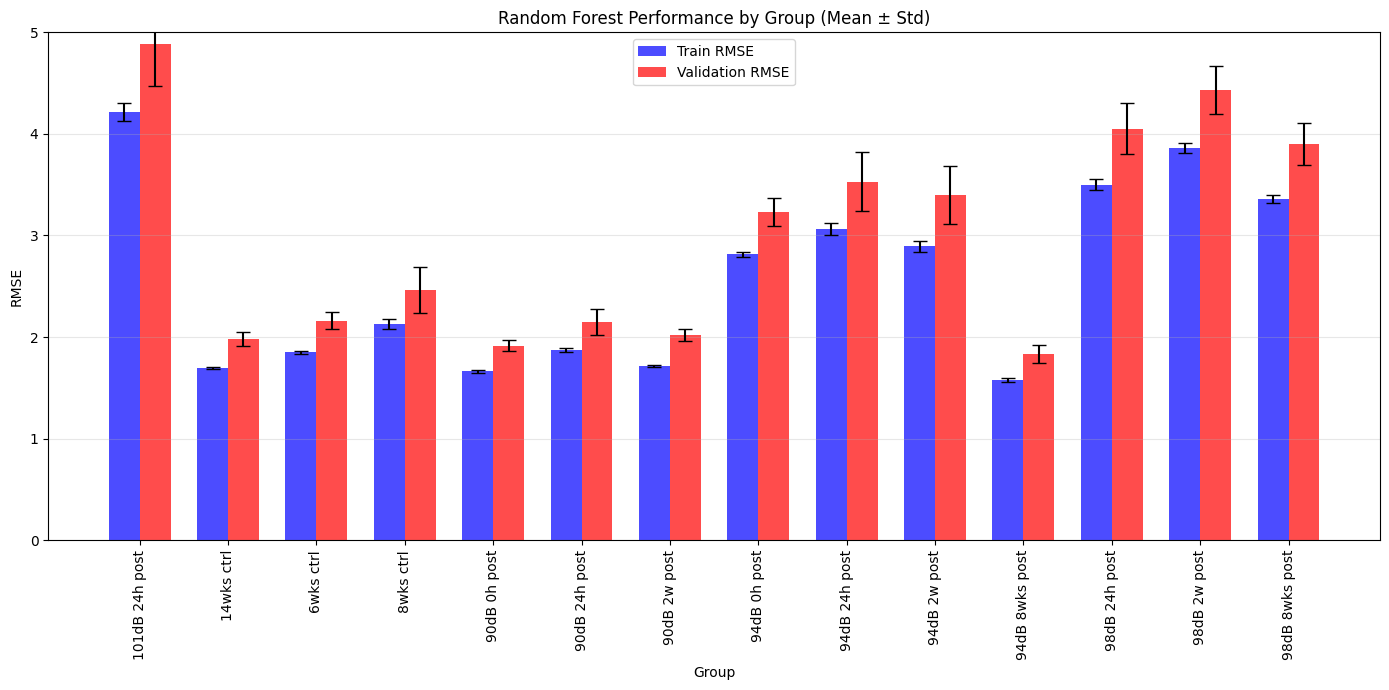

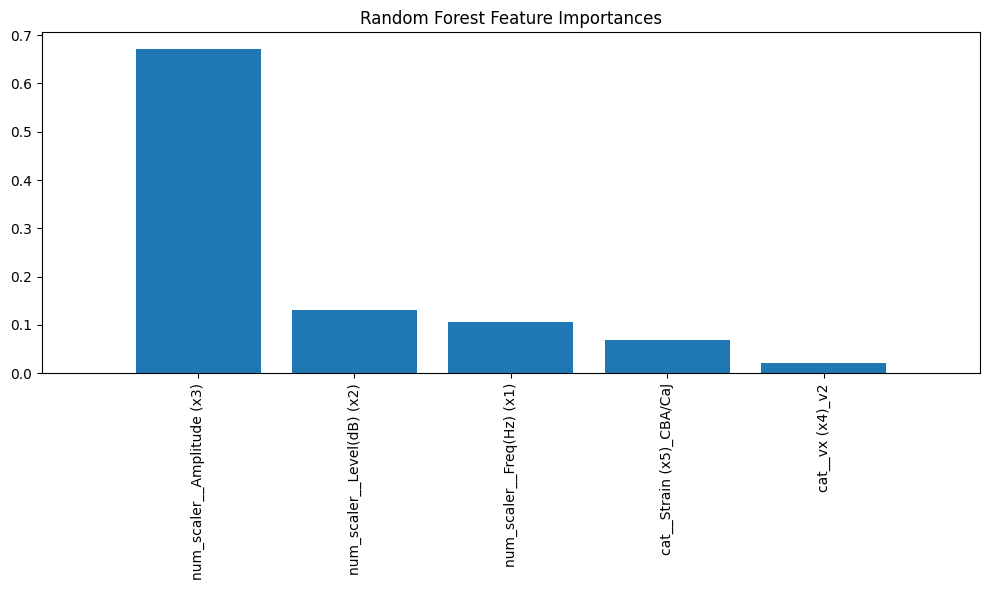


To compare with Bayesian model, use the val_mean values from above.


In [191]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor

# Get the data
X = final_clean_strained_grouped_pos_cleangroup[['Freq(Hz) (x1)', 'Level(dB) (x2)', 'Amplitude (x3)', 'vx (x4)', 'Strain (x5)']]
y = final_clean_strained_grouped_pos_cleangroup['Synapses to IHC (y1)']
groups = final_clean_strained_grouped_pos_cleangroup['Group']

# Set up cross-validation
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Store results
fold_results = []
group_train_rmse = {group: [] for group in np.unique(groups)}
group_val_rmse = {group: [] for group in np.unique(groups)}

# Track overall CV performance
train_rmse_scores = []
val_rmse_scores = []

# Define the preprocessing pipeline
preprocessor = ColumnTransformer([
    ('num_scaler', StandardScaler(), ['Freq(Hz) (x1)', 'Level(dB) (x2)', 'Amplitude (x3)']),
    ('cat', OneHotEncoder(drop='first', sparse_output=False), ['vx (x4)', 'Strain (x5)'])
])

# Set up the RF model EDIT HERE LEE
rf_model = RandomForestRegressor(n_estimators=500, 
                              max_depth=15, 
                              min_samples_leaf=5, 
                              max_features='sqrt',
                              random_state=42)

# Set up the pipeline
rf_pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('rf', rf_model)
])

print(f"\nPerforming {n_splits}-fold Cross-Validation...")

# Perform cross-validation
filtered = final_clean_strained_grouped_pos_cleangroup[final_clean_strained_grouped_pos_cleangroup['Level(dB) (x2)'] >= thres]
for fold_idx, (train_idx, val_idx) in enumerate(kf.split(filtered)):
    # Split data for this fold
    X_fold_train, X_fold_val = filtered.iloc[train_idx], filtered.iloc[val_idx]
    y_fold_train, y_fold_val = y.iloc[train_idx], y.iloc[val_idx]
    groups_train, groups_val = groups.iloc[train_idx], groups.iloc[val_idx]
    
    print(f"Processing Fold {fold_idx+1}...")
    
    # Fit the model
    rf_pipeline.fit(X_fold_train, y_fold_train)
    
    # Make predictions
    y_train_pred = rf_pipeline.predict(X_fold_train)
    y_val_pred = rf_pipeline.predict(X_fold_val)
    
    # Calculate overall metrics
    fold_train_rmse = np.sqrt(mean_squared_error(y_fold_train, y_train_pred))
    fold_val_rmse = np.sqrt(mean_squared_error(y_fold_val, y_val_pred))
    
    train_rmse_scores.append(fold_train_rmse)
    val_rmse_scores.append(fold_val_rmse)
    
    print(f"Fold {fold_idx+1}: Train RMSE = {fold_train_rmse:.4f}, Validation RMSE = {fold_val_rmse:.4f}")
    
    # Group-specific analysis
    # Create DataFrames with all the information for easier grouping
    train_results = pd.DataFrame({
        'true': y_fold_train,
        'pred': y_train_pred,
        'group': groups_train
    })
    
    val_results = pd.DataFrame({
        'true': y_fold_val,
        'pred': y_val_pred,
        'group': groups_val
    })
    
    # Calculate group-specific metrics for training set
    for group_name, group_data in train_results.groupby('group'):
        group_rmse = np.sqrt(mean_squared_error(group_data['true'], group_data['pred']))
        group_train_rmse[group_name].append(group_rmse)
    
    # Calculate group-specific metrics for validation set
    for group_name, group_data in val_results.groupby('group'):
        group_rmse = np.sqrt(mean_squared_error(group_data['true'], group_data['pred']))
        group_val_rmse[group_name].append(group_rmse)
    
    # Store fold results
    fold_results.append({
        'fold': fold_idx + 1,
        'train_rmse': fold_train_rmse,
        'val_rmse': fold_val_rmse,
        'train_index': train_idx,
        'val_index': val_idx
    })

# Calculate average metrics
avg_train_rmse = np.mean(train_rmse_scores)
std_train_rmse = np.std(train_rmse_scores)
avg_val_rmse = np.mean(val_rmse_scores)
std_val_rmse = np.std(val_rmse_scores)

print(f"\nAverage Train RMSE: {avg_train_rmse:.4f} ± {std_train_rmse:.4f}")
print(f"Average Validation RMSE: {avg_val_rmse:.4f} ± {std_val_rmse:.4f}")

# Print group-specific RMSE
print("\nGroup-specific RMSE:")
print("Group | Train RMSE (Mean ± Std) | Validation RMSE (Mean ± Std)")
print("----- | ----------------------- | -----------------------------")

for group in sorted(group_train_rmse.keys()):
    train_values = group_train_rmse[group]
    val_values = group_val_rmse[group]
    
    if train_values:
        train_mean = np.mean(train_values)
        train_std = np.std(train_values)
        train_str = f"{train_mean:.6f} ± {train_std:.6f}"
    else:
        train_str = "N/A"
        
    if val_values:
        val_mean = np.mean(val_values)
        val_std = np.std(val_values)
        val_str = f"{val_mean:.6f} ± {val_std:.6f}"
    else:
        val_str = "N/A"
        
    print(f"{group:15s} | {train_str:25s} | {val_str:25s}")


# Create lists to store the data
groups_list = []
train_mean_list = []
train_std_list = []
val_mean_list = []
val_std_list = []

# Extract values for each group
for group in sorted(group_train_rmse.keys()):
    train_values = group_train_rmse[group]
    val_values = group_val_rmse[group]
    
    groups_list.append(group)
    
    if train_values:
        train_mean_list.append(np.mean(train_values))
        train_std_list.append(np.std(train_values))
    else:
        train_mean_list.append(np.nan)
        train_std_list.append(np.nan)
        
    if val_values:
        val_mean_list.append(np.mean(val_values))
        val_std_list.append(np.std(val_values))
    else:
        val_mean_list.append(np.nan)
        val_std_list.append(np.nan)

# Create DataFrame
group_metrics_df = pd.DataFrame({
    'Group': groups_list,
    'Train_RMSE_Mean': train_mean_list,
    'Val_RMSE_Mean': val_mean_list,
    'Train_RMSE_Std': train_std_list,
    'Val_RMSE_Std': val_std_list
})

# Visualization of group-specific RMSE
# Prepare data for plotting
plot_groups = []
plot_train_rmse = []
plot_val_rmse = []
plot_train_std = []
plot_val_std = []

for group in sorted(group_train_rmse.keys()):
    train_values = group_train_rmse[group]
    val_values = group_val_rmse[group]
    
    if train_values and val_values:
        plot_groups.append(group)
        plot_train_rmse.append(np.mean(train_values))
        plot_val_rmse.append(np.mean(val_values))
        plot_train_std.append(np.std(train_values))
        plot_val_std.append(np.std(val_values))

# Create plot if we have data
if plot_groups:
    plt.figure(figsize=(14, 7))
    x = np.arange(len(plot_groups))
    width = 0.35
    
    plt.bar(x - width/2, plot_train_rmse, width, yerr=plot_train_std, 
            label='Train RMSE', color='blue', alpha=0.7, capsize=5)
    plt.bar(x + width/2, plot_val_rmse, width, yerr=plot_val_std,
            label='Validation RMSE', color='red', alpha=0.7, capsize=5)
    
    plt.xlabel('Group')
    plt.ylabel('RMSE')
    plt.ylim((0, 5))
    plt.title('Random Forest Performance by Group (Mean ± Std)')
    plt.xticks(x, plot_groups, rotation=90)
    plt.legend()
    plt.grid(True, axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

# Feature importance analysis from the final model
feature_names = rf_pipeline.named_steps['preprocessing'].get_feature_names_out()
importances = rf_pipeline.named_steps['rf'].feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title('Random Forest Feature Importances')
plt.bar(range(len(importances)), importances[indices], align='center')
plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=90)
plt.xlim([-1, len(importances)])
plt.tight_layout()
plt.show()

# Compare with Bayesian model results (if available)
print("\nTo compare with Bayesian model, use the val_mean values from above.")

In [193]:
len(final_clean_strained_grouped[final_clean_strained_grouped['Amplitude (x3)'] < 0]) / len(final_clean_strained_grouped)

0.003282185935833265

In [181]:
group_metrics_df

,Group,Train_RMSE_Mean,Val_RMSE_Mean,Train_RMSE_Std,Val_RMSE_Std
0,101dB 24h post,2.371574,2.818727,0.026183,0.151647
1,14wks ctrl,1.770728,2.064806,0.008942,0.060075
2,6wks ctrl,1.685709,1.984076,0.026673,0.119458
3,8wks ctrl,1.887512,2.197998,0.063440,0.233913
4,90dB 0h post,1.618448,1.895123,0.031284,0.097227
5,90dB 24h post,1.718025,2.006418,0.021572,0.140686
6,90dB 2w post,1.811153,2.138495,0.015008,0.105281
7,94dB 0h post,2.131802,2.518568,0.046262,0.196721
8,94dB 24h post,2.485612,2.953618,0.047875,0.269147
9,94dB 2w post,2.712291,3.160168,0.026709,0.150976



Group-specific Random Forest performance:
Group | Train RMSE | Test RMSE | Train Count | Test Count
----- | ---------- | --------- | ----------- | ----------
101dB 24h post | 2.6863 | 3.6435 | 170 | 74
14wks ctrl | 1.8503 | 2.1348 | 1318 | 226
6wks ctrl | 1.9224 | 1.8374 | 1458 | 256
8wks ctrl | 1.8893 | 3.3601 | 868 | 168
90dB 0h post | 1.9116 | 1.7265 | 508 | 138
90dB 24h post | 1.9177 | 2.3185 | 490 | 126
90dB 2w post | 2.0345 | 2.0687 | 922 | 134
94dB 0h post | 2.4081 | 2.5214 | 590 | 110
94dB 24h post | 3.0313 | 1.8580 | 532 | 104
94dB 2w post | 2.9580 | 3.1431 | 628 | 128
94dB 8wks post | 1.7343 | 2.1595 | 574 | 120
98dB 24h post | 3.2348 | 2.6246 | 538 | 108
98dB 2w post | 3.8176 | 2.2714 | 640 | 70
98dB 8wks post | 2.6804 | 3.4332 | 951 | 238


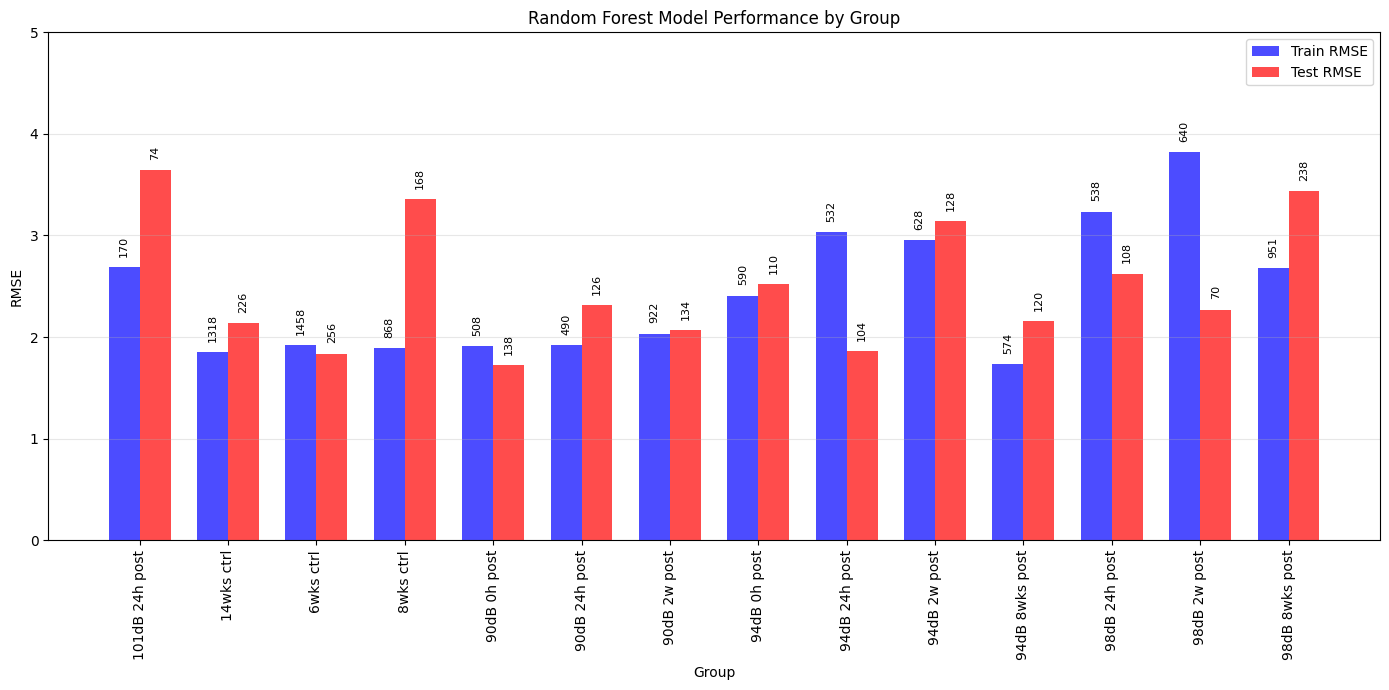

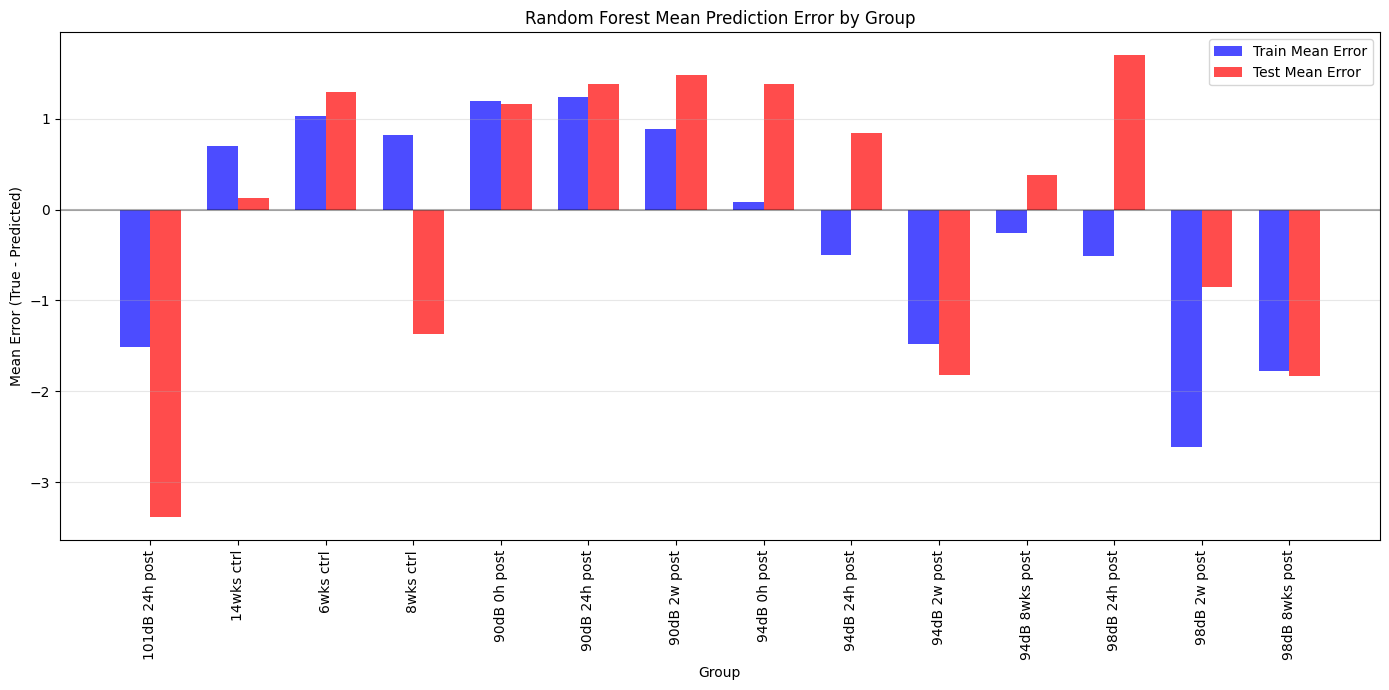

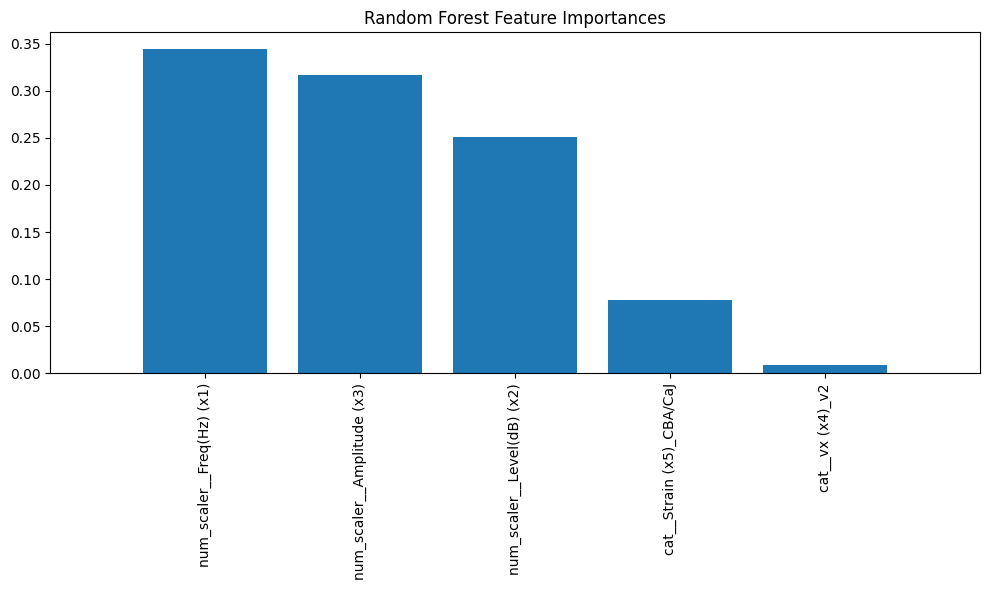

"\nif 'bayesian_train_rmse' in globals() and 'bayesian_test_rmse' in globals():\n    plt.figure(figsize=(14, 7))\n    \n    # Plot RF test RMSE\n    plt.plot(all_groups, test_rmse_values, 'ro-', label='Random Forest Test RMSE')\n    \n    # Plot Bayesian test RMSE\n    bayesian_values = [bayesian_test_rmse.get(group, 0) for group in all_groups]\n    plt.plot(all_groups, bayesian_values, 'bo-', label='Bayesian Test RMSE')\n    \n    plt.xlabel('Group')\n    plt.ylabel('Test RMSE')\n    plt.title('Model Comparison: Random Forest vs Bayesian')\n    plt.xticks(rotation=90)\n    plt.legend()\n    plt.grid(True, alpha=0.3)\n    plt.tight_layout()\n    plt.show()\n"

In [163]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Calculate group-specific performance metrics
def calculate_group_metrics(X, y_true, y_pred, group_column):
    """
    Calculate performance metrics for each group.
    
    Parameters:
    -----------
    X : DataFrame
        Features with group information
    y_true : Series
        True target values
    y_pred : array-like
        Predicted target values
    group_column : str
        Name of the column containing group information
        
    Returns:
    --------
    dict
        Dictionary with group metrics
    """
    # Combine inputs for easier processing
    results_df = pd.DataFrame({
        'Group': X[group_column],
        'True': y_true,
        'Pred': y_pred,
        'Error': y_true - y_pred,
        'Abs_Error': np.abs(y_true - y_pred),
        'Sq_Error': (y_true - y_pred)**2
    })
    
    # Group-specific metrics
    group_metrics = {}
    
    for group_name, group_data in results_df.groupby('Group'):
        rmse = np.sqrt(np.mean(group_data['Sq_Error']))
        mae = np.mean(group_data['Abs_Error'])
        mean_error = np.mean(group_data['Error'])  # Positive means underprediction
        count = len(group_data)
        
        group_metrics[group_name] = {
            'RMSE': rmse,
            'MAE': mae,
            'Mean_Error': mean_error,
            'Count': count
        }
    
    return group_metrics

# Calculate metrics for training and test sets
train_data = pd.concat([X_train, final_clean_strained_grouped_pos_cleangroup.loc[train_mask, ['Group']]], axis=1)
test_data = pd.concat([X_test, final_clean_strained_grouped_pos_cleangroup.loc[test_mask, ['Group']]], axis=1)

train_group_metrics = calculate_group_metrics(train_data, y1_train, y1_train_pred, 'Group')
test_group_metrics = calculate_group_metrics(test_data, y1_test, y1_pred, 'Group')

# Print metrics in a table
print("\nGroup-specific Random Forest performance:")
print("Group | Train RMSE | Test RMSE | Train Count | Test Count")
print("----- | ---------- | --------- | ----------- | ----------")

all_groups = sorted(set(train_group_metrics.keys()) | set(test_group_metrics.keys()))

for group in all_groups:
    train_rmse = f"{train_group_metrics[group]['RMSE']:.4f}" if group in train_group_metrics else "N/A"
    test_rmse = f"{test_group_metrics[group]['RMSE']:.4f}" if group in test_group_metrics else "N/A" 
    train_count = train_group_metrics[group]['Count'] if group in train_group_metrics else 0
    test_count = test_group_metrics[group]['Count'] if group in test_group_metrics else 0
    
    print(f"{group} | {train_rmse} | {test_rmse} | {train_count} | {test_count}")

# Visualize group-specific RMSE
plt.figure(figsize=(14, 7))
x = np.arange(len(all_groups))
width = 0.35

train_rmse_values = [train_group_metrics[group]['RMSE'] if group in train_group_metrics else 0 for group in all_groups]
test_rmse_values = [test_group_metrics[group]['RMSE'] if group in test_group_metrics else 0 for group in all_groups]

plt.bar(x - width/2, train_rmse_values, width, label='Train RMSE', color='blue', alpha=0.7)
plt.bar(x + width/2, test_rmse_values, width, label='Test RMSE', color='red', alpha=0.7)

plt.xlabel('Group')
plt.ylabel('RMSE')
plt.ylim((0, 5))  # Adjust as needed
plt.title('Random Forest Model Performance by Group')
plt.xticks(x, all_groups, rotation=90)
plt.legend()
plt.grid(True, axis='y', alpha=0.3)
plt.tight_layout()

# Add sample counts above bars
for i, group in enumerate(all_groups):
    train_count = train_group_metrics[group]['Count'] if group in train_group_metrics else 0
    test_count = test_group_metrics[group]['Count'] if group in test_group_metrics else 0
    
    plt.text(i - width/2, train_rmse_values[i] + 0.1, str(train_count), 
             ha='center', va='bottom', fontsize=8, rotation=90)
    plt.text(i + width/2, test_rmse_values[i] + 0.1, str(test_count), 
             ha='center', va='bottom', fontsize=8, rotation=90)

plt.show()

# Create a second visualization: Error distribution by group
plt.figure(figsize=(14, 7))

# Calculate mean error and error range for each group
train_mean_errors = [train_group_metrics[group]['Mean_Error'] if group in train_group_metrics else 0 for group in all_groups]
test_mean_errors = [test_group_metrics[group]['Mean_Error'] if group in test_group_metrics else 0 for group in all_groups]

plt.bar(x - width/2, train_mean_errors, width, label='Train Mean Error', color='blue', alpha=0.7)
plt.bar(x + width/2, test_mean_errors, width, label='Test Mean Error', color='red', alpha=0.7)

plt.xlabel('Group')
plt.ylabel('Mean Error (True - Predicted)')
plt.title('Random Forest Mean Prediction Error by Group')
plt.xticks(x, all_groups, rotation=90)
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.legend()
plt.grid(True, axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Feature importance analysis
feature_names = preprocessor.get_feature_names_out()
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title('Random Forest Feature Importances')
plt.bar(range(len(importances)), importances[indices], align='center')
plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=90)
plt.xlim([-1, len(importances)])
plt.tight_layout()
plt.show()

# Create a comparison plot between Bayesian and RF performance by group (if available)
# Assuming you have the Bayesian model results in variables:
# bayesian_train_rmse and bayesian_test_rmse dictionaries

# This is placeholder code - you'll need to adapt it based on how you store your Bayesian results
"""
if 'bayesian_train_rmse' in globals() and 'bayesian_test_rmse' in globals():
    plt.figure(figsize=(14, 7))
    
    # Plot RF test RMSE
    plt.plot(all_groups, test_rmse_values, 'ro-', label='Random Forest Test RMSE')
    
    # Plot Bayesian test RMSE
    bayesian_values = [bayesian_test_rmse.get(group, 0) for group in all_groups]
    plt.plot(all_groups, bayesian_values, 'bo-', label='Bayesian Test RMSE')
    
    plt.xlabel('Group')
    plt.ylabel('Test RMSE')
    plt.title('Model Comparison: Random Forest vs Bayesian')
    plt.xticks(rotation=90)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
"""

In [ ]:
# subjects_by_group = {}
# for group in final_clean_strained_grouped_pos['Group'].unique():
#     subjects_in_group = final_clean_strained_grouped_pos[(final_clean_strained_grouped_pos['Group'] == group) & (final_clean_strained_grouped_pos['Level(dB) (x2)'] >= 60)]['Subject'].unique()
#     subjects_by_group[group] = list(subjects_in_group)

# # 2. Create stratified train/test split of subjects
# train_subjects = []
# test_subjects = []

# # For each group, put 80% of subjects in train, 20% in test
# for group, subjects in subjects_by_group.items():
#     n_test = max(1, int(len(subjects) * 0.2))  # At least 1 subject in test
    
#     # Shuffle subjects (with fixed random seed for reproducibility)
#     np.random.seed(42)
#     np.random.shuffle(subjects)
    
#     # Split subjects for this group
#     test_subjects.extend(subjects[:n_test])
#     train_subjects.extend(subjects[n_test:])

# # 3. Split data based on subjects
# train_mask = final_clean_strained_grouped_pos['Subject'].isin(train_subjects)
# test_mask = final_clean_strained_grouped['Subject'].isin(test_subjects)

# X_train = final_clean_strained_grouped_pos.loc[train_mask, ['Freq(Hz) (x1)', 'Level(dB) (x2)', 'Amplitude (x3)', 'vx (x4)', 'Strain (x5)']]
# X_test = final_clean_strained_grouped_pos.loc[test_mask, ['Freq(Hz) (x1)', 'Level(dB) (x2)', 'Amplitude (x3)', 'vx (x4)', 'Strain (x5)']]
# y1_train = final_clean_strained_grouped_pos.loc[train_mask, 'Synapses to IHC (y1)']
# y1_test = final_clean_strained_grouped_pos.loc[test_mask, 'Synapses to IHC (y1)']

# # 4. Verify the split maintains the group distribution
# train_group_dist = final_clean_strained_grouped_pos.loc[train_mask, 'Group'].value_counts(normalize=True)
# test_group_dist = final_clean_strained_grouped_pos.loc[test_mask, 'Group'].value_counts(normalize=True)

# # print("Training set distribution by group:")
# # print(train_group_dist)
# # print("\nTest set distribution by group:")
# # print(test_group_dist)

# train_subject_set = set(final_clean_strained_grouped_pos.loc[train_mask, 'Subject'])
# test_subject_set = set(final_clean_strained_grouped_pos.loc[test_mask, 'Subject'])
# overlap = train_subject_set.intersection(test_subject_set)

# preprocessor = ColumnTransformer([
#     ('num_scaler', MinMaxScaler(), ['Amplitude (x3)']),
#     ('cat', OneHotEncoder(drop='first', sparse_output=False), ['vx (x4)', 'Strain (x5)'])
# ])

# rf_pipeline = Pipeline([
#     ('preprocessing', preprocessor),
#     ('rf', RandomForestRegressor(n_estimators=100, random_state=42,
#                                 max_depth=10, 
#                                 min_samples_leaf=5))
# ])

# rf_pipeline.fit(X_train, y1_train)
# rf_model = rf_pipeline.named_steps['rf']

# # 7. Evaluate on test set
# y1_pred = rf_pipeline.predict(X_test)
# test_rmse = np.sqrt(np.mean((y1_test - y1_pred)**2))
# test_mae = np.abs(y1_test - y1_pred).mean()
# print(f"NEW COMPARISON - Val set RMSE: {test_rmse:.4f}")
# print(f"Test set MAE: {test_mae:.4f}")

In [255]:
final_clean_strained_grouped_pos_cleangroup_vs_timed

,Subject,Freq(Hz) (x1),Level(dB) (x2),Amplitude (x3),vx (x4),Strain (x5),Group - dB (x6),Group - Time Elapsed,Group,Synapses to IHC (y1),Group - Time Elapsed - Split,Group - Time Elapsed - Magn.,Group - Time Elapsed - Unit,Group - Hours Elapsed (x7)
0,WPZ145,45200.0,70.0,0.033579,v1,C57B6,98dB,8wks,98dB 8wks post,8.750000,"[8, wks]",8,wks,1344
0,WPZ145,45200.0,70.0,0.033579,v2,C57B6,98dB,8wks,98dB 8wks post,10.888889,"[8, wks]",8,wks,1344
1,WPZ145,45200.0,75.0,0.034262,v1,C57B6,98dB,8wks,98dB 8wks post,8.750000,"[8, wks]",8,wks,1344
1,WPZ145,45200.0,75.0,0.034262,v2,C57B6,98dB,8wks,98dB 8wks post,10.888889,"[8, wks]",8,wks,1344
2,WPZ145,45200.0,80.0,0.154224,v1,C57B6,98dB,8wks,98dB 8wks post,8.750000,"[8, wks]",8,wks,1344
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7328,WPZ101,32000.0,60.0,1.634279,v2,C57B6,0dB (C),8wks,8wks ctrl,15.463918,"[8, wks]",8,wks,1344
7329,WPZ101,32000.0,70.0,1.769193,v1,C57B6,0dB (C),8wks,8wks ctrl,16.923077,"[8, wks]",8,wks,1344
7329,WPZ101,32000.0,70.0,1.769193,v2,C57B6,0dB (C),8wks,8wks ctrl,15.463918,"[8, wks]",8,wks,1344
7330,WPZ101,32000.0,80.0,1.023154,v1,C57B6,0dB (C),8wks,8wks ctrl,16.923077,"[8, wks]",8,wks,1344


## With strain, freq, amp, exp


Performing 5-fold Cross-Validation...
Processing Fold 1...
Fold 1: Train RMSE = 2.4982, Validation RMSE = 2.6300
Processing Fold 2...
Fold 2: Train RMSE = 2.4797, Validation RMSE = 2.7070
Processing Fold 3...
Fold 3: Train RMSE = 2.4820, Validation RMSE = 2.6770
Processing Fold 4...
Fold 4: Train RMSE = 2.4832, Validation RMSE = 2.6883
Processing Fold 5...
Fold 5: Train RMSE = 2.4807, Validation RMSE = 2.7105

Average Train RMSE: 2.4848 ± 0.0068
Average Validation RMSE: 2.6826 ± 0.0290

Group-specific RMSE:
Group | Train RMSE (Mean ± Std) | Validation RMSE (Mean ± Std)
----- | ----------------------- | -----------------------------
101dB 24h post  | 4.352365 ± 0.109562       | 4.663201 ± 0.505569      
14wks ctrl      | 1.902386 ± 0.018029       | 2.060570 ± 0.072313      
6wks ctrl       | 1.904384 ± 0.016455       | 2.057361 ± 0.040804      
8wks ctrl       | 2.110292 ± 0.062008       | 2.245648 ± 0.276043      
90dB 0h post    | 1.477290 ± 0.021778       | 1.645140 ± 0.092981      

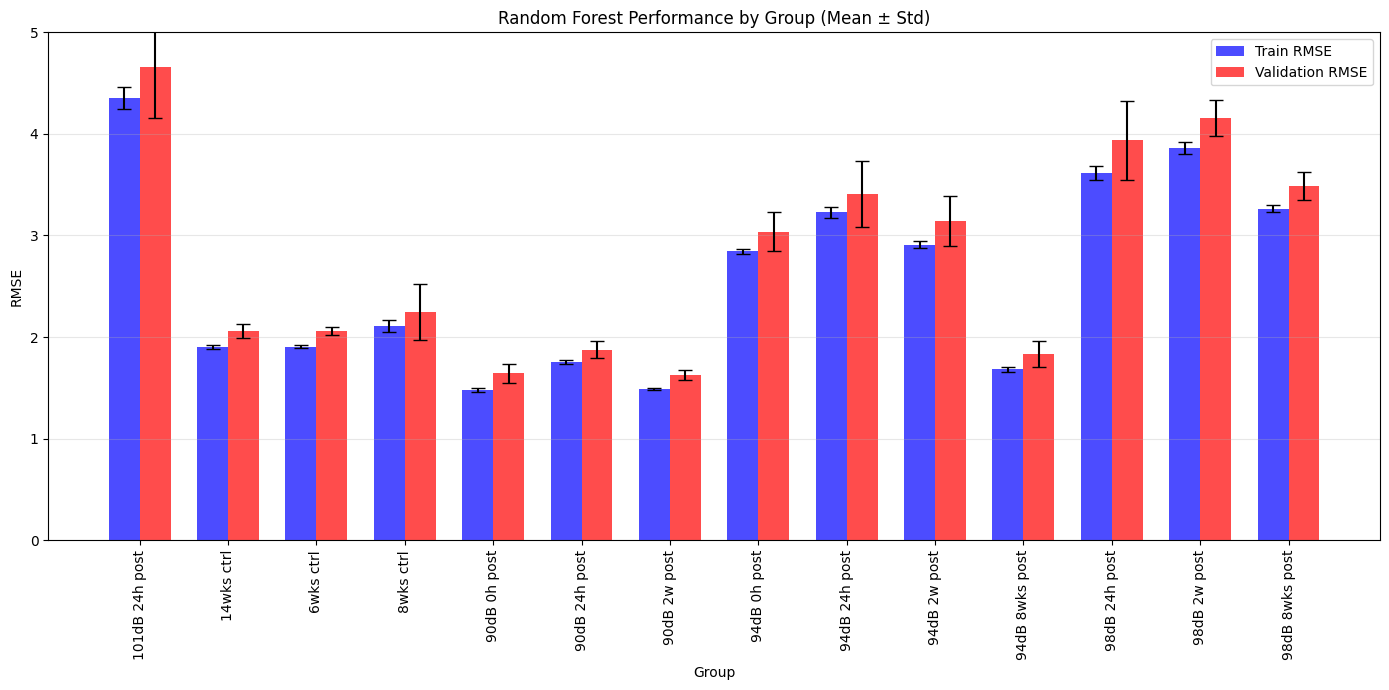

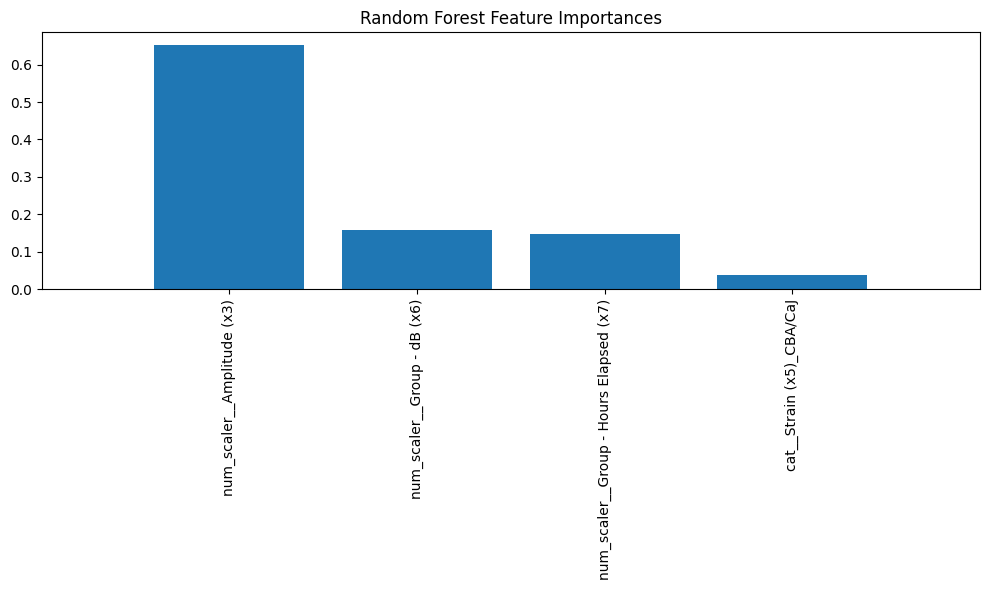

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor

# Get the data
X = final_clean_strained_grouped_pos_cleangroup_vs_timed[['Freq(Hz) (x1)', 'Amplitude (x3)', 'Strain (x5)', 'Group - dB (x6)', 'Group - Hours Elapsed (x7)']]
y = final_clean_strained_grouped_pos_cleangroup_vs_timed['Synapses to IHC (y1)']
groups = final_clean_strained_grouped_pos_cleangroup_vs_timed['Group']

# Set up cross-validation
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
thres = 20

# Store results
fold_results = []
group_train_rmse = {group: [] for group in np.unique(groups)}
group_val_rmse = {group: [] for group in np.unique(groups)}

# Track overall CV performance
train_rmse_scores = []
val_rmse_scores = []

# Define the preprocessing pipeline
preprocessor = ColumnTransformer([
    ('num_scaler', StandardScaler(), ['Freq(Hz) (x1)', 'Amplitude (x3)', 'Group - dB (x6)', 'Group - Hours Elapsed (x7)']),
    ('cat', OneHotEncoder(drop='first', sparse_output=False), ['Strain (x5)'])
])

# Set up the RF model EDIT HERE LEE
rf_model = RandomForestRegressor(n_estimators=500, 
                              max_depth=10, 
                              min_samples_leaf=5, 
                            #   max_features='sqrt',
                              random_state=42)

# Set up the pipeline
rf_pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('rf', rf_model)
])

print(f"\nPerforming {n_splits}-fold Cross-Validation...")

# Perform cross-validation
filtered = final_clean_strained_grouped_pos_cleangroup_vs_timed[final_clean_strained_grouped_pos_cleangroup_vs_timed['Level(dB) (x2)'] >= thres]
for fold_idx, (train_idx, val_idx) in enumerate(kf.split(filtered)):
    # Split data for this fold
    X_fold_train, X_fold_val = filtered.iloc[train_idx], filtered.iloc[val_idx]
    y_fold_train, y_fold_val = y.iloc[train_idx], y.iloc[val_idx]
    groups_train, groups_val = groups.iloc[train_idx], groups.iloc[val_idx]
    
    print(f"Processing Fold {fold_idx+1}...")
    
    # Fit the model
    rf_pipeline.fit(X_fold_train, y_fold_train)
    
    # Make predictions
    y_train_pred = rf_pipeline.predict(X_fold_train)
    y_val_pred = rf_pipeline.predict(X_fold_val)
    
    # Calculate overall metrics
    fold_train_rmse = np.sqrt(mean_squared_error(y_fold_train, y_train_pred))
    fold_val_rmse = np.sqrt(mean_squared_error(y_fold_val, y_val_pred))
    
    train_rmse_scores.append(fold_train_rmse)
    val_rmse_scores.append(fold_val_rmse)
    
    print(f"Fold {fold_idx+1}: Train RMSE = {fold_train_rmse:.4f}, Validation RMSE = {fold_val_rmse:.4f}")
    
    # Group-specific analysis
    # Create DataFrames with all the information for easier grouping
    train_results = pd.DataFrame({
        'true': y_fold_train,
        'pred': y_train_pred,
        'group': groups_train
    })
    
    val_results = pd.DataFrame({
        'true': y_fold_val,
        'pred': y_val_pred,
        'group': groups_val
    })
    
    # Calculate group-specific metrics for training set
    for group_name, group_data in train_results.groupby('group'):
        group_rmse = np.sqrt(mean_squared_error(group_data['true'], group_data['pred']))
        group_train_rmse[group_name].append(group_rmse)
    
    # Calculate group-specific metrics for validation set
    for group_name, group_data in val_results.groupby('group'):
        group_rmse = np.sqrt(mean_squared_error(group_data['true'], group_data['pred']))
        group_val_rmse[group_name].append(group_rmse)
    
    # Store fold results
    fold_results.append({
        'fold': fold_idx + 1,
        'train_rmse': fold_train_rmse,
        'val_rmse': fold_val_rmse,
        'train_index': train_idx,
        'val_index': val_idx
    })

# Calculate average metrics
avg_train_rmse = np.mean(train_rmse_scores)
std_train_rmse = np.std(train_rmse_scores)
avg_val_rmse = np.mean(val_rmse_scores)
std_val_rmse = np.std(val_rmse_scores)

print(f"\nAverage Train RMSE: {avg_train_rmse:.4f} ± {std_train_rmse:.4f}")
print(f"Average Validation RMSE: {avg_val_rmse:.4f} ± {std_val_rmse:.4f}")

# Print group-specific RMSE
print("\nGroup-specific RMSE:")
print("Group | Train RMSE (Mean ± Std) | Validation RMSE (Mean ± Std)")
print("----- | ----------------------- | -----------------------------")

for group in sorted(group_train_rmse.keys()):
    train_values = group_train_rmse[group]
    val_values = group_val_rmse[group]
    
    if train_values:
        train_mean = np.mean(train_values)
        train_std = np.std(train_values)
        train_str = f"{train_mean:.6f} ± {train_std:.6f}"
    else:
        train_str = "N/A"
        
    if val_values:
        val_mean = np.mean(val_values)
        val_std = np.std(val_values)
        val_str = f"{val_mean:.6f} ± {val_std:.6f}"
    else:
        val_str = "N/A"
        
    print(f"{group:15s} | {train_str:25s} | {val_str:25s}")


# Create lists to store the data
groups_list = []
train_mean_list = []
train_std_list = []
val_mean_list = []
val_std_list = []

# Extract values for each group
for group in sorted(group_train_rmse.keys()):
    train_values = group_train_rmse[group]
    val_values = group_val_rmse[group]
    
    groups_list.append(group)
    
    if train_values:
        train_mean_list.append(np.mean(train_values))
        train_std_list.append(np.std(train_values))
    else:
        train_mean_list.append(np.nan)
        train_std_list.append(np.nan)
        
    if val_values:
        val_mean_list.append(np.mean(val_values))
        val_std_list.append(np.std(val_values))
    else:
        val_mean_list.append(np.nan)
        val_std_list.append(np.nan)

# Create DataFrame
group_metrics_df = pd.DataFrame({
    'Group': groups_list,
    'Train_RMSE_Mean': train_mean_list,
    'Val_RMSE_Mean': val_mean_list,
    'Train_RMSE_Std': train_std_list,
    'Val_RMSE_Std': val_std_list
})

# Visualization of group-specific RMSE
# Prepare data for plotting
plot_groups = []
plot_train_rmse = []
plot_val_rmse = []
plot_train_std = []
plot_val_std = []

for group in sorted(group_train_rmse.keys()):
    train_values = group_train_rmse[group]
    val_values = group_val_rmse[group]
    
    if train_values and val_values:
        plot_groups.append(group)
        plot_train_rmse.append(np.mean(train_values))
        plot_val_rmse.append(np.mean(val_values))
        plot_train_std.append(np.std(train_values))
        plot_val_std.append(np.std(val_values))

# Create plot if we have data
if plot_groups:
    plt.figure(figsize=(14, 7))
    x = np.arange(len(plot_groups))
    width = 0.35
    
    plt.bar(x - width/2, plot_train_rmse, width, yerr=plot_train_std, 
            label='Train RMSE', color='blue', alpha=0.7, capsize=5)
    plt.bar(x + width/2, plot_val_rmse, width, yerr=plot_val_std,
            label='Validation RMSE', color='red', alpha=0.7, capsize=5)
    
    plt.xlabel('Group')
    plt.ylabel('RMSE')
    plt.ylim((0, 5))
    plt.title('Random Forest Performance by Group (Mean ± Std)')
    plt.xticks(x, plot_groups, rotation=90)
    plt.legend()
    plt.grid(True, axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

# Feature importance analysis from the final model
feature_names = rf_pipeline.named_steps['preprocessing'].get_feature_names_out()
importances = rf_pipeline.named_steps['rf'].feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title('Random Forest Feature Importances')
plt.bar(range(len(importances)), importances[indices], align='center')
plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=90)
plt.xlim([-1, len(importances)])
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor

# Lists to store results
thres = 20
tree_results = []
leaf_results = []
depth_results = []
train_cv_results = []
val_cv_results = []

# Hyperparameter grid
trees_options = [100, 200, 300, 400, 500]
leaf_options = [5, 10, 15, 20, 25]
depth_options = [5, 10, 15]

# Cross-validation settings
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Main loop for hyperparameter tuning
for trees in trees_options:
    for leaf in leaf_options:
        for depth in depth_options:
            print(f"\nTesting: trees={trees}, leaf={leaf}, depth={depth}")
            
            # CV setup
            cv_train_rmse = []
            cv_val_rmse = []
            
            # Perform cross-validation for this parameter combination
            filtered = final_clean_strained_grouped_pos_cleangroup_vs_timed[final_clean_strained_grouped_pos_cleangroup_vs_timed['Level(dB) (x2)'] >= thres]
            for fold_idx, (train_idx, val_idx) in enumerate(kf.split(filtered)):
                # Get data for this fold
                X_fold_train = final_clean_strained_grouped_pos_cleangroup_vs_timed.iloc[train_idx][['Freq(Hz) (x1)', 'Amplitude (x3)', 'Strain (x5)', 'Group - dB (x6)', 'Group - Hours Elapsed (x7)']]
                y_fold_train = final_clean_strained_grouped_pos_cleangroup_vs_timed.iloc[train_idx]['Synapses to IHC (y1)']
                
                X_fold_val = final_clean_strained_grouped_pos_cleangroup_vs_timed.iloc[val_idx][['Freq(Hz) (x1)', 'Amplitude (x3)', 'Strain (x5)', 'Group - dB (x6)', 'Group - Hours Elapsed (x7)']]
                y_fold_val = final_clean_strained_grouped_pos_cleangroup_vs_timed.iloc[val_idx]['Synapses to IHC (y1)']
                
                # Set up preprocessor
                preprocessor = ColumnTransformer([
                    ('num_scaler', MinMaxScaler(), ['Freq(Hz) (x1)', 'Amplitude (x3)', 'Group - dB (x6)', 'Group - H Elapsed (x7)']),
                    ('cat', OneHotEncoder(drop='first', sparse_output=False), ['Strain (x5)'])
                ])
                
                # Create and train pipeline
                rf_pipeline = Pipeline([
                    ('preprocessing', preprocessor),
                    ('rf', RandomForestRegressor(
                        n_estimators=trees, 
                        max_depth=depth, 
                        min_samples_leaf=leaf,
                        # max_features='sqrt',
                        random_state=42))
                ])
                
                # Fit the model
                rf_pipeline.fit(X_fold_train, y_fold_train)
                
                # Make predictions
                train_pred = rf_pipeline.predict(X_fold_train)
                val_pred = rf_pipeline.predict(X_fold_val)
                
                # Calculate RMSE
                fold_train_rmse = np.sqrt(mean_squared_error(y_fold_train, train_pred))
                fold_val_rmse = np.sqrt(mean_squared_error(y_fold_val, val_pred))
                
                # Store fold results
                cv_train_rmse.append(fold_train_rmse)
                cv_val_rmse.append(fold_val_rmse)
                
                print(f"  Fold {fold_idx+1}: Train RMSE = {fold_train_rmse:.4f}, Val RMSE = {fold_val_rmse:.4f}")
            
            # Calculate average CV performance
            avg_train_rmse = np.mean(cv_train_rmse)
            avg_val_rmse = np.mean(cv_val_rmse)
            
            print(f"Average CV Train RMSE: {avg_train_rmse:.4f}")
            print(f"Average CV Val RMSE: {avg_val_rmse:.4f}")
            
            # Store results
            tree_results.append(trees)
            leaf_results.append(leaf)
            depth_results.append(depth)
            train_cv_results.append(avg_train_rmse)
            val_cv_results.append(avg_val_rmse)

# Create results DataFrame
results = pd.DataFrame({
    'Trees': tree_results,
    'Min Samples per Leaf': leaf_results,
    'Max Depth': depth_results,
    'Train CV RMSE': train_cv_results,
    'Validation CV RMSE': val_cv_results
})

# Find best parameters
best_idx = results['Validation CV RMSE'].idxmin()
best_params = results.loc[best_idx]
print("\nBest hyperparameters:")
print(f"Trees: {best_params['Trees']}")
print(f"Min Samples per Leaf: {best_params['Min Samples per Leaf']}")
print(f"Max Depth: {best_params['Max Depth']}")
print(f"Validation CV RMSE: {best_params['Validation CV RMSE']:.4f}")

# Sort results by validation performance
sorted_results = results.sort_values('Validation CV RMSE')
print("\nTop 5 parameter combinations:")
sorted_results.head(5)

# Results summary
# results


Testing: trees=100, leaf=5, depth=5
  Fold 1: Train RMSE = 1.8090, Val RMSE = 1.7813
  Fold 2: Train RMSE = 1.7923, Val RMSE = 1.8021
  Fold 3: Train RMSE = 1.8001, Val RMSE = 1.8321
  Fold 4: Train RMSE = 1.8081, Val RMSE = 1.8542
  Fold 5: Train RMSE = 1.8043, Val RMSE = 1.8223
Average CV Train RMSE: 1.8027
Average CV Val RMSE: 1.8184

Testing: trees=100, leaf=5, depth=10
  Fold 1: Train RMSE = 1.4450, Val RMSE = 1.6110
  Fold 2: Train RMSE = 1.4427, Val RMSE = 1.6160
  Fold 3: Train RMSE = 1.4470, Val RMSE = 1.6227
  Fold 4: Train RMSE = 1.4327, Val RMSE = 1.6600
  Fold 5: Train RMSE = 1.4452, Val RMSE = 1.6494
Average CV Train RMSE: 1.4425
Average CV Val RMSE: 1.6318

Testing: trees=100, leaf=5, depth=15
  Fold 1: Train RMSE = 1.3523, Val RMSE = 1.6203
  Fold 2: Train RMSE = 1.3562, Val RMSE = 1.6195
  Fold 3: Train RMSE = 1.3555, Val RMSE = 1.6299
  Fold 4: Train RMSE = 1.3439, Val RMSE = 1.6634
  Fold 5: Train RMSE = 1.3496, Val RMSE = 1.6466
Average CV Train RMSE: 1.3515
Averag

,Trees,Min Samples per Leaf,Max Depth,Train CV RMSE,Validation CV RMSE
61,500,5,10,1.440670,1.630861
31,300,5,10,1.440847,1.630865
46,400,5,10,1.440842,1.630912
16,200,5,10,1.441239,1.631037
1,100,5,10,1.442510,1.631826


# **Neural Network**

still need to rerun

## NN - Idk about these now... I think I need to start on the imaging data and build from there using NN

## With 2-way Interactions, with vx, with normalization

In [ ]:
# Setting up linear and loss functions

def lin(a,b,x): return a*x+b # Needs updating for my parameters?
def mse(y_hat, y): return ((y_hat - y) ** 2).mean()
# def mse_loss(a,b, x, y): return mse(lin(a,b,x), y) # TO BE UPDATED once lin is fixed for new set-up

def val_metric(model, valid_dl):
    model.eval()
    losses = []
    ys, y_pred = [], []
    
    with torch.no_grad():
        for batch_idx, (x, y) in enumerate(valid_dl):
            y = y.unsqueeze(1)
            x1, x2, x3, x4_encoded = torch.split(x, [1,1,1,1], dim=1)

            x1 = x1.squeeze(1)
            x2 = x2.squeeze(1)
            x3 = x3.squeeze(1)

            y_hat = model(x1,x2,x3,x4_encoded)

            if torch.isnan(y_hat).any():
                print(f"NaN found in y_hat at batch {batch_idx}")
                print("Input values:", x1, x2, x3, x4_encoded)

            loss = torch.sqrt(F.mse_loss(y_hat, y))
            # loss = mse(y_hat, y)
            losses.append(loss.item())
            
            y_np = y.numpy()
            y_hat_np = y_hat.numpy()
            if np.isnan(y_np).any():
                print(f"NaN found in y_true at batch {batch_idx}")
            if np.isnan(y_hat_np).any():
                print(f"NaN found in y_pred at batch {batch_idx}")

            ys.extend(y_np)
            y_pred.extend(y_hat_np)
    
    return np.mean(losses), r2_score(ys, y_pred)

def train_loop(model, train_dl, valid_dl, optimizer, epochs):
    train_losses, valid_losses, valid_r2s = [], [], []
    
    for i in range(epochs):
        model.train()
        batch_losses = []  # Reset losses for each epoch
        
        # Training loop
        for batch in train_dl:
            x, y = batch
            y = y.unsqueeze(1)
            x1,x2,x3,x4_encoded = torch.split(x, [1,1,1,1], dim=1)
            x1 = x1.squeeze()
            x2 = x2.squeeze()
            x3 = x3.squeeze()
            y_hat = model.forward(x1,x2,x3,x4_encoded)

            if torch.isnan(y_hat).any():
                print("NaN detected in predictions")
                continue

            loss = torch.sqrt(F.mse_loss(y_hat, y) + 1e-8)
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            batch_losses.append(loss.item())
        
        # After all batches in epoch, compute averages
        epoch_train_loss = np.mean(batch_losses)
        epoch_valid_loss, epoch_valid_r2 = val_metric(model, valid_dl)
        
        # Store epoch metrics
        train_losses.append(epoch_train_loss)
        valid_losses.append(epoch_valid_loss)
        valid_r2s.append(epoch_valid_r2)
        
        # print(f"Epoch {i+1}: train loss {epoch_train_loss:.3f} valid loss {epoch_valid_loss:.3f} R^2 {epoch_valid_r2:.3f}")

    # Calculate final averages using numpy
    avg_train_loss = np.mean(train_losses)
    avg_valid_loss = np.mean(valid_losses)
    avg_valid_r2 = np.mean(valid_r2s)
    
    return avg_train_loss, avg_valid_loss, avg_valid_r2

In [ ]:
# two-way

class Ratio_LRNN_v3(nn.Module):
    def __init__(self, hidden_layer=5):
        super(Ratio_LRNN_v3, self).__init__()
        # self.lin = nn.Linear(1, 1)

        self.input_size = 8 # x1, x2, x3, x4 and interactions

        self.layers = nn.Sequential(
            nn.BatchNorm1d(self.input_size),
            nn.Linear(self.input_size, hidden_layer),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_layer),
            nn.Linear(hidden_layer, hidden_layer),
            nn.ReLU(),
            nn.Linear(self.input_size, hidden_layer), #new
            nn.ReLU(), #new
            nn.Linear(self.input_size, hidden_layer), #new
            nn.ReLU(), #new
            nn.Linear(hidden_layer, 1)

        )
        
    def forward(self, x1, x2, x3, x4):
        x4_encoded = torch.zeros(x4.size(0),2)
        x4_encoded[x4=='v1',0] = 1
        x4_encoded[x4=='v2',1] = 1

        x1x2 = x1 * x2  # Freq * Level
        x1x3 = x1 * x3  # Freq * Amplitude
        x2x3 = x2 * x3  # Level * Amplitude

        X = torch.cat([x1.unsqueeze(1), x2.unsqueeze(1), x3.unsqueeze(1), x4_encoded, x1x2.unsqueeze(1), x1x3.unsqueeze(1), x2x3.unsqueeze(1)], dim=1)

        return self.layers(X)
    
    def predict(self, x1, x2, x3, x4, device='cpu'):
        """
        Make predictions using the trained model
        
        Returns:
            numpy.ndarray: Predictions
        """
        # Set model to evaluation mode
        self.eval()
        
        # Convert inputs to torch tensors if they aren't already
        if not isinstance(x1, torch.Tensor):
            x1 = torch.tensor(x1.values if hasattr(x1, 'values') else x1, dtype=torch.float32)
        if not isinstance(x2, torch.Tensor):
            x2 = torch.tensor(x2.values if hasattr(x2, 'values') else x2, dtype=torch.float32)
        if not isinstance(x3, torch.Tensor):
            x3 = torch.tensor(x3.values if hasattr(x3, 'values') else x3, dtype=torch.float32)
        if not isinstance(x4, torch.Tensor):
            x4 = torch.tensor(x4.values if hasattr(x4, 'values') else x4)
        
        # Move model and inputs to specified device
        self.to(device)
        x1 = x1.to(device)
        x2 = x2.to(device)
        x3 = x3.to(device)
        x4 = x4.to(device)
        
        # Make predictions
        with torch.no_grad():
            predictions = self.forward(x1, x2, x3, x4)
        
        # Convert to numpy array and return
        return predictions.cpu().numpy()

In [ ]:
torch.manual_seed(42)
np.random.seed(42)

# 1. First, get unique subjects by group
subjects_by_group = {}
for group in final_clean_strained_grouped['Group'].unique():
    subjects_in_group = final_clean_strained_grouped[final_clean_strained_grouped['Group'] == group]['Subject'].unique()
    subjects_by_group[group] = list(subjects_in_group)

# 2. Create stratified train/test split of subjects
train_subjects = []
test_subjects = []

# For each group, put 80% of subjects in train, 20% in test
for group, subjects in subjects_by_group.items():
    n_test = max(1, int(len(subjects) * 0.2))  # At least 1 subject in test
    
    # Shuffle subjects (with fixed random seed for reproducibility)
    np.random.seed(42)
    np.random.shuffle(subjects)
    
    # Split subjects for this group
    test_subjects.extend(subjects[:n_test])
    train_subjects.extend(subjects[n_test:])

# 3. Split data based on subjects
train_mask = final_clean_strained_grouped['Subject'].isin(train_subjects)
test_mask = final_clean_strained_grouped['Subject'].isin(test_subjects)

# 4. Prepare features and target
X_num = final_clean_strained_grouped[['Freq(Hz) (x1)', 'Level(dB) (x2)', 'Amplitude (x3)']]
X_cat = final_clean_strained_grouped['vx (x4)']
X_cat_encoded = X_cat.map({'v1': 0, 'v2': 1})
X_combined = pd.concat([X_num, X_cat_encoded], axis=1)
y1 = final_clean_strained_grouped['Synapses to IHC (y1)']

# 5. Apply train/test masks
X_train = X_combined[train_mask]
X_test = X_combined[test_mask]
y1_train = y1[train_mask]
y1_test = y1[test_mask]

# 6. Convert to appropriate types for PyTorch
X_train = X_train.astype('float64')
X_test = X_test.astype('float64')
y1_train = y1_train.astype('float64')
y1_test = y1_test.astype('float64')

# 7. Create PyTorch tensors
X_train_tensor1 = torch.FloatTensor(X_train.values)
X_test_tensor1 = torch.FloatTensor(X_test.values)
y1_train_tensor = torch.FloatTensor(y1_train.values)
y1_test_tensor = torch.FloatTensor(y1_test.values)

In [ ]:
model1 = Ratio_LRNN_v3(8)  # Assuming this is your neural network class
learning_rate = 0.01
optimizer1 = torch.optim.AdamW(model1.parameters(), lr=learning_rate)
torch.nn.utils.clip_grad_norm_(model1.parameters(), max_norm=1.0)

# 9. Create DataLoaders
train_dataset1 = TensorDataset(X_train_tensor1, y1_train_tensor)
train_dl = DataLoader(train_dataset1, batch_size=32, shuffle=True)

valid_dataset1 = TensorDataset(X_test_tensor1, y1_test_tensor)
valid_dl = DataLoader(valid_dataset1, batch_size=32, shuffle=False)

# 10. Verify the split maintains group distribution
train_group_dist = final_clean_strained_grouped.loc[train_mask, 'Group'].value_counts(normalize=True)
test_group_dist = final_clean_strained_grouped.loc[test_mask, 'Group'].value_counts(normalize=True)

# print("Training set distribution by group:")
# print(train_group_dist)
# print("\nTest set distribution by group:")
# print(test_group_dist)

# 11. Verify subject integrity
train_subject_set = set(final_clean_strained_grouped.loc[train_mask, 'Subject'])
test_subject_set = set(final_clean_strained_grouped.loc[test_mask, 'Subject'])
overlap = train_subject_set.intersection(test_subject_set)
# print(f"\nNumber of subjects in both sets (should be 0): {len(overlap)}")

# 12. Train the model
train_loss, valid_loss, valid_r2 = train_loop(model1, train_dl=train_dl, valid_dl=valid_dl, optimizer=optimizer1, epochs=40)
print(f"Training Loss: {train_loss:.4f}, Validation Loss: {valid_loss:.4f}, Validation R²: {valid_r2:.4f}")


Number of subjects in both sets (should be 0): 0
Training Loss: 3.7421, Validation Loss: 3.2182, Validation R²: -0.8852


In [ ]:
train_loss, valid_loss, valid_r2 = train_loop(model1, train_dl=train_dl, valid_dl=valid_dl, optimizer=optimizer1, epochs=40)
train_loss, valid_loss, valid_r2

(np.float64(3.0051089595295957),
 np.float64(2.594318131989602),
 np.float64(-0.0021445760972651274))

## With 2-way Interactions, without vx, with normalization*

## With 2-way Interactions, without vx, without normalization*

## With 3-way interactions, with vx, with normalization

In [ ]:
# two-way

class Ratio_LRNN_v3_5(nn.Module):
    def __init__(self, hidden_layer=5):
        super(Ratio_LRNN_v3_5, self).__init__()
        # self.lin = nn.Linear(1, 1)

        self.input_size = 8 # x1, x2, x3, x4 and interactions

        self.layers = nn.Sequential(
            nn.BatchNorm1d(self.input_size),
            nn.Linear(self.input_size, hidden_layer),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_layer),
            nn.Linear(hidden_layer, hidden_layer),
            nn.ReLU(),
            nn.Linear(self.input_size, hidden_layer), #new
            nn.ReLU(), #new
            nn.Linear(self.input_size, hidden_layer), #new
            nn.ReLU(), #new
            nn.Linear(hidden_layer, 1)

        )
        
    def forward(self, x1, x2, x3, x4):
        x4_encoded = torch.zeros(x4.size(0),2)
        x4_encoded[x4=='v1',0] = 1
        x4_encoded[x4=='v2',1] = 1

        x1x2 = x1 * x2  # Freq * Level
        x1x3 = x1 * x3  # Freq * Amplitude
        x2x3 = x2 * x3  # Level * Amplitude
        x1x2x3 = x1 * x2 * x3

        X = torch.cat([x1.unsqueeze(1), x2.unsqueeze(1), x3.unsqueeze(1), x4_encoded, x1x2.unsqueeze(1), x1x3.unsqueeze(1), x2x3.unsqueeze(1), x1x2x3.unsqueeze(1)], dim=1)

        return self.layers(X)
    
    def predict(self, x1, x2, x3, x4, device='cpu'):
        """
        Make predictions using the trained model
        
        Returns:
            numpy.ndarray: Predictions
        """
        # Set model to evaluation mode
        self.eval()
        
        # Convert inputs to torch tensors if they aren't already
        if not isinstance(x1, torch.Tensor):
            x1 = torch.tensor(x1.values if hasattr(x1, 'values') else x1, dtype=torch.float32)
        if not isinstance(x2, torch.Tensor):
            x2 = torch.tensor(x2.values if hasattr(x2, 'values') else x2, dtype=torch.float32)
        if not isinstance(x3, torch.Tensor):
            x3 = torch.tensor(x3.values if hasattr(x3, 'values') else x3, dtype=torch.float32)
        if not isinstance(x4, torch.Tensor):
            x4 = torch.tensor(x4.values if hasattr(x4, 'values') else x4)
        
        # Move model and inputs to specified device
        self.to(device)
        x1 = x1.to(device)
        x2 = x2.to(device)
        x3 = x3.to(device)
        x4 = x4.to(device)
        
        # Make predictions
        with torch.no_grad():
            predictions = self.forward(x1, x2, x3, x4)
        
        # Convert to numpy array and return
        return predictions.cpu().numpy()

## With 3-way interactions without vx, with normalization

In [ ]:
# Best so far!!

class Ratio_LRNN_v4(nn.Module):
    def __init__(self, hidden_layer=5):
        super(Ratio_LRNN_v4, self).__init__()
        # self.lin = nn.Linear(1, 1)

        self.input_size = 7 # x1, x2, x3, and interactions

        self.layers = nn.Sequential(
            nn.BatchNorm1d(self.input_size),
            nn.Linear(self.input_size, hidden_layer),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_layer),
            nn.Linear(hidden_layer, hidden_layer),
            nn.ReLU(),
            # nn.Linear(self.input_size, hidden_layer), #new
            # nn.ReLU(), #new
            # nn.Linear(self.input_size, hidden_layer), #new
            # nn.ReLU(), #new
            # nn.Linear(self.input_size, hidden_layer), #new
            # nn.ReLU(), #new
            nn.Linear(hidden_layer, 1)

        )
        
    def forward(self, x1, x2, x3):
        # x4_encoded = torch.zeros(x4.size(0),2)
        # x4_encoded[x4=='v1',0] = 1
        # x4_encoded[x4=='v2',1] = 1

        x1x2 = x1 * x2  # Freq * Level
        x1x3 = x1 * x3  # Freq * Amplitude
        x2x3 = x2 * x3  # Level * Amplitude
        x1x2x3 = x1*x2*x3 # All

        X = torch.cat([x1.unsqueeze(1), x2.unsqueeze(1), x3.unsqueeze(1), x1x2.unsqueeze(1), x1x3.unsqueeze(1), x2x3.unsqueeze(1), x1x2x3.unsqueeze(1)], dim=1)

        return self.layers(X)
    
    def predict(self, x1, x2, x3, device='cpu'):
        """
        Make predictions using the trained model
        
        Returns:
            numpy.ndarray: Predictions
        """
        # Set model to evaluation mode
        self.eval()
        
        # Convert inputs to torch tensors if they aren't already
        if not isinstance(x1, torch.Tensor):
            x1 = torch.tensor(x1.values if hasattr(x1, 'values') else x1, dtype=torch.float32)
        if not isinstance(x2, torch.Tensor):
            x2 = torch.tensor(x2.values if hasattr(x2, 'values') else x2, dtype=torch.float32)
        if not isinstance(x3, torch.Tensor):
            x3 = torch.tensor(x3.values if hasattr(x3, 'values') else x3, dtype=torch.float32)
        
        # Move model and inputs to specified device
        self.to(device)
        x1 = x1.to(device)
        x2 = x2.to(device)
        x3 = x3.to(device)
        
        # Make predictions
        with torch.no_grad():
            predictions = self.forward(x1, x2, x3)
        
        # Convert to numpy array and return
        return predictions.cpu().numpy()

In [ ]:
# Update train loops for new predictors

def lin(a,b,x): return a*x+b # Needs updating for my parameters?
def mse(y_hat, y): return ((y_hat - y) ** 2).mean()
# def mse_loss(a,b, x, y): return mse(lin(a,b,x), y) # TO BE UPDATED once lin is fixed for new set-up

def val_metric_v4(model, valid_dl):
    model.eval()
    losses = []
    ys, y_pred = [], []
    
    with torch.no_grad():
        for batch_idx, (x, y) in enumerate(valid_dl):
            y = y.unsqueeze(1)
            x1, x2, x3 = torch.split(x, [1,1,1], dim=1)

            x1 = x1.squeeze(1)
            x2 = x2.squeeze(1)
            x3 = x3.squeeze(1)

            y_hat = model(x1,x2,x3)

            if torch.isnan(y_hat).any():
                print(f"NaN found in y_hat at batch {batch_idx}")
                print("Input values:", x1, x2, x3)

            loss = torch.sqrt(F.mse_loss(y_hat, y))
            # loss = mse(y_hat, y)
            losses.append(loss.item())
            
            y_np = y.numpy()
            y_hat_np = y_hat.numpy()
            if np.isnan(y_np).any():
                print(f"NaN found in y_true at batch {batch_idx}")
            if np.isnan(y_hat_np).any():
                print(f"NaN found in y_pred at batch {batch_idx}")

            ys.extend(y_np)
            y_pred.extend(y_hat_np)
    
    return np.mean(losses), r2_score(ys, y_pred)


def train_loop_v4(model, train_dl, valid_dl, optimizer, epochs):
    train_losses, valid_losses, valid_r2s = [], [], []
    
    for i in range(epochs):
        model.train()
        batch_losses = []  # Reset losses for each epoch
        
        # Training loop
        for batch in train_dl:
            x, y = batch
            y = y.unsqueeze(1)
            x1,x2,x3 = torch.split(x, [1,1,1], dim=1)
            x1 = x1.squeeze()
            x2 = x2.squeeze()
            x3 = x3.squeeze()
            y_hat = model.forward(x1,x2,x3)

            if torch.isnan(y_hat).any():
                print("NaN detected in predictions")
                continue

            loss = torch.sqrt(F.mse_loss(y_hat, y) + 1e-8)
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            batch_losses.append(loss.item())
        
        # After all batches in epoch, compute averages
        epoch_train_loss = np.mean(batch_losses)
        epoch_valid_loss, epoch_valid_r2 = val_metric_v4(model, valid_dl)
        
        # Store epoch metrics
        train_losses.append(epoch_train_loss)
        valid_losses.append(epoch_valid_loss)
        valid_r2s.append(epoch_valid_r2)
        
        # print(f"Epoch {i+1}: train loss {epoch_train_loss:.3f} valid loss {epoch_valid_loss:.3f} R^2 {epoch_valid_r2:.3f}")

    # Calculate final averages using numpy
    avg_train_loss = np.mean(train_losses)
    avg_valid_loss = np.mean(valid_losses)
    avg_valid_r2 = np.mean(valid_r2s)
    
    return avg_train_loss, avg_valid_loss, avg_valid_r2

## With 3-way interactions without vx, without normalization*

## With strain, without any interactions, with vx, with normalization

In [ ]:
class Ratio_LRNN_v5(nn.Module):
    def __init__(self, hidden_layer=5):
        super(Ratio_LRNN_v5, self).__init__()
        # self.lin = nn.Linear(1, 1)

        self.input_size = 5 # x1, x2, x3, x5 and interactions

        self.layers = nn.Sequential(
            nn.BatchNorm1d(self.input_size),
            nn.Linear(self.input_size, hidden_layer),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_layer),
            nn.Linear(hidden_layer, hidden_layer),
            nn.ReLU(),
            nn.Linear(hidden_layer, 1)

        )
        

        # X_cat_encoded = X_cat.map({'CBA/CaJ': 0, 'C57B6B8': 1})
    def forward(self, x1, x2, x3, x5):
        x5_encoded = torch.zeros(x5.size(0),2)
        x5_encoded[x5=='CBA/CaJ',0] = 1
        x5_encoded[x5=='C57B6B8',1] = 1

        # x1x2 = x1 * x2  # Freq * Level
        # x1x3 = x1 * x3  # Freq * Amplitude
        # x2x3 = x2 * x3  # Level * Amplitude
        # x1x2x3 = x1*x2*x3 # All

        X = torch.cat([x1.unsqueeze(1), x2.unsqueeze(1), x3.unsqueeze(1), x5_encoded], dim=1) # x1x2.unsqueeze(1), x1x3.unsqueeze(1), x2x3.unsqueeze(1), x1x2x3.unsqueeze(1)

        return self.layers(X)
    
    def predict(self, x1, x2, x3, x5, device='cpu'):
        """
        Make predictions using the trained model
        
        Returns:
            numpy.ndarray: Predictions
        """
        # Set model to evaluation mode
        self.eval()
        
        # Convert inputs to torch tensors if they aren't already
        if not isinstance(x1, torch.Tensor):
            x1 = torch.tensor(x1.values if hasattr(x1, 'values') else x1, dtype=torch.float32)
        if not isinstance(x2, torch.Tensor):
            x2 = torch.tensor(x2.values if hasattr(x2, 'values') else x2, dtype=torch.float32)
        if not isinstance(x3, torch.Tensor):
            x3 = torch.tensor(x3.values if hasattr(x3, 'values') else x3, dtype=torch.float32)
        if not isinstance(x5, torch.Tensor):
            x4 = torch.tensor(x5.values if hasattr(x5, 'values') else x5)
        
        # Move model and inputs to specified device
        self.to(device)
        x1 = x1.to(device)
        x2 = x2.to(device)
        x3 = x3.to(device)
        x5 = x5.to(device)
        
        # Make predictions
        with torch.no_grad():
            predictions = self.forward(x1, x2, x3, x5)
        
        # Convert to numpy array and return
        return predictions.cpu().numpy()

In [ ]:
# Setting up data

torch.manual_seed(42)
np.random.seed(42)

X_num = final_clean_strained_70[['Freq(Hz) (x1)', 'Level(dB) (x2)', 'Amplitude (x3)']]
X_cat = final_clean_strained_70['Strain (x5)']
X_cat_encoded = X_cat.map({'CBA/CaJ': 0, 'C57B6B8': 1})
X_combined = pd.concat([X_num, X_cat_encoded], axis=1)

y1 = final_clean_strained_70['Synapses to IHC (y1)']

X_train, X_test, y1_train, y1_test = train_test_split(
    X_combined, y1,
    test_size=0.2,
    random_state=42
)

X_train = X_train.astype('float64')
X_test = X_test.astype('float64')
y1_train = y1_train.astype('float64')
y1_test = y1_test.astype('float64')

X_train_tensor1 = torch.FloatTensor(X_train.values)
X_test_tensor1 = torch.FloatTensor(X_test.values)
y1_train_tensor = torch.FloatTensor(y1_train.values)
y1_test_tensor = torch.FloatTensor(y1_test.values)


## With strain, with 3-way interactions, with vx, with normalization

In [ ]:
class Ratio_LRNN_v6(nn.Module):
    def __init__(self, hidden_layer=5):
        super(Ratio_LRNN_v6, self).__init__()
        # self.lin = nn.Linear(1, 1)

        self.input_size = 9 # x1, x2, x3, x5 and interactions

        self.layers = nn.Sequential(
            nn.BatchNorm1d(self.input_size),
            nn.Linear(self.input_size, hidden_layer),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_layer),
            nn.Linear(hidden_layer, hidden_layer),
            nn.ReLU(),
            nn.Linear(hidden_layer, 1)

        )
        

        # X_cat_encoded = X_cat.map({'CBA/CaJ': 0, 'C57B6B8': 1})
    def forward(self, x1, x2, x3, x5):
        x5_encoded = torch.zeros(x5.size(0),2)
        x5_encoded[x5=='CBA/CaJ',0] = 1
        x5_encoded[x5=='C57B6B8',1] = 1

        x1x2 = x1 * x2  # Freq * Level
        x1x3 = x1 * x3  # Freq * Amplitude
        x2x3 = x2 * x3  # Level * Amplitude
        x1x2x3 = x1*x2*x3 # All

        X = torch.cat([x1.unsqueeze(1), x2.unsqueeze(1), x3.unsqueeze(1), x5_encoded, x1x2.unsqueeze(1), x1x3.unsqueeze(1), x2x3.unsqueeze(1), x1x2x3.unsqueeze(1)], dim=1)

        return self.layers(X)
    
    def predict(self, x1, x2, x3, x5, device='cpu'):
        """
        Make predictions using the trained model
        
        Returns:
            numpy.ndarray: Predictions
        """
        # Set model to evaluation mode
        self.eval()
        
        # Convert inputs to torch tensors if they aren't already
        if not isinstance(x1, torch.Tensor):
            x1 = torch.tensor(x1.values if hasattr(x1, 'values') else x1, dtype=torch.float32)
        if not isinstance(x2, torch.Tensor):
            x2 = torch.tensor(x2.values if hasattr(x2, 'values') else x2, dtype=torch.float32)
        if not isinstance(x3, torch.Tensor):
            x3 = torch.tensor(x3.values if hasattr(x3, 'values') else x3, dtype=torch.float32)
        if not isinstance(x5, torch.Tensor):
            x4 = torch.tensor(x5.values if hasattr(x5, 'values') else x5)
        
        # Move model and inputs to specified device
        self.to(device)
        x1 = x1.to(device)
        x2 = x2.to(device)
        x3 = x3.to(device)
        x5 = x5.to(device)
        
        # Make predictions
        with torch.no_grad():
            predictions = self.forward(x1, x2, x3, x5)
        
        # Convert to numpy array and return
        return predictions.cpu().numpy()

In [ ]:
# Update train loops for new predictors

def lin(a,b,x): return a*x+b # Needs updating for my parameters?
def mse(y_hat, y): return ((y_hat - y) ** 2).mean()
# def mse_loss(a,b, x, y): return mse(lin(a,b,x), y) # TO BE UPDATED once lin is fixed for new set-up

def val_metric_v6(model, valid_dl):
    model.eval()
    losses = []
    ys, y_pred = [], []
    
    with torch.no_grad():
        for batch_idx, (x, y) in enumerate(valid_dl):
            y = y.unsqueeze(1)
            x1, x2, x3, x5_encoded = torch.split(x, [1,1,1,1], dim=1)

            x1 = x1.squeeze(1)
            x2 = x2.squeeze(1)
            x3 = x3.squeeze(1)

            y_hat = model(x1,x2,x3,x5_encoded)

            if torch.isnan(y_hat).any():
                print(f"NaN found in y_hat at batch {batch_idx}")
                print("Input values:", x1, x2, x3, x5_encoded)

            loss = torch.sqrt(F.mse_loss(y_hat, y))
            # loss = mse(y_hat, y)
            losses.append(loss.item())
            
            y_np = y.numpy()
            y_hat_np = y_hat.numpy()
            if np.isnan(y_np).any():
                print(f"NaN found in y_true at batch {batch_idx}")
            if np.isnan(y_hat_np).any():
                print(f"NaN found in y_pred at batch {batch_idx}")

            ys.extend(y_np)
            y_pred.extend(y_hat_np)
    
    return np.mean(losses), r2_score(ys, y_pred)


def train_loop_v6(model, train_dl, valid_dl, optimizer, epochs):
    train_losses, valid_losses, valid_r2s = [], [], []
    
    for i in range(epochs):
        model.train()
        batch_losses = []  # Reset losses for each epoch
        
        # Training loop
        for batch in train_dl:
            x, y = batch
            y = y.unsqueeze(1)
            x1,x2,x3,x5_encoded = torch.split(x, [1,1,1,1], dim=1)
            x1 = x1.squeeze()
            x2 = x2.squeeze()
            x3 = x3.squeeze()
            y_hat = model.forward(x1,x2,x3, x5_encoded)

            if torch.isnan(y_hat).any():
                print("NaN detected in predictions")
                continue

            loss = torch.sqrt(F.mse_loss(y_hat, y) + 1e-8)
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            batch_losses.append(loss.item())
        
        # After all batches in epoch, compute averages
        epoch_train_loss = np.mean(batch_losses)
        epoch_valid_loss, epoch_valid_r2 = val_metric_v6(model, valid_dl)
        
        # Store epoch metrics
        train_losses.append(epoch_train_loss)
        valid_losses.append(epoch_valid_loss)
        valid_r2s.append(epoch_valid_r2)
        
        # print(f"Epoch {i+1}: train loss {epoch_train_loss:.3f} valid loss {epoch_valid_loss:.3f} R^2 {epoch_valid_r2:.3f}")

    # Calculate final averages using numpy
    avg_train_loss = np.mean(train_losses)
    avg_valid_loss = np.mean(valid_losses)
    avg_valid_r2 = np.mean(valid_r2s)
    
    return avg_train_loss, avg_valid_loss, avg_valid_r2

In [ ]:
model1 = Ratio_LRNN_v6(hidden_layer=8)

learning_rate = 0.01
optimizer1 = torch.optim.AdamW(model1.parameters(), lr=learning_rate)
torch.nn.utils.clip_grad_norm_(model1.parameters(), max_norm=1.0)

train_dataset1 = TensorDataset(X_train_tensor1, y1_train_tensor)
train_dl = DataLoader(train_dataset1, batch_size=32, shuffle=True)

valid_dataset1 = TensorDataset(X_test_tensor1, y1_test_tensor)
valid_dl = DataLoader(valid_dataset1, batch_size=32, shuffle=False)

train_loss, valid_loss, valid_r2 = train_loop_v6(model1, train_dl=train_dl, valid_dl=valid_dl, optimizer=optimizer1, epochs=40)
train_loss, valid_loss, valid_r2

In [ ]:
train_loss, valid_loss, valid_r2 = train_loop_v6(model1, train_dl=train_dl, valid_dl=valid_dl, optimizer=optimizer1, epochs=40)
train_loss, valid_loss, valid_r2

## With strain, with 3-way interactions, without vx, with normalization*

## With strain, with 3-way interactions, without vx, without normalization*

# **Bayesian Model**

## v8: amplitude, strain, int. no scaling

In [48]:
# import numpy as np
# from scipy import stats
# import matplotlib.pyplot as plt

# class BayesianProfile_v8:
#     def __init__(self, prior_mean_y1=None, prior_mean_y2=None, prior_cov_y1=None, prior_cov_y2=None, x5_categories=['CBA/CaJ', 'C57B6B8', 'C57B6']): #x4_categories=['v1', 'v2']
#         """
#         Initialize a Bayesian profile for a subject
        
#         Parameters:
#         prior_mean: Initial guess for parameters (default: zeros)
#         prior_cov: Initial uncertainty in parameters (default: identity matrix)
#         """
#         # For 3 parameters: β₀ (intercept), β₁ (x1), β₂ (x2),  β3 (x3), β4 (x1*x2), B5 (x1*x3), B6 (x2*x3), B7 (x1*x2*x3) NOW ADDING IN X4 AS VX
#         # Will need experimentation to understand the predictive power of interactive terms
#         self.n_params = 6 #x3, x5, int
        
#         # Initialize priors
#         if prior_mean_y1 is None:
#             self.mean_y1 = np.zeros(self.n_params)
#         else:
#             self.mean = prior_mean_y1
            
#         if prior_cov_y1 is None:
#             self.cov_y1 = np.eye(self.n_params) * 10  # Start with high uncertainty
#         else:
#             self.cov_y1 = prior_cov_y1


#         # Keep track of all data points
#         self.X_history = []
#         self.y1_history = []
#         # self.y2_history = []
        
#         # For tracking prediction performance
#         self.rmse_history_y1 = []
#         # self.rmse_history_y2 = []

#         self.x5_categories = x5_categories


#     def encode_x5(self, x5):
#         """
#         Encode categorical x4 value using one-hot encoding
#         """
#         if isinstance(x5, pd.Series):
#             x5 = x5.iloc[0]  # Take first value if it's a series
        
#         # Create one-hot encoding
#         encoding = np.zeros(len(self.x5_categories))
#         if x5 in self.x5_categories:
#             encoding[self.x5_categories.index(x5)] = 1

#         else:
#             # Fallback: use first category if strain not found
#             print(f"Warning: Strain '{x5}' not in categories {self.x5_categories}, using fallback")
#             encoding[0] = 1  # Default to first category
            
#         return encoding
    
        
#     def add_observation_y1(self, x3, x5, y1, noise_var=1.0,prior_mean_y1=None, prior_cov_y1=None): #x2, x3, x4
#         """
#         Update the profile with a new observation
        
#         Parameters:
#         x1, x2: Input features
#         y: Observed outcome
#         noise_var: Assumed variance in measurements
#         """
#         x3 = np.asarray(x3).reshape(1, -1)
#         # x4_encoded = self.encode_x4(x4).reshape(1, -1)
#         x5_encoded = self.encode_x5(x5).reshape(1, -1)
#         y1_value = float(y1)

#         # Create arrays to stack with correct shapes
#         arrays_to_stack = [
#             np.ones(1).reshape(1, -1),        
#             x3,
#             x5_encoded,
#             x3.T @ x5_encoded                        
#         ]

#         X = np.hstack(arrays_to_stack)
#         self.X_history.append(X[0])
#         self.y1_history.append(y1_value)
        
#         # Compute Kalman gain
#         K = self.cov_y1 @ X.T @ np.linalg.inv(X @ self.cov_y1 @ X.T + noise_var)

#         innovation = y1_value -float(X @ self.mean_y1)
#         self.mean_y1 = self.mean_y1 + (K.flatten() * innovation)
#         self.cov_y1 = self.cov_y1 - (K @ X @ self.cov_y1)

#         # Update RMSE
#         y1_pred = self.predict_y1(x3[0,0], x5)
#         rmse = np.sqrt(np.mean((np.array(self.y1_history) - 
#                                [self.predict_y1(x[1], x[2]) for x in self.X_history])**2))
#         self.rmse_history_y1.append(rmse)
        
#         # More robust RMSE calculation
#         try:
#             predictions = []
#             for i, x_hist in enumerate(self.X_history):
#                 # Extract the original features from the history
#                 hist_x3 = x_hist[1]
                
#                 # Find which strain was used (get index of 1 in one-hot encoding)
#                 strain_indices = [j for j in range(len(self.x5_categories)) if x_hist[2+j] == 1]
#                 if strain_indices:
#                     hist_strain = self.x5_categories[strain_indices[0]]
#                 else:
#                     hist_strain = self.x5_categories[0]  # fallback
                    
#                 # Try to predict, fall back to actual value if prediction fails
#                 try:
#                     pred = self.predict_y1(hist_x3, hist_strain)
#                     if pred is not None:
#                         predictions.append(pred)
#                     else:
#                         predictions.append(self.y1_history[i])
#                 except:
#                     predictions.append(self.y1_history[i])
                    
#             # Calculate RMSE if we have predictions
#             if predictions:
#                 rmse = np.sqrt(np.mean((np.array(self.y1_history) - np.array(predictions))**2))
#                 self.rmse_history_y1.append(rmse)
#         except Exception as e:
#             print(f"Error calculating RMSE: {e}")
#             # Append last RMSE or 0 if none exists
#             if self.rmse_history_y1:
#                 self.rmse_history_y1.append(self.rmse_history_y1[-1])
#             else:
#                 self.rmse_history_y1.append(0.0)
    
#     def predict_y1(self, x3, x5):
#         """
#         Make a prediction for given input values
        
#         Parameters:
#         x1, x2: Input features
        
#         Returns:
#         float: Predicted value
#         """
#         x3 = np.asarray(x3).reshape(1, -1)
#         x5_encoded = self.encode_x5(x5).reshape(1, -1)
        
#         # Create arrays to stack with correct shapes
#         arrays_to_stack = [
#             np.ones(1).reshape(1, -1),        # 1
#             x3,    
#             x5_encoded,                           # 1
#             x3.T @ x5_encoded,
#         ]

#         X = np.hstack(arrays_to_stack)
        
#         return X @ self.mean_y1
    
#     def predict_with_uncertainty_y1(self, x3, x5):
#         """
#         Make a prediction with uncertainty bounds
        
#         Returns:
#         tuple: (prediction, standard_deviation)
#         """
#         x3 = np.asarray(x3).reshape(1, -1)
#         x5_encoded = self.encode_x5(x5).reshape(1, -1)
        
#         # Create arrays to stack with correct shapes
#         arrays_to_stack = [
#             np.ones(1).reshape(1, -1),        # 1
#             x3,    
#             x5_encoded,           
#             x3.T @ x5_encoded,                          
#         ]
        
#         X = np.hstack(arrays_to_stack)
#         pred = X @ self.mean_y1
#         std = np.sqrt(X @ self.cov_y1 @ X.T)
#         return float(pred), float(std)
    
#     def plot_learning_curve_y1(self):
#         """Plot how RMSE changes as more observations are added"""
#         plt.figure(figsize=(10, 6))
#         plt.plot(self.rmse_history_y1, '-o')
#         plt.xlabel('Number of Observations')
#         plt.ylabel('RMSE')
#         plt.title('Learning Curve - Average Synapses to IHC Prediction')
#         return plt.gcf()
    
# def plot_multiple_learning_curves(profiles, profile_names=None, metric='y1', figsize=(12, 7)):
#     """
#     Plot RMSE learning curves for multiple Bayesian profiles
    
#     Parameters:
#     profiles (list): List of BayesianProfile_v2 objects
#     profile_names (list): Optional list of names for each profile
#     metric (str): Either 'y1' or 'y2' to specify which metric to plot
#     figsize (tuple): Figure size
    
#     Returns:
#     matplotlib.figure.Figure: The generated plot
#     """
#     plt.figure(figsize=figsize)
    
#     # Generate colors using a colormap
#     colors = plt.cm.tab10(np.linspace(0, 1, len(profiles)))
    
#     # If no profile names provided, create default ones
#     if profile_names is None:
#         profile_names = [f'Profile {i+1}' for i in range(len(profiles))]
    
#     # Plot each profile's learning curve
#     for profile, name, color in zip(profiles, profile_names, colors):
#         if metric == 'y1':
#             rmse_history = profile.rmse_history_y1
#             title = 'Learning Curves - Average Synapses to IHC Prediction'
#         else:
#             rmse_history = profile.rmse_history_y2
#             title = 'Learning Curves - IHCs Prediction'
            
#         plt.plot(rmse_history, '-o', color=color, label=name, alpha=0.8, 
#                 markersize=4, linewidth=2)
    
#     plt.xlabel('Number of Observations')
#     plt.ylabel('RMSE')
#     plt.title(title)
#     plt.grid(True, alpha=0.3)
#     plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
#     plt.tight_layout()
    
#     return plt.gcf()

In [49]:
np.unique(final_clean_strained_grouped_pos['Strain (x5)'])

array(['C57B6', 'CBA/CaJ'], dtype=object)

In [50]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import pandas as pd

class BayesianProfile_v8:
    def __init__(self, prior_mean_y1=None, prior_mean_y2=None, prior_cov_y1=None, prior_cov_y2=None, 
                 x5_categories=['CBA/CaJ', 'C57B6']):
        """
        Initialize a Bayesian profile for a subject
        
        Parameters:
        prior_mean: Initial guess for parameters (default: zeros)
        prior_cov: Initial uncertainty in parameters (default: identity matrix)
        """
        # For 6 parameters: intercept, x3, x5 (one-hot), interactions
        self.n_params = 6
        
        # Initialize priors
        if prior_mean_y1 is None:
            self.mean_y1 = np.zeros(self.n_params)
        else:
            self.mean_y1 = prior_mean_y1
            
        if prior_cov_y1 is None:
            self.cov_y1 = np.eye(self.n_params) * 10  # Start with high uncertainty
        else:
            self.cov_y1 = prior_cov_y1

        # Keep track of all data points
        self.X_history = []
        self.y1_history = []
        
        # For tracking prediction performance
        self.rmse_history_y1 = []

        self.x5_categories = x5_categories

    def encode_x5(self, x5):
        """
        Encode categorical x5 value using one-hot encoding
        """
        if isinstance(x5, pd.Series):
            x5 = x5.iloc[0]  # Take first value if it's a series
        
        # Create one-hot encoding
        encoding = np.zeros(len(self.x5_categories))
        if x5 in self.x5_categories:
            encoding[self.x5_categories.index(x5)] = 1
        else:
            # Fallback: use first category if strain not found
            print(f"Warning: Strain '{x5}' not in categories {self.x5_categories}, using fallback")
            encoding[0] = 1  # Default to first category
            
        return encoding
    
    def add_observation_y1(self, x3, x5, y1, noise_var=1.0, prior_mean_y1=None, prior_cov_y1=None):
        """
        Update the profile with a new observation
        """
        x3 = np.asarray(x3).reshape(1, -1)
        x5_encoded = self.encode_x5(x5).reshape(1, -1)
        y1_value = float(y1)

        # Create arrays to stack with correct shapes
        arrays_to_stack = [
            np.ones(1).reshape(1, -1),        
            x3,
            x5_encoded,
            x3.T @ x5_encoded                        
        ]

        X = np.hstack(arrays_to_stack)
        self.X_history.append(X[0])
        self.y1_history.append(y1_value)
        
        # Numerical stability in matrix inversion - THE KEY FIX IS HERE
        try:
            # Add small regularization for numerical stability
            K = self.cov_y1 @ X.T @ np.linalg.inv(X @ self.cov_y1 @ X.T + noise_var + 1e-8 * np.eye(X.shape[0]))
            
            innovation = y1_value - float(X @ self.mean_y1)
            self.mean_y1 = self.mean_y1 + (K.flatten() * innovation)
            self.cov_y1 = self.cov_y1 - (K @ X @ self.cov_y1)
        except np.linalg.LinAlgError as e:
            print(f"Matrix inversion error: {e}")
            # Don't update parameters in case of error
            return
        
        # More robust RMSE calculation
        try:
            predictions = []
            for i, x_hist in enumerate(self.X_history):
                # Extract the original features from the history
                hist_x3 = x_hist[1]
                
                # Find which strain was used (get index of 1 in one-hot encoding)
                strain_indices = [j for j in range(len(self.x5_categories)) if x_hist[2+j] == 1]
                if strain_indices:
                    hist_strain = self.x5_categories[strain_indices[0]]
                else:
                    hist_strain = self.x5_categories[0]  # fallback
                    
                # Try to predict, fall back to actual value if prediction fails
                try:
                    pred = self.predict_y1(hist_x3, hist_strain)
                    if pred is not None and np.isfinite(pred):  # Check for NaN and inf
                        predictions.append(pred)
                    else:
                        predictions.append(self.y1_history[i])
                except Exception as e:
                    print(f"Prediction error in RMSE calc: {e}")
                    predictions.append(self.y1_history[i])
                    
            # Calculate RMSE if we have predictions
            if predictions:
                rmse = np.sqrt(np.mean((np.array(self.y1_history) - np.array(predictions))**2))
                if np.isfinite(rmse):  # Only append if RMSE is finite
                    self.rmse_history_y1.append(rmse)
                else:
                    # If we got an invalid RMSE, append the last valid one or 0
                    if self.rmse_history_y1:
                        self.rmse_history_y1.append(self.rmse_history_y1[-1])
                    else:
                        self.rmse_history_y1.append(0.0)
        except Exception as e:
            print(f"Error calculating RMSE: {e}")
            # Append last RMSE or 0 if none exists
            if self.rmse_history_y1:
                self.rmse_history_y1.append(self.rmse_history_y1[-1])
            else:
                self.rmse_history_y1.append(0.0)
    
    def predict_y1(self, x3, x5):
        """
        Make a prediction for given input values
        
        Parameters:
        x3: Input feature
        x5: Categorical feature
        
        Returns:
        float: Predicted value
        """
        x3 = np.asarray(x3).reshape(1, -1)
        x5_encoded = self.encode_x5(x5).reshape(1, -1)
        
        # Create arrays to stack with correct shapes
        arrays_to_stack = [
            np.ones(1).reshape(1, -1),        # 1
            x3,    
            x5_encoded,                       # 1
            x3.T @ x5_encoded,
        ]

        X = np.hstack(arrays_to_stack)
        
        # Check result before returning
        result = float(X @ self.mean_y1)
        if not np.isfinite(result):
            print(f"Warning: Non-finite prediction: {result}")
            return None  # Return None for non-finite predictions
        return result
    
    def predict_with_uncertainty_y1(self, x3, x5):
        """
        Make a prediction with uncertainty bounds
        
        Returns:
        tuple: (prediction, standard_deviation)
        """
        x3 = np.asarray(x3).reshape(1, -1)
        x5_encoded = self.encode_x5(x5).reshape(1, -1)
        
        # Create arrays to stack with correct shapes
        arrays_to_stack = [
            np.ones(1).reshape(1, -1),        # 1
            x3,    
            x5_encoded,           
            x3.T @ x5_encoded,                          
        ]
        
        X = np.hstack(arrays_to_stack)
        pred = X @ self.mean_y1
        std = np.sqrt(X @ self.cov_y1 @ X.T)
        
        # Check results before returning
        pred_val = float(pred)
        std_val = float(std)
        
        if not np.isfinite(pred_val) or not np.isfinite(std_val):
            print(f"Warning: Non-finite prediction or std: {pred_val}, {std_val}")
            return None, None
            
        return pred_val, std_val
    
    def plot_learning_curve_y1(self):
        """Plot how RMSE changes as more observations are added"""
        plt.figure(figsize=(10, 6))
        plt.plot(self.rmse_history_y1, '-o')
        plt.xlabel('Number of Observations')
        plt.ylabel('RMSE')
        plt.title('Learning Curve - Average Synapses to IHC Prediction')
        plt.grid(True, alpha=0.3)
        return plt.gcf()
    
def plot_multiple_learning_curves(profiles, profile_names=None, metric='y1', figsize=(12, 7)):
    """
    Plot RMSE learning curves for multiple Bayesian profiles
    
    Parameters:
    profiles (list): List of BayesianProfile objects
    profile_names (list): Optional list of names for each profile
    metric (str): Either 'y1' or 'y2' to specify which metric to plot
    figsize (tuple): Figure size
    
    Returns:
    matplotlib.figure.Figure: The generated plot
    """
    plt.figure(figsize=figsize)
    
    # Generate colors using a colormap
    colors = plt.cm.tab10(np.linspace(0, 1, len(profiles)))
    
    # If no profile names provided, create default ones
    if profile_names is None:
        profile_names = [f'Profile {i+1}' for i in range(len(profiles))]
    
    # Plot each profile's learning curve
    for profile, name, color in zip(profiles, profile_names, colors):
        if metric == 'y1':
            rmse_history = profile.rmse_history_y1
            title = 'Learning Curves - Average Synapses to IHC Prediction'
        else:
            rmse_history = profile.rmse_history_y2
            title = 'Learning Curves - IHCs Prediction'
            
        plt.plot(rmse_history, '-o', color=color, label=name, alpha=0.8, 
                markersize=4, linewidth=2)
    
    plt.xlabel('Number of Observations')
    plt.ylabel('RMSE')
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    
    return plt.gcf()

v8 test

In [35]:
subjects_by_group = {}
for group in final_clean_strained_grouped_pos['Group'].unique():
    subjects_in_group = final_clean_strained_grouped_pos[final_clean_strained_grouped_pos['Group'] == group]['Subject'].unique()
    subjects_by_group[group] = list(subjects_in_group)

# 2. Create stratified train/test split of subjects
train_subjects = []
test_subjects = []

# For each group, put 80% of subjects in train, 20% in test
for group, subjects in subjects_by_group.items():
    n_test = max(1, int(len(subjects) * 0.2))  # At least 1 subject in test
    
    # Shuffle subjects (with fixed random seed for reproducibility)
    np.random.seed(42)
    np.random.shuffle(subjects)
    
    # Split subjects for this group
    test_subjects.extend(subjects[:n_test])
    train_subjects.extend(subjects[n_test:])

# 3. Split data based on subjects
train_mask = final_clean_strained_grouped_pos['Subject'].isin(train_subjects)
test_mask = final_clean_strained_grouped_pos['Subject'].isin(test_subjects)

X_train8 = final_clean_strained_grouped_pos.loc[train_mask, ['Subject', 'Level(dB) (x2)', 'Amplitude (x3)', 'vx (x4)', 'Strain (x5)', 'Group']]
X_test8 = final_clean_strained_grouped_pos.loc[test_mask, ['Subject', 'Level(dB) (x2)', 'Amplitude (x3)','vx (x4)', 'Strain (x5)', 'Group']]
y1_train8 = final_clean_strained_grouped_pos.loc[train_mask, 'Synapses to IHC (y1)']
y1_test8 = final_clean_strained_grouped_pos.loc[test_mask, 'Synapses to IHC (y1)']

In [36]:
np.unique(final_clean_strained_grouped_pos['Strain (x5)'])

array(['C57B6', 'CBA/CaJ'], dtype=object)

In [37]:
from sklearn.model_selection import KFold
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

# Make sure to use the fixed BayesianProfile_v8 definition

k_folds = KFold(n_splits=5)
train_rmse_scores = []
val_rmse_scores = []
subjects_profiles_CVsplit_v8 = {}

levels = [10, 20, 30, 40, 50, 60, 70]
level_train_rmse = {level: [] for level in levels}
level_val_rmse = {level: [] for level in levels}

# Use string representation for groups to avoid any issues
groups = [str(group) for group in np.unique(final_clean_strained_grouped_pos['Group'])]
group_train_rmse = {group: [] for group in groups}
group_val_rmse = {group: [] for group in groups}

for fold_idx, (train_idx, val_idx) in enumerate(k_folds.split(X_train8)):
    X_fold_train, X_fold_val = X_train8.iloc[train_idx], X_train8.iloc[val_idx]
    y_fold_train, y_fold_val = y1_train8.iloc[train_idx], y1_train8.iloc[val_idx]
    
    print(f"\nProcessing Fold {fold_idx+1}")
    
    # First, build the Bayesian profiles for each subject
    for subject in np.unique(X_fold_train['Subject']):
        profile_key = f"subject_{subject}"
        subjects_profiles_CVsplit_v8[profile_key] = BayesianProfile_v8(
            x5_categories=list(np.unique(X_fold_train['Strain (x5)']))
        )
        
        # Get all combinations of amp, vx, and strain for this subject
        subject_data = X_fold_train[X_fold_train['Subject'] == subject]
        
        for amp in np.unique(subject_data['Amplitude (x3)']):
            for lvl in levels:
                for strain in np.unique(subject_data['Strain (x5)']):
                    for vx in np.unique(subject_data['vx (x4)']):
                        # Filter for this specific combination
                        record_X = subject_data[
                            (subject_data['Amplitude (x3)'] == amp) &
                            (subject_data['Strain (x5)'] == strain) &
                            (subject_data['vx (x4)'] == vx) &
                            (subject_data['Level(dB) (x2)'] >= lvl)
                        ]
                        
                        idx = record_X.index
                        
                        if len(idx) > 0:  # Make sure we have records
                            actual_values = y_fold_train.loc[idx]
                            
                            # Load each observation
                            for i, idx_val in enumerate(idx):
                                try:
                                    y1_val = float(actual_values.iloc[i])
                                    subjects_profiles_CVsplit_v8[profile_key].add_observation_y1(
                                        x3=amp, x5=strain, y1=y1_val
                                    )
                                    # Use less verbose logging to avoid overwhelming output
                                    if i % 10 == 0:  # Only print every 10th observation
                                        print(f"subject={subject}, amp={amp}, strain={strain}, vx={vx}, loaded {i+1}/{len(idx)} observations")
                                except Exception as e:
                                    print(f"Error adding observation: {e}")
    
    # Now calculate RMSE for this fold (both training and validation)
    # Store predictions in a dictionary keyed by index
    train_predictions = {}
    
    for idx, row in X_fold_train.iterrows():
        subject = row['Subject']
        profile_key = f"subject_{subject}"
        
        if profile_key not in subjects_profiles_CVsplit_v8:
            continue  # Skip if profile not found
            
        x3_val = row['Amplitude (x3)']
        x5_val = row['Strain (x5)']
        
        try:
            # Call predict_y1 with scalar values
            pred = subjects_profiles_CVsplit_v8[profile_key].predict_y1(x3=x3_val, x5=x5_val)
            # Skip if prediction is None, inf, -inf, or NaN
            if pred is not None and np.isfinite(pred):
                train_predictions[idx] = float(pred)
        except Exception as e:
            if idx % 100 == 0:  # Only print occasional errors to avoid spam
                print(f"Error predicting for row {idx}, subject {subject}: {e}") 

    # Create pandas Series with predictions matched to proper indices
    successful_train_indices = list(train_predictions.keys())
    
    if successful_train_indices:
        y_train_true = y_fold_train.loc[successful_train_indices]
        y_train_pred = pd.Series([train_predictions[idx] for idx in successful_train_indices], 
                                index=successful_train_indices)
        
        # Do the same for validation
        val_predictions = {}
        
        for idx, row in X_fold_val.iterrows():
            subject = row['Subject']
            profile_key = f"subject_{subject}"
            
            if profile_key not in subjects_profiles_CVsplit_v8:
                continue  # Skip if profile not found
                
            x3_val = row['Amplitude (x3)']
            x5_val = row['Strain (x5)']
            
            try:
                # Call predict_y1 with scalar values
                pred = subjects_profiles_CVsplit_v8[profile_key].predict_y1(x3=x3_val, x5=x5_val)
                # Skip if prediction is None, inf, -inf, or NaN
                if pred is not None and np.isfinite(pred):
                    val_predictions[idx] = float(pred)
            except Exception as e:
                if idx % 100 == 0:  # Only print occasional errors
                    print(f"Error predicting for row {idx}, subject {subject}: {e}")
        
        # Create properly indexed validation predictions
        successful_val_indices = list(val_predictions.keys())
        
        if successful_val_indices:
            y_val_true = y_fold_val.loc[successful_val_indices]
            y_val_pred = pd.Series([val_predictions[idx] for idx in successful_val_indices], 
                               index=successful_val_indices)
            
            # Print diagnostic information
            print(f"Train: {len(successful_train_indices)} successful predictions out of {len(X_fold_train)}")
            print(f"Validation: {len(successful_val_indices)} successful predictions out of {len(X_fold_val)}")
            
            # Calculate RMSE
            fold_train_rmse = np.sqrt(np.mean((y_train_true - y_train_pred)**2))
            train_rmse_scores.append(fold_train_rmse)
            
            fold_val_rmse = np.sqrt(np.mean((y_val_true - y_val_pred)**2))
            val_rmse_scores.append(fold_val_rmse)
            
            print(f"Fold {fold_idx+1}: Train RMSE = {fold_train_rmse:.4f}, Validation RMSE = {fold_val_rmse:.4f}")
            
            # Calculate level-specific RMSE
            for level in levels:
                # Filter for successful predictions at this level
                level_train_mask = X_fold_train.loc[successful_train_indices, 'Level(dB) (x2)'] == level
                if level_train_mask.any():
                    level_indices = level_train_mask[level_train_mask].index
                    level_rmse = np.sqrt(np.mean((y_train_true.loc[level_indices] - y_train_pred.loc[level_indices])**2))
                    level_train_rmse[level].append(level_rmse)
                
                level_val_mask = X_fold_val.loc[successful_val_indices, 'Level(dB) (x2)'] == level
                if level_val_mask.any():
                    level_indices = level_val_mask[level_val_mask].index
                    level_rmse = np.sqrt(np.mean((y_val_true.loc[level_indices] - y_val_pred.loc[level_indices])**2))
                    level_val_rmse[level].append(level_rmse)

            # Make sure indices exist in the dataframe before trying to access them
            try:
                for group in groups:
                    # Check if the indices are in the dataframe
                    train_indices_in_df = [idx for idx in successful_train_indices 
                                         if idx in final_clean_strained_grouped_pos.index]
                    val_indices_in_df = [idx for idx in successful_val_indices 
                                       if idx in final_clean_strained_grouped_pos.index]
                    
                    if train_indices_in_df:
                        train_subjects_df = final_clean_strained_grouped_pos.loc[train_indices_in_df]
                        
                        # Convert Group column to string for comparison
                        group_train_mask = train_subjects_df['Group'].astype(str) == group
                        if group_train_mask.any():
                            group_indices = group_train_mask.index[group_train_mask]
                            if len(group_indices) > 0:
                                group_rmse = np.sqrt(np.mean(
                                    (y_train_true.loc[group_indices] - y_train_pred.loc[group_indices])**2))
                                if np.isfinite(group_rmse):
                                    group_train_rmse[group].append(group_rmse)
                    
                    if val_indices_in_df:
                        val_subjects_df = final_clean_strained_grouped_pos.loc[val_indices_in_df]
                        
                        # Convert Group column to string for comparison
                        group_val_mask = val_subjects_df['Group'].astype(str) == group
                        if group_val_mask.any():
                            group_indices = group_val_mask.index[group_val_mask]
                            if len(group_indices) > 0:
                                group_rmse = np.sqrt(np.mean(
                                    (y_val_true.loc[group_indices] - y_val_pred.loc[group_indices])**2))
                                if np.isfinite(group_rmse):
                                    group_val_rmse[group].append(group_rmse)
            except Exception as e:
                print(f"Error in group RMSE calculation: {e}")

        else:
            print(f"Fold {fold_idx+1}: No successful validation predictions")
    else:
        print(f"Fold {fold_idx+1}: No successful training predictions")

# Calculate average RMSE across all folds
if train_rmse_scores:
    avg_train_rmse = np.mean(train_rmse_scores)
    print(f"\nAverage Train RMSE across folds: {avg_train_rmse:.4f}")

if val_rmse_scores:
    avg_val_rmse = np.mean(val_rmse_scores)
    print(f"Average Validation RMSE across folds: {avg_val_rmse:.4f}")

# Print level-specific RMSE
print("\nLevel-specific RMSE:")
print("Level | Train RMSE | Validation RMSE")
print("----- | ---------- | ---------------")
for level in levels:
    train_str = f"{np.mean(level_train_rmse[level]):.6f}" if level_train_rmse[level] else "N/A"
    val_str = f"{np.mean(level_val_rmse[level]):.6f}" if level_val_rmse[level] else "N/A"
    print(f"{level:5d} | {train_str:10s} | {val_str:15s}")

# Visualization code
if any(level_train_rmse[level] for level in levels) and any(level_val_rmse[level] for level in levels):
    # Prepare data for plotting
    plot_levels = []
    plot_train_rmse = []
    plot_val_rmse = []
    
    for level in levels:
        if level_train_rmse[level] and level_val_rmse[level]:
            plot_levels.append(level)
            plot_train_rmse.append(np.mean(level_train_rmse[level]))
            plot_val_rmse.append(np.mean(level_val_rmse[level]))
    
    # Create plot if we have data
    if plot_levels:
        plt.figure(figsize=(10, 6))
        plt.plot(plot_levels, plot_train_rmse, 'b-o', label='Train RMSE')
        plt.plot(plot_levels, plot_val_rmse, 'r-o', label='Validation RMSE')
        plt.xlabel('Level (dB)')
        plt.ylabel('RMSE')
        plt.title('Model Performance by Sound Level Threshold')
        plt.legend()
        plt.grid(True)
        plt.show()

# Print group-specific RMSE
print("\nGroup-specific RMSE:")
print("Group | Train RMSE | Validation RMSE")
print("----- | ---------- | ---------------")
for group in groups:
    train_str = f"{np.mean(group_train_rmse[group]):.6f}" if group_train_rmse[group] else "N/A"
    val_str = f"{np.mean(group_val_rmse[group]):.6f}" if group_val_rmse[group] else "N/A"
    print(f"{group} | {train_str:10s} | {val_str:15s}")

if any(group_train_rmse[group] for group in groups) and any(group_val_rmse[group] for group in groups):
    # Prepare data for plotting
    plot_groups = []
    plot_train_rmse = []
    plot_val_rmse = []
    
    for group in groups:
        if group_train_rmse[group] and group_val_rmse[group]:
            plot_groups.append(group)
            plot_train_rmse.append(np.mean(group_train_rmse[group]))
            plot_val_rmse.append(np.mean(group_val_rmse[group]))
    
    # Create plot if we have data
    if plot_groups:
        plt.figure(figsize=(14, 7))
        x = np.arange(len(plot_groups))
        width = 0.35
        
        plt.bar(x - width/2, plot_train_rmse, width, label='Train RMSE', color='blue', alpha=0.7)
        plt.bar(x + width/2, plot_val_rmse, width, label='Validation RMSE', color='red', alpha=0.7)
        
        plt.xlabel('Group')
        plt.ylabel('RMSE')
        plt.title('Model Performance by Group')
        plt.xticks(x, plot_groups, rotation=90)
        plt.legend()
        plt.grid(True, axis='y', alpha=0.3)
        plt.tight_layout()
        plt.show()


Processing Fold 1


NameError: name 'BayesianProfile_v8' is not defined

In [ ]:
def analyze_group_rmse_at_level(X_train8, y1_train8, X_val8, y1_val8, final_clean_strained_grouped_pos, 
                               train_predictions, val_predictions, successful_train_indices, 
                               successful_val_indices, groups, level=60):
    """Analyze group-specific RMSE at a specific level threshold"""
    
    # First, extract predictions for observations at this level
    target_level = level
    
    # Get successful predictions from training and validation sets
    train_at_level = {}
    val_at_level = {}
    
    # Filter for the target level
    for idx in successful_train_indices:
        if idx in X_train8.index:
            level_val = X_train8.loc[idx, 'Level(dB) (x2)']
            # Check if it's a scalar value
            if isinstance(level_val, (int, float)) and level_val == target_level:
                train_at_level[idx] = train_predictions[idx]
    
    for idx in successful_val_indices:
        if idx in X_val8.index:
            level_val = X_val8.loc[idx, 'Level(dB) (x2)']
            # Check if it's a scalar value
            if isinstance(level_val, (int, float)) and level_val == target_level:
                val_at_level[idx] = val_predictions[idx]
    
    # Group-specific RMSE at the target level
    group_level_train_rmse = {group: [] for group in groups}
    group_level_val_rmse = {group: [] for group in groups}
    
    # Calculate RMSE per group at this level
    for group in groups:
        # Training set
        group_indices = []
        for idx in train_at_level:
            if idx in final_clean_strained_grouped_pos.index:
                group_val = final_clean_strained_grouped_pos.loc[idx, 'Group']
                if isinstance(group_val, str) and group_val == group:
                    group_indices.append(idx)
        
        if group_indices:
            y_true = y1_train8.loc[group_indices]
            y_pred = pd.Series([train_at_level[idx] for idx in group_indices], index=group_indices)
            rmse = np.sqrt(np.mean((y_true - y_pred)**2))
            group_level_train_rmse[group].append(rmse)
        
        # Validation set
        group_indices = []
        for idx in val_at_level:
            if idx in final_clean_strained_grouped_pos.index:
                group_val = final_clean_strained_grouped_pos.loc[idx, 'Group']
                if isinstance(group_val, str) and group_val == group:
                    group_indices.append(idx)
        
        if group_indices:
            y_true = y1_val8.loc[group_indices]
            y_pred = pd.Series([val_at_level[idx] for idx in group_indices], index=group_indices)
            rmse = np.sqrt(np.mean((y_true - y_pred)**2))
            group_level_val_rmse[group].append(rmse)
    
    # Print results
    print(f"\nGroup-specific RMSE at {target_level}dB level:")
    print("Group | Train RMSE | Validation RMSE")
    print("----- | ---------- | ---------------")
    
    for group in groups:
        train_str = f"{np.mean(group_level_train_rmse[group]):.6f}" if group_level_train_rmse[group] else "N/A"
        val_str = f"{np.mean(group_level_val_rmse[group]):.6f}" if group_level_val_rmse[group] else "N/A"
        print(f"{group} | {train_str:10s} | {val_str:15s}")
    
    # Return the results in a dictionary
    return {
        'group_level_train_rmse': group_level_train_rmse,
        'group_level_val_rmse': group_level_val_rmse
    }



average predictors per model

In [ ]:
def analyze_model_coefficients(profiles, x5_categories=None):
    """
    Calculate average coefficients across all Bayesian profile models with parameter names
    
    Parameters:
    profiles (dict): Dictionary of BayesianProfile objects
    x5_categories (list): List of strain categories used in the model
    
    Returns:
    pandas.DataFrame: DataFrame with coefficient statistics
    """
    # Default strain categories if not provided
    if x5_categories is None:
        x5_categories = ['CBA/CaJ', 'C57B6B8', 'C57B6']
        
    # Store all coefficients
    all_coefficients = []
    valid_profiles = 0
    
    # Collect coefficient arrays from all profiles
    for profile_key, profile in profiles.items():
        if hasattr(profile, 'mean_y1'):
            all_coefficients.append(profile.mean_y1)
            valid_profiles += 1
    
    print(f"Analyzed {valid_profiles} valid profiles out of {len(profiles)}")
    
    # Convert to numpy array
    coefficient_array = np.array(all_coefficients)
    
    # Calculate statistics
    mean_coefficients = np.mean(coefficient_array, axis=0)
    std_coefficients = np.std(coefficient_array, axis=0)
    median_coefficients = np.median(coefficient_array, axis=0)
    min_coefficients = np.min(coefficient_array, axis=0)
    max_coefficients = np.max(coefficient_array, axis=0)
    range_coefficients = max_coefficients - min_coefficients
    
    # Create parameter names
    param_names = ['Intercept', 'Amplitude (x3)'] 
    
    # Add one-hot encoded strains (depends on the exact implementation of your model)
    # Assuming the coefficients follow the order of x5_categories
    for i in range(len(x5_categories)):
        if i < len(x5_categories) - 1:  # Last category might be reference category
            param_names.append(f"Strain ({x5_categories[i]})")
    
    # Add interaction terms
    param_names.append("Amplitude×Strain Interaction")
    
    # Make sure we have the right number of names
    if len(param_names) != len(mean_coefficients):
        # If mismatch, use generic names
        param_names = [f"Parameter {i}" for i in range(len(mean_coefficients))]
    
    # Create DataFrame with results
    result_df = pd.DataFrame({
        'Parameter': param_names,
        'Mean': mean_coefficients,
        'Std': std_coefficients,
        'Median': median_coefficients,
        'Min': min_coefficients,
        'Max': max_coefficients,
        'Range': range_coefficients
    })
    
    return result_df

# Use with your model
coefficient_stats = analyze_model_coefficients(subjects_profiles_CVsplit_v8, x5_categories=np.unique(final_clean_strained_grouped_pos['Strain (x5)']))
coefficient_stats

Analyzed 87 valid profiles out of 87


,Parameter,Mean,Std,Median,Min,Max,Range
0,Parameter 0,7.132842,1.287539,7.667100,4.005621,8.789206,4.783585
1,Parameter 1,0.748379,1.225597,0.371998,-0.362320,8.301571,8.663891
2,Parameter 2,6.168205,2.832705,7.407358,0.000000,8.789206,8.789206
3,Parameter 3,0.964638,2.352384,0.000000,0.000000,8.258837,8.258837
4,Parameter 4,0.621161,1.217649,0.191355,-0.362320,8.301571,8.663891
5,Parameter 5,0.127219,0.421266,0.000000,0.000000,2.838748,2.838748


In [ ]:
def analyze_coefficients_by_group(profiles, group_data):
    """
    Analyze Bayesian model coefficients grouped by experimental condition
    
    Parameters:
    profiles (dict): Dictionary of BayesianProfile objects
    group_data (DataFrame): DataFrame with 'Subject' and 'Group' columns
    
    Returns:
    pandas.DataFrame: DataFrame with coefficient statistics by group
    """
    # Create subject to group mapping
    subject_to_group = {}
    for _, row in group_data.iterrows():
        subject_to_group[row['Subject']] = row['Group']
    
    # Group profiles by experimental group
    group_coefficients = {}
    
    for profile_key, profile in profiles.items():
        if not hasattr(profile, 'mean_y1'):
            continue
            
        # Extract subject ID from profile key (assuming format like "subject_WPZ123")
        if isinstance(profile_key, str) and profile_key.startswith('subject_'):
            subject_id = profile_key.split('_')[1]
        else:
            subject_id = profile_key
            
        # Get group for this subject
        group = subject_to_group.get(subject_id, 'Unknown')
        
        # Initialize group entry if not exists
        if group not in group_coefficients:
            group_coefficients[group] = []
            
        # Add coefficients
        group_coefficients[group].append(profile.mean_y1)
    
    results = []
    param_names = ['Intercept', 'Amplitude (x3)', 'Strain 1', 'Strain 2', 'Amplitude×Strain']
    
    for group, coeffs in group_coefficients.items():
        if not coeffs:
            continue
            
        coeffs_array = np.array(coeffs)
        
        for i in range(coeffs_array.shape[1]):
            param_name = param_names[i] if i < len(param_names) else f"Parameter {i}"
            
            results.append({
                'Group': group,
                'Parameter': param_name,
                'Mean': np.mean(coeffs_array[:, i]),
                'Std': np.std(coeffs_array[:, i]),
                'Median': np.median(coeffs_array[:, i]),
                'Min': np.min(coeffs_array[:, i]),
                'Max': np.max(coeffs_array[:, i]),
                'Range': np.max(coeffs_array[:, i]) - np.min(coeffs_array[:, i]),
                'Count': len(coeffs)
            })
    
    # Convert to DataFrame
    results_df = pd.DataFrame(results)
    
    # Print summary
    print(f"Analyzed coefficients for {len(group_coefficients)} experimental groups")
    
    return results_df

group_stats = analyze_coefficients_by_group(
    subjects_profiles_CVsplit_v8, 
    X_train8[['Subject', 'Group']]
)

for group_of_interest in np.unique(final_clean_strained_grouped_pos['Group']):
    group_params = group_stats[group_stats['Group'] == group_of_interest]
    print(f"\nAll coefficients for group '{group_of_interest}':")
    print(group_params[['Parameter', 'Mean', 'Std', 'Min', 'Max', 'Range']].sort_values('Mean', ascending=False))

Analyzed coefficients for 16 experimental groups

All coefficients for group '101dB 24h post':
           Parameter      Mean       Std       Min       Max     Range
72         Intercept  4.897298  0.120036  4.777262  5.017334  0.240072
75          Strain 2  4.897298  0.120036  4.777262  5.017334  0.240072
73    Amplitude (x3)  2.351593  0.487155  1.864437  2.838748  0.974311
77       Parameter 5  2.351593  0.487155  1.864437  2.838748  0.974311
74          Strain 1  0.000000  0.000000  0.000000  0.000000  0.000000
76  Amplitude×Strain  0.000000  0.000000  0.000000  0.000000  0.000000

All coefficients for group '14wks ctrl':
           Parameter      Mean       Std       Min       Max     Range
60         Intercept  7.678920  0.503243  6.869773  8.469717  1.599943
62          Strain 1  3.943535  3.952031  0.000000  8.469717  8.469717
63          Strain 2  3.735385  3.754457  0.000000  8.199038  8.199038
61    Amplitude (x3)  0.384171  0.233280 -0.005658  0.683930  0.689587
65       Pa

## v8.5: v8 with scaling

In [38]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler

class BayesianProfile_v8_5:
    def __init__(self, training_data=None, prior_mean_y1=None, prior_cov_y1=None, 
                 x5_categories=['CBA/CaJ', 'C57B6']):
        """
        Initialize a Bayesian profile with static scaling
        
        Parameters:
        training_data: DataFrame with initial data to fit scalers
        prior_mean: Initial guess for parameters (default: zeros)
        prior_cov: Initial uncertainty in parameters (default: identity matrix)
        """
        # For 6 parameters: intercept, x3, x5 (one-hot), interactions
        self.n_params = 6
        
        # Initialize priors
        if prior_mean_y1 is None:
            self.mean_y1 = np.zeros(self.n_params)
        else:
            self.mean_y1 = prior_mean_y1
            
        if prior_cov_y1 is None:
            self.cov_y1 = np.eye(self.n_params) * 10  # Start with high uncertainty
        else:
            self.cov_y1 = prior_cov_y1

        # Keep track of all data points
        self.X_history = []
        self.y1_history = []
        
        # For tracking prediction performance
        self.rmse_history_y1 = []

        self.x5_categories = x5_categories
        
        # Initialize scalers
        self.x3_scaler = StandardScaler()
        self.y1_scaler = StandardScaler()
        
        # Initialize scaling flag
        self.scaling_applied = False
        
        # Fit scalers if training data is provided
        if training_data is not None:
            self._initialize_scalers(training_data)

    def _initialize_scalers(self, data):
        """
        Initialize scalers with training data
        """
        if 'Amplitude (x3)' in data.columns and 'Synapses to IHC (y1)' in data.columns:
            # Fit scalers to all training data once
            self.x3_scaler.fit(data['Amplitude (x3)'].values.reshape(-1, 1))
            self.y1_scaler.fit(data['Synapses to IHC (y1)'].values.reshape(-1, 1))
            self.scaling_applied = True
            print(f"Scalers initialized with {len(data)} records")
        else:
            print("Warning: Training data missing required columns for scaling")
            
    def encode_x5(self, x5):
        """
        Encode categorical x5 value using one-hot encoding
        """
        if isinstance(x5, pd.Series):
            x5 = x5.iloc[0]  # Take first value if it's a series
        
        # Create one-hot encoding
        encoding = np.zeros(len(self.x5_categories))
        if x5 in self.x5_categories:
            encoding[self.x5_categories.index(x5)] = 1
        else:
            # Fallback: use first category if strain not found
            print(f"Warning: Strain '{x5}' not in categories {self.x5_categories}, using fallback")
            encoding[0] = 1  # Default to first category
            
        return encoding
    
    def _scale_x3(self, x3):
        """
        Scale x3 using the fitted scaler
        """
        if not self.scaling_applied:
            return x3  # Return as is if scaler not fit
        
        x3_array = np.array([float(x3)]).reshape(-1, 1)
        return self.x3_scaler.transform(x3_array)[0][0]
    
    def _scale_y1(self, y1):
        """
        Scale y1 using the fitted scaler
        """
        if not self.scaling_applied:
            return y1  # Return as is if scaler not fit
        
        y1_array = np.array([float(y1)]).reshape(-1, 1)
        return self.y1_scaler.transform(y1_array)[0][0]
    
    def _inverse_scale_y1(self, y1_scaled):
        """
        Convert scaled y1 back to original scale
        """
        if not self.scaling_applied:
            return y1_scaled  # Return as is if scaler not fit
        
        y1_array = np.array([float(y1_scaled)]).reshape(-1, 1)
        return self.y1_scaler.inverse_transform(y1_array)[0][0]
        
    def add_observation_y1(self, x3, x5, y1, noise_var=1.0, prior_mean_y1=None, prior_cov_y1=None):
        """
        Update the profile with a new observation using static scaling
        """
        # Store original values for reference
        self.raw_x3 = float(x3)
        self.raw_y1 = float(y1)
        
        # Apply scaling if enabled
        x3_scaled = self._scale_x3(x3)
        y1_scaled = self._scale_y1(y1)
        
        # Reshape for processing
        x3_scaled = np.asarray(x3_scaled).reshape(1, -1)
        x5_encoded = self.encode_x5(x5).reshape(1, -1)
        
        # Create arrays to stack with correct shapes
        arrays_to_stack = [
            np.ones(1).reshape(1, -1),        
            x3_scaled,
            x5_encoded,
            x3_scaled.T @ x5_encoded                        
        ]

        X = np.hstack(arrays_to_stack)
        self.X_history.append(X[0])
        self.y1_history.append(float(y1_scaled))
        
        # Numerical stability in matrix inversion
        try:
            # Add small regularization for numerical stability
            K = self.cov_y1 @ X.T @ np.linalg.inv(X @ self.cov_y1 @ X.T + noise_var + 1e-8 * np.eye(X.shape[0]))
            
            innovation = y1_scaled - float(X @ self.mean_y1)
            self.mean_y1 = self.mean_y1 + (K.flatten() * innovation)
            self.cov_y1 = self.cov_y1 - (K @ X @ self.cov_y1)
        except np.linalg.LinAlgError as e:
            print(f"Matrix inversion error: {e}")
            # Don't update parameters in case of error
            return
        
        # RMSE calculation - simpler than the dynamic version
        try:
            predictions = []
            for i, x_hist in enumerate(self.X_history):
                # Extract features from history
                hist_x3 = x_hist[1]
                
                # Find which strain was used (get index of 1 in one-hot encoding)
                strain_indices = [j for j in range(len(self.x5_categories)) if x_hist[2+j] == 1]
                if strain_indices:
                    hist_strain = self.x5_categories[strain_indices[0]]
                else:
                    hist_strain = self.x5_categories[0]  # fallback
                    
                # Try to predict in scaled space
                try:
                    # Create prediction input
                    arrays_to_stack = [
                        np.ones(1),
                        np.array([hist_x3]),
                        self.encode_x5(hist_strain),
                        np.array([hist_x3]) * self.encode_x5(hist_strain)
                    ]
                    X_pred = np.hstack(arrays_to_stack)
                    
                    # Get prediction in scaled space
                    scaled_pred = X_pred @ self.mean_y1
                    if np.isfinite(scaled_pred):
                        predictions.append(scaled_pred)
                    else:
                        predictions.append(self.y1_history[i])
                except:
                    predictions.append(self.y1_history[i])
                    
            # Calculate RMSE in scaled space (consistent with how the model is trained)
            if predictions:
                rmse = np.sqrt(np.mean((np.array(self.y1_history) - np.array(predictions))**2))
                if np.isfinite(rmse):
                    self.rmse_history_y1.append(rmse)
                else:
                    # If we got an invalid RMSE, append the last valid one or 0
                    if self.rmse_history_y1:
                        self.rmse_history_y1.append(self.rmse_history_y1[-1])
                    else:
                        self.rmse_history_y1.append(0.0)
        except Exception as e:
            print(f"Error calculating RMSE: {e}")
            # Append last RMSE or 0 if none exists
            if self.rmse_history_y1:
                self.rmse_history_y1.append(self.rmse_history_y1[-1])
            else:
                self.rmse_history_y1.append(0.0)
    
    def predict_y1(self, x3, x5):
        """
        Make a prediction for given input values with static scaling
        
        Parameters:
        x3: Input feature (will be scaled if scaling is enabled)
        x5: Categorical feature
        
        Returns:
        float: Predicted value (in original scale)
        """
        # Apply scaling if enabled
        x3_scaled = self._scale_x3(x3)
        
        # Reshape and encode
        x3_scaled = np.asarray(x3_scaled).reshape(1, -1)
        x5_encoded = self.encode_x5(x5).reshape(1, -1)
        
        # Create arrays to stack with correct shapes
        arrays_to_stack = [
            np.ones(1).reshape(1, -1),
            x3_scaled,
            x5_encoded,
            x3_scaled.T @ x5_encoded,
        ]

        X = np.hstack(arrays_to_stack)
        
        # Get prediction
        y1_scaled_pred = float(X @ self.mean_y1)
        
        # Check if prediction is valid
        if not np.isfinite(y1_scaled_pred):
            print(f"Warning: Non-finite prediction: {y1_scaled_pred}")
            return None
            
        # Convert back to original scale if scaling was applied
        return self._inverse_scale_y1(y1_scaled_pred)
    
    def predict_with_uncertainty_y1(self, x3, x5):
        """
        Make a prediction with uncertainty bounds
        
        Returns:
        tuple: (prediction, standard_deviation)
        """
        # Apply scaling if enabled
        x3_scaled = self._scale_x3(x3)
        
        # Reshape and encode
        x3_scaled = np.asarray(x3_scaled).reshape(1, -1)
        x5_encoded = self.encode_x5(x5).reshape(1, -1)
        
        # Create arrays to stack with correct shapes
        arrays_to_stack = [
            np.ones(1).reshape(1, -1),
            x3_scaled,
            x5_encoded,
            x3_scaled.T @ x5_encoded,
        ]
        
        X = np.hstack(arrays_to_stack)
        
        # Predict
        pred_scaled = float(X @ self.mean_y1)
        std_scaled = float(np.sqrt(X @ self.cov_y1 @ X.T))
        
        # Check for valid values
        if not np.isfinite(pred_scaled) or not np.isfinite(std_scaled):
            print(f"Warning: Non-finite prediction or std: {pred_scaled}, {std_scaled}")
            return None, None
        
        # Transform back to original scale
        pred = self._inverse_scale_y1(pred_scaled)
        
        # Adjust standard deviation to match original scale
        if self.scaling_applied:
            std = std_scaled * self.y1_scaler.scale_[0]
        else:
            std = std_scaled
            
        return pred, std
    
    def plot_learning_curve_y1(self):
        """Plot how RMSE changes as more observations are added"""
        plt.figure(figsize=(10, 6))
        plt.plot(self.rmse_history_y1, '-o')
        plt.xlabel('Number of Observations')
        plt.ylabel('RMSE')
        plt.title('Learning Curve - Average Synapses to IHC Prediction')
        plt.grid(True, alpha=0.3)
        return plt.gcf()

In [41]:
# k_folds = KFold(n_splits=5, shuffle=True, random_state=42)
# train_rmse_scores = []
# val_rmse_scores = []
# subjects_profiles_CVsplit_v8_5 = {}

# levels = [10, 20, 30, 40, 50, 60, 70]
# level_train_rmse = {level: [] for level in levels}
# level_val_rmse = {level: [] for level in levels}

# # groups = np.unique(final_clean_strained_grouped_pos['Group'])
# groups = [str(group) for group in np.unique(final_clean_strained_grouped_pos['Group'])]
# group_train_rmse = {group: [] for group in groups}
# group_val_rmse = {group: [] for group in groups}

# for fold_idx, (train_idx, val_idx) in enumerate(k_folds.split(X_train8)):
#     X_fold_train, X_fold_val = X_train8.iloc[train_idx], X_train8.iloc[val_idx]
#     y_fold_train, y_fold_val = y1_train8.iloc[train_idx], y1_train8.iloc[val_idx]
    
#     print(f"\nProcessing Fold {fold_idx+1}")
    
#     # First, build the Bayesian profiles for each subject
#     for subject in np.unique(X_fold_train['Subject']):
#         profile_key = f"subject_{subject}"
#         subjects_profiles_CVsplit_v8_5[profile_key] = BayesianProfile_v8_5(x5_categories=list(np.unique(X_fold_train['Strain (x5)'])))
        
#         # Get all combinations of amp, vx, and strain for this subject
#         subject_data = X_fold_train[X_fold_train['Subject'] == subject]
        
#         for amp in np.unique(subject_data['Amplitude (x3)']):
#             for lvl in levels:
#                 for strain in np.unique(subject_data['Strain (x5)']):
#                     for vx in np.unique(subject_data['vx (x4)']):
#                         # Filter for this specific combination
#                         record_X = subject_data[
#                             (subject_data['Amplitude (x3)'] == amp) &
#                             (subject_data['Strain (x5)'] == strain) &
#                             (subject_data['vx (x4)'] == vx) &
#                             (subject_data['Level(dB) (x2)'] >= lvl)
#                         ]
                        
#                         idx = record_X.index
                        
#                         if len(idx) > 0:  # Make sure we have records
#                             actual_values = y_fold_train.loc[idx]
                            
#                             # Load each observation
#                             for i, idx_val in enumerate(idx):
#                                 y1_val = float(actual_values.iloc[i])
#                                 subjects_profiles_CVsplit_v8_5[profile_key].add_observation_y1(
#                                     x3=amp, x5=strain, y1=y1_val
#                                 )
#                                 print(f"subject={subject}, amp={amp}, strain={strain}, vx={vx}, y1={y1_val} - loaded")
    
#     # Now calculate RMSE for this fold (both training and validation)
#     # Store predictions in a dictionary keyed by index
#     train_predictions = {}
    
#     for idx, row in X_fold_train.iterrows():
#         subject = row['Subject']
#         profile_key = f"subject_{subject}"
#         x3_val = row['Amplitude (x3)']
#         x5_val = row['Strain (x5)']
#         # Note: vx is not used in the predict_y1 method

#         try:
#             # Call predict_y1 with scalar values
#             pred = subjects_profiles_CVsplit_v8_5[profile_key].predict_y1(x3=x3_val, x5=x5_val)
#             train_predictions[idx] = float(pred)  # Ensure it's a scalar
#         except Exception as e:
#             print(f"Error predicting for row {idx}, subject {subject}: {e}") 

#     # Create pandas Series with predictions matched to proper indices
#     successful_train_indices = list(train_predictions.keys())
    
#     if successful_train_indices:
#         y_train_true = y_fold_train.loc[successful_train_indices]
#         y_train_pred = pd.Series([train_predictions[idx] for idx in successful_train_indices], 
#                                 index=successful_train_indices)
        
#         # Do the same for validation
#         val_predictions = {}
        
#         for idx, row in X_fold_val.iterrows():
#             subject = row['Subject']
#             profile_key = f"subject_{subject}"
#             x3_val = row['Amplitude (x3)']
#             x5_val = row['Strain (x5)']
            
#             try:
#                 # Call predict_y1 with scalar values
#                 pred = subjects_profiles_CVsplit_v8_5[profile_key].predict_y1(x3=x3_val, x5=x5_val)
#                 val_predictions[idx] = float(pred)  # Ensure it's a scalar
#             except Exception as e:
#                 print(f"Error predicting for row {idx}, subject {subject}: {e}")
        
#         # Create properly indexed validation predictions
#         successful_val_indices = list(val_predictions.keys())
        
#         if successful_val_indices:
#             y_val_true = y_fold_val.loc[successful_val_indices]
#             y_val_pred = pd.Series([val_predictions[idx] for idx in successful_val_indices], 
#                                index=successful_val_indices)
            
#             # Print diagnostic information
#             print(f"Train: {len(successful_train_indices)} successful predictions out of {len(X_fold_train)}")
#             print(f"Validation: {len(successful_val_indices)} successful predictions out of {len(X_fold_val)}")
            
#             # Calculate RMSE
#             fold_train_rmse = np.sqrt(np.mean((y_train_true - y_train_pred)**2))
#             train_rmse_scores.append(fold_train_rmse)
            
#             fold_val_rmse = np.sqrt(np.mean((y_val_true - y_val_pred)**2))
#             val_rmse_scores.append(fold_val_rmse)
            
#             print(f"Fold {fold_idx+1}: Train RMSE = {fold_train_rmse:.4f}, Validation RMSE = {fold_val_rmse:.4f}")
            
#             # Calculate level-specific RMSE
#             for level in levels:
#                 # Filter for successful predictions at this level
#                 level_train_mask = X_fold_train.loc[successful_train_indices, 'Level(dB) (x2)'] == level
#                 if level_train_mask.any():
#                     level_indices = level_train_mask[level_train_mask].index
#                     level_rmse = np.sqrt(np.mean((y_train_true.loc[level_indices] - y_train_pred.loc[level_indices])**2))
#                     level_train_rmse[level].append(level_rmse)
                
#                 level_val_mask = X_fold_val.loc[successful_val_indices, 'Level(dB) (x2)'] == level
#                 if level_val_mask.any():
#                     level_indices = level_val_mask[level_val_mask].index
#                     level_rmse = np.sqrt(np.mean((y_val_true.loc[level_indices] - y_val_pred.loc[level_indices])**2))
#                     level_val_rmse[level].append(level_rmse)

#             for group in groups:
#                 # Get the subject groups
#                 train_subjects_df = final_clean_strained_grouped_pos.loc[successful_train_indices]
#                 val_subjects_df = final_clean_strained_grouped_pos.loc[successful_val_indices]
                
#                 # Filter for successful predictions for this group
#                 group_train_mask = train_subjects_df['Group'] == group
#                 if group_train_mask.any():
#                     group_indices = group_train_mask.index
#                     group_rmse = np.sqrt(np.mean((y_train_true.loc[group_indices] - y_train_pred.loc[group_indices])**2))
#                     group_train_rmse[group].append(group_rmse)
                
#                 group_val_mask = val_subjects_df['Group'] == group
#                 if group_val_mask.any():
#                     group_indices = group_val_mask.index
#                     group_rmse = np.sqrt(np.mean((y_val_true.loc[group_indices] - y_val_pred.loc[group_indices])**2))
#                     group_val_rmse[group].append(group_rmse)


#         else:
#             print(f"Fold {fold_idx+1}: No successful validation predictions")
#     else:
#         print(f"Fold {fold_idx+1}: No successful training predictions")

# # Calculate average RMSE across all folds
# if train_rmse_scores:
#     avg_train_rmse = np.mean(train_rmse_scores)
#     print(f"\nAverage Train RMSE across folds: {avg_train_rmse:.4f}")

# if val_rmse_scores:
#     avg_val_rmse = np.mean(val_rmse_scores)
#     print(f"Average Validation RMSE across folds: {avg_val_rmse:.4f}")

# # Print level-specific RMSE
# print("\nLevel-specific RMSE:")
# print("Level | Train RMSE | Validation RMSE")
# print("----- | ---------- | ---------------")
# for level in levels:
#     train_str = f"{np.mean(level_train_rmse[level]):.6f}" if level_train_rmse[level] else "N/A"
#     val_str = f"{np.mean(level_val_rmse[level]):.6f}" if level_val_rmse[level] else "N/A"
#     print(f"{level:5d} | {train_str:10s} | {val_str:15s}")

# # Visualization code
# if any(level_train_rmse[level] for level in levels) and any(level_val_rmse[level] for level in levels):
#     import matplotlib.pyplot as plt
    
#     # Prepare data for plotting
#     plot_levels = []
#     plot_train_rmse = []
#     plot_val_rmse = []
    
#     for level in levels:
#         if level_train_rmse[level] and level_val_rmse[level]:
#             plot_levels.append(level)
#             plot_train_rmse.append(np.mean(level_train_rmse[level]))
#             plot_val_rmse.append(np.mean(level_val_rmse[level]))
    
#     # Create plot if we have data
#     if plot_levels:
#         plt.figure(figsize=(10, 6))
#         plt.plot(plot_levels, plot_train_rmse, 'b-o', label='Train RMSE')
#         plt.plot(plot_levels, plot_val_rmse, 'r-o', label='Validation RMSE')
#         plt.xlabel('Level (dB)')
#         plt.ylabel('RMSE')
#         plt.title('Model Performance by Sound Level Threshold')
#         plt.legend()
#         plt.grid(True)
#         # plt.savefig('rmse_by_level.png')
#         plt.show()



# # groups = np.unique(final_clean_strained_grouped_pos['Group'])groups = [str(group) for group in np.unique(final_clean_strained_grouped_pos['Group'])]
# print("\nGroup-specific RMSE:")
# print("Group | Train RMSE | Validation RMSE")
# print("----- | ---------- | ---------------")
# for group in groups:
#     train_str = f"{np.mean(group_train_rmse[group]):.6f}" if group_train_rmse[group] else "N/A"
#     val_str = f"{np.mean(group_val_rmse[group]):.6f}" if group_val_rmse[group] else "N/A"
#     print(f"{group} | {train_str:10s} | {val_str:15s}")

# if any(group_train_rmse[group] for group in groups) and any(group_val_rmse[group] for group in groups):
#     import matplotlib.pyplot as plt
    
#     # Prepare data for plotting
#     plot_groups = []
#     plot_train_rmse = []
#     plot_val_rmse = []
    
#     for group in groups:
#         if group_train_rmse[group] and group_val_rmse[group]:
#             plot_groups.append(group)
#             plot_train_rmse.append(np.mean(group_train_rmse[group]))
#             plot_val_rmse.append(np.mean(group_val_rmse[group]))
    
#     # Create plot if we have data
#     if plot_groups:
#         plt.figure(figsize=(14, 7))
#         x = np.arange(len(plot_groups))
#         width = 0.35
        
#         plt.bar(x - width/2, plot_train_rmse, width, label='Train RMSE', color='blue', alpha=0.7)
#         plt.bar(x + width/2, plot_val_rmse, width, label='Validation RMSE', color='red', alpha=0.7)
        
#         plt.xlabel('Group')
#         plt.ylabel('RMSE')
#         plt.ylim((0,5))
#         plt.title('Model Performance by Group')
#         plt.xticks(x, plot_groups, rotation=90)
#         plt.legend()
#         plt.grid(True, axis='y', alpha=0.3)
#         plt.tight_layout()
#         # plt.savefig('rmse_by_group.png')
#         plt.show()

In [ ]:
coefficient_stats = analyze_model_coefficients(subjects_profiles_CVsplit_v8_5, x5_categories=np.unique(final_clean_strained_grouped_pos['Strain (x5)']))
coefficient_stats

2.4378
final_clean_strained_grouped_pos_cleangroup


Processing Fold 1
Train: 4847 successful predictions out of 8077
Validation: 1810 successful predictions out of 2020
Fold 1: Train RMSE = 2.3752, Validation RMSE = 2.4816

Processing Fold 2
Train: 4824 successful predictions out of 8077
Validation: 1789 successful predictions out of 2020
Fold 2: Train RMSE = 2.3859, Validation RMSE = 2.4528

Processing Fold 3
Train: 4845 successful predictions out of 8078
Validation: 1811 successful predictions out of 2019
Fold 3: Train RMSE = 2.3947, Validation RMSE = 2.4079

Processing Fold 4
Train: 4857 successful predictions out of 8078
Validation: 1822 successful predictions out of 2019
Fold 4: Train RMSE = 2.3869, Validation RMSE = 2.4504

Processing Fold 5
Train: 4864 successful predictions out of 8078
Validation: 1828 successful predictions out of 2019
Fold 5: Train RMSE = 2.4028, Validation RMSE = 2.3964

Average Train RMSE across folds: 2.3891 ± 0.0093
Average Validation RMSE across folds: 2.4378 ± 0.0313

Group-specific RMSE:
Group | Train 

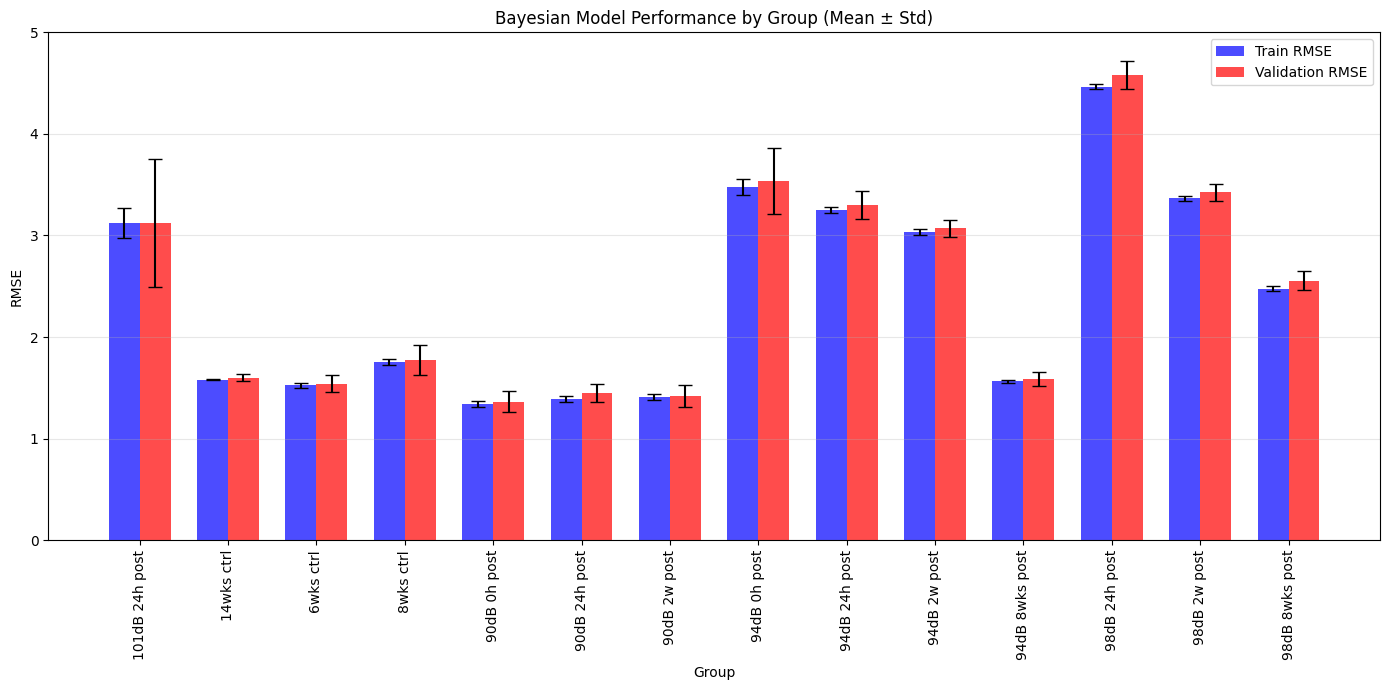

,Group,Train_RMSE_Mean,Val_RMSE_Mean,Train_RMSE_Std,Val_RMSE_Std
0,101dB 24h post,3.119421,3.126853,0.146399,0.629956
1,14wks ctrl,1.580112,1.601481,0.007146,0.033681
2,6wks ctrl,1.524127,1.541755,0.022432,0.084871
3,8wks ctrl,1.753859,1.774336,0.033266,0.143452
4,90dB 0h post,1.339973,1.362561,0.030145,0.104454
5,90dB 24h post,1.389640,1.446373,0.025611,0.090118
6,90dB 2w post,1.409413,1.418006,0.027452,0.110853
7,94dB 0h post,3.474609,3.536451,0.076982,0.328145
8,94dB 24h post,3.253965,3.297884,0.028364,0.138428
9,94dB 2w post,3.034689,3.070201,0.025987,0.085981


In [68]:
from sklearn.model_selection import KFold
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

thresh = 0
k_folds = KFold(n_splits=5, shuffle=True, random_state=42)
train_rmse_scores = []
val_rmse_scores = []
subjects_profiles_CVsplit_v8_5_20 = {}

# Groups setup
groups = [str(group) for group in np.unique(final_clean_strained_grouped_pos_cleangroup['Group'])]
group_train_rmse = {group: [] for group in groups}
group_val_rmse = {group: [] for group in groups}

for fold_idx, (train_idx, val_idx) in enumerate(k_folds.split(X_train8)):
    X_fold_train, X_fold_val = X_train8.iloc[train_idx], X_train8.iloc[val_idx]
    y_fold_train, y_fold_val = y1_train8.iloc[train_idx], y1_train8.iloc[val_idx]
    
    print(f"\nProcessing Fold {fold_idx+1}")
    
    # First, build the Bayesian profiles for each subject
    for subject in np.unique(X_fold_train['Subject']):
        profile_key = f"subject_{subject}"
        subjects_profiles_CVsplit_v8_5_20[profile_key] = BayesianProfile_v8_5(x5_categories=['CBA/CaJ', 'C57B6'])
        
        # Get all combinations of amp, vx, and strain for this subject
        subject_data = X_fold_train[X_fold_train['Subject'] == subject]
        
        for amp in np.unique(subject_data['Amplitude (x3)']):
            for strain in np.unique(subject_data['Strain (x5)']):
                for vx in np.unique(subject_data['vx (x4)']):
                    # Filter for this specific combination with 60dB threshold
                    record_X = subject_data[
                        (subject_data['Amplitude (x3)'] == amp) &
                        (subject_data['Strain (x5)'] == strain) &
                        (subject_data['vx (x4)'] == vx) &
                        (subject_data['Level(dB) (x2)'] >= thresh)
                    ]
                    
                    idx = record_X.index
                    
                    if len(idx) > 0:  # Make sure we have records
                        actual_values = y_fold_train.loc[idx]
                        
                        # Load each observation
                        for i, idx_val in enumerate(idx):
                            y1_val = float(actual_values.iloc[i])
                            subjects_profiles_CVsplit_v8_5_20[profile_key].add_observation_y1(
                                x3=amp, x5=strain, y1=y1_val
                            )
    
    # Now calculate RMSE for this fold (both training and validation)
    # Store predictions in a dictionary keyed by index
    train_predictions = {}
    
    for idx, row in X_fold_train.iterrows():
        if row['Level(dB) (x2)'] >= thresh:
            subject = row['Subject']
            profile_key = f"subject_{subject}"
            x3_val = row['Amplitude (x3)']
            x5_val = row['Strain (x5)']

            try:
                # Call predict_y1 with scalar values
                pred = subjects_profiles_CVsplit_v8_5_20[profile_key].predict_y1(x3=x3_val, x5=x5_val)
                train_predictions[idx] = float(pred)  # Ensure it's a scalar
            except Exception as e:
                # Just pass if prediction fails
                pass

    # Create pandas Series with predictions matched to proper indices
    successful_train_indices = list(train_predictions.keys())
    
    if successful_train_indices:
        y_train_true = y_fold_train.loc[successful_train_indices]
        y_train_pred = pd.Series([train_predictions[idx] for idx in successful_train_indices], 
                                index=successful_train_indices)
        
        # Do the same for validation
        val_predictions = {}
        
        for idx, row in X_fold_val.iterrows():
            if row['Level(dB) (x2)'] >= thresh:
                subject = row['Subject']
                profile_key = f"subject_{subject}"
                x3_val = row['Amplitude (x3)']
                x5_val = row['Strain (x5)']
            
                try:
                    # Call predict_y1 with scalar values
                    pred = subjects_profiles_CVsplit_v8_5_20[profile_key].predict_y1(x3=x3_val, x5=x5_val)
                    val_predictions[idx] = float(pred)  # Ensure it's a scalar
                except Exception as e:
                    # Just pass if prediction fails
                    pass
        
        # Create properly indexed validation predictions
        successful_val_indices = list(val_predictions.keys())
        
        if successful_val_indices:
            y_val_true = y_fold_val.loc[successful_val_indices]
            y_val_pred = pd.Series([val_predictions[idx] for idx in successful_val_indices], 
                               index=successful_val_indices)
            
            # Print basic information
            print(f"Train: {len(successful_train_indices)} successful predictions out of {len(X_fold_train)}")
            print(f"Validation: {len(successful_val_indices)} successful predictions out of {len(X_fold_val)}")
            
            # Calculate RMSE
            fold_train_rmse = np.sqrt(np.mean((y_train_true - y_train_pred)**2))
            train_rmse_scores.append(fold_train_rmse)
            
            fold_val_rmse = np.sqrt(np.mean((y_val_true - y_val_pred)**2))
            val_rmse_scores.append(fold_val_rmse)
            
            print(f"Fold {fold_idx+1}: Train RMSE = {fold_train_rmse:.4f}, Validation RMSE = {fold_val_rmse:.4f}")
            
            # Calculate group-specific RMSE
            for group in groups:
                # Get the subject groups
                train_subjects_df = final_clean_strained_grouped_pos_cleangroup.loc[successful_train_indices]
                val_subjects_df = final_clean_strained_grouped_pos_cleangroup.loc[successful_val_indices]
                
                # Filter for successful predictions for this group
                group_train_mask = train_subjects_df['Group'] == group
                if group_train_mask.any():
                    group_indices = group_train_mask[group_train_mask].index
                    group_rmse = np.sqrt(np.mean((y_train_true.loc[group_indices] - y_train_pred.loc[group_indices])**2))
                    group_train_rmse[group].append(group_rmse)
                
                group_val_mask = val_subjects_df['Group'] == group
                if group_val_mask.any():
                    group_indices = group_val_mask[group_val_mask].index
                    group_rmse = np.sqrt(np.mean((y_val_true.loc[group_indices] - y_val_pred.loc[group_indices])**2))
                    group_val_rmse[group].append(group_rmse)

        else:
            print(f"Fold {fold_idx+1}: No successful validation predictions")
    else:
        print(f"Fold {fold_idx+1}: No successful training predictions")

# Calculate average RMSE across all folds
if train_rmse_scores:
    avg_train_rmse = np.mean(train_rmse_scores)
    std_train_rmse = np.std(train_rmse_scores)
    print(f"\nAverage Train RMSE across folds: {avg_train_rmse:.4f} ± {std_train_rmse:.4f}")

if val_rmse_scores:
    avg_val_rmse = np.mean(val_rmse_scores)
    std_val_rmse = np.std(val_rmse_scores)
    print(f"Average Validation RMSE across folds: {avg_val_rmse:.4f} ± {std_val_rmse:.4f}")

# Calculate group-specific RMSE 
print("\nGroup-specific RMSE:")
print("Group | Train RMSE (Mean ± Std) | Validation RMSE (Mean ± Std)")
print("----- | ----------------------- | -----------------------------")
for group in groups:
    train_values = group_train_rmse[group]
    val_values = group_val_rmse[group]
    
    if train_values:
        train_mean = np.mean(train_values)
        train_std = np.std(train_values)
        train_str = f"{train_mean:.6f} ± {train_std:.6f}"
    else:
        train_str = "N/A"
        
    if val_values:
        val_mean = np.mean(val_values)
        val_std = np.std(val_values)
        val_str = f"{val_mean:.6f} ± {val_std:.6f}"
    else:
        val_str = "N/A"
        
    print(f"{group:15s} | {train_str:25s} | {val_str:25s}")

# Visualization of group-specific RMSE
if any(group_train_rmse[group] for group in groups) and any(group_val_rmse[group] for group in groups):
    # Prepare data for plotting
    plot_groups = []
    plot_train_rmse = []
    plot_val_rmse = []
    plot_train_std = []
    plot_val_std = []
    
    for group in groups:
        if group_train_rmse[group] and group_val_rmse[group]:
            plot_groups.append(group)
            plot_train_rmse.append(np.mean(group_train_rmse[group]))
            plot_val_rmse.append(np.mean(group_val_rmse[group]))
            plot_train_std.append(np.std(group_train_rmse[group]))
            plot_val_std.append(np.std(group_val_rmse[group]))
    
    # Create plot if we have data
    if plot_groups:
        plt.figure(figsize=(14, 7))
        x = np.arange(len(plot_groups))
        width = 0.35
        
        plt.bar(x - width/2, plot_train_rmse, width, yerr=plot_train_std, 
                label='Train RMSE', color='blue', alpha=0.7, capsize=5)
        plt.bar(x + width/2, plot_val_rmse, width, yerr=plot_val_std,
                label='Validation RMSE', color='red', alpha=0.7, capsize=5)
        
        plt.xlabel('Group')
        plt.ylabel('RMSE')
        plt.ylim((0,5))
        plt.title('Bayesian Model Performance by Group (Mean ± Std)')
        plt.xticks(x, plot_groups, rotation=90)
        plt.legend()
        plt.grid(True, axis='y', alpha=0.3)
        plt.tight_layout()
        plt.show()

groups_list = []
train_mean_list = []
train_std_list = []
val_mean_list = []
val_std_list = []

# Extract values for each group
for group in sorted(group_train_rmse.keys()):
    train_values = group_train_rmse[group]
    val_values = group_val_rmse[group]
    
    groups_list.append(group)
    
    if train_values:
        train_mean_list.append(np.mean(train_values))
        train_std_list.append(np.std(train_values))
    else:
        train_mean_list.append(np.nan)
        train_std_list.append(np.nan)
        
    if val_values:
        val_mean_list.append(np.mean(val_values))
        val_std_list.append(np.std(val_values))
    else:
        val_mean_list.append(np.nan)
        val_std_list.append(np.nan)


# Create lists to store the data
groups_list = []
train_mean_list = []
train_std_list = []
val_mean_list = []
val_std_list = []

# Extract values for each group
for group in sorted(group_train_rmse.keys()):
    train_values = group_train_rmse[group]
    val_values = group_val_rmse[group]
    
    groups_list.append(group)
    
    if train_values:
        train_mean_list.append(np.mean(train_values))
        train_std_list.append(np.std(train_values))
    else:
        train_mean_list.append(np.nan)
        train_std_list.append(np.nan)
        
    if val_values:
        val_mean_list.append(np.mean(val_values))
        val_std_list.append(np.std(val_values))
    else:
        val_mean_list.append(np.nan)
        val_std_list.append(np.nan)

# Create DataFrame
group_metrics_df = pd.DataFrame({
    'Group': groups_list,
    'Train_RMSE_Mean': train_mean_list,
    'Val_RMSE_Mean': val_mean_list,
    'Train_RMSE_Std': train_std_list,
    'Val_RMSE_Std': val_std_list
})

# Display the DataFrame
group_metrics_df

Intercept (first position)

Coefficient for x3 (Amplitude)

Coefficient for first x5 category (CBA/CaJ)

Coefficient for second x5 category (C57B6)

Interaction between x3 and first x5 category

Interaction between x3 and second x5 category

In [66]:
means = np.zeros_like(subjects_profiles_CVsplit_v8_5_20['subject_WPZ100'].mean_y1)

for sub in subjects_profiles_CVsplit_v8_5_20:
    coeffs = subjects_profiles_CVsplit_v8_5_20[sub].mean_y1
    means += coeffs

means /= len(subjects_profiles_CVsplit_v8_5_20)
means

array([7.27335529, 0.66196983, 6.28906777, 0.98428752, 0.52491835,
       0.13705148])

Averages!!!!!

## v8.75: v8.5 with MM scaling

In [55]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

class BayesianProfile_v8_75:
    def __init__(self, training_data=None, prior_mean_y1=None, prior_cov_y1=None, 
                 x5_categories=['CBA/CaJ', 'C57B6']):
        """
        Initialize a Bayesian profile with static scaling
        
        Parameters:
        training_data: DataFrame with initial data to fit scalers
        prior_mean: Initial guess for parameters (default: zeros)
        prior_cov: Initial uncertainty in parameters (default: identity matrix)
        """
        # For 6 parameters: intercept, x3, x5 (one-hot), interactions
        self.n_params = 6
        
        # Initialize priors
        if prior_mean_y1 is None:
            self.mean_y1 = np.zeros(self.n_params)
        else:
            self.mean_y1 = prior_mean_y1
            
        if prior_cov_y1 is None:
            self.cov_y1 = np.eye(self.n_params) * 10  # Start with high uncertainty
        else:
            self.cov_y1 = prior_cov_y1

        # Keep track of all data points
        self.X_history = []
        self.y1_history = []
        
        # For tracking prediction performance
        self.rmse_history_y1 = []

        self.x5_categories = x5_categories
        
        # Initialize scalers
        self.x3_scaler = MinMaxScaler()
        self.y1_scaler = MinMaxScaler()
        
        # Initialize scaling flag
        self.scaling_applied = False
        
        # Fit scalers if training data is provided
        if training_data is not None:
            self._initialize_scalers(training_data)

    def _initialize_scalers(self, data):
        """
        Initialize scalers with training data
        """
        if 'Amplitude (x3)' in data.columns and 'Synapses to IHC (y1)' in data.columns:
            # Fit scalers to all training data once
            self.x3_scaler.fit(data['Amplitude (x3)'].values.reshape(-1, 1))
            self.y1_scaler.fit(data['Synapses to IHC (y1)'].values.reshape(-1, 1))
            self.scaling_applied = True
            print(f"Scalers initialized with {len(data)} records")
        else:
            print("Warning: Training data missing required columns for scaling")
            
    def encode_x5(self, x5):
        """
        Encode categorical x5 value using one-hot encoding
        """
        if isinstance(x5, pd.Series):
            x5 = x5.iloc[0]  # Take first value if it's a series
        
        # Create one-hot encoding
        encoding = np.zeros(len(self.x5_categories))
        if x5 in self.x5_categories:
            encoding[self.x5_categories.index(x5)] = 1
        else:
            # Fallback: use first category if strain not found
            print(f"Warning: Strain '{x5}' not in categories {self.x5_categories}, using fallback")
            encoding[0] = 1  # Default to first category
            
        return encoding
    
    def _scale_x3(self, x3):
        """
        Scale x3 using the fitted scaler
        """
        if not self.scaling_applied:
            return x3  # Return as is if scaler not fit
        
        x3_array = np.array([float(x3)]).reshape(-1, 1)
        return self.x3_scaler.transform(x3_array)[0][0]
    
    def _scale_y1(self, y1):
        """
        Scale y1 using the fitted scaler
        """
        if not self.scaling_applied:
            return y1  # Return as is if scaler not fit
        
        y1_array = np.array([float(y1)]).reshape(-1, 1)
        return self.y1_scaler.transform(y1_array)[0][0]
    
    def _inverse_scale_y1(self, y1_scaled):
        """
        Convert scaled y1 back to original scale
        """
        if not self.scaling_applied:
            return y1_scaled  # Return as is if scaler not fit
        
        y1_array = np.array([float(y1_scaled)]).reshape(-1, 1)
        return self.y1_scaler.inverse_transform(y1_array)[0][0]
        
    def add_observation_y1(self, x3, x5, y1, noise_var=1.0, prior_mean_y1=None, prior_cov_y1=None):
        """
        Update the profile with a new observation using static scaling
        """
        # Store original values for reference
        self.raw_x3 = float(x3)
        self.raw_y1 = float(y1)
        
        # Apply scaling if enabled
        x3_scaled = self._scale_x3(x3)
        y1_scaled = self._scale_y1(y1)
        
        # Reshape for processing
        x3_scaled = np.asarray(x3_scaled).reshape(1, -1)
        x5_encoded = self.encode_x5(x5).reshape(1, -1)
        
        # Create arrays to stack with correct shapes
        arrays_to_stack = [
            np.ones(1).reshape(1, -1),        
            x3_scaled,
            x5_encoded,
            x3_scaled.T @ x5_encoded                        
        ]

        X = np.hstack(arrays_to_stack)
        self.X_history.append(X[0])
        self.y1_history.append(float(y1_scaled))
        
        # Numerical stability in matrix inversion
        try:
            # Add small regularization for numerical stability
            K = self.cov_y1 @ X.T @ np.linalg.inv(X @ self.cov_y1 @ X.T + noise_var + 1e-8 * np.eye(X.shape[0]))
            
            innovation = y1_scaled - float(X @ self.mean_y1)
            self.mean_y1 = self.mean_y1 + (K.flatten() * innovation)
            self.cov_y1 = self.cov_y1 - (K @ X @ self.cov_y1)
        except np.linalg.LinAlgError as e:
            print(f"Matrix inversion error: {e}")
            # Don't update parameters in case of error
            return
        
        # RMSE calculation - simpler than the dynamic version
        try:
            predictions = []
            for i, x_hist in enumerate(self.X_history):
                # Extract features from history
                hist_x3 = x_hist[1]
                
                # Find which strain was used (get index of 1 in one-hot encoding)
                strain_indices = [j for j in range(len(self.x5_categories)) if x_hist[2+j] == 1]
                if strain_indices:
                    hist_strain = self.x5_categories[strain_indices[0]]
                else:
                    hist_strain = self.x5_categories[0]  # fallback
                    
                # Try to predict in scaled space
                try:
                    # Create prediction input
                    arrays_to_stack = [
                        np.ones(1),
                        np.array([hist_x3]),
                        self.encode_x5(hist_strain),
                        np.array([hist_x3]) * self.encode_x5(hist_strain)
                    ]
                    X_pred = np.hstack(arrays_to_stack)
                    
                    # Get prediction in scaled space
                    scaled_pred = X_pred @ self.mean_y1
                    if np.isfinite(scaled_pred):
                        predictions.append(scaled_pred)
                    else:
                        predictions.append(self.y1_history[i])
                except:
                    predictions.append(self.y1_history[i])
                    
            # Calculate RMSE in scaled space (consistent with how the model is trained)
            if predictions:
                rmse = np.sqrt(np.mean((np.array(self.y1_history) - np.array(predictions))**2))
                if np.isfinite(rmse):
                    self.rmse_history_y1.append(rmse)
                else:
                    # If we got an invalid RMSE, append the last valid one or 0
                    if self.rmse_history_y1:
                        self.rmse_history_y1.append(self.rmse_history_y1[-1])
                    else:
                        self.rmse_history_y1.append(0.0)
        except Exception as e:
            print(f"Error calculating RMSE: {e}")
            # Append last RMSE or 0 if none exists
            if self.rmse_history_y1:
                self.rmse_history_y1.append(self.rmse_history_y1[-1])
            else:
                self.rmse_history_y1.append(0.0)
    
    def predict_y1(self, x3, x5):
        """
        Make a prediction for given input values with static scaling
        
        Parameters:
        x3: Input feature (will be scaled if scaling is enabled)
        x5: Categorical feature
        
        Returns:
        float: Predicted value (in original scale)
        """
        # Apply scaling if enabled
        x3_scaled = self._scale_x3(x3)
        
        # Reshape and encode
        x3_scaled = np.asarray(x3_scaled).reshape(1, -1)
        x5_encoded = self.encode_x5(x5).reshape(1, -1)
        
        # Create arrays to stack with correct shapes
        arrays_to_stack = [
            np.ones(1).reshape(1, -1),
            x3_scaled,
            x5_encoded,
            x3_scaled.T @ x5_encoded,
        ]

        X = np.hstack(arrays_to_stack)
        
        # Get prediction
        y1_scaled_pred = float(X @ self.mean_y1)
        
        # Check if prediction is valid
        if not np.isfinite(y1_scaled_pred):
            print(f"Warning: Non-finite prediction: {y1_scaled_pred}")
            return None
            
        # Convert back to original scale if scaling was applied
        return self._inverse_scale_y1(y1_scaled_pred)
    
    def predict_with_uncertainty_y1(self, x3, x5):
        """
        Make a prediction with uncertainty bounds
        
        Returns:
        tuple: (prediction, standard_deviation)
        """
        # Apply scaling if enabled
        x3_scaled = self._scale_x3(x3)
        
        # Reshape and encode
        x3_scaled = np.asarray(x3_scaled).reshape(1, -1)
        x5_encoded = self.encode_x5(x5).reshape(1, -1)
        
        # Create arrays to stack with correct shapes
        arrays_to_stack = [
            np.ones(1).reshape(1, -1),
            x3_scaled,
            x5_encoded,
            x3_scaled.T @ x5_encoded,
        ]
        
        X = np.hstack(arrays_to_stack)
        
        # Predict
        pred_scaled = float(X @ self.mean_y1)
        std_scaled = float(np.sqrt(X @ self.cov_y1 @ X.T))
        
        # Check for valid values
        if not np.isfinite(pred_scaled) or not np.isfinite(std_scaled):
            print(f"Warning: Non-finite prediction or std: {pred_scaled}, {std_scaled}")
            return None, None
        
        # Transform back to original scale
        pred = self._inverse_scale_y1(pred_scaled)
        
        # Adjust standard deviation to match original scale
        if self.scaling_applied:
            std = std_scaled * self.y1_scaler.scale_[0]
        else:
            std = std_scaled
            
        return pred, std
    
    def plot_learning_curve_y1(self):
        """Plot how RMSE changes as more observations are added"""
        plt.figure(figsize=(10, 6))
        plt.plot(self.rmse_history_y1, '-o')
        plt.xlabel('Number of Observations')
        plt.ylabel('RMSE')
        plt.title('Learning Curve - Average Synapses to IHC Prediction')
        plt.grid(True, alpha=0.3)
        return plt.gcf()

# Example usage:
"""
# Initialize with training data for scaling
initial_data = X_train8  # Your training data
profile = BayesianProfile_v8_static(
    training_data=pd.concat([initial_data, y1_train8], axis=1),
    x5_categories=list(np.unique(initial_data['Strain (x5)']))
)

# Now you can use add_observation_y1 and predict_y1 as before
"""

"\n# Initialize with training data for scaling\ninitial_data = X_train8  # Your training data\nprofile = BayesianProfile_v8_static(\n    training_data=pd.concat([initial_data, y1_train8], axis=1),\n    x5_categories=list(np.unique(initial_data['Strain (x5)']))\n)\n\n# Now you can use add_observation_y1 and predict_y1 as before\n"


Average Train RMSE across folds: 2.4340
Average Validation RMSE across folds: 2.2315

Level-specific RMSE:
Level | Train RMSE | Validation RMSE
----- | ---------- | ---------------
   10 | 2.316982   | 2.348378       
   20 | 2.164356   | 2.090737       
   30 | 2.350321   | 2.220922       
   40 | 2.306273   | 2.109915       
   50 | 2.252544   | 1.974091       
   60 | 2.256277   | 1.944898       
   70 | 2.515203   | 2.174058       


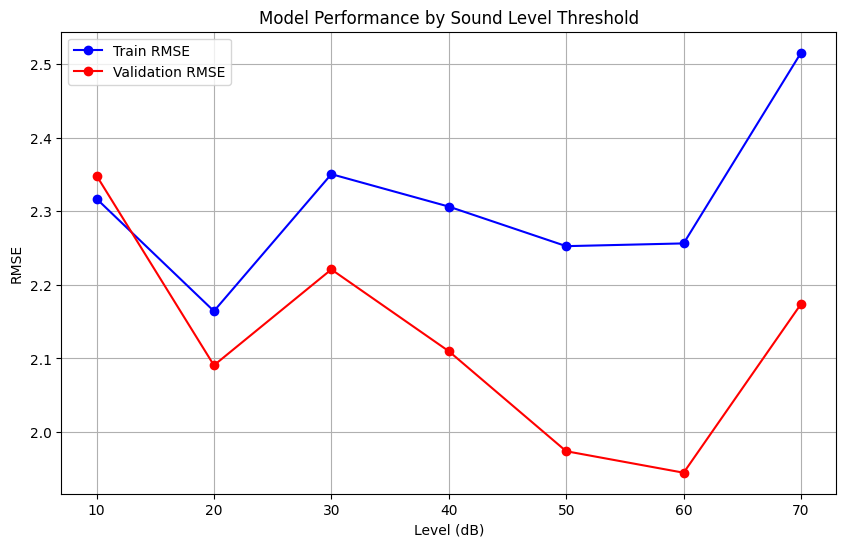


Group-specific RMSE:
Group | Train RMSE | Validation RMSE
----- | ---------- | ---------------
101dB 24h post | 2.433316   | 2.433316       
14wks ctrl | 2.433316   | 2.433316       
14wks ctrl  | 2.433316   | 2.433316       
6wks ctrl | 2.433316   | 2.433316       
8wks ctrl | 2.433316   | 2.433316       
90dB 0h post | 2.433316   | 2.433316       
90dB 24h post | 2.433316   | 2.433316       
90dB 2w post | 2.433316   | 2.433316       
94dB 0h post | 2.433316   | 2.433316       
94dB 0h post  | 2.448169   | 2.448169       
94dB 24h post | 2.433316   | 2.433316       
94dB 2w post | 2.433316   | 2.433316       
94dB 8wks post | 2.433316   | 2.433316       
98dB 24h post | 2.433316   | 2.433316       
98dB 2w post | 2.433316   | 2.433316       
98dB 8wks post | 2.433316   | 2.433316       


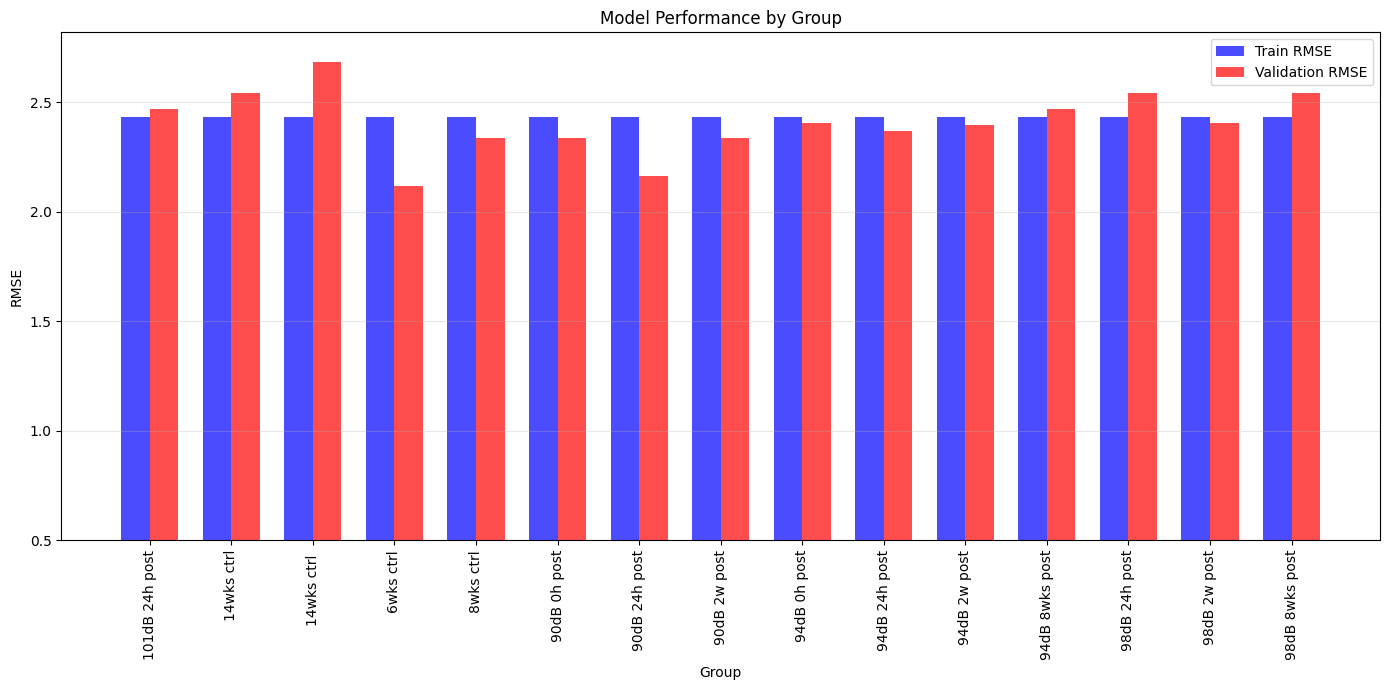

In [61]:
# k_folds = KFold(n_splits=5)
# train_rmse_scores = []
# val_rmse_scores = []
# subjects_profiles_CVsplit_v8_75MM = {}

# levels = [10, 20, 30, 40, 50, 60, 70]
# level_train_rmse = {level: [] for level in levels}
# level_val_rmse = {level: [] for level in levels}

# # groups = np.unique(final_clean_strained_grouped_pos['Group'])
# groups = [str(group) for group in np.unique(final_clean_strained_grouped_pos['Group'])]
# group_train_rmse = {group: [] for group in groups}
# group_val_rmse = {group: [] for group in groups}

# for fold_idx, (train_idx, val_idx) in enumerate(k_folds.split(X_train8)):
#     X_fold_train, X_fold_val = X_train8.iloc[train_idx], X_train8.iloc[val_idx]
#     y_fold_train, y_fold_val = y1_train8.iloc[train_idx], y1_train8.iloc[val_idx]
    
#     print(f"\nProcessing Fold {fold_idx+1}")
    
#     # First, build the Bayesian profiles for each subject
#     for subject in np.unique(X_fold_train['Subject']):
#         profile_key = f"subject_{subject}"
#         subjects_profiles_CVsplit_v8_75MM[profile_key] = BayesianProfile_v8_75(x5_categories=list(np.unique(X_fold_train['Strain (x5)'])))
        
#         # Get all combinations of amp, vx, and strain for this subject
#         subject_data = X_fold_train[X_fold_train['Subject'] == subject]
        
#         for amp in np.unique(subject_data['Amplitude (x3)']):
#             for lvl in levels:
#                 for strain in np.unique(subject_data['Strain (x5)']):
#                     for vx in np.unique(subject_data['vx (x4)']):
#                         # Filter for this specific combination
#                         record_X = subject_data[
#                             (subject_data['Amplitude (x3)'] == amp) &
#                             (subject_data['Strain (x5)'] == strain) &
#                             (subject_data['vx (x4)'] == vx) &
#                             (subject_data['Level(dB) (x2)'] >= lvl)
#                         ]
                        
#                         idx = record_X.index
                        
#                         if len(idx) > 0:  # Make sure we have records
#                             actual_values = y_fold_train.loc[idx]
                            
#                             # Load each observation
#                             for i, idx_val in enumerate(idx):
#                                 y1_val = float(actual_values.iloc[i])
#                                 subjects_profiles_CVsplit_v8_75MM[profile_key].add_observation_y1(
#                                     x3=amp, x5=strain, y1=y1_val
#                                 )
#                                 print(f"subject={subject}, amp={amp}, strain={strain}, vx={vx}, y1={y1_val} - loaded")
    
#     # Now calculate RMSE for this fold (both training and validation)
#     # Store predictions in a dictionary keyed by index
#     train_predictions = {}
    
#     for idx, row in X_fold_train.iterrows():
#         subject = row['Subject']
#         profile_key = f"subject_{subject}"
#         x3_val = row['Amplitude (x3)']
#         x5_val = row['Strain (x5)']
#         # Note: vx is not used in the predict_y1 method

#         try:
#             # Call predict_y1 with scalar values
#             pred = subjects_profiles_CVsplit_v8_75MM[profile_key].predict_y1(x3=x3_val, x5=x5_val)
#             train_predictions[idx] = float(pred)  # Ensure it's a scalar
#         except Exception as e:
#             print(f"Error predicting for row {idx}, subject {subject}: {e}") 

#     # Create pandas Series with predictions matched to proper indices
#     successful_train_indices = list(train_predictions.keys())
    
#     if successful_train_indices:
#         y_train_true = y_fold_train.loc[successful_train_indices]
#         y_train_pred = pd.Series([train_predictions[idx] for idx in successful_train_indices], 
#                                 index=successful_train_indices)
        
#         # Do the same for validation
#         val_predictions = {}
        
#         for idx, row in X_fold_val.iterrows():
#             subject = row['Subject']
#             profile_key = f"subject_{subject}"
#             x3_val = row['Amplitude (x3)']
#             x5_val = row['Strain (x5)']
            
#             try:
#                 # Call predict_y1 with scalar values
#                 pred = subjects_profiles_CVsplit_v8_75MM[profile_key].predict_y1(x3=x3_val, x5=x5_val)
#                 val_predictions[idx] = float(pred)  # Ensure it's a scalar
#             except Exception as e:
#                 print(f"Error predicting for row {idx}, subject {subject}: {e}")
        
#         # Create properly indexed validation predictions
#         successful_val_indices = list(val_predictions.keys())
        
#         if successful_val_indices:
#             y_val_true = y_fold_val.loc[successful_val_indices]
#             y_val_pred = pd.Series([val_predictions[idx] for idx in successful_val_indices], 
#                                index=successful_val_indices)
            
#             # Print diagnostic information
#             print(f"Train: {len(successful_train_indices)} successful predictions out of {len(X_fold_train)}")
#             print(f"Validation: {len(successful_val_indices)} successful predictions out of {len(X_fold_val)}")
            
#             # Calculate RMSE
#             fold_train_rmse = np.sqrt(np.mean((y_train_true - y_train_pred)**2))
#             train_rmse_scores.append(fold_train_rmse)
            
#             fold_val_rmse = np.sqrt(np.mean((y_val_true - y_val_pred)**2))
#             val_rmse_scores.append(fold_val_rmse)
            
#             print(f"Fold {fold_idx+1}: Train RMSE = {fold_train_rmse:.4f}, Validation RMSE = {fold_val_rmse:.4f}")
            
#             # Calculate level-specific RMSE
#             for level in levels:
#                 # Filter for successful predictions at this level
#                 level_train_mask = X_fold_train.loc[successful_train_indices, 'Level(dB) (x2)'] == level
#                 if level_train_mask.any():
#                     level_indices = level_train_mask[level_train_mask].index
#                     level_rmse = np.sqrt(np.mean((y_train_true.loc[level_indices] - y_train_pred.loc[level_indices])**2))
#                     level_train_rmse[level].append(level_rmse)
                
#                 level_val_mask = X_fold_val.loc[successful_val_indices, 'Level(dB) (x2)'] == level
#                 if level_val_mask.any():
#                     level_indices = level_val_mask[level_val_mask].index
#                     level_rmse = np.sqrt(np.mean((y_val_true.loc[level_indices] - y_val_pred.loc[level_indices])**2))
#                     level_val_rmse[level].append(level_rmse)

#             for group in groups:
#                 # Get the subject groups
#                 train_subjects_df = final_clean_strained_grouped_pos.loc[successful_train_indices]
#                 val_subjects_df = final_clean_strained_grouped_pos.loc[successful_val_indices]
                
#                 # Filter for successful predictions for this group
#                 group_train_mask = train_subjects_df['Group'] == group
#                 if group_train_mask.any():
#                     group_indices = group_train_mask.index
#                     group_rmse = np.sqrt(np.mean((y_train_true.loc[group_indices] - y_train_pred.loc[group_indices])**2))
#                     group_train_rmse[group].append(group_rmse)
                
#                 group_val_mask = val_subjects_df['Group'] == group
#                 if group_val_mask.any():
#                     group_indices = group_val_mask.index
#                     group_rmse = np.sqrt(np.mean((y_val_true.loc[group_indices] - y_val_pred.loc[group_indices])**2))
#                     group_val_rmse[group].append(group_rmse)


#         else:
#             print(f"Fold {fold_idx+1}: No successful validation predictions")
#     else:
#         print(f"Fold {fold_idx+1}: No successful training predictions")

# Calculate average RMSE across all folds
if train_rmse_scores:
    avg_train_rmse = np.mean(train_rmse_scores)
    print(f"\nAverage Train RMSE across folds: {avg_train_rmse:.4f}")

if val_rmse_scores:
    avg_val_rmse = np.mean(val_rmse_scores)
    print(f"Average Validation RMSE across folds: {avg_val_rmse:.4f}")

# Print level-specific RMSE
print("\nLevel-specific RMSE:")
print("Level | Train RMSE | Validation RMSE")
print("----- | ---------- | ---------------")
for level in levels:
    train_str = f"{np.mean(level_train_rmse[level]):.6f}" if level_train_rmse[level] else "N/A"
    val_str = f"{np.mean(level_val_rmse[level]):.6f}" if level_val_rmse[level] else "N/A"
    print(f"{level:5d} | {train_str:10s} | {val_str:15s}")

# Visualization code
if any(level_train_rmse[level] for level in levels) and any(level_val_rmse[level] for level in levels):
    import matplotlib.pyplot as plt
    
    # Prepare data for plotting
    plot_levels = []
    plot_train_rmse = []
    plot_val_rmse = []
    
    for level in levels:
        if level_train_rmse[level] and level_val_rmse[level]:
            plot_levels.append(level)
            plot_train_rmse.append(np.mean(level_train_rmse[level]))
            plot_val_rmse.append(np.mean(level_val_rmse[level]))
    
    # Create plot if we have data
    if plot_levels:
        plt.figure(figsize=(10, 6))
        plt.plot(plot_levels, plot_train_rmse, 'b-o', label='Train RMSE')
        plt.plot(plot_levels, plot_val_rmse, 'r-o', label='Validation RMSE')
        plt.xlabel('Level (dB)')
        plt.ylabel('RMSE')
        plt.title('Model Performance by Sound Level Threshold')
        plt.legend()
        plt.grid(True)
        # plt.savefig('rmse_by_level.png')
        plt.show()



# groups = np.unique(final_clean_strained_grouped_pos['Group'])groups = [str(group) for group in np.unique(final_clean_strained_grouped_pos['Group'])]
print("\nGroup-specific RMSE:")
print("Group | Train RMSE | Validation RMSE")
print("----- | ---------- | ---------------")
for group in groups:
    train_str = f"{np.mean(group_train_rmse[group]):.6f}" if group_train_rmse[group] else "N/A"
    val_str = f"{np.mean(group_train_rmse[group]):.6f}" if group_train_rmse[group] else "N/A"
    print(f"{group} | {train_str:10s} | {val_str:15s}")

if any(group_train_rmse[group] for group in groups) and any(group_val_rmse[group] for group in groups):
    import matplotlib.pyplot as plt
    
    # Prepare data for plotting
    plot_groups = []
    plot_train_rmse = []
    plot_val_rmse = []
    
    for group in groups:
        if group_train_rmse[group] and group_val_rmse[group]:
            plot_groups.append(group)
            plot_train_rmse.append(np.mean(group_train_rmse[group]))
            plot_val_rmse.append(np.mean(group_val_rmse[group]))
    
    # Create plot if we have data
    if plot_groups:
        plt.figure(figsize=(14, 7))
        x = np.arange(len(plot_groups))
        width = 0.35
        
        plt.bar(x - width/2, plot_train_rmse, width, label='Train RMSE', color='blue', alpha=0.7)
        plt.bar(x + width/2, plot_val_rmse, width, label='Validation RMSE', color='red', alpha=0.7)
        
        plt.xlabel('Group')
        plt.ylabel('RMSE')
        plt.ylim((0.5))
        plt.title('Model Performance by Group')
        plt.xticks(x, plot_groups, rotation=90)
        plt.legend()
        plt.grid(True, axis='y', alpha=0.3)
        plt.tight_layout()
        # plt.savefig('rmse_by_group.png')
        plt.show()

## v9: amplitude, strain, groups, freq, group by dB, group by time elapsed - TBD

In [687]:
# WIP!!!! Needs freq, amp, strain, exposure, hours post-exposure time

import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler

class BayesianProfile_v9:
    def __init__(self, training_data=None, prior_mean_y1=None, prior_cov_y1=None, 
                 x5_categories=['CBA/CaJ', 'C57B6']):
        """
        Initialize a Bayesian profile with static scaling
        
        Parameters:
        training_data: DataFrame with initial data to fit scalers
        prior_mean: Initial guess for parameters (default: zeros)
        prior_cov: Initial uncertainty in parameters (default: identity matrix)
        """
        # For 48 parameters: intercept, x1, x3, x5 (one-hot), x6, x7, interactions
        self.n_params = 7 #  Just no interactions because it's good without
        
        # Initialize priors
        if prior_mean_y1 is None:
            self.mean_y1 = np.zeros(self.n_params)
        else:
            self.mean_y1 = prior_mean_y1
            
        if prior_cov_y1 is None:
            self.cov_y1 = np.eye(self.n_params) * 10  # Start with high uncertainty
        else:
            self.cov_y1 = prior_cov_y1

        # Keep track of all data points
        self.X_history = []
        self.y1_history = []
        
        # For tracking prediction performance
        self.rmse_history_y1 = []

        self.x5_categories = x5_categories
        
        # Initialize scalers
        self.x1_scaler = StandardScaler()
        self.x3_scaler = StandardScaler()
        self.x6_scaler = StandardScaler()
        self.x7_scaler = StandardScaler()
        # self.y1_scaler = StandardScaler()
        
        # Initialize scaling flag
        self.scaling_applied = False
        
        # Fit scalers if training data is provided
        if training_data is not None:
            self._initialize_scalers(training_data)

    def _initialize_scalers(self, data):
        """
        Initialize scalers with training data
        """
        if 'Freq(kHz) (x1)' in data.columns and 'Amplitude (x3)' in data.columns and 'Group - dB (x6)' in data.columns and 'Group - Hours Elapsed (x7)' in data.columns and 'Synapses to IHC (y1)' in data.columns:
            # Fit scalers to all training data once
            self.x1_scaler.fit(data['Freq(kHz) (x1)'].values.reshape(-1,1))
            self.x3_scaler.fit(data['Amplitude (x3)'].values.reshape(-1, 1))
            self.x6_scaler.fit(data['Group - dB (x6)'].values.reshape(-1, 1))
            self.x7_scaler.fit(data['Group - Hours Elapsed (x7)'].values.reshape(-1, 1))
            # self.y1_scaler.fit(data['Synapses to IHC (y1)'].values.reshape(-1, 1))
            self.scaling_applied = True
            print(f"Scalers initialized with {len(data)} records")
        else:
            print("Warning: Training data missing required columns for scaling")
            
    def encode_x5(self, x5):
        """
        Encode categorical x5 value using one-hot encoding
        """
        if isinstance(x5, pd.Series):
            x5 = x5.iloc[0]  # Take first value if it's a series
        
        # Create one-hot encoding
        encoding = np.zeros(len(self.x5_categories))
        if x5 in self.x5_categories:
            encoding[self.x5_categories.index(x5)] = 1
        else:
            # Fallback: use first category if strain not found
            print(f"Warning: Strain '{x5}' not in categories {self.x5_categories}, using fallback")
            encoding[0] = 1  # Default to strain with more stable hearing throughout the lifetime until end of life (typical control mouse strain)
            
        return encoding

    def _scale_x1(self, x1):
        """
        Scale x3 using the fitted scaler
        """
        if not self.scaling_applied:
            return x1  # Return as is if scaler not fit
        
        x1_array = np.array([float(x1)]).reshape(-1, 1)
        return self.x1_scaler.transform(x1_array)[0][0]

    def _scale_x3(self, x3):
        """
        Scale x3 using the fitted scaler
        """
        if not self.scaling_applied:
            return x3  # Return as is if scaler not fit
        
        x3_array = np.array([float(x3)]).reshape(-1, 1)
        return self.x3_scaler.transform(x3_array)[0][0]
    
    def _scale_x6(self, x6):
        """
        Scale x3 using the fitted scaler
        """
        if not self.scaling_applied:
            return x6  # Return as is if scaler not fit
        
        x6_array = np.array([float(x6)]).reshape(-1, 1)
        return self.x6_scaler.transform(x6_array)[0][0]
    
    def _scale_x7(self, x7):
        """
        Scale x3 using the fitted scaler
        """
        if not self.scaling_applied:
            return x7  # Return as is if scaler not fit
        
        x7_array = np.array([float(x7)]).reshape(-1, 1)
        return self.x7_scaler.transform(x7_array)[0][0]
    
    # def _scale_y1(self, y1):
    #     """
    #     Scale y1 using the fitted scaler
    #     """
    #     if not self.scaling_applied:
    #         return y1  # Return as is if scaler not fit
        
    #     y1_array = np.array([float(y1)]).reshape(-1, 1)
    #     return self.y1_scaler.transform(y1_array)[0][0]
    
    # def _inverse_scale_y1(self, y1_scaled):
    #     """
    #     Convert scaled y1 back to original scale
    #     """
    #     if not self.scaling_applied:
    #         return y1_scaled  # Return as is if scaler not fit
        
    #     y1_array = np.array([float(y1_scaled)]).reshape(-1, 1)
    #     return self.y1_scaler.inverse_transform(y1_array)[0][0]
        
    def add_observation_y1(self, x1, x3, x5, x6, x7, y1, noise_var=1.0, prior_mean_y1=None, prior_cov_y1=None):
        """
        Update the profile with a new observation using static scaling
        """
        # Store original values for reference
        self.raw_x1 = float(x1)
        self.raw_x3 = float(x3)
        self.raw_x6 = float(x6)
        self.raw_x7 = float(x7)
        self.raw_y1 = float(y1)
        
        # Apply scaling if enabled
        x1_scaled = self._scale_x1(x1)
        x3_scaled = self._scale_x3(x3)
        x6_scaled = self._scale_x6(x6)
        x7_scaled = self._scale_x7(x7)
        # y1_scaled = self._scale_y1(y1)
        
        # Reshape for processing
        x1_scaled = np.asarray(x1_scaled).reshape(1, -1)
        x3_scaled = np.asarray(x3_scaled).reshape(1, -1)
        x6_scaled = np.asarray(x6_scaled).reshape(1, -1)
        x7_scaled = np.asarray(x7_scaled).reshape(1, -1)
        x5_encoded = self.encode_x5(x5).reshape(1, -1)
        
        # Create arrays to stack with correct shapes
        arrays_to_stack = [
            np.ones(1).reshape(1, -1),        
            x1_scaled,
            x3_scaled,
            x5_encoded,
            x6_scaled,
            x7_scaled,
            # x1_scaled.T @ x3_scaled,
            # (x1_scaled * x5_encoded).reshape(1, -1),
            # (x1_scaled * x6_scaled),
            # (x1_scaled * x7_scaled),
            # x3_scaled.T @ x5_encoded,
            # (x3_scaled * x6_scaled),
            # (x3_scaled * x7_scaled),
            # (x5_encoded.reshape(-1, 1) * x6_scaled.reshape(1, -1)).reshape(1, -1),
            # (x5_encoded.reshape(-1, 1) * x7_scaled.reshape(1, -1)).reshape(1, -1),
            # (x6_scaled * x7_scaled),
            # (x1_scaled * x3_scaled * x5_encoded).reshape(1, -1),
            # (x1_scaled * x3_scaled * x6_scaled),
            # (x1_scaled * x3_scaled * x7_scaled),
            # (x1_scaled * x5_encoded * x6_scaled.reshape(-1, 1)).reshape(1, -1),
            # (x1_scaled * x5_encoded * x7_scaled.reshape(-1, 1)).reshape(1, -1),
            # (x1_scaled * x6_scaled * x7_scaled),
            # (x3_scaled * x5_encoded * x6_scaled.reshape(-1, 1)).reshape(1, -1),
            # (x3_scaled * x5_encoded * x7_scaled.reshape(-1, 1)).reshape(1, -1),
            # (x3_scaled * x6_scaled * x7_scaled),
            # (x5_encoded.reshape(-1, 1) * x6_scaled * x7_scaled).reshape(1, -1),
            # (x1_scaled * x3_scaled * x5_encoded * x6_scaled.reshape(-1, 1)).reshape(1, -1),
            # (x1_scaled * x3_scaled * x5_encoded * x7_scaled.reshape(-1, 1)).reshape(1, -1),
            # (x1_scaled * x3_scaled * x6_scaled * x7_scaled),
            # (x1_scaled * x5_encoded.reshape(-1, 1) * x6_scaled * x7_scaled).reshape(1, -1),
            # (x3_scaled * x5_encoded.reshape(-1, 1) * x6_scaled * x7_scaled).reshape(1, -1),
            # (x1_scaled * x3_scaled * x5_encoded.reshape(-1, 1) * x6_scaled * x7_scaled).reshape(1, -1)                            
        ]

        X = np.hstack(arrays_to_stack)
        self.X_history.append(X[0])
        # self.y1_history.append(float(y1_scaled))
        self.y1_history.append(float(y1))
        
        # Numerical stability in matrix inversion
        try:
            # regularization for numerical stability
            K = self.cov_y1 @ X.T @ np.linalg.inv(X @ self.cov_y1 @ X.T + noise_var + 1e-8 * np.eye(X.shape[0]))
            
            innovation = y1 - float(X @ self.mean_y1)
            self.mean_y1 = self.mean_y1 + (K.flatten() * innovation)
            self.cov_y1 = self.cov_y1 - (K @ X @ self.cov_y1)
        except np.linalg.LinAlgError as e:
            print(f"Matrix inversion error: {e}")
            # Don't update parameters in case of error
            return
        
        try:
            predictions = []
            for i, x_hist in enumerate(self.X_history):
                # Extract features from history
                hist_x1 = x_hist[1]
                hist_x3 = x_hist[2]
                
                # Find which strain was used (get index of 1 in one-hot encoding)
                strain_indices = [j for j in range(len(self.x5_categories)) if x_hist[3+j] == 1]
                if strain_indices:
                    hist_strain = self.x5_categories[strain_indices[0]]
                else:
                    hist_strain = self.x5_categories[0]  # fallback
                    
                hist_x6 = x_hist[3 + len(self.x5_categories)]
                hist_x7 = x_hist[4 + len(self.x5_categories)]
                    
                # Try to predict in scaled space
                try:
                    pred = self.predict_y1(hist_x1, hist_x3, hist_strain, hist_x6, hist_x7)
                    if pred is not None and np.isfinite(pred):
                        # Convert back to scaled space for RMSE calculation
                        # scaled_pred = self._scale_y1(pred)
                        predictions.append(pred)
                    else:
                        predictions.append(self.y1_history[i])
                except Exception as e:
                    print(f"Error in prediction for RMSE: {e}")
                    predictions.append(self.y1_history[i])
                    
            # Calculate RMSE in scaled space (consistent with how the model is trained)
            if predictions:
                rmse = np.sqrt(np.mean((np.array(self.y1_history) - np.array(predictions))**2))
                if np.isfinite(rmse):
                    self.rmse_history_y1.append(rmse)
                else:
                    # If we got an invalid RMSE, append the last valid one or 0
                    if self.rmse_history_y1:
                        self.rmse_history_y1.append(self.rmse_history_y1[-1])
                    else:
                        self.rmse_history_y1.append(0.0)
        except Exception as e:
            print(f"Error calculating RMSE: {e}")
            # Append last RMSE or 0 if none exists
            if self.rmse_history_y1:
                self.rmse_history_y1.append(self.rmse_history_y1[-1])
            else:
                self.rmse_history_y1.append(0.0)

    def predict_y1(self, x1, x3, x5, x6, x7):
        """
        Make a prediction for given input values with static scaling
        
        Parameters:
        x1, x3: Input features (will be scaled if scaling is enabled)
        x5: Categorical feature
        x6, x7: Additional input features
        
        Returns:
        float: Predicted value (in original scale)
        """
        # Apply scaling if enabled
        x1_scaled = self._scale_x1(x1)
        x3_scaled = self._scale_x3(x3)
        x6_scaled = self._scale_x6(x6)
        x7_scaled = self._scale_x7(x7)
        
        # Reshape and encode
        x1_scaled = np.asarray(x1_scaled).reshape(1, -1)
        x3_scaled = np.asarray(x3_scaled).reshape(1, -1)
        x5_encoded = self.encode_x5(x5).reshape(1, -1)
        x6_scaled = np.asarray(x6_scaled).reshape(1, -1)
        x7_scaled = np.asarray(x7_scaled).reshape(1, -1)
        
        # Create arrays to stack with correct shapes
        arrays_to_stack = [
            np.ones(1).reshape(1, -1),        
            x1_scaled,
            x3_scaled,
            x5_encoded,
            x6_scaled,
            x7_scaled,
            # (x1_scaled * x3_scaled),
            # (x1_scaled * x5_encoded).reshape(1, -1),
            # (x1_scaled * x6_scaled),
            # (x1_scaled * x7_scaled),
            # x3_scaled.T @ x5_encoded,
            # (x3_scaled * x6_scaled),
            # (x3_scaled * x7_scaled),
            # (x5_encoded.reshape(-1, 1) * x6_scaled.reshape(1, -1)).reshape(1, -1),
            # (x5_encoded.reshape(-1, 1) * x7_scaled.reshape(1, -1)).reshape(1, -1),
            # (x6_scaled * x7_scaled),
            # (x1_scaled * x3_scaled * x5_encoded).reshape(1, -1),
            # (x1_scaled * x3_scaled * x6_scaled),
            # (x1_scaled * x3_scaled * x7_scaled),
            # (x1_scaled * x5_encoded * x6_scaled.reshape(-1, 1)).reshape(1, -1),
            # (x1_scaled * x5_encoded * x7_scaled.reshape(-1, 1)).reshape(1, -1),
            # (x1_scaled * x6_scaled * x7_scaled),
            # (x3_scaled * x5_encoded * x6_scaled.reshape(-1, 1)).reshape(1, -1),
            # (x3_scaled * x5_encoded * x7_scaled.reshape(-1, 1)).reshape(1, -1),
            # (x3_scaled * x6_scaled * x7_scaled),
            # (x5_encoded.reshape(-1, 1) * x6_scaled * x7_scaled).reshape(1, -1),
            # (x1_scaled * x3_scaled * x5_encoded * x6_scaled.reshape(-1, 1)).reshape(1, -1),
            # (x1_scaled * x3_scaled * x5_encoded * x7_scaled.reshape(-1, 1)).reshape(1, -1),
            # (x1_scaled * x3_scaled * x6_scaled * x7_scaled),
            # (x1_scaled * x5_encoded.reshape(-1, 1) * x6_scaled * x7_scaled).reshape(1, -1),
            # (x3_scaled * x5_encoded.reshape(-1, 1) * x6_scaled * x7_scaled).reshape(1, -1),
            # (x1_scaled * x3_scaled * x5_encoded.reshape(-1, 1) * x6_scaled * x7_scaled).reshape(1, -1)                            
        ]

        X = np.hstack(arrays_to_stack)
        
        # Get prediction
        # # y1_scaled_pred = float(X @ self.mean_y1)
        
        # # Check if prediction is valid
        # if not np.isfinite(y1_scaled_pred):
        #     print(f"Warning: Non-finite prediction: {y1_scaled_pred}")
        #     return None
        
        # pred = self._inverse_scale_y1(y1_scaled_pred)

        pred = float(X @ self.mean_y1)
        pred = max(0, pred)
        # Convert back to original scale if scaling was applied
        return pred

    def predict_with_uncertainty_y1(self, x1, x3, x5, x6, x7):
        """
        Make a prediction with uncertainty bounds
        
        Returns:
        tuple: (prediction, standard_deviation)
        """
        # Apply scaling if enabled
        x1_scaled = self._scale_x1(x1)
        x3_scaled = self._scale_x3(x3)
        x6_scaled = self._scale_x6(x6)
        x7_scaled = self._scale_x7(x7)
        
        # Reshape and encode
        x1_scaled = np.asarray(x1_scaled).reshape(1, -1)
        x3_scaled = np.asarray(x3_scaled).reshape(1, -1)
        x5_encoded = self.encode_x5(x5).reshape(1, -1)
        x6_scaled = np.asarray(x6_scaled).reshape(1, -1)
        x7_scaled = np.asarray(x7_scaled).reshape(1, -1)
        
        # Create arrays to stack with correct shapes
        arrays_to_stack = [
            np.ones(1).reshape(1, -1),        
            x1_scaled,
            x3_scaled,
            x5_encoded,
            x6_scaled,
            x7_scaled,
            # (x1_scaled * x3_scaled),
            # (x1_scaled * x5_encoded).reshape(1, -1),
            # (x1_scaled * x6_scaled),
            # (x1_scaled * x7_scaled),
            # x3_scaled.T @ x5_encoded,
            # (x3_scaled * x6_scaled),
            # (x3_scaled * x7_scaled),
            # (x5_encoded.reshape(-1, 1) * x6_scaled.reshape(1, -1)).reshape(1, -1),
            # (x5_encoded.reshape(-1, 1) * x7_scaled.reshape(1, -1)).reshape(1, -1),
            # (x6_scaled * x7_scaled),
            # (x1_scaled * x3_scaled * x5_encoded).reshape(1, -1),
            # (x1_scaled * x3_scaled * x6_scaled),
            # (x1_scaled * x3_scaled * x7_scaled),
            # (x1_scaled * x5_encoded * x6_scaled.reshape(-1, 1)).reshape(1, -1),
            # (x1_scaled * x5_encoded * x7_scaled.reshape(-1, 1)).reshape(1, -1),
            # (x1_scaled * x6_scaled * x7_scaled),
            # (x3_scaled * x5_encoded * x6_scaled.reshape(-1, 1)).reshape(1, -1),
            # (x3_scaled * x5_encoded * x7_scaled.reshape(-1, 1)).reshape(1, -1),
            # (x3_scaled * x6_scaled * x7_scaled),
            # (x5_encoded.reshape(-1, 1) * x6_scaled * x7_scaled).reshape(1, -1),
            # (x1_scaled * x3_scaled * x5_encoded * x6_scaled.reshape(-1, 1)).reshape(1, -1),
            # (x1_scaled * x3_scaled * x5_encoded * x7_scaled.reshape(-1, 1)).reshape(1, -1),
            # (x1_scaled * x3_scaled * x6_scaled * x7_scaled),
            # (x1_scaled * x5_encoded.reshape(-1, 1) * x6_scaled * x7_scaled).reshape(1, -1),
            # (x3_scaled * x5_encoded.reshape(-1, 1) * x6_scaled * x7_scaled).reshape(1, -1),
            # (x1_scaled * x3_scaled * x5_encoded.reshape(-1, 1) * x6_scaled * x7_scaled).reshape(1, -1)                            
        ]
        
        X = np.hstack(arrays_to_stack)
        
        # Predict
        pred = float(X @ self.mean_y1)
        std = float(np.sqrt(X @ self.cov_y1 @ X.T))
        # pred_scaled = float(X @ self.mean_y1)
        # std_scaled = float(np.sqrt(X @ self.cov_y1 @ X.T))

        # if self.scaling_applied:
        #     std = std_scaled * self.y1_scaler.scale_[0]
        # else:
        #     std = std_scaled
        
        # Check for valid values
        if not np.isfinite(pred) or not np.isfinite(std):
            print(f"Warning: Non-finite prediction or std: {pred}, {std}")
            return None, None
        
        # Transform back to original scale
        # pred = self._inverse_scale_y1(pred_scaled)

        pred = float(X @ self.mean_y1)
        pred = max(0, pred)
        std = float(np.sqrt(X @ self.cov_y1 @ X.T))

        if not np.isfinite(pred) or not np.isfinite(std):
            print(f"Warning: Non-finite prediction or std: {pred}, {std}")
            return None, None
        # Convert back to original scale if scaling was applied
        return pred, std
    
    
    def plot_learning_curve_y1(self):
        """Plot how RMSE changes as more observations are added"""
        plt.figure(figsize=(10, 6))
        plt.plot(self.rmse_history_y1, '-o')
        plt.xlabel('Number of Observations')
        plt.ylabel('RMSE')
        plt.title('Learning Curve - Average Synapses to IHC Prediction')
        plt.grid(True, alpha=0.3)
        return plt.gcf()

In [571]:
import builtins
len = builtins.len

In [573]:
# subjects_by_group = {}
# for group in final_clean_strained_grouped_pos_cleangroup_vs_timed['Group'].unique():
#     subjects_in_group = final_clean_strained_grouped_pos_cleangroup_vs_timed[final_clean_strained_grouped_pos_cleangroup_vs_timed['Group'] == group]['Subject'].unique()
#     subjects_by_group[group] = list(subjects_in_group)

# # 2. Create stratified train/test split of subjects
# train_subjects = []
# test_subjects = []

# # For each group, put 80% of subjects in train, 20% in test
# for group, subjects in subjects_by_group.items():
#     # print(len(subjects))
#     # print(type(subjects))
#     n_test = max(1, round(len(subjects) * 0.2))  # At least 1 subject in test
#     # print(n_test)
    
#     # Shuffle subjects (with fixed random seed for reproducibility)
#     np.random.seed(42)
#     np.random.shuffle(subjects)
    
#     # Split subjects for this group
#     test_subjects.extend(subjects[:n_test])
#     train_subjects.extend(subjects[n_test:])

# # 3. Split data based on subjects
# train_mask = final_clean_strained_grouped_pos_cleangroup_vs_timed['Subject'].isin(train_subjects)
# test_mask = final_clean_strained_grouped_pos_cleangroup_vs_timed['Subject'].isin(test_subjects)
# predictors = ['Subject', 'Freq(Hz) (x1)', 'Level(dB) (x2)', 'Amplitude (x3)', 'vx (x4)', 'Strain (x5)', 'Group - dB (x6)','Group - Hours Elapsed (x7)', 'Group']

# X_train9 = final_clean_strained_grouped_pos_cleangroup_vs_timed.loc[train_mask, predictors]
# X_test9 = final_clean_strained_grouped_pos_cleangroup_vs_timed.loc[test_mask, predictors]
# y1_train9 = final_clean_strained_grouped_pos_cleangroup_vs_timed.loc[train_mask, 'Synapses to IHC (y1)']
# y1_test9 = final_clean_strained_grouped_pos_cleangroup_vs_timed.loc[test_mask, 'Synapses to IHC (y1)']

In [314]:
# # Split data based on ABR recordings and compare!!!!!!!
# # Because it doesn't make sense to have TT by subject for this given one model is specific to a subject...

# recs_by_group = {}
# for group in final_clean_strained_grouped_pos_cleangroup_vs_timed['Group'].unique():
#     recs_in_group = final_clean_strained_grouped_pos_cleangroup_vs_timed[final_clean_strained_grouped_pos_cleangroup_vs_timed['Group'] == group]
#     recs_by_group[group] = recs_in_group

# # 2. Create stratified train/test split of subjects
# train_indices = []
# test_indices = []

# # For each group, put 80% of tests in train, 20% in test
# for group, recs in recs_by_group.items():
#     # print(len(subjects))
#     # print(type(subjects))
#     n_test = max(1, round(len(recs) * 0.2))  # At least 1 subject in test
#     # print(n_test)
    
#     # Shuffle subjects (with fixed random seed for reproducibility)
#     indices = recs.index.tolist()
#     np.random.seed(42)
#     np.random.shuffle(indices)
    
#     # Split subjects for this group
#     test_indices.extend(indices[:n_test])
#     train_indices.extend(indices[n_test:])

# # 3. Split data based on subjects
# train_mask = final_clean_strained_grouped_pos_cleangroup_vs_timed['Freq(Hz) (x1)'].isin(final_clean_strained_grouped_pos_cleangroup_vs_timed.iloc[train_indices]['Freq(Hz) (x1)'])
# test_mask = final_clean_strained_grouped_pos_cleangroup_vs_timed['Freq(Hz) (x1)'].isin(final_clean_strained_grouped_pos_cleangroup_vs_timed.iloc[test_indices]['Freq(Hz) (x1)'])

# predictors = ['Subject', 'Freq(Hz) (x1)', 'Level(dB) (x2)', 'Amplitude (x3)', 'vx (x4)', 'Strain (x5)', 'Group - dB (x6)','Group - Hours Elapsed (x7)', 'Group']
# X_train9_5 = final_clean_strained_grouped_pos_cleangroup_vs_timed.loc[train_mask, predictors]
# X_test9_5 = final_clean_strained_grouped_pos_cleangroup_vs_timed.loc[test_mask, predictors]
# y1_train9_5 = final_clean_strained_grouped_pos_cleangroup_vs_timed.loc[train_mask, 'Synapses to IHC (y1)']
# y1_test9_5 = final_clean_strained_grouped_pos_cleangroup_vs_timed.loc[test_mask, 'Synapses to IHC (y1)']

In [688]:
# Split data based on ABR recording frequencies**** and compare!!!!!!!
# Because it doesn't make sense to have TT by subject for this given one model is specific to a subject...

groups = np.unique(final_clean_strained_grouped_pos_cleangroup_vs_timed['Group'])
sorted_freqs = sorted(np.unique(final_clean_strained_grouped_pos_cleangroup_vs_timed['Freq(kHz) (x1)']))

freq_groups = {}
for i, freq in enumerate(sorted_freqs):
    # Splits up the frequencies into n groups
    group_idx = i % 3
    if group_idx not in freq_groups:
        freq_groups[group_idx] = []
    freq_groups[group_idx].append(freq)

print(freq_groups)

recs_by_group = {}
for group in final_clean_strained_grouped_pos_cleangroup_vs_timed['Group'].unique():
    recs_in_group = final_clean_strained_grouped_pos_cleangroup_vs_timed[final_clean_strained_grouped_pos_cleangroup_vs_timed['Group'] == group]
    recs_by_group[group] = recs_in_group

train_freqs = []
test_freqs = []

for group_idx, freqs in freq_groups.items():
    # Shuffle frequencies within this group (kinda like RF???? randomly splits on which freqs to use in train/test)
    np.random.shuffle(freqs)
    
    # Split 80/20
    n_test = max(1, round(len(freqs) * 0.2))
    
    # Add to overall train/test sets
    test_freqs.extend(freqs[:n_test])
    train_freqs.extend(freqs[n_test:])

train_indices = []
test_indices = []

for group in np.unique(final_clean_strained_grouped_pos_cleangroup_vs_timed['Group']):
    group_recs = final_clean_strained_grouped_pos_cleangroup_vs_timed[final_clean_strained_grouped_pos_cleangroup_vs_timed['Group'] == group]
    train_group_indices = group_recs[group_recs['Freq(kHz) (x1)'].isin(train_freqs)].index.tolist()
    test_group_indices = group_recs[group_recs['Freq(kHz) (x1)'].isin(test_freqs)].index.tolist()

    test_indices.extend(test_group_indices)
    train_indices.extend(train_group_indices)

predictors = ['Subject', 'Freq(kHz) (x1)', 'Level(dB) (x2)', 'Amplitude (x3)', 'vx (x4)', 'Strain (x5)', 'Group - dB (x6)','Group - Hours Elapsed (x7)', 'Group']
X_train9_5 = final_clean_strained_grouped_pos_cleangroup_vs_timed.loc[train_indices, predictors]
X_test9_5 = final_clean_strained_grouped_pos_cleangroup_vs_timed.loc[test_indices, predictors]
y1_train9_5 = final_clean_strained_grouped_pos_cleangroup_vs_timed.loc[train_indices, 'Synapses to IHC (y1)']
y1_test9_5 = final_clean_strained_grouped_pos_cleangroup_vs_timed.loc[test_indices, 'Synapses to IHC (y1)']

{0: [8.0, 22.6], 1: [11.3, 32.0], 2: [16.0, 45.2]}


In [689]:
final_clean_strained_grouped_pos_cleangroup_vs_timed

,Subject,Freq(kHz) (x1),Level(dB) (x2),Amplitude (x3),vx (x4),Strain (x5),Group - dB (x6),Group - Hours Elapsed (x7),Synapses to IHC (y1),Group,Group - Time Elapsed,Group - Time Elapsed - Split,Group - Time Elapsed - Magn.,Group - Time Elapsed - Unit
0,WPZ145,45.2,70.0,0.033579,v1,C57B6,98,1344,8.750000,98dB 8wks post,8wks,"[8, wks]",8,wks
0,WPZ145,45.2,70.0,0.033579,v2,C57B6,98,1344,10.888889,98dB 8wks post,8wks,"[8, wks]",8,wks
1,WPZ145,45.2,75.0,0.034262,v1,C57B6,98,1344,8.750000,98dB 8wks post,8wks,"[8, wks]",8,wks
1,WPZ145,45.2,75.0,0.034262,v2,C57B6,98,1344,10.888889,98dB 8wks post,8wks,"[8, wks]",8,wks
2,WPZ145,45.2,80.0,0.154224,v1,C57B6,98,1344,8.750000,98dB 8wks post,8wks,"[8, wks]",8,wks
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7328,WPZ101,32.0,60.0,1.634279,v2,C57B6,0,1344,15.463918,8wks ctrl,8wks,"[8, wks]",8,wks
7329,WPZ101,32.0,70.0,1.769193,v1,C57B6,0,1344,16.923077,8wks ctrl,8wks,"[8, wks]",8,wks
7329,WPZ101,32.0,70.0,1.769193,v2,C57B6,0,1344,15.463918,8wks ctrl,8wks,"[8, wks]",8,wks
7330,WPZ101,32.0,80.0,1.023154,v1,C57B6,0,1344,16.923077,8wks ctrl,8wks,"[8, wks]",8,wks



Processing Fold 1

Debugging values:
Sample of true values: 4240    14.434783
4240    12.523364
4241    12.523364
4241    14.434783
4241    12.523364
Name: Synapses to IHC (y1), dtype: float64
Sample of predicted values: 4240    13.471182
4241    13.473895
4242    13.471027
4243    13.458680
4244    13.438400
dtype: float64
Max true: 20.72289156626506
Min true: 8.3
Max pred: 19.236346127491384
Min pred: 9.948736261380487

Validation data:
Sample of true values: 4240    14.434783
4241    12.523364
4241    14.434783
4242    14.434783
4242    14.434783
Name: Synapses to IHC (y1), dtype: float64
Sample of predicted values: 4240    13.289085
4241    13.286453
4242    13.289234
4243    13.301209
4244    13.320876
dtype: float64
Max true: 20.72289156626506
Min true: 8.3
Max pred: 19.79896502213344
Min pred: 10.08348357514656
Train: 3123 successful predictions out of 10000
Validation: 1837 successful predictions out of 2501
Fold 1: Train RMSE = 0.8600, Validation RMSE = 0.8509

Processing Fol

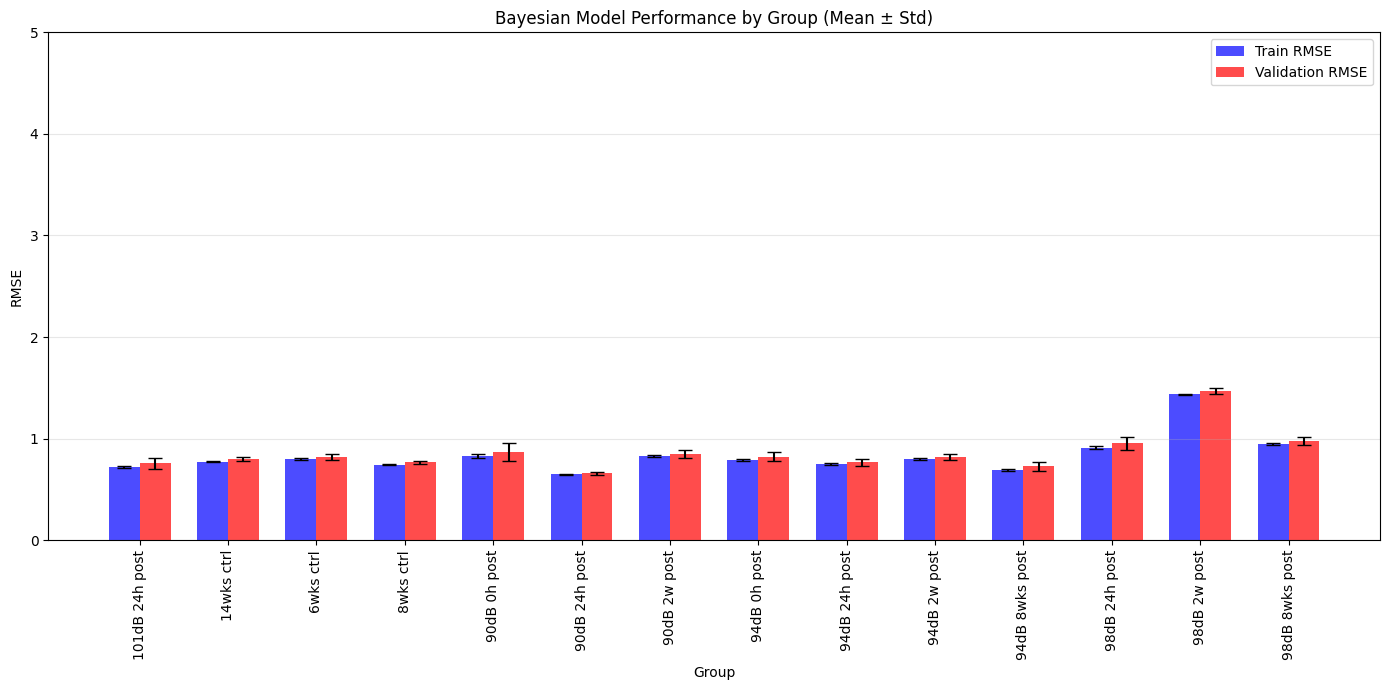

,Group,Train_RMSE_Mean,Val_RMSE_Mean,Train_RMSE_Std,Val_RMSE_Std
0,101dB 24h post,0.721151,0.755946,0.014033,0.057092
1,14wks ctrl,0.773774,0.796205,0.004934,0.020054
2,6wks ctrl,0.797947,0.817712,0.007880,0.030955
3,8wks ctrl,0.744823,0.765688,0.002900,0.010895
4,90dB 0h post,0.828263,0.870299,0.019650,0.085915
5,90dB 24h post,0.649333,0.660644,0.003761,0.015600
6,90dB 2w post,0.829130,0.845063,0.009181,0.038875
7,94dB 0h post,0.793693,0.821482,0.010189,0.044991
8,94dB 24h post,0.750785,0.766414,0.008733,0.031294
9,94dB 2w post,0.801643,0.818341,0.008350,0.028206


In [696]:
from sklearn.model_selection import KFold
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

thresh = 0
k_folds = KFold(n_splits=5, shuffle=True, random_state=42)
train_rmse_scores = []
val_rmse_scores = []
subjects_profiles_CVsplit_v9 = {}
all_train_data = {}
all_val_data = {}

# Groups setup
groups = [str(group) for group in np.unique(final_clean_strained_grouped_pos_cleangroup_vs_timed['Group'])]
group_train_rmse = {group: [] for group in groups}
group_val_rmse = {group: [] for group in groups}

for fold_idx, (train_idx, val_idx) in enumerate(k_folds.split(X_train9_5)):
    X_fold_train, X_fold_val = X_train9_5.iloc[train_idx], X_train9_5.iloc[val_idx]
    y_fold_train, y_fold_val = y1_train9_5.iloc[train_idx], y1_train9_5.iloc[val_idx]
    
    print(f"\nProcessing Fold {fold_idx+1}")
    
    # First, build the Bayesian profiles for each subject
    for subject in np.unique(X_fold_train['Subject']):
        profile_key = f"{subject}"
        subjects_profiles_CVsplit_v9[profile_key] = BayesianProfile_v9(
            x5_categories=['CBA/CaJ', 'C57B6']
        )
        
        subject_data = X_fold_train[X_fold_train['Subject'] == subject]
        
        # Group by the combination of features that define unique conditions
        grouped = subject_data.groupby([
            'Freq(kHz) (x1)', 'Amplitude (x3)', 'Strain (x5)',   
            'Group - dB (x6)', 'Group - Hours Elapsed (x7)'
        ])
        
        # Process each group (condition)
        for group_key, group_data in grouped:
            if group_data['Level(dB) (x2)'].min() < thresh:
                continue
                
            # Get all y1 values for this condition
            indices = group_data.index
            y_values = y_fold_train.loc[indices]
            
            # Extract feature values (same for all rows in group)
            x1_val = group_data['Freq(kHz) (x1)'].iloc[0]
            x3_val = group_data['Amplitude (x3)'].iloc[0]
            x5_val = group_data['Strain (x5)'].iloc[0]
            x6_val = group_data['Group - dB (x6)'].iloc[0]
            x7_val = group_data['Group - Hours Elapsed (x7)'].iloc[0]
            
            # Add each observation with same features but different y values
            for idx, y1_val in zip(indices, y_values):
                subjects_profiles_CVsplit_v9[profile_key].add_observation_y1(
                    x1=x1_val, x3=x3_val, x5=x5_val, x6=x6_val, x7=x7_val, 
                    y1=float(y1_val),
                )
    
    # Now calculate RMSE for this fold (both training and validation)
    # Store predictions in a dictionary keyed by index
    train_predictions = {}
    
    for idx, row in X_fold_train.iterrows():
        if row['Level(dB) (x2)'] >= thresh:
            subject = row['Subject']
            profile_key = f"{subject}"
            x1_val = row['Freq(kHz) (x1)']
            x3_val = row['Amplitude (x3)']
            x5_val = row['Strain (x5)']
            x6_val = row['Group - dB (x6)']
            x7_val = row['Group - Hours Elapsed (x7)']

            pred = subjects_profiles_CVsplit_v9[profile_key].predict_y1(x1= x1_val, x3=x3_val, x5=x5_val, x6=x6_val, x7=x7_val)
            train_predictions[idx] = float(pred)  # Ensure it's a scalar

    # Create pandas Series with predictions matched to proper indices
    successful_train_indices = list(train_predictions.keys())
    
    if successful_train_indices:
        y_train_true = y_fold_train.loc[successful_train_indices]
        y_train_pred = pd.Series([train_predictions[idx] for idx in successful_train_indices], 
                                index=successful_train_indices)
        
        # Do the same for validation
        val_predictions = {}
        
        for idx, row in X_fold_val.iterrows():
            if row['Level(dB) (x2)'] >= thresh:
                subject = row['Subject']
                profile_key = f"{subject}"
                x1_val = row['Freq(kHz) (x1)']
                x3_val = row['Amplitude (x3)']
                x5_val = row['Strain (x5)']
                x6_val = row['Group - dB (x6)']
                x7_val = row['Group - Hours Elapsed (x7)']
            
                pred = subjects_profiles_CVsplit_v9[profile_key].predict_y1(x1= x1_val, x3=x3_val, x5=x5_val, x6=x6_val, x7=x7_val)
                val_predictions[idx] = float(pred)  # Ensure it's a scalar

        
        # Create properly indexed validation predictions
        successful_val_indices = list(val_predictions.keys())

        # Add debugging information
        print("\nDebugging values:")
        print("Sample of true values:", y_train_true.head())
        print("Sample of predicted values:", y_train_pred.head())
        print("Max true:", y_train_true.max())
        print("Min true:", y_train_true.min())
        print("Max pred:", y_train_pred.max())
        print("Min pred:", y_train_pred.min())

        # Do the same for validation data
        print("\nValidation data:")
        print("Sample of true values:", y_val_true.head())
        print("Sample of predicted values:", y_val_pred.head())
        print("Max true:", y_val_true.max())
        print("Min true:", y_val_true.min())
        print("Max pred:", y_val_pred.max())
        print("Min pred:", y_val_pred.min())
        
        if successful_val_indices:
            y_val_true = y_fold_val.loc[successful_val_indices]
            y_val_pred = pd.Series([val_predictions[idx] for idx in successful_val_indices], 
                               index=successful_val_indices)
            
            # Print basic information
            print(f"Train: {len(successful_train_indices)} successful predictions out of {len(X_fold_train)}")
            print(f"Validation: {len(successful_val_indices)} successful predictions out of {len(X_fold_val)}")
            
            # Calculate RMSE
            true_name = f'{fold_idx} - train - true'
            pred_name = f'{fold_idx} - train - pred'
            all_train_data[true_name] = y_train_true
            all_train_data[pred_name] = y_train_pred

            fold_train_rmse = np.sqrt(np.mean((y_train_true - y_train_pred)**2))
            train_rmse_scores.append(fold_train_rmse)
            
            true_name = f'{fold_idx} - val - true'
            pred_name = f'{fold_idx} - val - pred'
            all_val_data[true_name] = y_val_true
            all_val_data[pred_name] = y_val_pred

            fold_val_rmse = np.sqrt(np.mean((y_val_true - y_val_pred)**2))
            val_rmse_scores.append(fold_val_rmse)
            
            print(f"Fold {fold_idx+1}: Train RMSE = {fold_train_rmse:.4f}, Validation RMSE = {fold_val_rmse:.4f}")
            
            # Calculate group-specific RMSE
            for group in groups:
                # Get the subject groups
                train_subjects_df = final_clean_strained_grouped_pos_cleangroup_vs_timed.loc[successful_train_indices]
                val_subjects_df = final_clean_strained_grouped_pos_cleangroup_vs_timed.loc[successful_val_indices]
                
                # Filter for successful predictions for this group
                group_train_mask = train_subjects_df['Group'] == group
                if group_train_mask.any():
                    group_indices = group_train_mask[group_train_mask].index
                    group_rmse = np.sqrt(np.mean((y_train_true.loc[group_indices] - y_train_pred.loc[group_indices])**2))
                    group_train_rmse[group].append(group_rmse)
                
                group_val_mask = val_subjects_df['Group'] == group
                if group_val_mask.any():
                    group_indices = group_val_mask[group_val_mask].index
                    group_rmse = np.sqrt(np.mean((y_val_true.loc[group_indices] - y_val_pred.loc[group_indices])**2))
                    group_val_rmse[group].append(group_rmse)

        else:
            print(f"Fold {fold_idx+1}: No successful validation predictions")
    else:
        print(f"Fold {fold_idx+1}: No successful training predictions")

# Calculate average RMSE across all folds
if train_rmse_scores:
    avg_train_rmse = np.mean(train_rmse_scores)
    std_train_rmse = np.std(train_rmse_scores)
    print(f"\nAverage Train RMSE across folds: {avg_train_rmse:.4f} ± {std_train_rmse:.4f}")

if val_rmse_scores:
    avg_val_rmse = np.mean(val_rmse_scores)
    std_val_rmse = np.std(val_rmse_scores)
    print(f"Average Validation RMSE across folds: {avg_val_rmse:.4f} ± {std_val_rmse:.4f}")

# Calculate group-specific RMSE 
print("\nGroup-specific RMSE:")
print("Group | Train RMSE (Mean ± Std) | Validation RMSE (Mean ± Std)")
print("----- | ----------------------- | -----------------------------")
for group in groups:
    train_values = group_train_rmse[group]
    val_values = group_val_rmse[group]
    
    if train_values:
        train_mean = np.mean(train_values)
        train_std = np.std(train_values)
        train_str = f"{train_mean:.6f} ± {train_std:.6f}"
    else:
        train_str = "N/A"
        
    if val_values:
        val_mean = np.mean(val_values)
        val_std = np.std(val_values)
        val_str = f"{val_mean:.6f} ± {val_std:.6f}"
    else:
        val_str = "N/A"
        
    print(f"{group:15s} | {train_str:25s} | {val_str:25s}")

# Visualization of group-specific RMSE
if any(group_train_rmse[group] for group in groups) and any(group_val_rmse[group] for group in groups):
    # Prepare data for plotting
    plot_groups = []
    plot_train_rmse = []
    plot_val_rmse = []
    plot_train_std = []
    plot_val_std = []
    
    for group in groups:
        if group_train_rmse[group] and group_val_rmse[group]:
            plot_groups.append(group)
            plot_train_rmse.append(np.mean(group_train_rmse[group]))
            plot_val_rmse.append(np.mean(group_val_rmse[group]))
            plot_train_std.append(np.std(group_train_rmse[group]))
            plot_val_std.append(np.std(group_val_rmse[group]))
    
    # Create plot if we have data
    if plot_groups:
        plt.figure(figsize=(14, 7))
        x = np.arange(len(plot_groups))
        width = 0.35
        
        plt.bar(x - width/2, plot_train_rmse, width, yerr=plot_train_std, 
                label='Train RMSE', color='blue', alpha=0.7, capsize=5)
        plt.bar(x + width/2, plot_val_rmse, width, yerr=plot_val_std,
                label='Validation RMSE', color='red', alpha=0.7, capsize=5)
        
        plt.xlabel('Group')
        plt.ylabel('RMSE')
        plt.ylim((0,5))
        plt.title('Bayesian Model Performance by Group (Mean ± Std)')
        plt.xticks(x, plot_groups, rotation=90)
        plt.legend()
        plt.grid(True, axis='y', alpha=0.3)
        plt.tight_layout()
        plt.show()

groups_list = []
train_mean_list = []
train_std_list = []
val_mean_list = []
val_std_list = []

# Extract values for each group
for group in sorted(group_train_rmse.keys()):
    train_values = group_train_rmse[group]
    val_values = group_val_rmse[group]
    
    groups_list.append(group)
    
    if train_values:
        train_mean_list.append(np.mean(train_values))
        train_std_list.append(np.std(train_values))
    else:
        train_mean_list.append(np.nan)
        train_std_list.append(np.nan)
        
    if val_values:
        val_mean_list.append(np.mean(val_values))
        val_std_list.append(np.std(val_values))
    else:
        val_mean_list.append(np.nan)
        val_std_list.append(np.nan)


# Create lists to store the data
groups_list = []
train_mean_list = []
train_std_list = []
val_mean_list = []
val_std_list = []

# Extract values for each group
for group in sorted(group_train_rmse.keys()):
    train_values = group_train_rmse[group]
    val_values = group_val_rmse[group]
    
    groups_list.append(group)
    
    if train_values:
        train_mean_list.append(np.mean(train_values))
        train_std_list.append(np.std(train_values))
    else:
        train_mean_list.append(np.nan)
        train_std_list.append(np.nan)
        
    if val_values:
        val_mean_list.append(np.mean(val_values))
        val_std_list.append(np.std(val_values))
    else:
        val_mean_list.append(np.nan)
        val_std_list.append(np.nan)

group_metrics_df = pd.DataFrame({
    'Group': groups_list,
    'Train_RMSE_Mean': train_mean_list,
    'Val_RMSE_Mean': val_mean_list,
    'Train_RMSE_Std': train_std_list,
    'Val_RMSE_Std': val_std_list
})

group_metrics_df

## LATEST AND GREATEST!!!!!!

In [691]:
RMSE_fold1 = np.sqrt(np.mean((all_train_data['0 - train - true'] - all_train_data['0 - train - pred'])**2))
RMSE_fold1
# all_train_data_df = pd.DataFrame(all_train_data)
# all_train_data_df

0.8599983359975796

In [692]:
RMSE_fold1 = np.sqrt(np.mean((all_val_data['0 - val - true'] - all_val_data['0 - val - pred'])**2))
RMSE_fold1
# all_val_data

0.8509392384108494

In [579]:
# train_results = pd.DataFrame(data = {'Train Preds' : new, 'Train Ground Truth' : newnew})
# train_results.info()

In [562]:
# # old split

# from sklearn.model_selection import KFold
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt

# thresh = 0
# k_folds = KFold(n_splits=5, shuffle=True, random_state=42)
# train_rmse_scores = []
# val_rmse_scores = []
# subjects_profiles_CVsplit_v9 = {}

# # Groups setup
# groups = [str(group) for group in np.unique(final_clean_strained_grouped_pos_cleangroup_vs_timed['Group'])]
# group_train_rmse = {group: [] for group in groups}
# group_val_rmse = {group: [] for group in groups}

# for fold_idx, (train_idx, val_idx) in enumerate(k_folds.split(X_train9)):
#     X_fold_train, X_fold_val = X_train9.iloc[train_idx], X_train9.iloc[val_idx]
#     y_fold_train, y_fold_val = y1_train9.iloc[train_idx], y1_train9.iloc[val_idx]
    
#     print(f"\nProcessing Fold {fold_idx+1}")
    
#     # First, build the Bayesian profiles for each subject
#     for subject in np.unique(X_fold_train['Subject']):
#         profile_key = f"{subject}"
#         subjects_profiles_CVsplit_v9[profile_key] = BayesianProfile_v9(
#             x5_categories=['CBA/CaJ', 'C57B6']
#         )
        
#         subject_data = X_fold_train[X_fold_train['Subject'] == subject]
        
#         # Group by the combination of features that define unique conditions
#         grouped = subject_data.groupby([
#             'Freq(Hz) (x1)', 'Amplitude (x3)', 'Strain (x5)', 
#             'Group - dB (x6)', 'Group - Hours Elapsed (x7)'
#         ])
        
#         # Process each group (condition)
#         for group_key, group_data in grouped:
#             if group_data['Level(dB) (x2)'].min() < thresh:
#                 continue
                
#             # Get all y1 values for this condition
#             indices = group_data.index
#             y_values = y_fold_train.loc[indices]
            
#             # Extract feature values (same for all rows in group)
#             x1_val = group_data['Freq(Hz) (x1)'].iloc[0]
#             x3_val = group_data['Amplitude (x3)'].iloc[0]
#             x5_val = group_data['Strain (x5)'].iloc[0]
#             x6_val = group_data['Group - dB (x6)'].iloc[0]
#             x7_val = group_data['Group - Hours Elapsed (x7)'].iloc[0]
            
#             # Add each observation with same features but different y values
#             for idx, y1_val in zip(indices, y_values):
#                 subjects_profiles_CVsplit_v9[profile_key].add_observation_y1(
#                     x1=x1_val, x3=x3_val, x5=x5_val, x6=x6_val, x7=x7_val, 
#                     y1=float(y1_val),
#                 )
    
#     # Now calculate RMSE for this fold (both training and validation)
#     # Store predictions in a dictionary keyed by index
#     train_predictions = {}
    
#     for idx, row in X_fold_train.iterrows():
#         if row['Level(dB) (x2)'] >= thresh:
#             subject = row['Subject']
#             profile_key = f"{subject}"
#             x1_val = row['Freq(Hz) (x1)']
#             x3_val = row['Amplitude (x3)']
#             x5_val = row['Strain (x5)']
#             x6_val = row['Group - dB (x6)']
#             x7_val = row['Group - Hours Elapsed (x7)']

#             try:
#                 # Call predict_y1 with scalar values
#                 pred = subjects_profiles_CVsplit_v9[profile_key].predict_y1(x1= x1_val, x3=x3_val, x5=x5_val, x6=x6_val, x7=x7_val)
#                 train_predictions[idx] = float(pred)  # Ensure it's a scalar
#             except Exception as e:
#                 # Just pass if prediction fails
#                 pass

#     # Create pandas Series with predictions matched to proper indices
#     successful_train_indices = list(train_predictions.keys())
    
#     if successful_train_indices:
#         y_train_true = y_fold_train.loc[successful_train_indices]
#         y_train_pred = pd.Series([train_predictions[idx] for idx in successful_train_indices], 
#                                 index=successful_train_indices)
        
#         # Do the same for validation
#         val_predictions = {}
        
#         for idx, row in X_fold_val.iterrows():
#             if row['Level(dB) (x2)'] >= thresh:
#                 subject = row['Subject']
#                 profile_key = f"{subject}"
#                 x1_val = row['Freq(Hz) (x1)']
#                 x3_val = row['Amplitude (x3)']
#                 x5_val = row['Strain (x5)']
#                 x6_val = row['Group - dB (x6)']
#                 x7_val = row['Group - Hours Elapsed (x7)']
            
#                 try:
#                     # Call predict_y1 with scalar values
#                     pred = subjects_profiles_CVsplit_v9[profile_key].predict_y1(x1= x1_val, x3=x3_val, x5=x5_val, x6=x6_val, x7=x7_val)
#                     val_predictions[idx] = float(pred)  # Ensure it's a scalar
#                 except Exception as e:
#                     # Just pass if prediction fails
#                     pass
        
#         # Create properly indexed validation predictions
#         successful_val_indices = list(val_predictions.keys())

#         # Add debugging information
#         print("\nDebugging values:")
#         print("Sample of true values:", y_train_true.head())
#         print("Sample of predicted values:", y_train_pred.head())
#         print("Max true:", y_train_true.max())
#         print("Min true:", y_train_true.min())
#         print("Max pred:", y_train_pred.max())
#         print("Min pred:", y_train_pred.min())

#         # Do the same for validation data
#         print("\nValidation data:")
#         print("Sample of true values:", y_val_true.head())
#         print("Sample of predicted values:", y_val_pred.head())
#         print("Max true:", y_val_true.max())
#         print("Min true:", y_val_true.min())
#         print("Max pred:", y_val_pred.max())
#         print("Min pred:", y_val_pred.min())
        
#         if successful_val_indices:
#             y_val_true = y_fold_val.loc[successful_val_indices]
#             y_val_pred = pd.Series([val_predictions[idx] for idx in successful_val_indices], 
#                                index=successful_val_indices)
            
#             # Print basic information
#             print(f"Train: {len(successful_train_indices)} successful predictions out of {len(X_fold_train)}")
#             print(f"Validation: {len(successful_val_indices)} successful predictions out of {len(X_fold_val)}")
            
#             # Calculate RMSE
#             fold_train_rmse = np.sqrt(np.mean((y_train_true - y_train_pred)**2))
#             train_rmse_scores.append(fold_train_rmse)
            
#             fold_val_rmse = np.sqrt(np.mean((y_val_true - y_val_pred)**2))
#             val_rmse_scores.append(fold_val_rmse)
            
#             print(f"Fold {fold_idx+1}: Train RMSE = {fold_train_rmse:.4f}, Validation RMSE = {fold_val_rmse:.4f}")
            
#             # Calculate group-specific RMSE
#             for group in groups:
#                 # Get the subject groups
#                 train_subjects_df = final_clean_strained_grouped_pos_cleangroup_vs_timed.loc[successful_train_indices]
#                 val_subjects_df = final_clean_strained_grouped_pos_cleangroup_vs_timed.loc[successful_val_indices]
                
#                 # Filter for successful predictions for this group
#                 group_train_mask = train_subjects_df['Group'] == group
#                 if group_train_mask.any():
#                     group_indices = group_train_mask[group_train_mask].index
#                     group_rmse = np.sqrt(np.mean((y_train_true.loc[group_indices] - y_train_pred.loc[group_indices])**2))
#                     group_train_rmse[group].append(group_rmse)
                
#                 group_val_mask = val_subjects_df['Group'] == group
#                 if group_val_mask.any():
#                     group_indices = group_val_mask[group_val_mask].index
#                     group_rmse = np.sqrt(np.mean((y_val_true.loc[group_indices] - y_val_pred.loc[group_indices])**2))
#                     group_val_rmse[group].append(group_rmse)

#         else:
#             print(f"Fold {fold_idx+1}: No successful validation predictions")
#     else:
#         print(f"Fold {fold_idx+1}: No successful training predictions")

# # Calculate average RMSE across all folds
# if train_rmse_scores:
#     avg_train_rmse = np.mean(train_rmse_scores)
#     std_train_rmse = np.std(train_rmse_scores)
#     print(f"\nAverage Train RMSE across folds: {avg_train_rmse:.4f} ± {std_train_rmse:.4f}")

# if val_rmse_scores:
#     avg_val_rmse = np.mean(val_rmse_scores)
#     std_val_rmse = np.std(val_rmse_scores)
#     print(f"Average Validation RMSE across folds: {avg_val_rmse:.4f} ± {std_val_rmse:.4f}")

# # Calculate group-specific RMSE 
# print("\nGroup-specific RMSE:")
# print("Group | Train RMSE (Mean ± Std) | Validation RMSE (Mean ± Std)")
# print("----- | ----------------------- | -----------------------------")
# for group in groups:
#     train_values = group_train_rmse[group]
#     val_values = group_val_rmse[group]
    
#     if train_values:
#         train_mean = np.mean(train_values)
#         train_std = np.std(train_values)
#         train_str = f"{train_mean:.6f} ± {train_std:.6f}"
#     else:
#         train_str = "N/A"
        
#     if val_values:
#         val_mean = np.mean(val_values)
#         val_std = np.std(val_values)
#         val_str = f"{val_mean:.6f} ± {val_std:.6f}"
#     else:
#         val_str = "N/A"
        
#     print(f"{group:15s} | {train_str:25s} | {val_str:25s}")

# # Visualization of group-specific RMSE
# if any(group_train_rmse[group] for group in groups) and any(group_val_rmse[group] for group in groups):
#     # Prepare data for plotting
#     plot_groups = []
#     plot_train_rmse = []
#     plot_val_rmse = []
#     plot_train_std = []
#     plot_val_std = []
    
#     for group in groups:
#         if group_train_rmse[group] and group_val_rmse[group]:
#             plot_groups.append(group)
#             plot_train_rmse.append(np.mean(group_train_rmse[group]))
#             plot_val_rmse.append(np.mean(group_val_rmse[group]))
#             plot_train_std.append(np.std(group_train_rmse[group]))
#             plot_val_std.append(np.std(group_val_rmse[group]))
    
#     # Create plot if we have data
#     if plot_groups:
#         plt.figure(figsize=(14, 7))
#         x = np.arange(len(plot_groups))
#         width = 0.35
        
#         plt.bar(x - width/2, plot_train_rmse, width, yerr=plot_train_std, 
#                 label='Train RMSE', color='blue', alpha=0.7, capsize=5)
#         plt.bar(x + width/2, plot_val_rmse, width, yerr=plot_val_std,
#                 label='Validation RMSE', color='red', alpha=0.7, capsize=5)
        
#         plt.xlabel('Group')
#         plt.ylabel('RMSE')
#         plt.ylim((0,5))
#         plt.title('Bayesian Model Performance by Group (Mean ± Std)')
#         plt.xticks(x, plot_groups, rotation=90)
#         plt.legend()
#         plt.grid(True, axis='y', alpha=0.3)
#         plt.tight_layout()
#         plt.show()

# groups_list = []
# train_mean_list = []
# train_std_list = []
# val_mean_list = []
# val_std_list = []

# # Extract values for each group
# for group in sorted(group_train_rmse.keys()):
#     train_values = group_train_rmse[group]
#     val_values = group_val_rmse[group]
    
#     groups_list.append(group)
    
#     if train_values:
#         train_mean_list.append(np.mean(train_values))
#         train_std_list.append(np.std(train_values))
#     else:
#         train_mean_list.append(np.nan)
#         train_std_list.append(np.nan)
        
#     if val_values:
#         val_mean_list.append(np.mean(val_values))
#         val_std_list.append(np.std(val_values))
#     else:
#         val_mean_list.append(np.nan)
#         val_std_list.append(np.nan)


# # Create lists to store the data
# groups_list = []
# train_mean_list = []
# train_std_list = []
# val_mean_list = []
# val_std_list = []

# # Extract values for each group
# for group in sorted(group_train_rmse.keys()):
#     train_values = group_train_rmse[group]
#     val_values = group_val_rmse[group]
    
#     groups_list.append(group)
    
#     if train_values:
#         train_mean_list.append(np.mean(train_values))
#         train_std_list.append(np.std(train_values))
#     else:
#         train_mean_list.append(np.nan)
#         train_std_list.append(np.nan)
        
#     if val_values:
#         val_mean_list.append(np.mean(val_values))
#         val_std_list.append(np.std(val_values))
#     else:
#         val_mean_list.append(np.nan)
#         val_std_list.append(np.nan)

# group_metrics_df = pd.DataFrame({
#     'Group': groups_list,
#     'Train_RMSE_Mean': train_mean_list,
#     'Val_RMSE_Mean': val_mean_list,
#     'Train_RMSE_Std': train_std_list,
#     'Val_RMSE_Std': val_std_list
# })

# group_metrics_df

In [697]:
subjects_by_strain = {}
for strain in final_clean_strained_grouped_pos_cleangroup_vs_timed['Strain (x5)'].unique():
    subjects_in_strain = final_clean_strained_grouped_pos_cleangroup_vs_timed[final_clean_strained_grouped_pos_cleangroup_vs_timed['Strain (x5)'] == strain]['Subject'].unique()
    subjects_by_strain[strain] = list(subjects_in_strain)

exp_group = []
strain_group = []
int_coefs = []
freqs_coefs = []
amps_coefs = []
strains_coefs = []
exps_coefs = []
hours_coefs = []
subs = []

for sub in subjects_profiles_CVsplit_v9:
    int = subjects_profiles_CVsplit_v9[sub].mean_y1[0]
    freq_coef = subjects_profiles_CVsplit_v9[sub].mean_y1[1]
    amp_coef = subjects_profiles_CVsplit_v9[sub].mean_y1[2]
    strain_coef = subjects_profiles_CVsplit_v9[sub].mean_y1[3]
    exp_coef = subjects_profiles_CVsplit_v9[sub].mean_y1[4]
    hours_coef = subjects_profiles_CVsplit_v9[sub].mean_y1[5]
    
    subs.append(sub)
    int_coefs.append(int)
    freqs_coefs.append(freq_coef)
    amps_coefs.append(amp_coef)
    strains_coefs.append(strain_coef)
    exps_coefs.append(exp_coef)
    hours_coefs.append(hours_coef)

    for group in subjects_by_group:
        if sub in subjects_by_group[group]:
            exp_group.append(group)

    for strain in subjects_by_strain:
        if sub in subjects_by_strain[strain]:
            strain_group.append(strain)

coefficients_by_group_strain = pd.DataFrame(data = {'Subject' : subs, 'Group': exp_group, 'Strain' : strain_group, 'Intercept': int_coefs, 'Freq(kHz) (x1)': freqs_coefs, 'Amplitude (x3)': amps_coefs, 'Strain (x5)': strains_coefs, 'Group - dB (x6)': exps_coefs, 'Group - Hours Elapsed (x7)': hours_coefs})
coefficients_by_group_strain[coefficients_by_group_strain['Group'] == '6wks ctrl']

,Subject,Group,Strain,Intercept,Freq(kHz) (x1),Amplitude (x3),Strain (x5),Group - dB (x6),Group - Hours Elapsed (x7)
8,WPZ112,6wks ctrl,C57B6,0.000012,0.355602,0.114047,0.000000,0.000012,0.0
21,WPZ134,6wks ctrl,C57B6,0.000015,0.044066,0.001120,0.000000,0.000015,0.0
29,WPZ142,6wks ctrl,C57B6,0.000014,0.203036,0.122333,0.000000,0.000014,0.0
56,WPZ173,6wks ctrl,C57B6,0.000013,0.214394,0.023769,0.000000,0.000013,0.0
63,WPZ180,6wks ctrl,CBA/CaJ,0.000011,0.414704,0.229368,0.000011,0.000000,0.0
64,WPZ50,6wks ctrl,C57B6,0.000015,0.100668,-0.025322,0.000000,0.000015,0.0
68,WPZ55,6wks ctrl,C57B6,0.000012,0.349807,0.061711,0.000000,0.000012,0.0
78,WPZ68,6wks ctrl,C57B6,0.000015,0.207056,-0.556487,0.000000,0.000015,0.0
84,WPZ74,6wks ctrl,C57B6,0.000013,0.283232,-0.082258,0.000000,0.000013,0.0
90,WPZ82,6wks ctrl,C57B6,0.000013,0.262052,0.045919,0.000000,0.000013,0.0


In [698]:
final_clean_strained_grouped_pos_cleangroup_vs_timed[final_clean_strained_grouped_pos_cleangroup_vs_timed['Subject'] == 'WPZ112']

,Subject,Freq(kHz) (x1),Level(dB) (x2),Amplitude (x3),vx (x4),Strain (x5),Group - dB (x6),Group - Hours Elapsed (x7),Synapses to IHC (y1),Group,Group - Time Elapsed,Group - Time Elapsed - Split,Group - Time Elapsed - Magn.,Group - Time Elapsed - Unit
4096,WPZ112,8.0,10.0,0.075298,v1,C57B6,0,1008,14.583333,6wks ctrl,6wks,"[6, wks]",6,wks
4096,WPZ112,8.0,10.0,0.075298,v2,C57B6,0,1008,14.222222,6wks ctrl,6wks,"[6, wks]",6,wks
4097,WPZ112,8.0,15.0,0.070142,v1,C57B6,0,1008,14.583333,6wks ctrl,6wks,"[6, wks]",6,wks
4097,WPZ112,8.0,15.0,0.070142,v2,C57B6,0,1008,14.222222,6wks ctrl,6wks,"[6, wks]",6,wks
4098,WPZ112,8.0,20.0,0.128545,v1,C57B6,0,1008,14.583333,6wks ctrl,6wks,"[6, wks]",6,wks
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4155,WPZ112,11.3,60.0,1.280827,v2,C57B6,0,1008,17.362637,6wks ctrl,6wks,"[6, wks]",6,wks
4156,WPZ112,11.3,70.0,1.450717,v1,C57B6,0,1008,17.303371,6wks ctrl,6wks,"[6, wks]",6,wks
4156,WPZ112,11.3,70.0,1.450717,v2,C57B6,0,1008,17.362637,6wks ctrl,6wks,"[6, wks]",6,wks
4157,WPZ112,11.3,80.0,2.154547,v1,C57B6,0,1008,17.303371,6wks ctrl,6wks,"[6, wks]",6,wks


In [671]:
subjects_profiles_CVsplit_v9['WPZ112'].mean_y1

array([1.32879705e-05, 1.80105039e-01, 2.36540219e-01, 0.00000000e+00,
       1.32879705e-05, 0.00000000e+00, 1.33942743e-02])

In [672]:
0.00935809 + (0.06310733 * 11.3) + (0.04145837 * 1.280827) + (0.00935809 * 1) + (0*0) + (0.39303965 * 42)

17.292595308671988

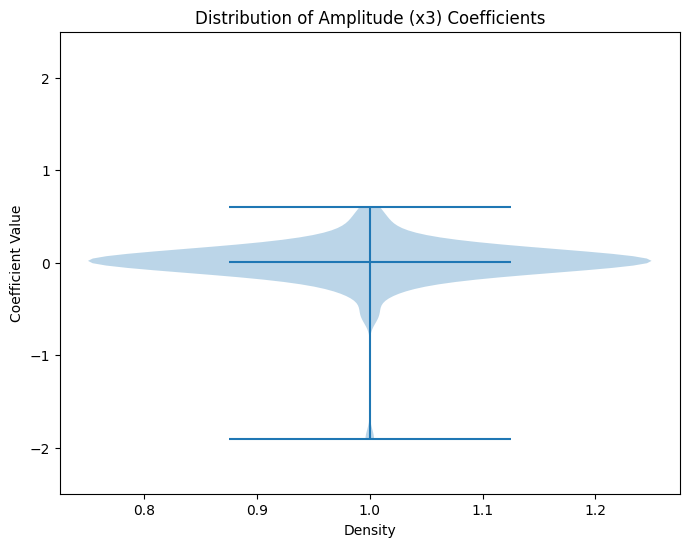

Average Unscaled Amplitude (x3) Coefficient: 0.010529595534009938


In [702]:
feature = 'Amplitude (x3)'

plt.figure(figsize=(8,6))
plt.violinplot(coefficients_by_group_strain[feature], showmeans=True, showmedians=False)
plt.title(f'Distribution of {feature} Coefficients')
plt.ylabel('Coefficient Value')
plt.xlabel('Density')
plt.ylim(-2.5,2.5)
plt.show()

# untrans_mean = coefficients_by_group_strain[feature].mean()
# untrans_mean
# np.std(final_clean_strained_grouped_pos_cleangroup_vs_timed[feature])

unscaleds = coefficients_by_group_strain[feature].copy()
unscaleds /= np.std(final_clean_strained_grouped_pos_cleangroup_vs_timed[feature])
print(f'Average Unscaled {feature} Coefficient: {np.mean(unscaleds)}')

In [616]:
45.2 * np.mean(unscaleds)

1.0055842271667714

In [700]:
# Create a list to store unscaled intercepts
features = ['Freq(kHz) (x1)', 'Amplitude (x3)', 'Strain (x5)', 'Group - dB (x6)', 'Group - Hours Elapsed (x7)']
unscaled_intercepts = []

# Loop through each model
for i in range(len(coefficients_by_group_strain['Intercept'])):
    # Start with the scaled intercept for this model
    unscaled_intercept = coefficients_by_group_strain['Intercept'][i]
    
    # Adjust for each feature
    for feature in features:
        scaled_coef = coefficients_by_group_strain[feature][i]
        
        # Get feature mean and std
        if feature == 'Strain (x5)':
            encoded = final_clean_strained_grouped_pos_cleangroup_vs_timed[feature].apply(lambda x: 0 if x == 'CBA/CaJ' else 1)
            feat_mean = np.mean(encoded)
            feat_std = np.sqrt(feat_mean * (1 - feat_mean))
        else:
            feat_mean = np.mean(final_clean_strained_grouped_pos_cleangroup_vs_timed[feature])
            feat_std = np.std(final_clean_strained_grouped_pos_cleangroup_vs_timed[feature])
        
        # Adjust intercept: subtract the scaled_coef * (-mean/std)
        # This is equivalent to adding scaled_coef * (mean/std)
        unscaled_intercept -= scaled_coef * (-feat_mean/feat_std)
    
    # Add to the list of unscaled intercepts
    unscaled_intercepts.append(unscaled_intercept)

# Calculate the mean unscaled intercept
mean_unscaled_intercept = np.mean(unscaled_intercepts)
print(f"Mean unscaled intercept: {mean_unscaled_intercept}")

Mean unscaled intercept: 0.55034044171759


In [609]:
# from bioio import BioImage
# import bioio_lif
# import bioio_tifffile

# path = '/Users/leahashebir/Downloads/Manor_Practicum/image_libs/WPZ98L.CtBP2.GluR2.NF.Myo7.IHC.11.3.v1.lif'
# img = BioImage(path)

# print(f"Dimensions: {img.dims}")
# print(f"Shape: {img.shape}")
# print(f"Number of channels: {img.dims.C}")
# print(f"Size of T dimension: {img.dims.T}")
# print(f"Size of Z dimension: {img.dims.Z}")

# # 3D visualization of z-stack ACROSS CHANNELS

# channels = []
# max_projections = []

# # Loop through each channel
# for c in range(img.dims.C):
#     # Get data for this channel
#     channel_data = img.get_image_data("ZYX", C=c, T=0)
#     channels.append(channel_data)
    
#     # Create max projection along Z-axis
#     max_proj = np.max(channel_data, axis=0)
#     max_projections.append(max_proj)

# # tensor_dim_stack_normalized = (max_projections - max_projections.mean())/ (max_projections.std()+ 1e-8)

# # input_tensor = torch.from_numpy(tensor_dim_stack_normalized).float()
# input_tensor = torch.from_numpy(np.array(max_projections)).float()

# # If you need to add batch dimension
# input_tensor = input_tensor.unsqueeze(0)

# plt.figure(figsize=(15, 5))
# for i in range(len(max_projections)):
#     plt.subplot(1, len(max_projections), i+1)
#     plt.imshow(max_projections[i], cmap='gray')
#     plt.title(f"Channel {i}")
# plt.tight_layout()
# plt.show()

# # max_projections

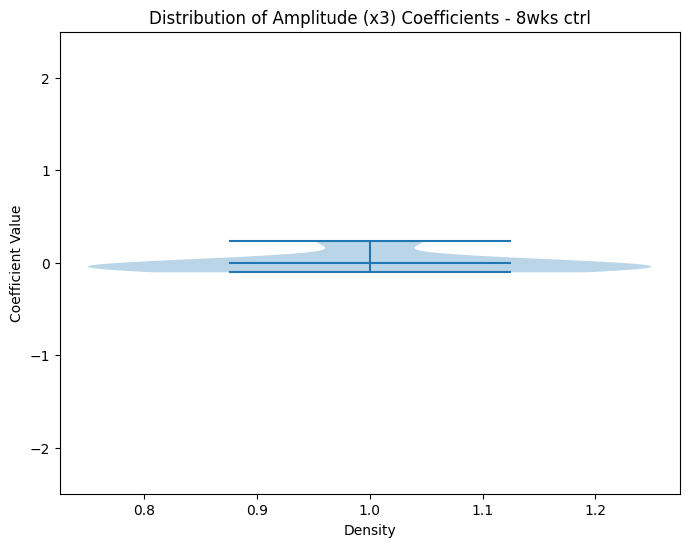

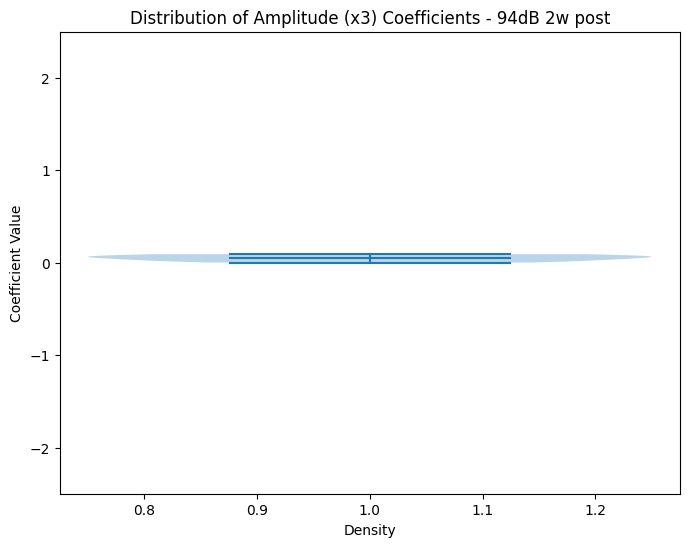

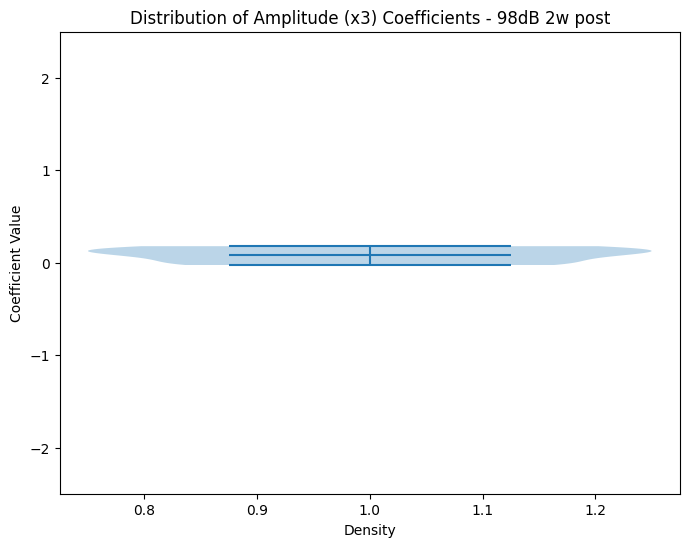

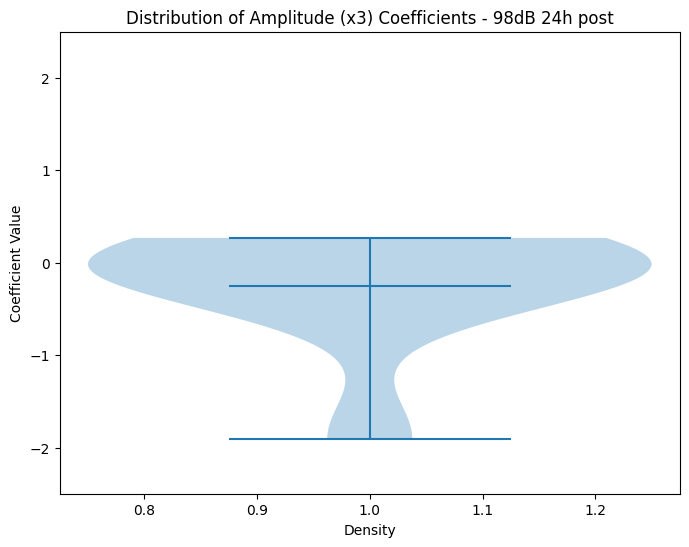

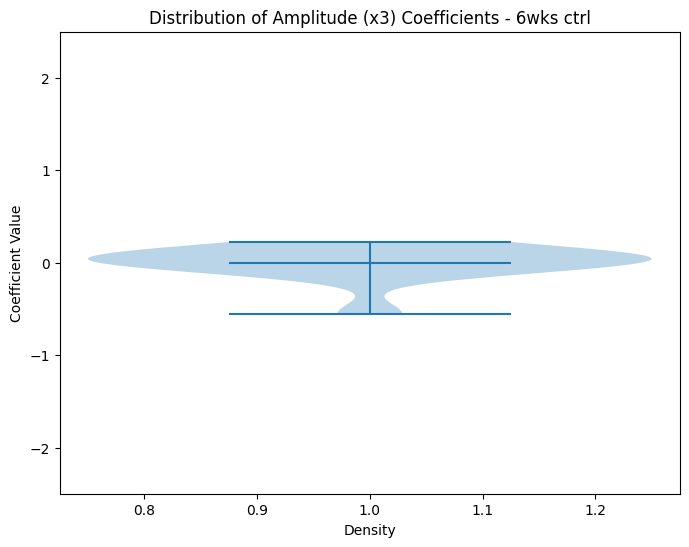

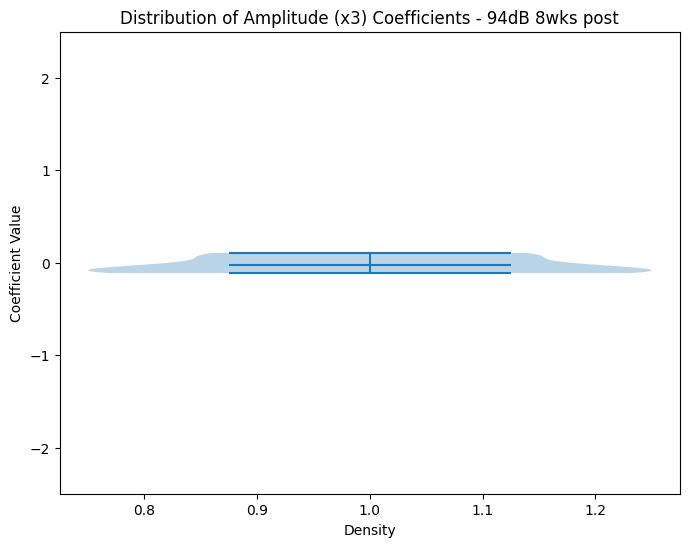

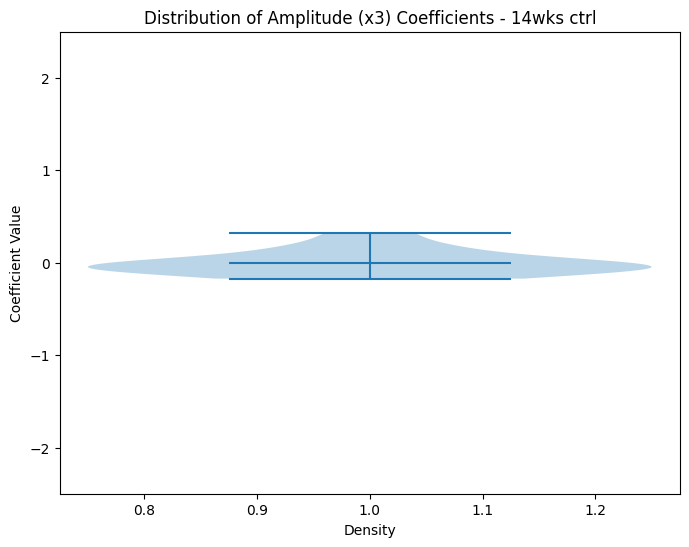

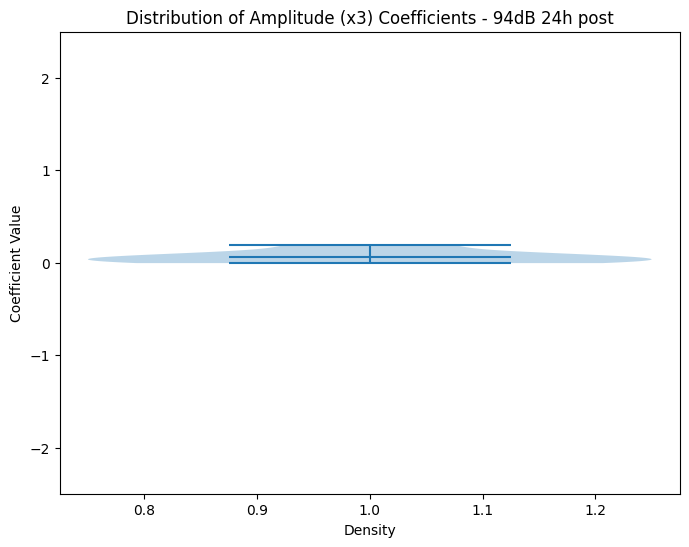

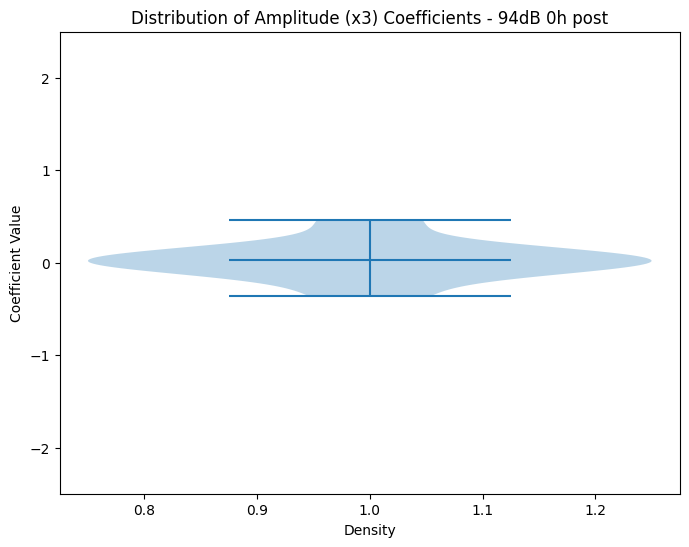

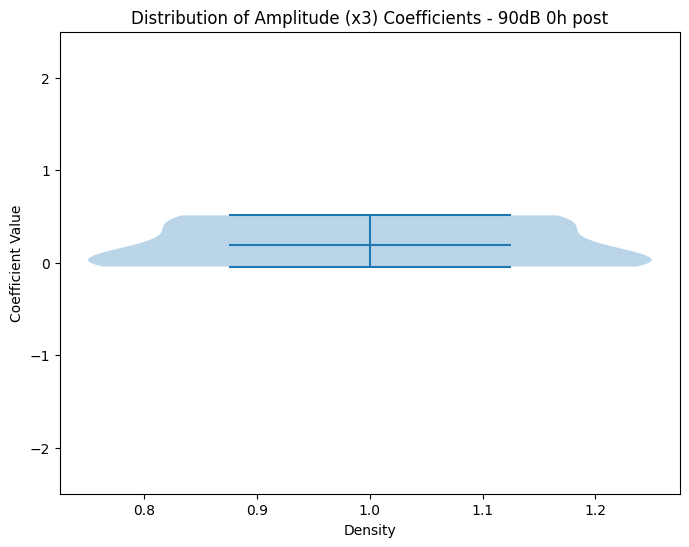

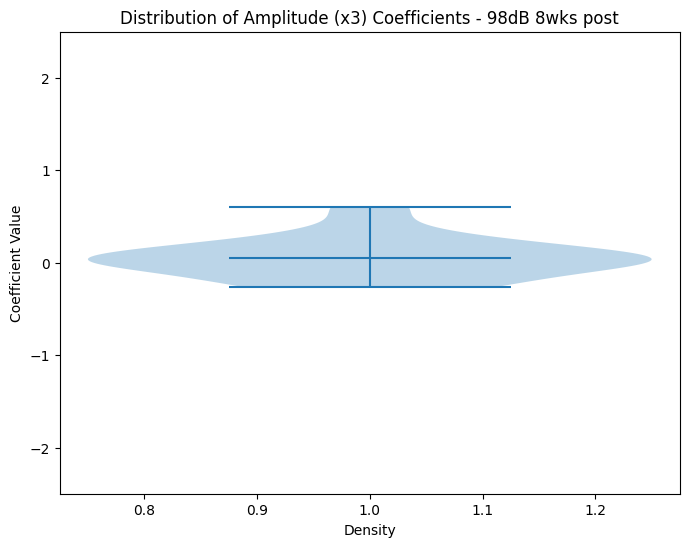

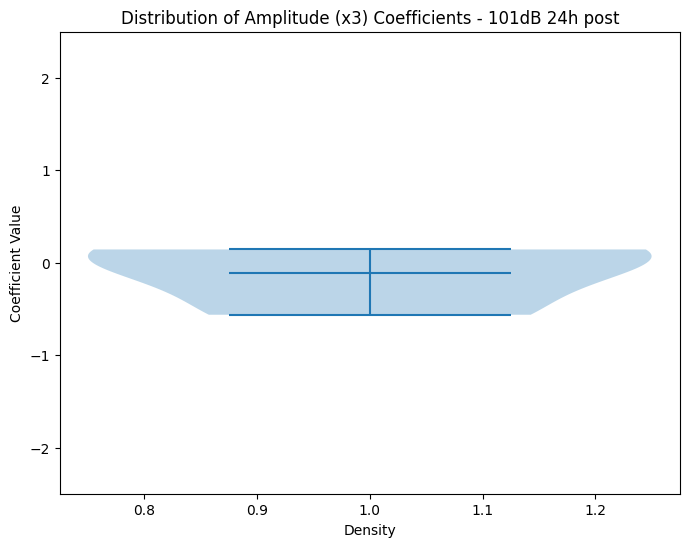

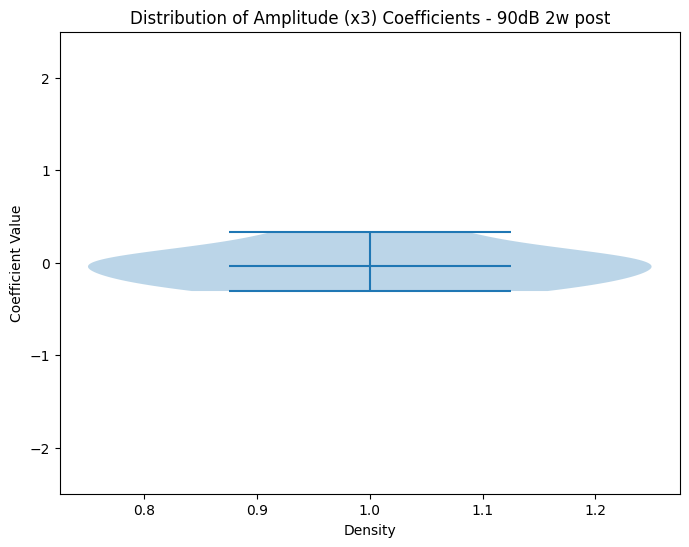

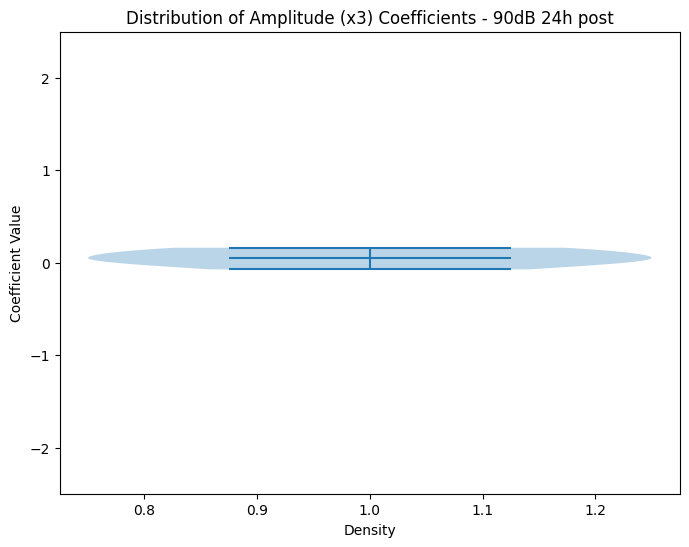

In [701]:
feature = 'Amplitude (x3)'
for group in coefficients_by_group_strain['Group'].unique():
    plt.figure(figsize=(8,6))
    plt.violinplot(coefficients_by_group_strain[coefficients_by_group_strain['Group'] == group][feature], showmeans=True, showmedians=False)
    plt.title(f'Distribution of {feature} Coefficients - {group}')
    plt.ylabel('Coefficient Value')
    plt.xlabel('Density')
    plt.ylim(-2.5,2.5)
    plt.show()

In [383]:
final_clean_strained_grouped_pos_cleangroup_vs_timed[final_clean_strained_grouped_pos_cleangroup_vs_timed['Group'].str.contains('94dB 0h post')]['Synapses to IHC (y1)'].min()

4.7

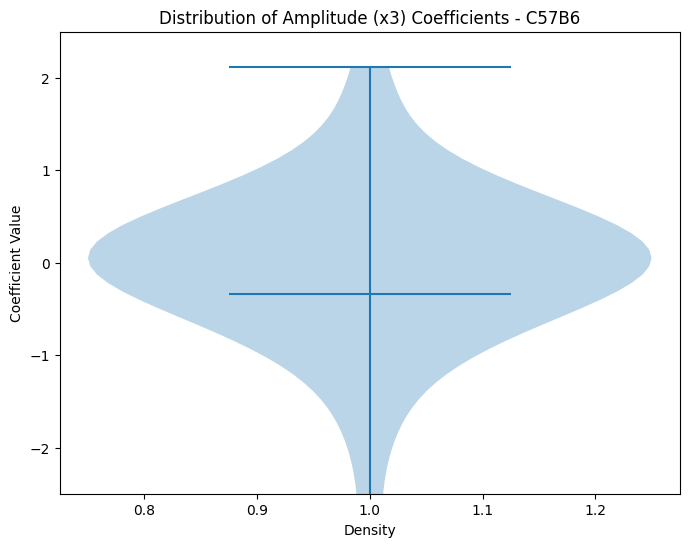

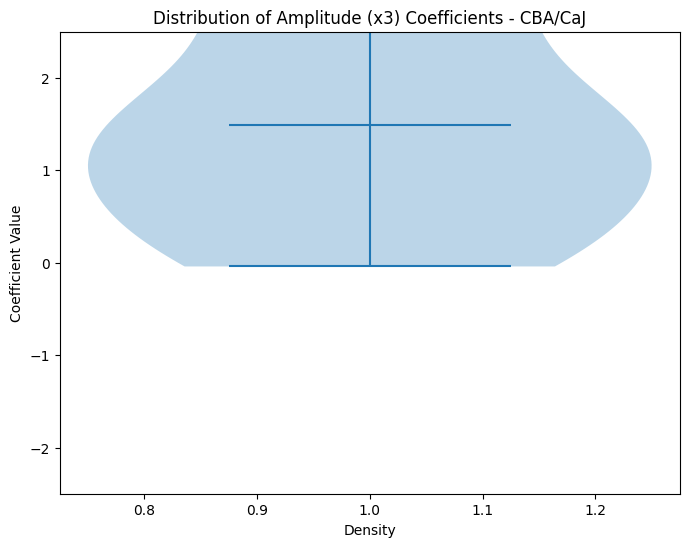

In [667]:
# Create a violin plot for coefficients PER GROUP
feature = 'Amplitude (x3)'
for strain in coefficients_by_group_strain['Strain'].unique():
    plt.figure(figsize=(8,6))
    plt.violinplot(coefficients_by_group_strain[coefficients_by_group_strain['Strain'] == strain][feature], showmeans=True, showmedians=False)
    plt.title(f'Distribution of {feature} Coefficients - {strain}')
    plt.ylabel('Coefficient Value')
    plt.xlabel('Density')
    plt.ylim(-2.5,2.5)
    plt.show()

# EDA per Group

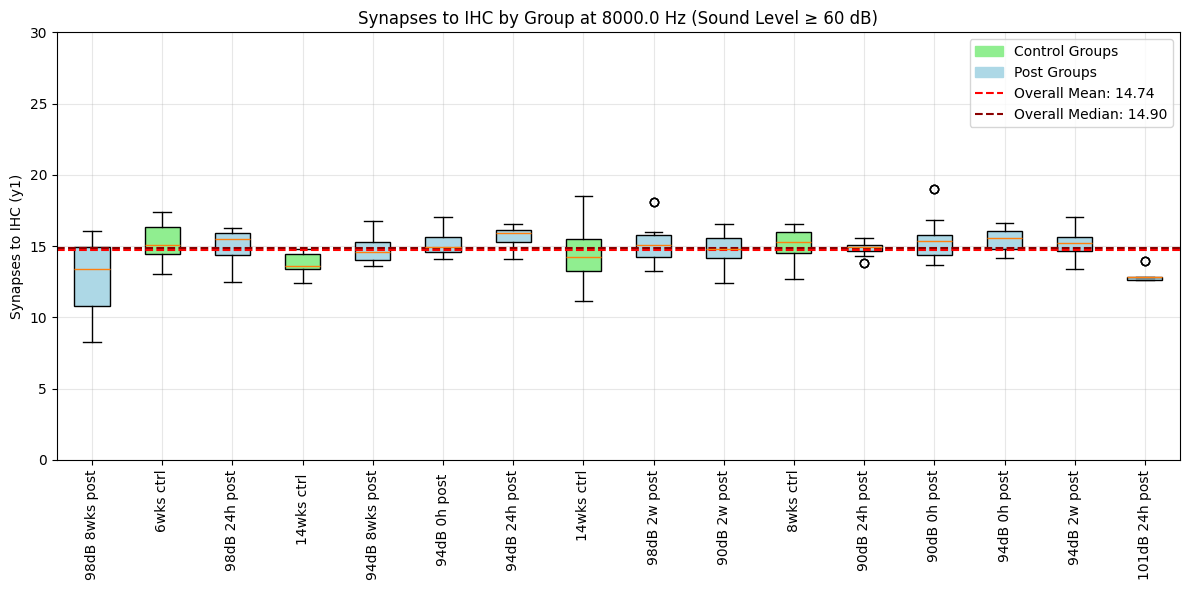

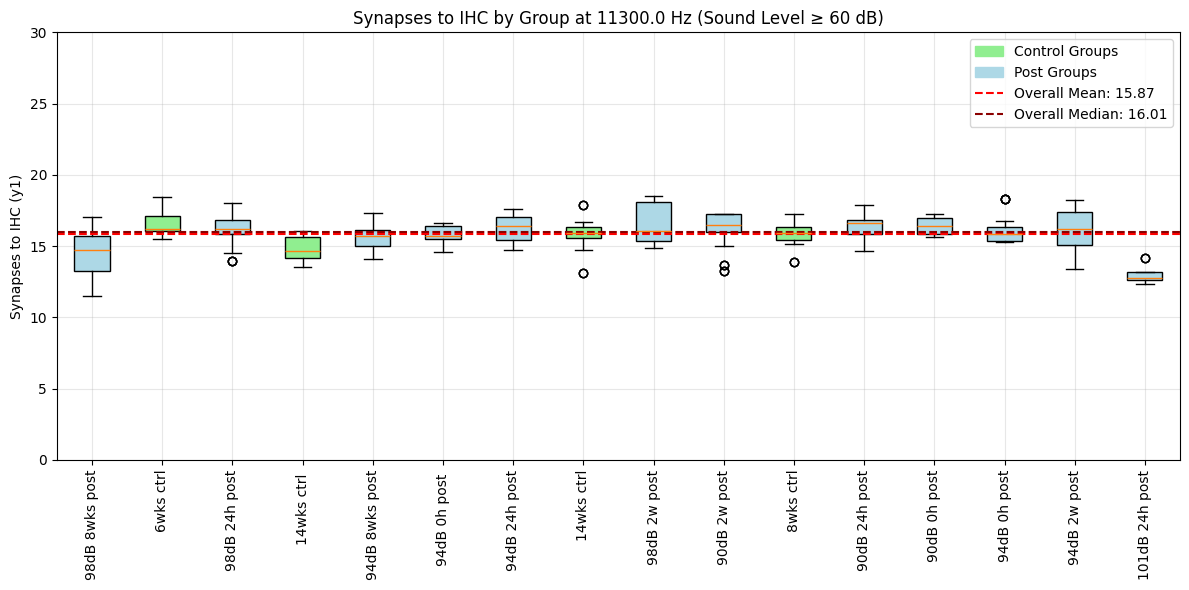

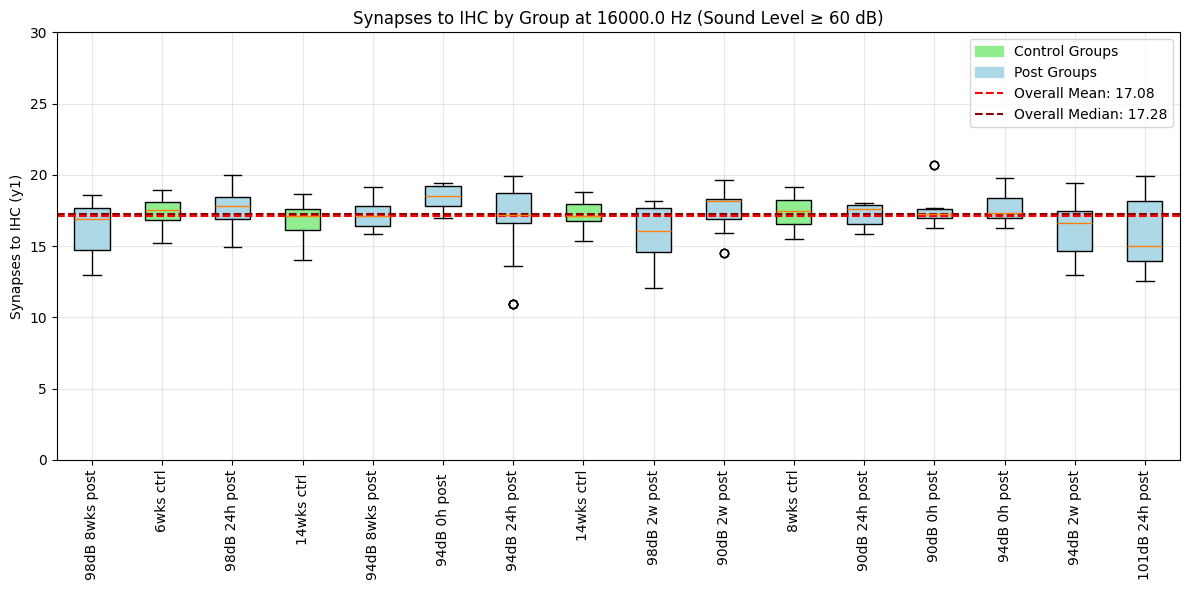

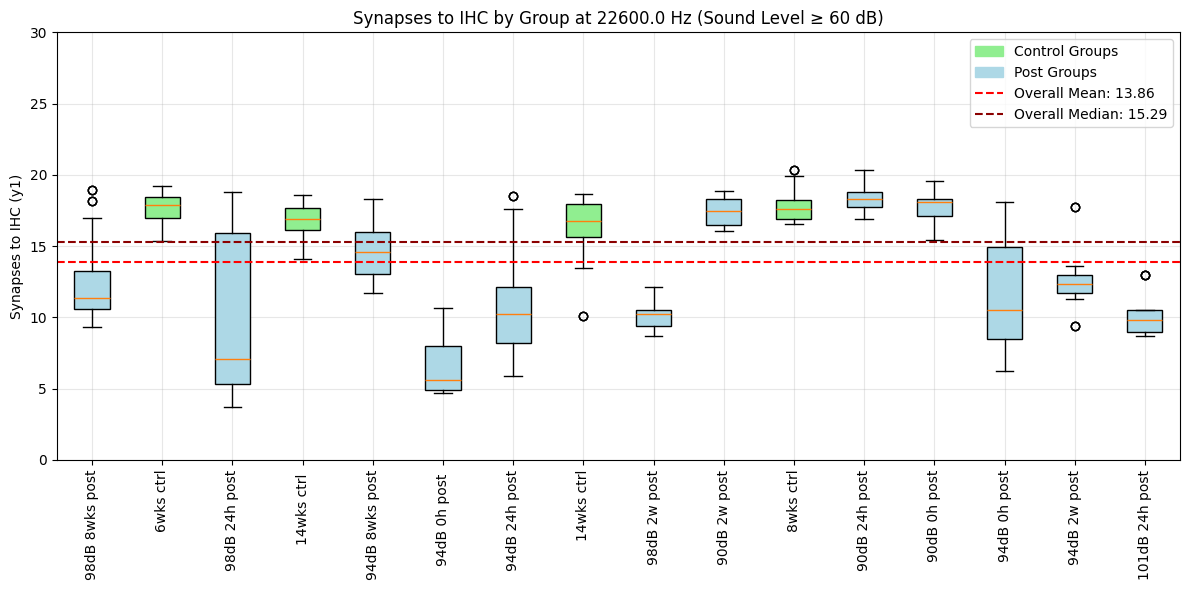

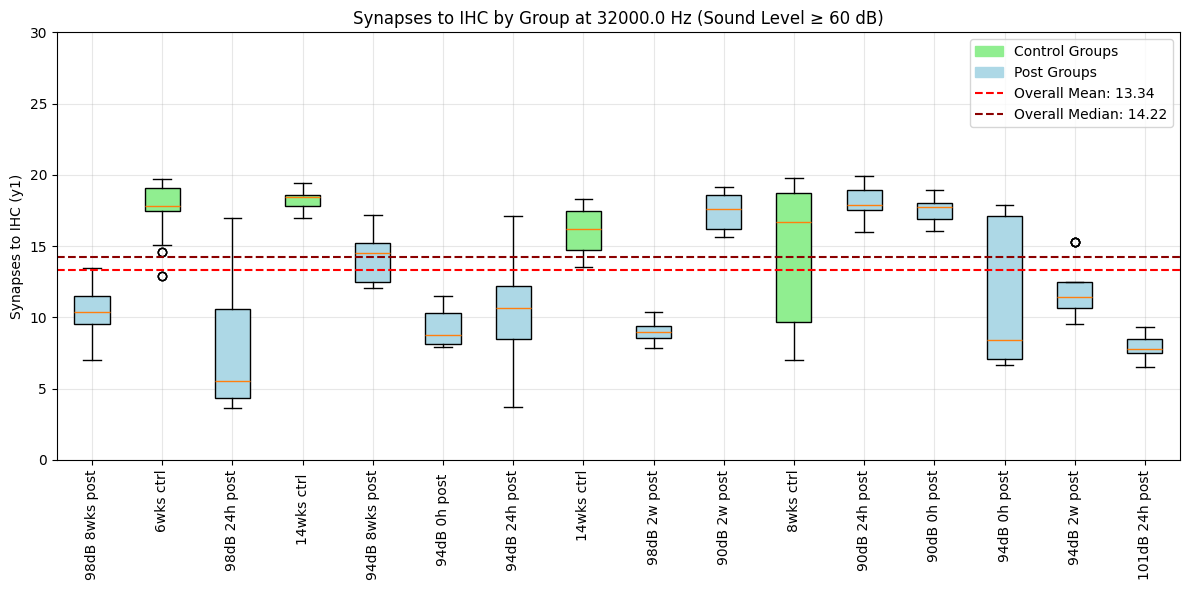

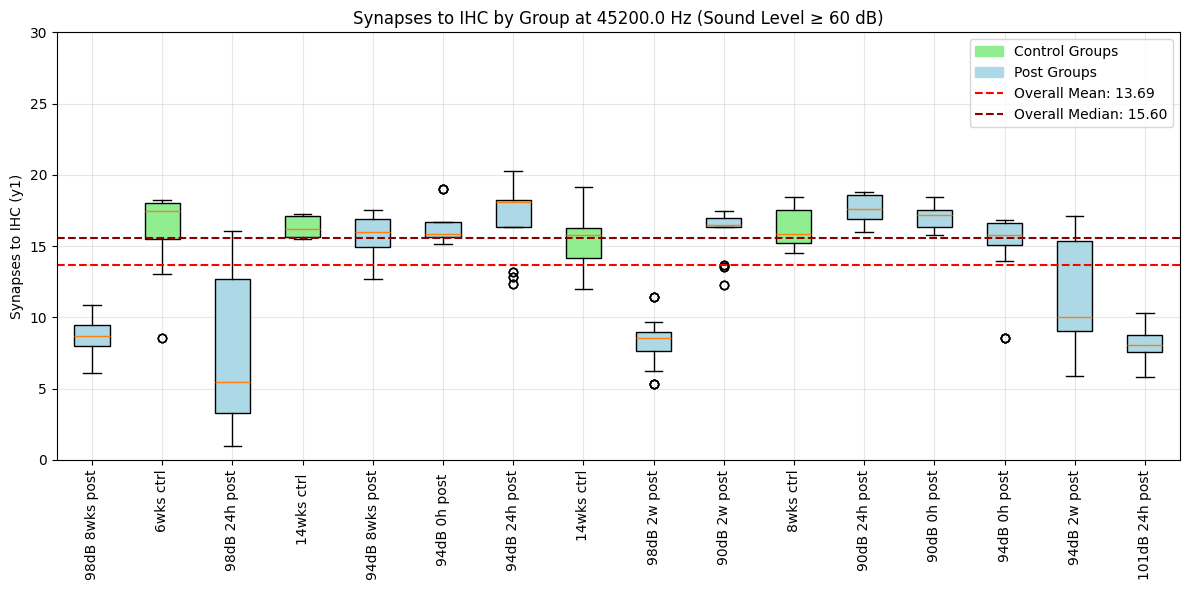

In [65]:
db_thres = 60
final_clean_strained_grouped_posdb_thres = 60
frequencies = final_clean_strained_grouped_pos['Freq(Hz) (x1)'].unique()
frequncies = frequencies.sort()

# Create a separate plot for each frequency
for freq in frequencies:
    plt.figure(figsize=(12, 6))
    
    # Get unique groups
    groups = final_clean_strained_grouped_pos['Group'].unique()
    
    # Prepare data for boxplot
    boxplot_data = []
    group_labels = []
    is_control = []  # Track which groups are controls
    
    for group in groups:
        subset = final_clean_strained_grouped_pos[(final_clean_strained_grouped_pos['Group'] == group) & 
                                                 (final_clean_strained_grouped_pos['Level(dB) (x2)'] >= db_thres) &
                                                 (final_clean_strained_grouped_pos['Freq(Hz) (x1)'] == freq)]
        # Only add non-empty groups
        if not subset.empty:
            boxplot_data.append(subset['Synapses to IHC (y1)'])
            group_labels.append(group)
            # Determine if this is a control group (contains 'ctrl' in the name)
            is_control.append('ctrl' in str(group).lower())
    
    # Get frequency-specific data for statistics
    freq_data = final_clean_strained_grouped_pos[(final_clean_strained_grouped_pos['Level(dB) (x2)'] >= db_thres) &
                                              (final_clean_strained_grouped_pos['Freq(Hz) (x1)'] == freq)]
    
    # Calculate statistics
    overall_mean = freq_data['Synapses to IHC (y1)'].mean()
    overall_median = freq_data['Synapses to IHC (y1)'].median()
    
    # Create boxplot (only if we have data)
    if boxplot_data:
        bp = plt.boxplot(boxplot_data, patch_artist=True, labels=group_labels)
        
        # Set colors based on whether it's a control group
        for i, (patch, is_ctrl) in enumerate(zip(bp['boxes'], is_control)):
            if is_ctrl:
                patch.set_facecolor('lightgreen')  # Color for control groups
            else:
                patch.set_facecolor('lightblue')   # Color for post groups
        
        # Create legend patches
        import matplotlib.patches as mpatches
        ctrl_patch = mpatches.Patch(color='lightgreen', label='Control Groups')
        post_patch = mpatches.Patch(color='lightblue', label='Post Groups')
        
        # Add horizontal lines for mean and median
        mean_line = plt.axhline(y=overall_mean, color='red', linestyle='--', label=f'Overall Mean: {overall_mean:.2f}')
        median_line = plt.axhline(y=overall_median, color='darkred', linestyle='--', label=f'Overall Median: {overall_median:.2f}')

        plt.ylabel('Synapses to IHC (y1)')
        plt.title(f'Synapses to IHC by Group at {freq} Hz (Sound Level ≥ {db_thres} dB)')
        plt.grid(True, alpha=0.3)
        plt.ylim((0, 30))
        plt.xticks(rotation=90)  # Rotate labels for better readability
        
        # Add legend with control/post patches plus mean/median lines
        plt.legend(handles=[ctrl_patch, post_patch, mean_line, median_line], 
                   loc='upper right')
        
        plt.tight_layout()
        plt.show()
    else:
        print(f"No data found for any group at {freq} Hz with Level(dB) (x2) >= {db_thres}")

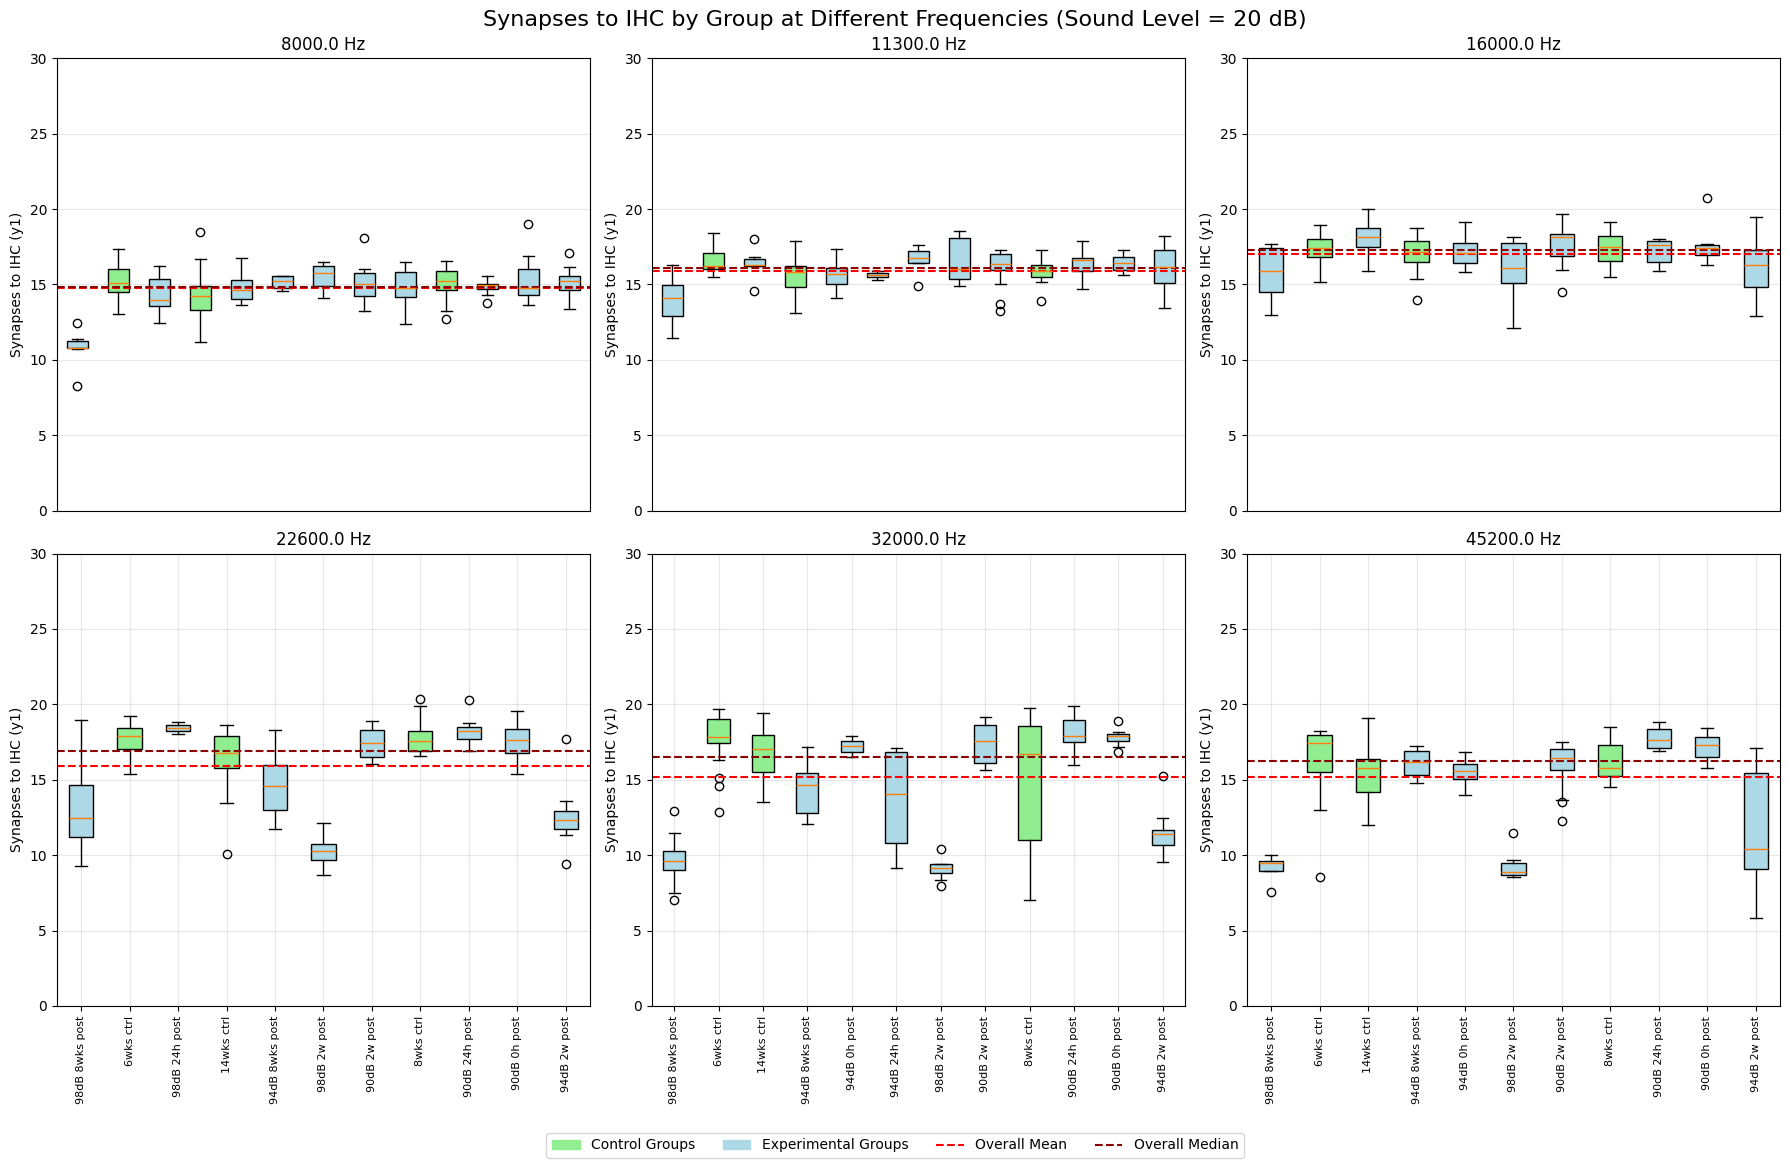

In [127]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches

db_thres = 20
frequencies = final_clean_strained_grouped_pos_cleangroup['Freq(Hz) (x1)'].unique()
frequencies = np.sort(frequencies)  # Sort frequencies

# Create a single figure with subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()  # Flatten the 2D array to make indexing easier

# Get unique groups for consistency across subplots
all_groups = final_clean_strained_grouped_pos_cleangroup['Group'].unique()

for i, freq in enumerate(frequencies):
    if i < len(axes):  # Ensure we have enough subplots
        ax = axes[i]
        
        # Prepare data for boxplot
        boxplot_data = []
        group_labels = []
        is_control = []  # Track which groups are controls
        
        for group in all_groups:
            subset = final_clean_strained_grouped_pos_cleangroup[(final_clean_strained_grouped_pos_cleangroup['Group'] == group) & 
                                                     (final_clean_strained_grouped_pos_cleangroup['Level(dB) (x2)'] == db_thres) &
                                                     (final_clean_strained_grouped_pos_cleangroup['Freq(Hz) (x1)'] == freq)]
            # Only add non-empty groups
            if not subset.empty:
                boxplot_data.append(subset['Synapses to IHC (y1)'])
                group_labels.append(group)
                # Determine if this is a control group (contains 'ctrl' in the name)
                is_control.append('ctrl' in str(group).lower())
        
        # Get frequency-specific data for statistics
        freq_data = final_clean_strained_grouped_pos[(final_clean_strained_grouped_pos_cleangroup['Level(dB) (x2)'] == db_thres) &
                                                  (final_clean_strained_grouped_pos_cleangroup['Freq(Hz) (x1)'] == freq)]
        
        # Calculate statistics
        overall_mean = freq_data['Synapses to IHC (y1)'].mean()
        overall_median = freq_data['Synapses to IHC (y1)'].median()
        
        # Create boxplot (only if we have data)
        if boxplot_data:
            bp = ax.boxplot(boxplot_data, patch_artist=True)
            
            # Set colors based on whether it's a control group
            for j, (patch, is_ctrl) in enumerate(zip(bp['boxes'], is_control)):
                if is_ctrl:
                    patch.set_facecolor('lightgreen')  # Color for control groups
                else:
                    patch.set_facecolor('lightblue')   # Color for post groups
            
            # Add horizontal lines for mean and median
            ax.axhline(y=overall_mean, color='red', linestyle='--')
            ax.axhline(y=overall_median, color='darkred', linestyle='--')

            ax.set_ylabel('Synapses to IHC (y1)')
            ax.set_title(f'{freq} Hz') # (≥ {db_thres} dB)
            ax.grid(True, alpha=0.3)
            ax.set_ylim((0, 30))
            
            # Only set x-tick labels if it's the bottom row (to save space)
            if i >= 3:
                ax.set_xticklabels(group_labels, rotation=90, fontsize=8)
            else:
                ax.set_xticklabels([])
                ax.set_xticks([])  # Hide the tick marks too
        else:
            ax.text(0.5, 0.5, f"No data for {freq} Hz\n(Level = {db_thres} dB)", 
                   ha='center', va='center', transform=ax.transAxes)

# Add a common legend for all subplots
ctrl_patch = mpatches.Patch(color='lightgreen', label='Control Groups')
post_patch = mpatches.Patch(color='lightblue', label='Experimental Groups')
mean_line = plt.Line2D([0], [0], color='red', linestyle='--', label=f'Overall Mean')
median_line = plt.Line2D([0], [0], color='darkred', linestyle='--', label=f'Overall Median')

fig.legend(handles=[ctrl_patch, post_patch, mean_line, median_line], 
           loc='upper center', bbox_to_anchor=(0.5, 0.05), ncol=4)

# Add an overall title
fig.suptitle(f'Synapses to IHC by Group at Different Frequencies (Sound Level = {db_thres} dB)', 
             fontsize=16, y=0.98)

plt.tight_layout()
plt.subplots_adjust(bottom=0.15)  # Make room for the legend
plt.show()

In [92]:
# Get v1 and v2 data
v1s = final_clean_strained_grouped_pos[final_clean_strained_grouped_pos['vx (x4)'] == 'v1']
v2s = final_clean_strained_grouped_pos[final_clean_strained_grouped_pos['vx (x4)'] == 'v2']

# Create a multi-index on all common factors except vx
index_cols = ['Subject', 'Freq(Hz) (x1)', 'Level(dB) (x2)', 'Amplitude (x3)', 'Strain (x5)', 'Group']

# Reset index to make sure we're working with clean indices
v1s_indexed = v1s.reset_index().set_index(index_cols)
v2s_indexed = v2s.reset_index().set_index(index_cols)

# Create a new DataFrame to store both original values and the difference
diff = pd.DataFrame({
    'Synapses to IHC (v1)': v1s_indexed['Synapses to IHC (y1)'],
    'Synapses to IHC (v2)': v2s_indexed['Synapses to IHC (y1)'],
})

# Calculate the difference
diff['Synapses to IHC DIFF'] = diff['Synapses to IHC (v1)'] - diff['Synapses to IHC (v2)']

# Reset the index to get a regular DataFrame with columns
diff_reset = diff.reset_index()
diff_reset_clean = diff_reset.dropna()
len(diff_reset), len(diff_reset_clean)

# diff_reset[diff_reset['Synapses to IHC DIFF'] != diff_reset['Synapses to IHC (v1)'] - diff_reset['Synapses to IHC (v2)']]

(6104, 6083)

In [91]:
# diff_reset[diff_reset['Synapses to IHC DIFF'] != diff_reset['Synapses to IHC (v1)'] - diff_reset['Synapses to IHC (v2)']]
# final_clean_strained_grouped_pos[(final_clean_strained_grouped_pos['Subject'] == 'WPZ92') & (final_clean_strained_grouped_pos['Freq(Hz) (x1)'] == 32000.0)]

In [128]:
final_clean_strained_grouped_pos_cleangroup

,Subject,Freq(Hz) (x1),Level(dB) (x2),Amplitude (x3),vx (x4),Strain (x5),Synapses to IHC (y1),Group,Group - dB,Group - Time Elapsed
0,WPZ145,45200.0,70.0,0.033579,v1,C57B6,8.750000,98dB 8wks post,98dB,8wks
0,WPZ145,45200.0,70.0,0.033579,v2,C57B6,10.888889,98dB 8wks post,98dB,8wks
1,WPZ145,45200.0,75.0,0.034262,v1,C57B6,8.750000,98dB 8wks post,98dB,8wks
1,WPZ145,45200.0,75.0,0.034262,v2,C57B6,10.888889,98dB 8wks post,98dB,8wks
2,WPZ145,45200.0,80.0,0.154224,v1,C57B6,8.750000,98dB 8wks post,98dB,8wks
...,...,...,...,...,...,...,...,...,...,...
7328,WPZ101,32000.0,60.0,1.634279,v2,C57B6,15.463918,8wks ctrl,Control,8wks
7329,WPZ101,32000.0,70.0,1.769193,v1,C57B6,16.923077,8wks ctrl,Control,8wks
7329,WPZ101,32000.0,70.0,1.769193,v2,C57B6,15.463918,8wks ctrl,Control,8wks
7330,WPZ101,32000.0,80.0,1.023154,v1,C57B6,16.923077,8wks ctrl,Control,8wks


In [ ]:
diff

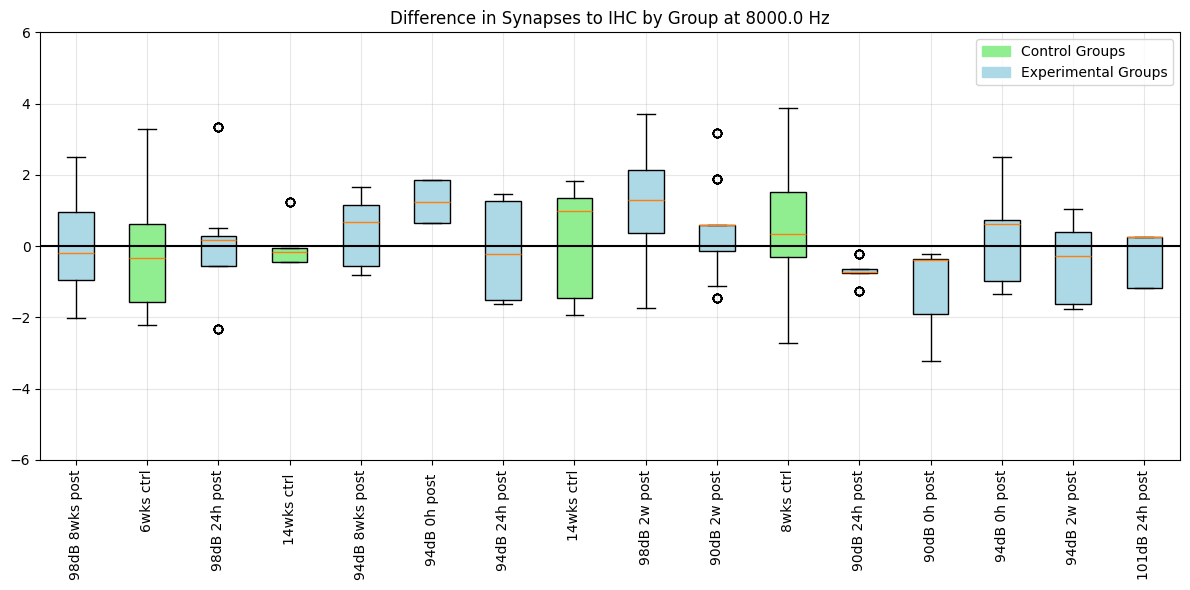

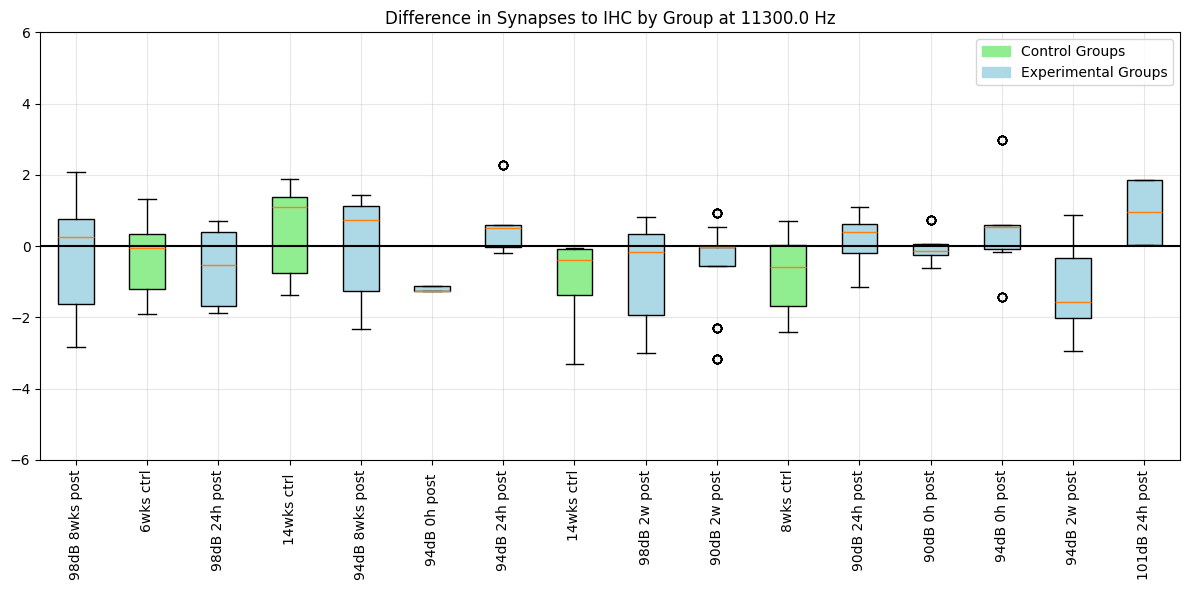

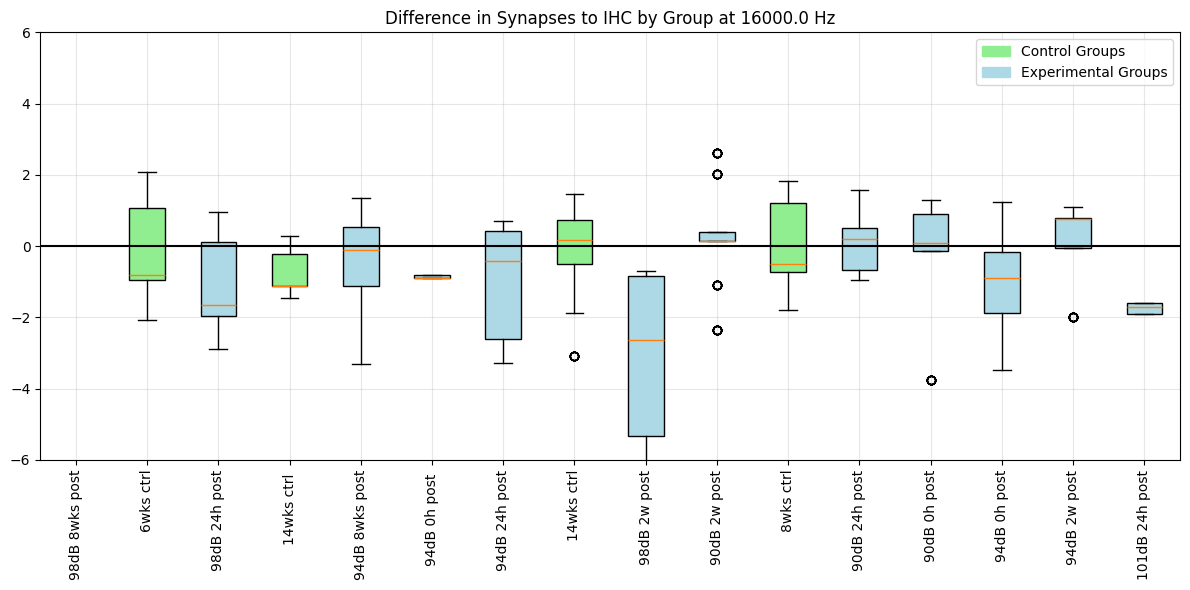

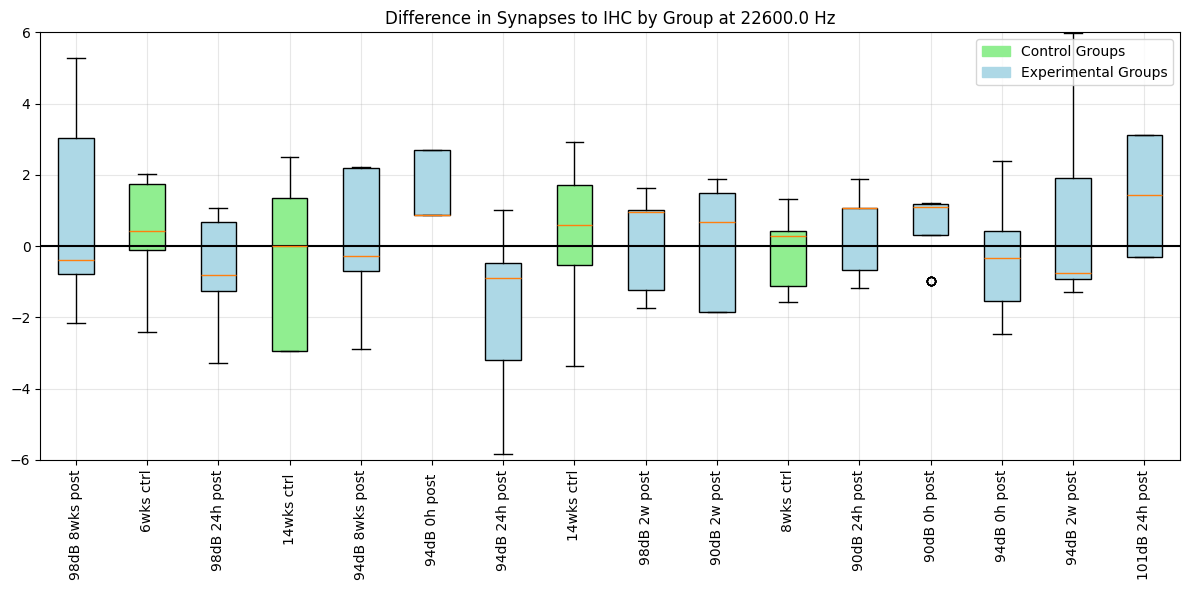

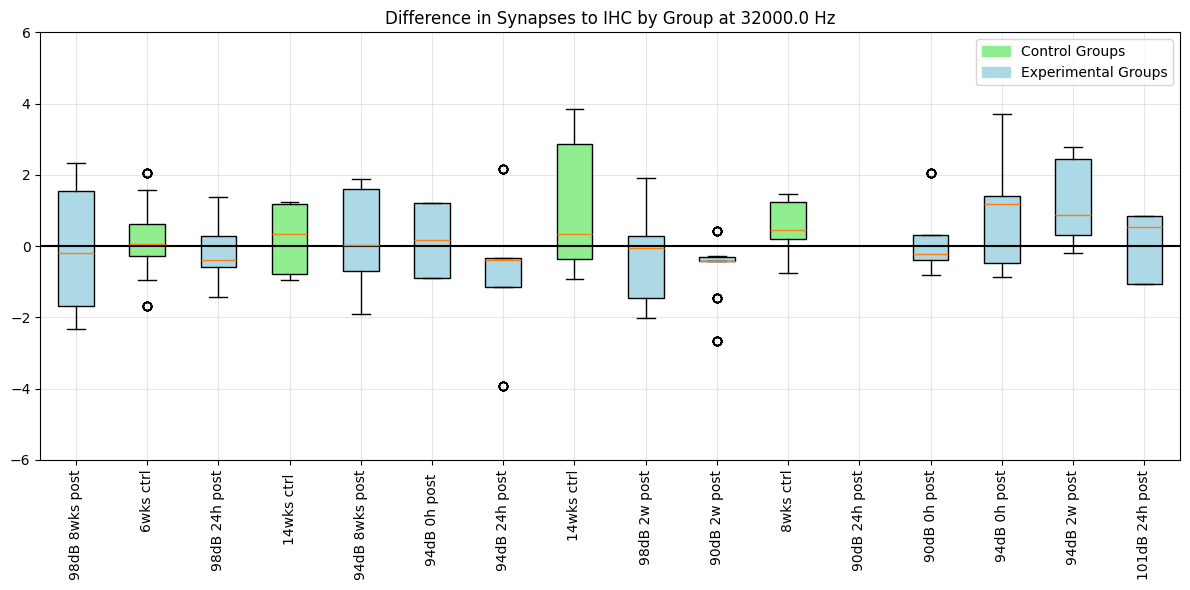

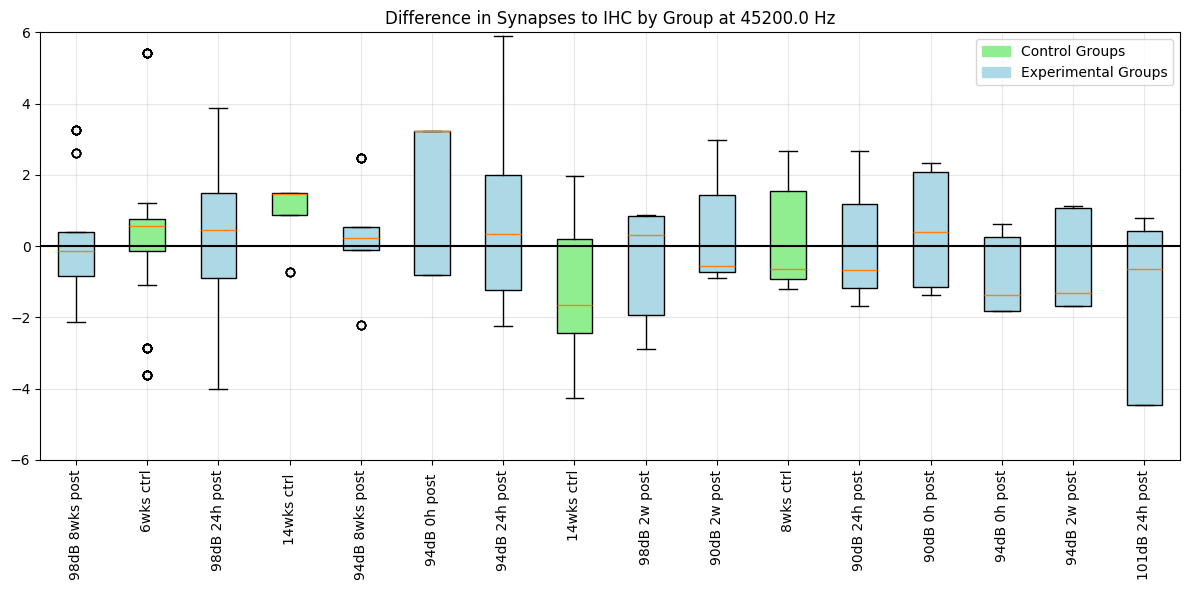

In [93]:
v1s = final_clean_strained_grouped_pos[final_clean_strained_grouped_pos['vx (x4)'] == 'v1']
v2s = final_clean_strained_grouped_pos[final_clean_strained_grouped_pos['vx (x4)'] == 'v2']

# Create a multi-index on all common factors except vx
index_cols = ['Subject', 'Freq(Hz) (x1)', 'Level(dB) (x2)', 'Amplitude (x3)', 'Strain (x5)', 'Group']

# Reset index to make sure we're working with clean indices
v1s_indexed = v1s.reset_index().set_index(index_cols)
v2s_indexed = v2s.reset_index().set_index(index_cols)

# Now the subtraction will align properly
# diff = pd.DataFrame(v1s_indexed['Synapses to IHC (y1)'] - v2s_indexed['Synapses to IHC (y1)'])

# # Reset the index to get a regular DataFrame with columns
# diff_reset = diff.reset_index()
# diff_reset['Synapses to IHC DIFF'] = diff_reset['Synapses to IHC (y1)']
# diff_reset = diff_reset.drop('Synapses to IHC (y1)', axis = 1)
# Now plot using appropriate columns
# diff_reset[(diff_reset['Subject'] == 'WPZ100') & (diff_reset['Freq(Hz) (x1)'] == 16000.0)]

# final_clean_strained_grouped_posdb_thres = 60
frequencies = final_clean_strained_grouped_pos['Freq(Hz) (x1)'].unique()
frequncies = frequencies.sort()

# Create a separate plot for each frequency
for freq in frequencies:
    plt.figure(figsize=(12, 6))
    
    # Get unique groups
    groups = final_clean_strained_grouped_pos['Group'].unique()
    
    # Prepare data for boxplot
    boxplot_data = []
    group_labels = []
    is_control = []  # Track which groups are controls
    
    for group in groups:
        subset = diff_reset[(diff_reset['Group'] == group) & 
                                                #  (diff_reset['Level(dB) (x2)'] >= db_thres) &
                                                 (diff_reset['Freq(Hz) (x1)'] == freq)]
        # Only add non-empty groups
        if not subset.empty:
            boxplot_data.append(subset['Synapses to IHC DIFF'])
            group_labels.append(group)
            # Determine if this is a control group (contains 'ctrl' in the name)
            is_control.append('ctrl' in str(group).lower())
    
    # Get frequency-specific data for statistics
    freq_data = final_clean_strained_grouped_pos[final_clean_strained_grouped_pos['Freq(Hz) (x1)'] == freq] # (final_clean_strained_grouped_pos['Level(dB) (x2)'] >= db_thres) &
    
    # Calculate statistics
    overall_mean = freq_data['Synapses to IHC (y1)'].mean()
    overall_median = freq_data['Synapses to IHC (y1)'].median()


# import matplotlib.patches as mpatches
    # Create boxplot (only if we have data)
    if boxplot_data:
        bp = plt.boxplot(boxplot_data, patch_artist=True, labels=group_labels)

        for i, (patch, is_ctrl) in enumerate(zip(bp['boxes'], is_control)):
            if is_ctrl:
                patch.set_facecolor('lightgreen')  # Color for control groups
            else:
                patch.set_facecolor('lightblue')   # Color for post groups
        
        # Create legend patches
        import matplotlib.patches as mpatches
        ctrl_patch = mpatches.Patch(color='lightgreen', label='Control Groups')
        post_patch = mpatches.Patch(color='lightblue', label='Experimental Groups')

        plt.title(f'Difference in Synapses to IHC by Group at {freq} Hz')
        plt.grid(True, alpha=0.3)
        plt.ylim((-6, 6))
        plt.xticks(rotation=90)  # Rotate labels for better readability
        
        # Add legend with control/post patches plus mean/median lines
        plt.legend(handles=[ctrl_patch, post_patch], 
                   loc='upper right')
        plt.axhline(y=0, color='black', linestyle='-')
        plt.tight_layout()
        plt.show()

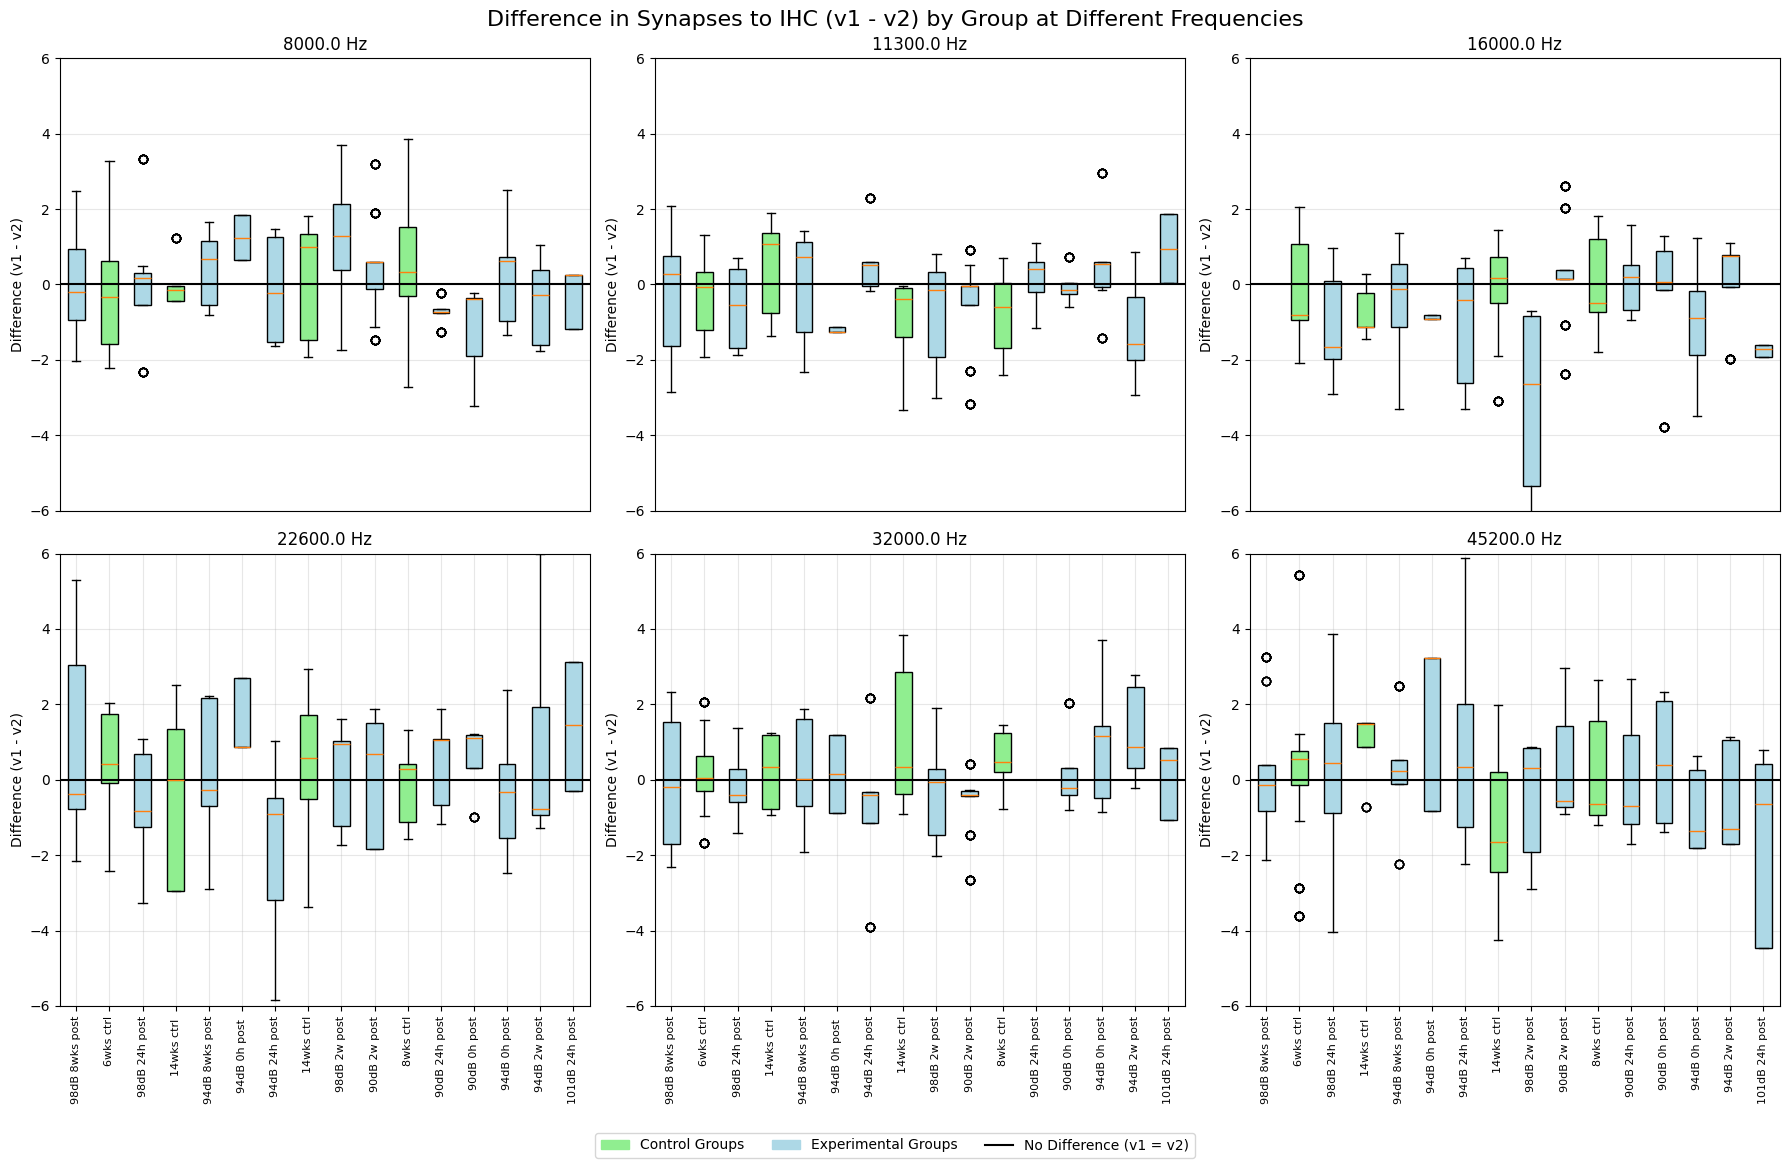

In [80]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches
import pandas as pd

# Get v1 and v2 data
v1s = final_clean_strained_grouped_pos[final_clean_strained_grouped_pos['vx (x4)'] == 'v1']
v2s = final_clean_strained_grouped_pos[final_clean_strained_grouped_pos['vx (x4)'] == 'v2']

# Create a multi-index on all common factors except vx
index_cols = ['Subject', 'Freq(Hz) (x1)', 'Level(dB) (x2)', 'Amplitude (x3)', 'Strain (x5)', 'Group']

# Reset index to make sure we're working with clean indices
v1s_indexed = v1s.reset_index().set_index(index_cols)
v2s_indexed = v2s.reset_index().set_index(index_cols)

# Calculate difference (v1 - v2)
diff = pd.DataFrame(v1s_indexed['Synapses to IHC (y1)'] - v2s_indexed['Synapses to IHC (y1)'])

# Reset the index to get a regular DataFrame with columns
diff_reset = diff.reset_index()
diff_reset['Synapses to IHC DIFF'] = diff_reset['Synapses to IHC (y1)']
diff_reset = diff_reset.drop('Synapses to IHC (y1)', axis=1)

# Get frequencies and sort them
frequencies = final_clean_strained_grouped_pos['Freq(Hz) (x1)'].unique()
frequencies = np.sort(frequencies)

# Create a single figure with subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()  # Flatten the 2D array to make indexing easier

# Get unique groups for consistency across subplots
all_groups = final_clean_strained_grouped_pos['Group'].unique()

for i, freq in enumerate(frequencies):
    if i < len(axes):  # Ensure we have enough subplots
        ax = axes[i]
        
        # Prepare data for boxplot
        boxplot_data = []
        group_labels = []
        is_control = []  # Track which groups are controls
        
        for group in all_groups:
            subset = diff_reset[(diff_reset['Group'] == group) & 
                               (diff_reset['Freq(Hz) (x1)'] == freq)]
            # Only add non-empty groups
            if not subset.empty:
                boxplot_data.append(subset['Synapses to IHC DIFF'])
                group_labels.append(group)
                # Determine if this is a control group
                is_control.append('ctrl' in str(group).lower())
        
        # Create boxplot (only if we have data)
        if boxplot_data:
            bp = ax.boxplot(boxplot_data, patch_artist=True)
            
            # Set colors based on whether it's a control group
            for j, (patch, is_ctrl) in enumerate(zip(bp['boxes'], is_control)):
                if is_ctrl:
                    patch.set_facecolor('lightgreen')  # Color for control groups
                else:
                    patch.set_facecolor('lightblue')   # Color for post groups
            
            # Add horizontal line at zero (no difference)
            ax.axhline(y=0, color='black', linestyle='-')

            ax.set_ylabel('Difference (v1 - v2)')
            ax.set_title(f'{freq} Hz')
            ax.grid(True, alpha=0.3)
            ax.set_ylim((-6, 6))
            
            # Only set x-tick labels if it's the bottom row (to save space)
            if i >= 3:
                ax.set_xticklabels(group_labels, rotation=90, fontsize=8)
            else:
                ax.set_xticklabels([])
                ax.set_xticks([])  # Hide the tick marks too
        else:
            ax.text(0.5, 0.5, f"No data for {freq} Hz", 
                   ha='center', va='center', transform=ax.transAxes)

# Add a common legend for all subplots
ctrl_patch = mpatches.Patch(color='lightgreen', label='Control Groups')
post_patch = mpatches.Patch(color='lightblue', label='Experimental Groups')
zero_line = plt.Line2D([0], [0], color='black', linestyle='-', label='No Difference (v1 = v2)')

fig.legend(handles=[ctrl_patch, post_patch, zero_line], 
           loc='upper center', bbox_to_anchor=(0.5, 0.05), ncol=3)

# Add an overall title
fig.suptitle('Difference in Synapses to IHC (v1 - v2) by Group at Different Frequencies', 
             fontsize=16, y=0.98)

plt.tight_layout()
plt.subplots_adjust(bottom=0.15)  # Make room for the legend
plt.show()

In [195]:
final_clean_strained_grouped_pos_cleangroup.columns

Index(['Subject', 'Freq(Hz) (x1)', 'Level(dB) (x2)', 'Amplitude (x3)',
       'vx (x4)', 'Strain (x5)', 'Synapses to IHC (y1)', 'Group', 'Group - dB',
       'Group - Time Elapsed'],
      dtype='object')

                Freq(Hz) (x1)  Level(dB) (x2)  Amplitude (x3)  vx_encoded  \
Freq(Hz) (x1)        1.000000        0.063664       -0.160738    0.001105   
Level(dB) (x2)       0.063664        1.000000        0.608583   -0.000263   
Amplitude (x3)      -0.160738        0.608583        1.000000   -0.000414   
vx_encoded           0.001105       -0.000263       -0.000414    1.000000   
strain_encoded      -0.007222        0.016637       -0.042254   -0.002173   

                strain_encoded  
Freq(Hz) (x1)        -0.007222  
Level(dB) (x2)        0.016637  
Amplitude (x3)       -0.042254  
vx_encoded           -0.002173  
strain_encoded        1.000000  


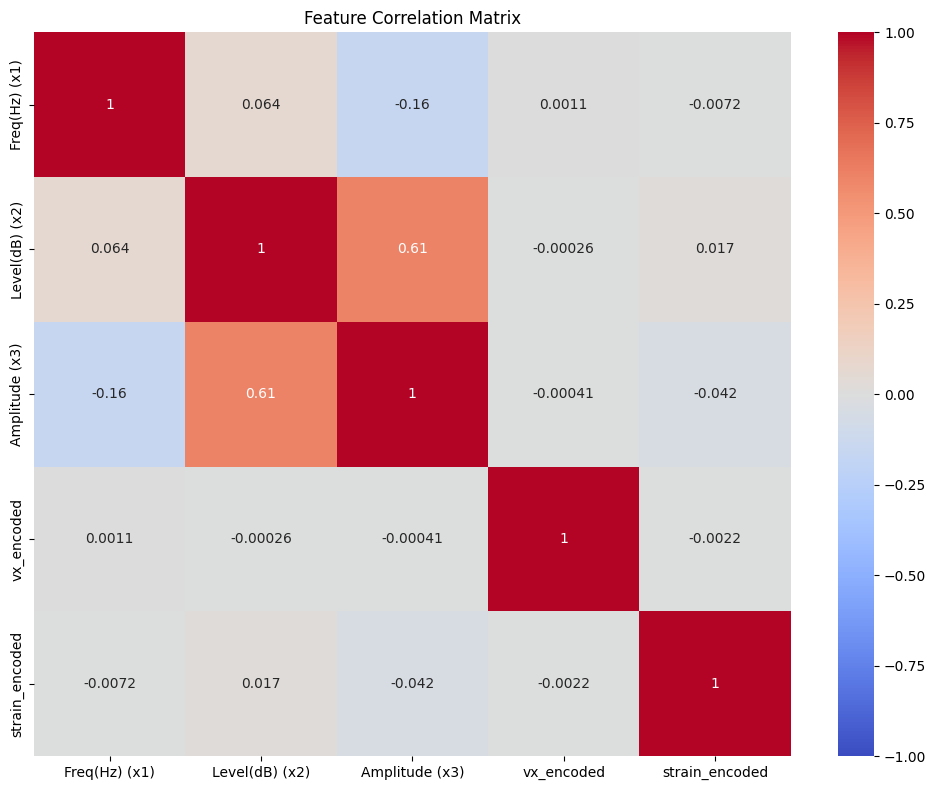

In [218]:
# Make a copy of your data to avoid modifying the original
df_corr = final_clean_strained_grouped_pos_cleangroup.copy()

# Use label encoding for both categorical variables
from sklearn.preprocessing import LabelEncoder

# Encode vx (x4)
le_vx = LabelEncoder()
df_corr['vx_encoded'] = le_vx.fit_transform(df_corr['vx (x4)'])

# Encode strain
le_strain = LabelEncoder()
df_corr['strain_encoded'] = le_strain.fit_transform(df_corr['Strain (x5)'])

# Create one-hot encoding for strain
strain_dummies = pd.get_dummies(df_corr['Strain (x5)'], prefix='Strain')

# Select numerical columns for correlation
numeric_cols = [
    'Freq(Hz) (x1)', 
    'Level(dB) (x2)', 
    'Amplitude (x3)', 
    'vx_encoded', 
    'strain_encoded'
]

# Calculate correlation matrix
correlation_matrix = df_corr[numeric_cols].corr()

# Display the matrix
print(correlation_matrix)

# Visualize correlation matrix
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()